In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [104]:
def plot_map():
    for line in map_:
        plt.plot([line['A'][0], line['B'][0]], [line['A'][1], line['B'][1]], color='k', linewidth=3)
#         plt.axis('scaled')

In [3]:
map_ = [{'A':[0, 0], 'B': [50, 0]},
        {'A':[50, 0], 'B': [50, 30]},
        {'A':[50, 30], 'B': [0, 30]},
        {'A':[0, 30], 'B': [0, 0]},
        
        {'A':[0, 8], 'B': [25, 8]},
        {'A':[30, 8], 'B': [40, 8]},
        {'A':[35, 8], 'B': [35, 30]},
        {'A':[15, 15], 'B': [15, 20]}]

In [4]:
# Motion model

def transition(pose, control):
    
    x = pose[0]
    y = pose[1]
    theta = pose[2]
    v = control[0]
    w = control[1]
    
    dt = 0.5
    alpha1 = 0.2
    alpha2 = 0.01
    alpha3 = 0.01
    alpha4 = 0.05
    alpha5 = 0.005
    alpha6 = 0.005
    
    v += np.random.normal(0, np.sqrt(alpha1*np.abs(v) + alpha2*np.abs(w)))
    w += np.random.normal(0, np.sqrt(alpha3*np.abs(v) + alpha4*np.abs(w)))
    gamma = np.random.normal(0, np.sqrt(alpha5*np.abs(v) + alpha6*np.abs(w)))
    
    x += -v*np.sin(theta)/w + v*np.sin(theta+w*dt)/w
    y += v*np.cos(theta)/w - v*np.cos(theta+w*dt)/w
    theta += w*dt + gamma*dt
    
    return [x, y, theta]

def precise_transition(pose, control):
    
    x = pose[0]
    y = pose[1]
    theta = pose[2]
    v = control[0]
    w = control[1]
    
    dt = 0.5
    alpha1 = 0.01
    alpha2 = 0.001
    alpha3 = 0.001
    alpha4 = 0.01
    alpha5 = 0.001
    alpha6 = 0.001
    
    v += np.random.normal(0, np.sqrt(alpha1*np.abs(v) + alpha2*np.abs(w)))
    w += np.random.normal(0, np.sqrt(alpha3*np.abs(v) + alpha4*np.abs(w)))
    gamma = np.random.normal(0, np.sqrt(alpha5*np.abs(v) + alpha6*np.abs(w)))
    
    x += -v*np.sin(theta)/w + v*np.sin(theta+w*dt)/w
    y += v*np.cos(theta)/w - v*np.cos(theta+w*dt)/w
    theta += w*dt + gamma*dt
    
    return [x, y, theta]

In [82]:
# Measurement model

lidar_range = 60
sigma_laser = 3
num_rays = 8

z1 = 0.8
z2 = 0.1
z3 = 0.07
z4 = 0.03

def normal_dist(x, mu, sigma):
    return 1/(2.5*sigma) * np.exp( -(x-mu)**2 / (2*sigma**2) )
def exp_dist(x, x0):
    if x>x0:
        return 0
    lambd = 0.05
    norm = 1 / (1 - np.exp(-lambd * x0))
    return norm * lambd * np.exp(-lambd * x)
def measurement_model(x, x_calc):
    if x<0 or x>lidar_range:
        return 0
    max_chance = np.random.uniform(0, 1)
    if max_chance < z4:
        return lidar_range
    return z1 * normal_dist(x, x_calc, sigma_laser) + \
        z2 * exp_dist(x, x_calc) + z3/lidar_range

In [54]:
# Used only for obtaining measurements

def sample_from_measurement_model(x_calc):
    while True:
        x = np.random.uniform(0, lidar_range)
        y = np.random.uniform(0, 0.5)
        if measurement_model(x, x_calc) > y:
            return x

In [55]:
def cast_ray(x, y, angle):
    ray = {'A':[x, y], 'B': [x+lidar_range*np.cos(angle), y+lidar_range*np.sin(angle)]}
    # plt.plot([ray['A'][0], ray['B'][0]], [ray['A'][1], ray['B'][1]], color='r')
    return ray

def line_intersection(line1, line2):
    x1, x2, x3, x4 = line1['A'][0], line1['B'][0], line2['A'][0], line2['B'][0]
    y1, y2, y3, y4 = line1['A'][1], line1['B'][1], line2['A'][1], line2['B'][1]

    dx1 = x2 - x1
    dx2 = x4 - x3
    dy1 = y2 - y1
    dy2 = y4 - y3
    dx3 = x1 - x3
    dy3 = y1 - y3

    det = dx1 * dy2 - dx2 * dy1
    det1 = dx1 * dy3 - dx3 * dy1
    det2 = dx2 * dy3 - dx3 * dy2

    if det == 0.0:  # lines are parallel
        if det1 != 0.0 or det2 != 0.0:  # lines are not co-linear
            return None  # so no solution

        if dx1:
            if x1 < x3 < x2 or x1 > x3 > x2:
                return math.inf  # infinitely many solutions
        else:
            if y1 < y3 < y2 or y1 > y3 > y2:
                return math.inf  # infinitely many solutions

        if line1[0] == line2[0] or line1[1] == line2[0]:
            return line2[0]
        elif line1[0] == line2[1] or line1[1] == line2[1]:
            return line2[1]

        return None  # no intersection

    s = det1 / det
    t = det2 / det

    if 0.0 < s < 1.0 and 0.0 < t < 1.0:
        return x1 + t * dx1, y1 + t * dy1

In [89]:
def get_range(ray):
    intersections = []
    for obj in map_:
        intersection = line_intersection(obj, ray)
        if intersection != None:
            intersections.append(intersection)
    if len(intersections) == 0:
        return None # или точку B луча
    else:
        intersections = np.array(intersections)
        ranges = (np.sum((intersections - np.array([ray['A'][0], ray['A'][1]]))**2, axis=1))**0.5
        point = intersections[np.argmin(ranges)]
        # plt.scatter(point[0], point[1], color='r')
        return np.min(ranges)

measurements = np.zeros(num_rays)
angles = np.arange(0, 2*np.pi, 2*np.pi/num_rays)

def get_lidar_measurements(pose, noisy=False):
    for i in range(num_rays):
        ray = cast_ray(pose[0], pose[1], pose[2] + angles[i])
        if get_range(ray) is not None:
            if noisy:
                measurement = sample_from_measurement_model(get_range(ray))
                measurements[i] = measurement
            else:
                measurement = get_range(ray)
                measurements[i] = measurement
        else:
            measurements[i] = 60
    return np.array(measurements)

In [90]:
def calculate_likelihood(scan, particle_scan):
    p = 1
    for i in range(len(scan)):
        p *= measurement_model(scan[i], particle_scan[i])
    return p

# def calculate_likelihood(scan, particle_scan):
#     p = normal_dist(np.std(scan-particle_scan), 0, sigma_laser)
#     return p

In [65]:
def resampling(particles, likelihoods):
    resampled_particles = []
    step = sum(likelihoods)/len(likelihoods)
    r = np.random.uniform(0, step)
    c = likelihoods[0]
    j = 0
    for i in range(len(particles)):
        u = r + i * step
        while u > c:
            j += 1
            c += likelihoods[j]
        resampled_particles.append(particles[j])
    return np.array(resampled_particles)

<ipython-input-117-3089d55ea114>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,15))


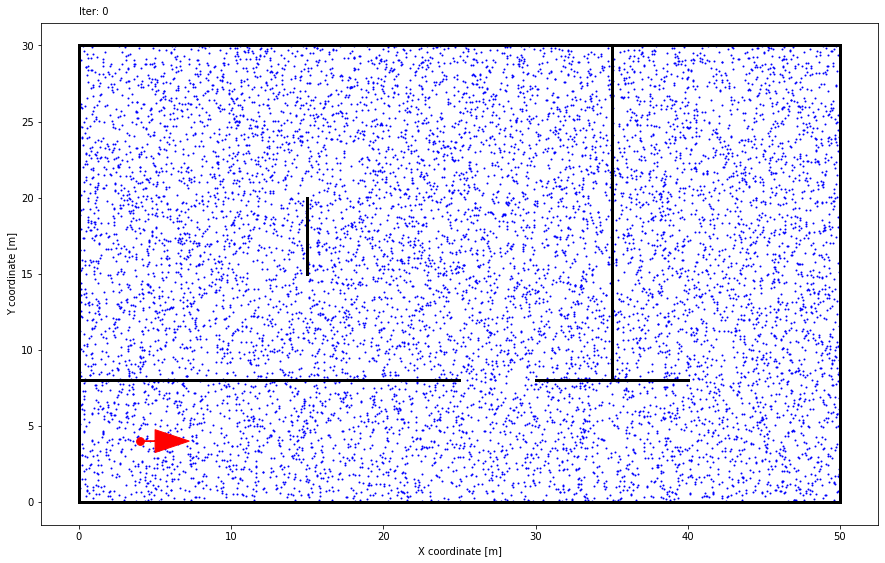

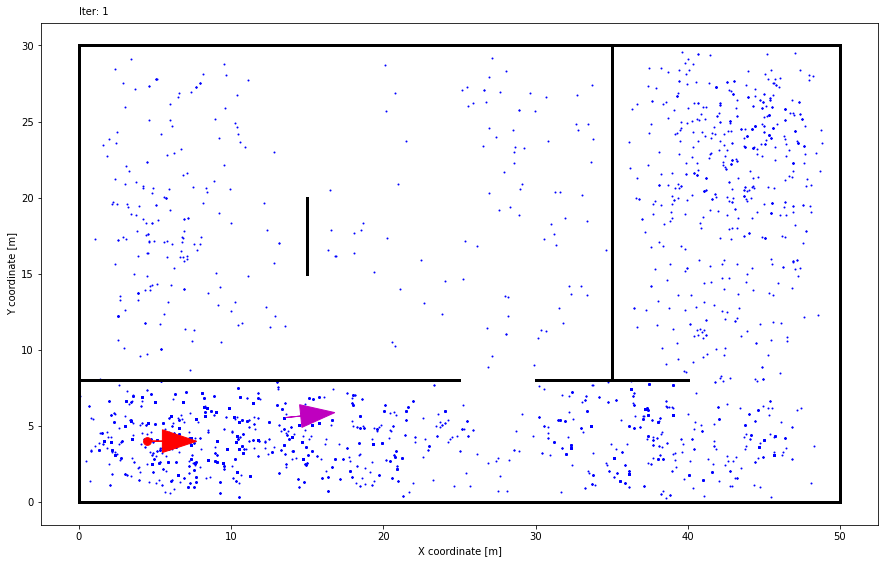

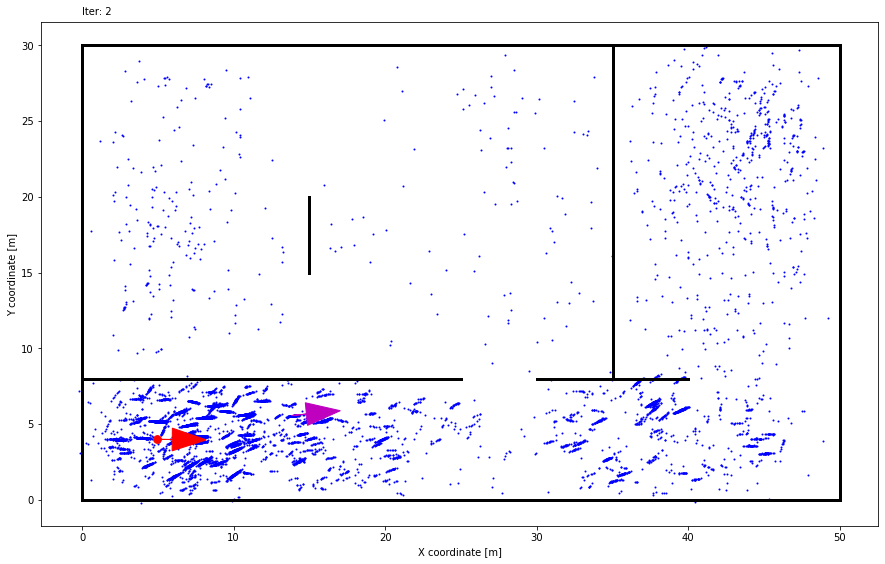

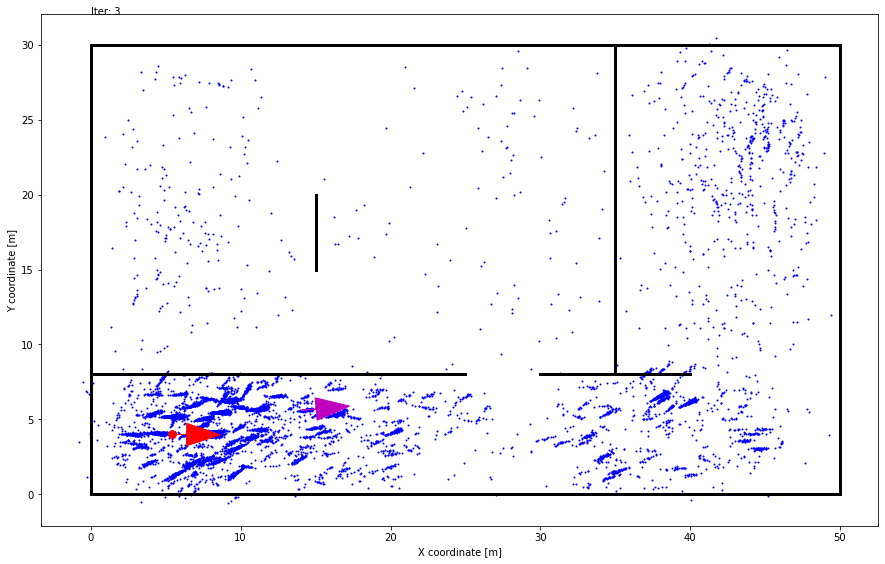

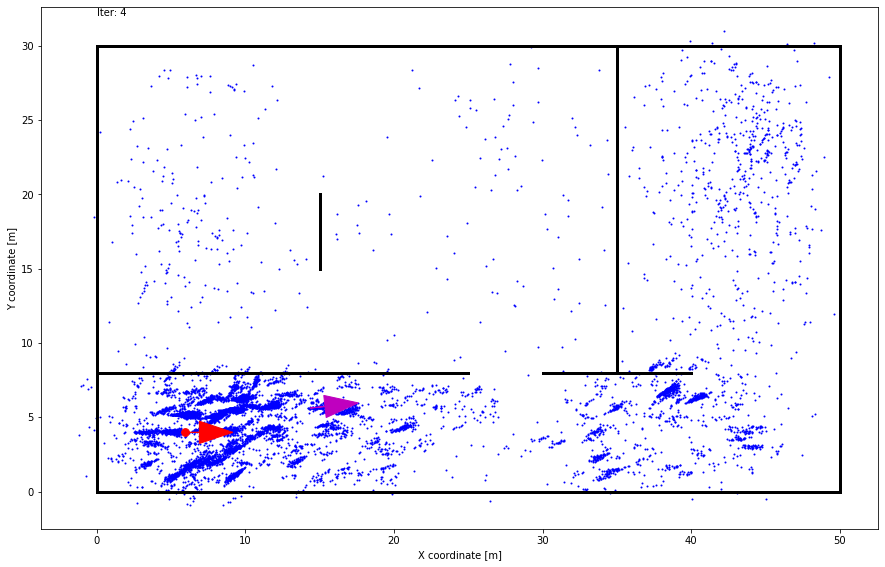

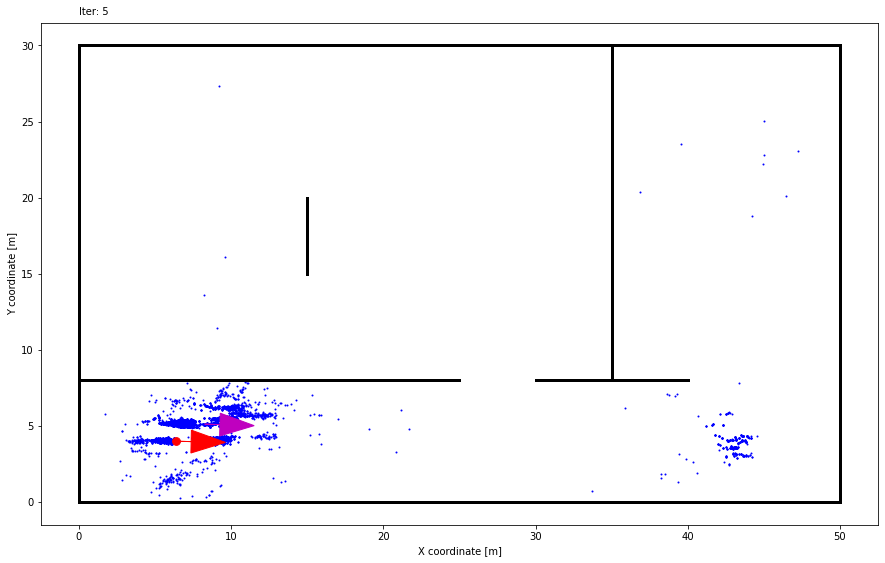

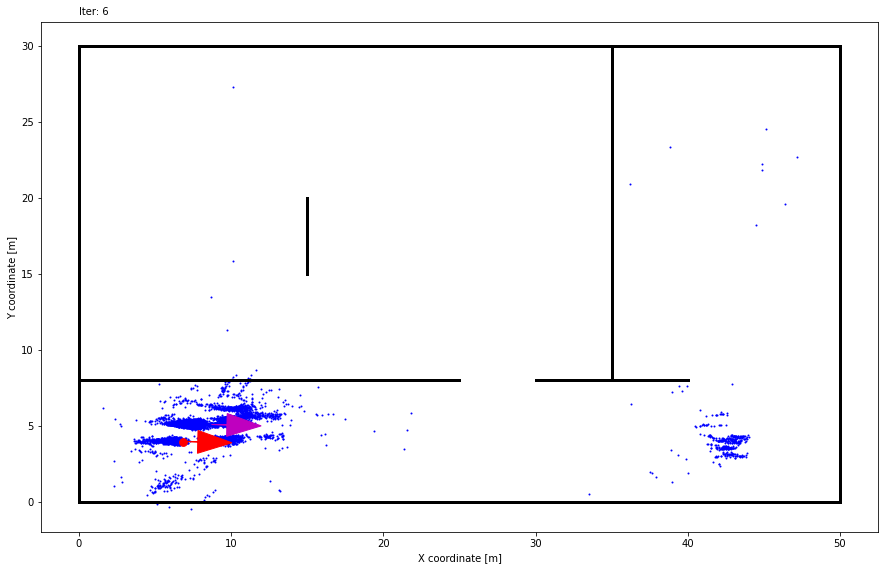

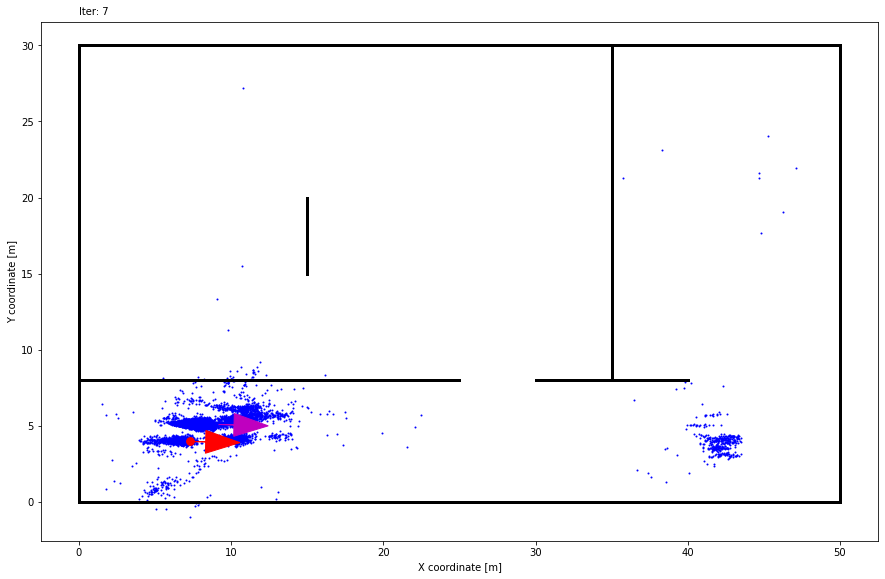

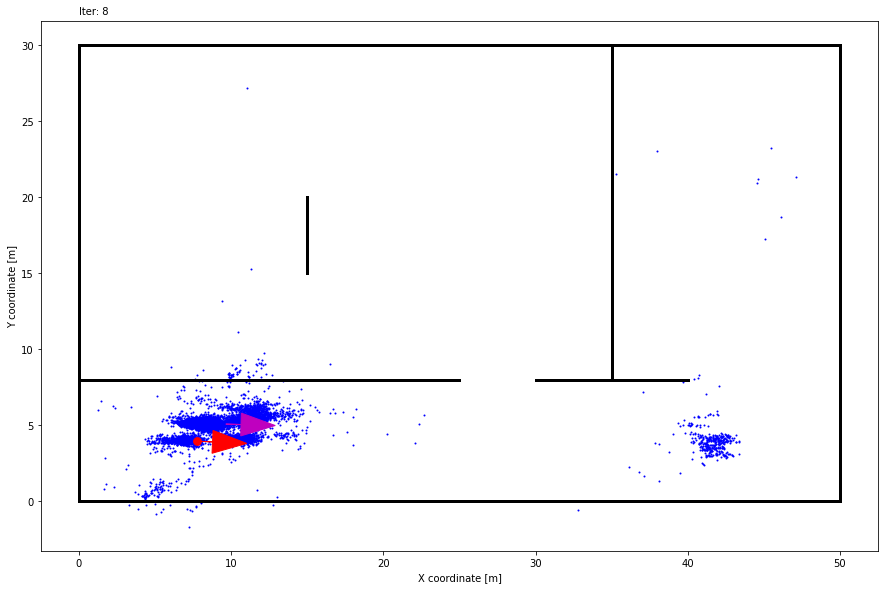

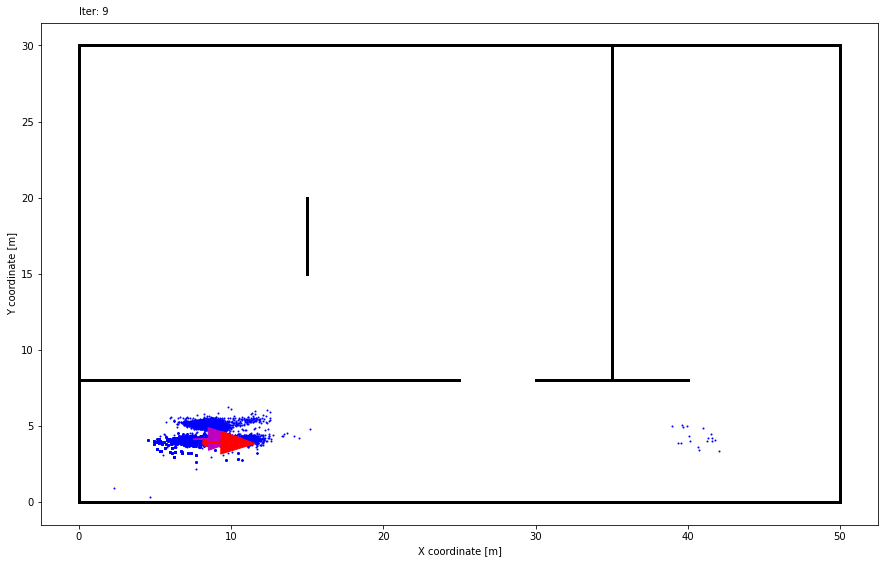

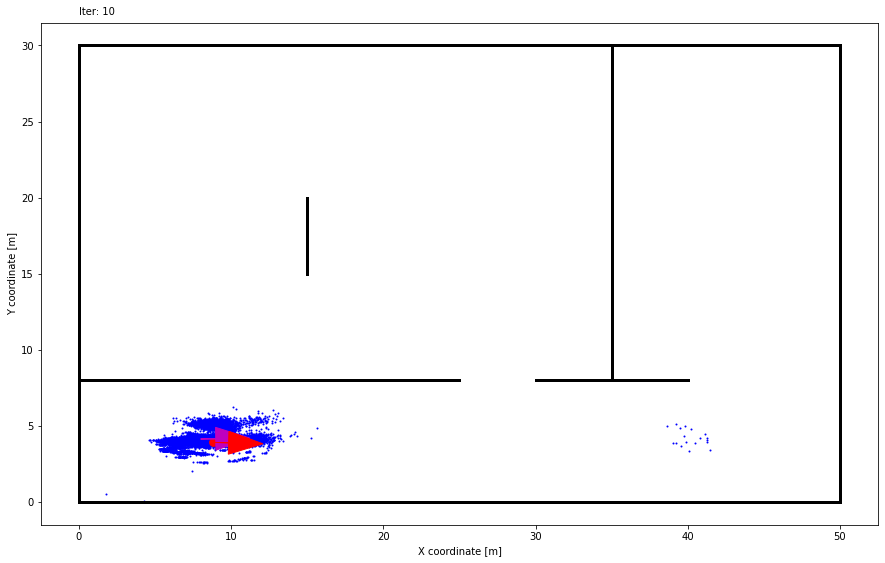

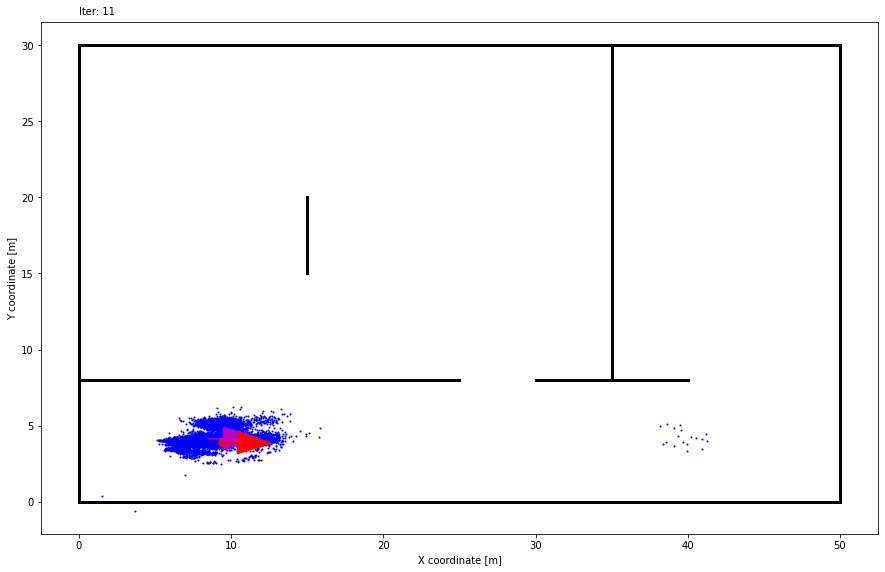

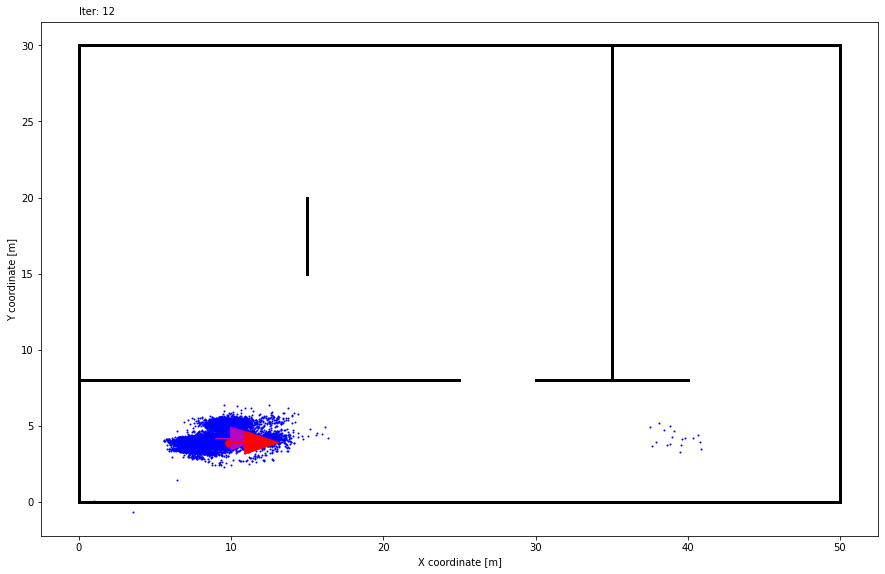

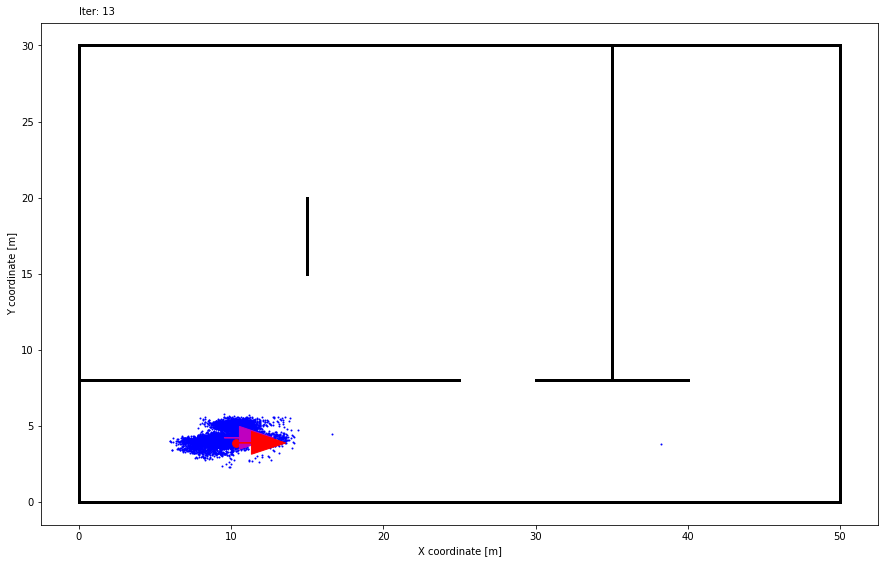

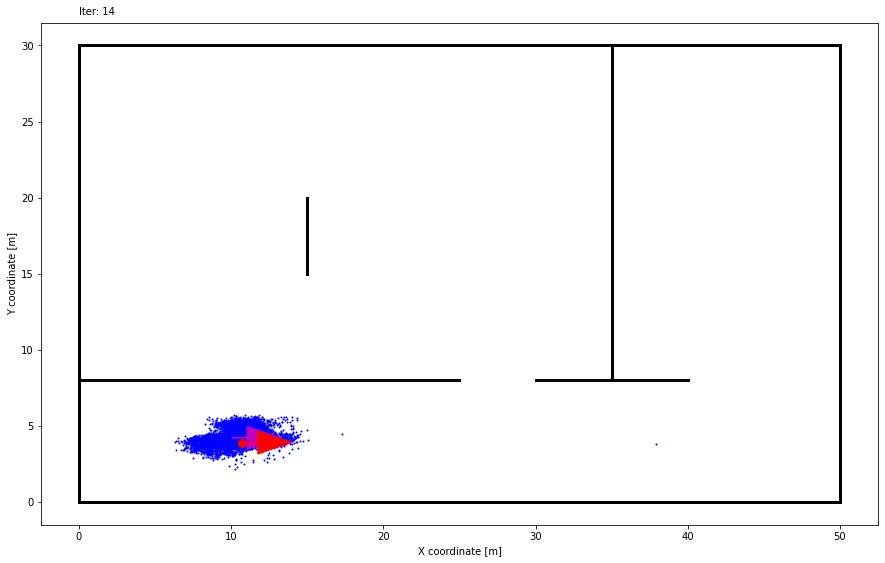

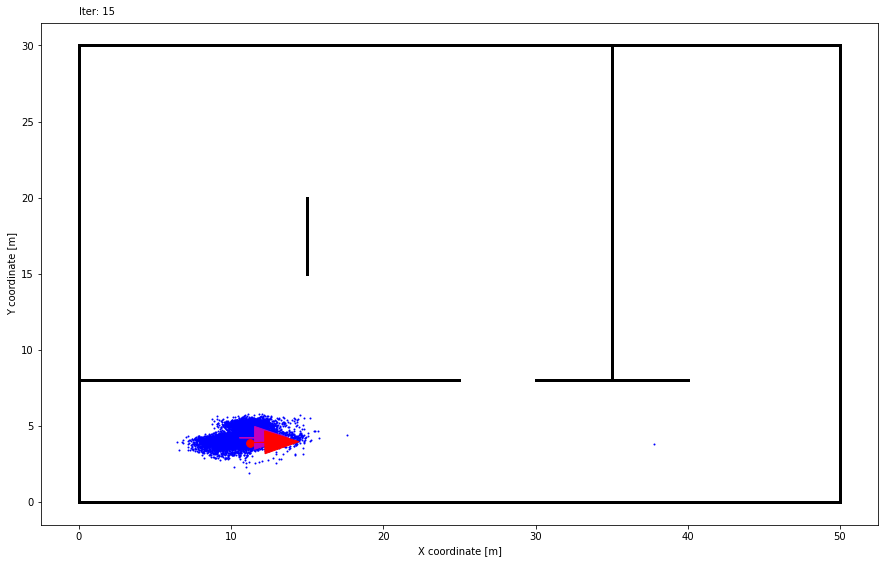

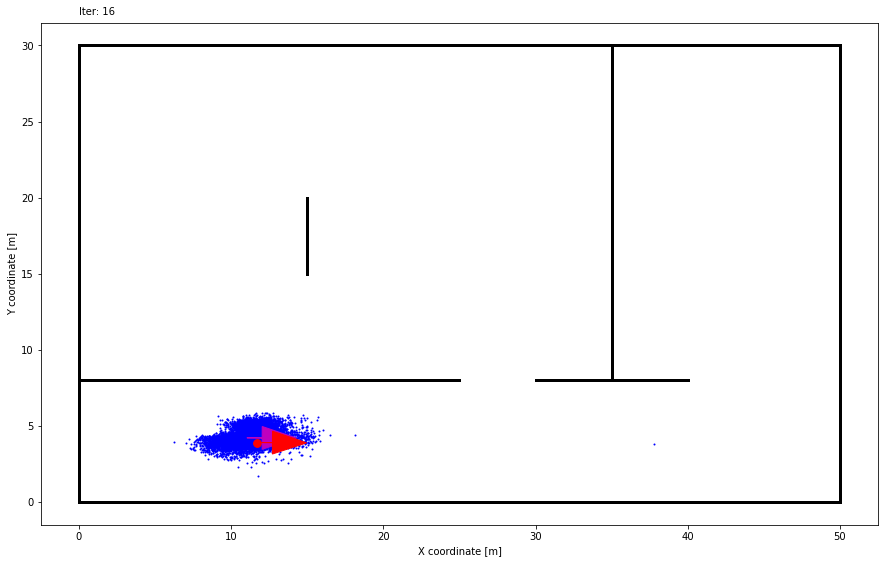

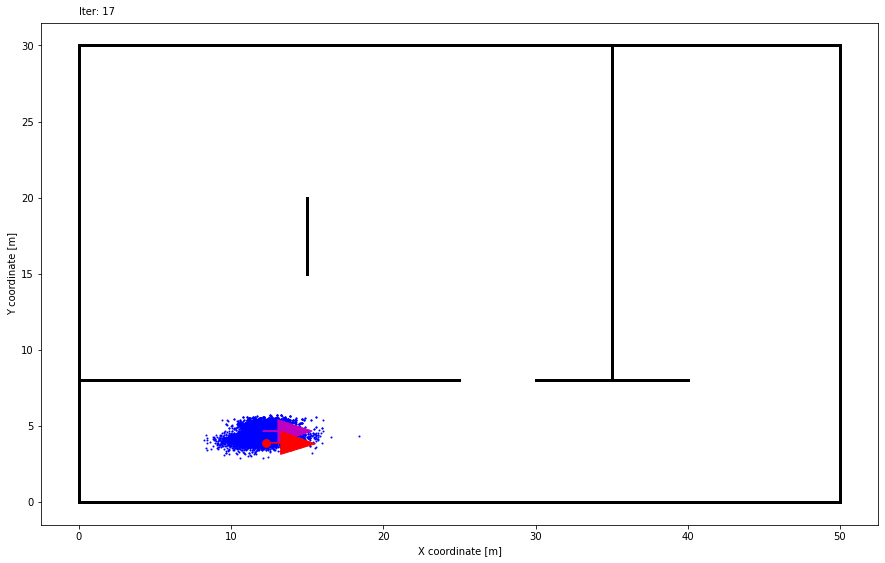

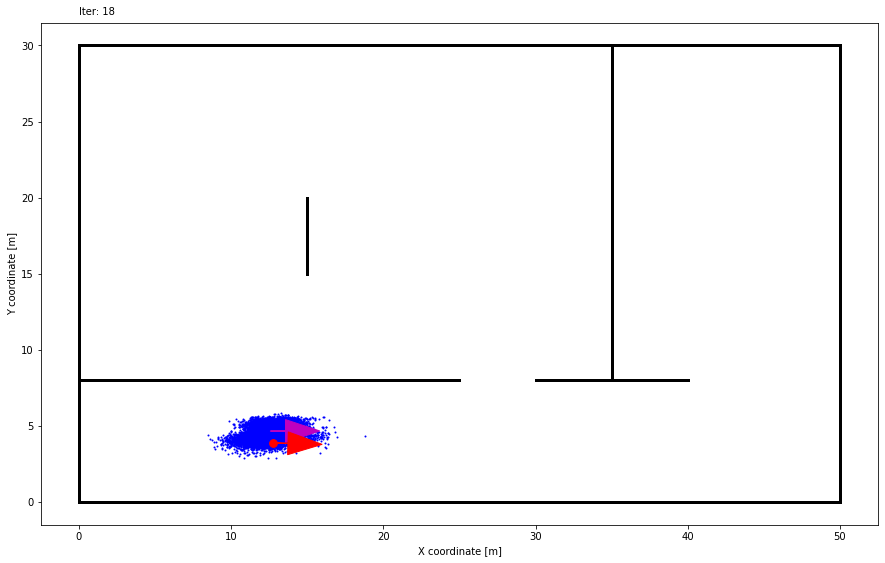

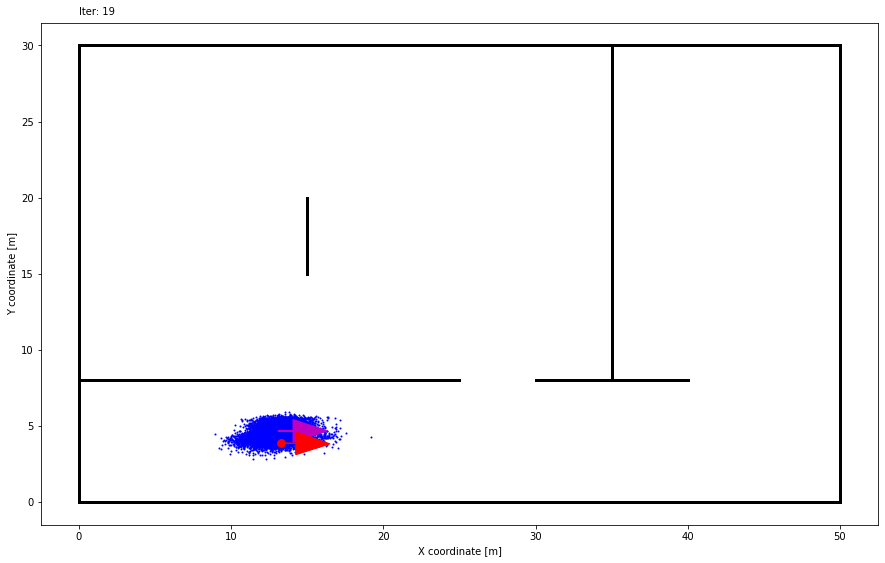

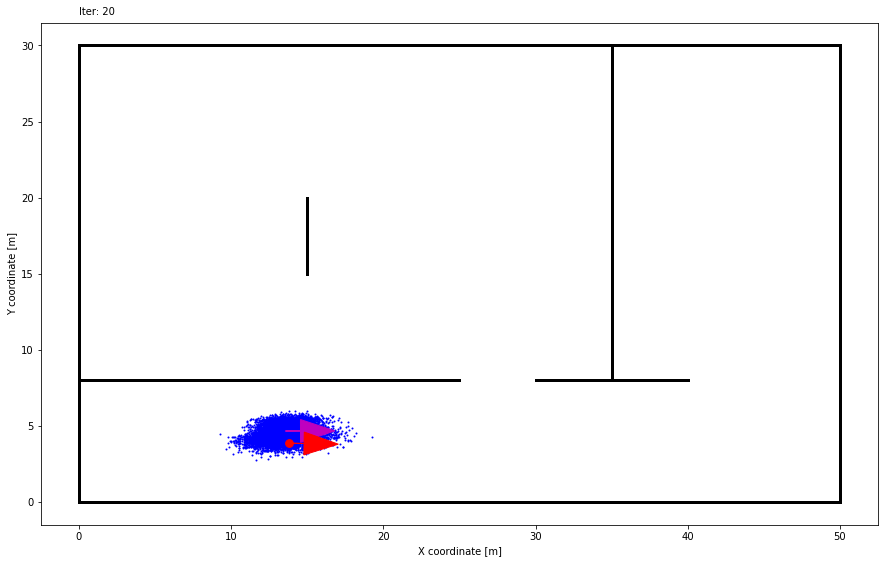

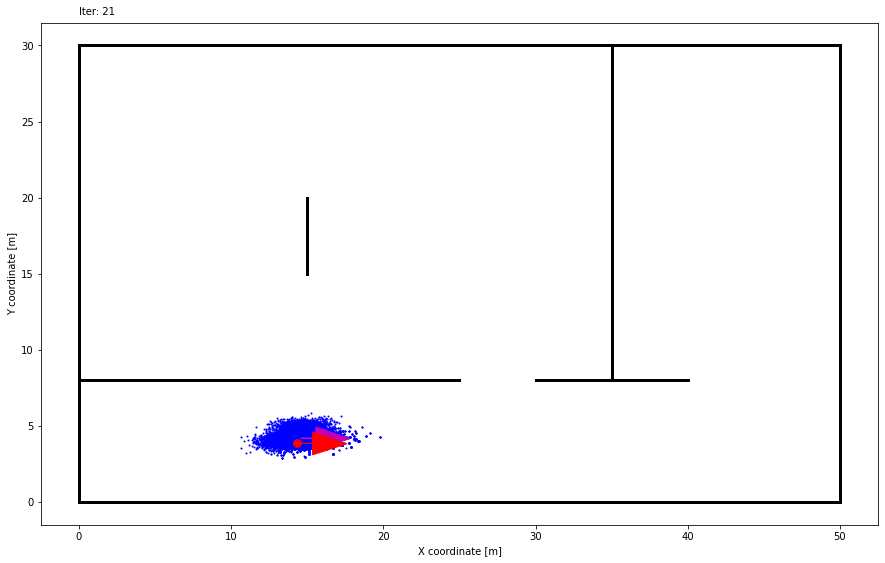

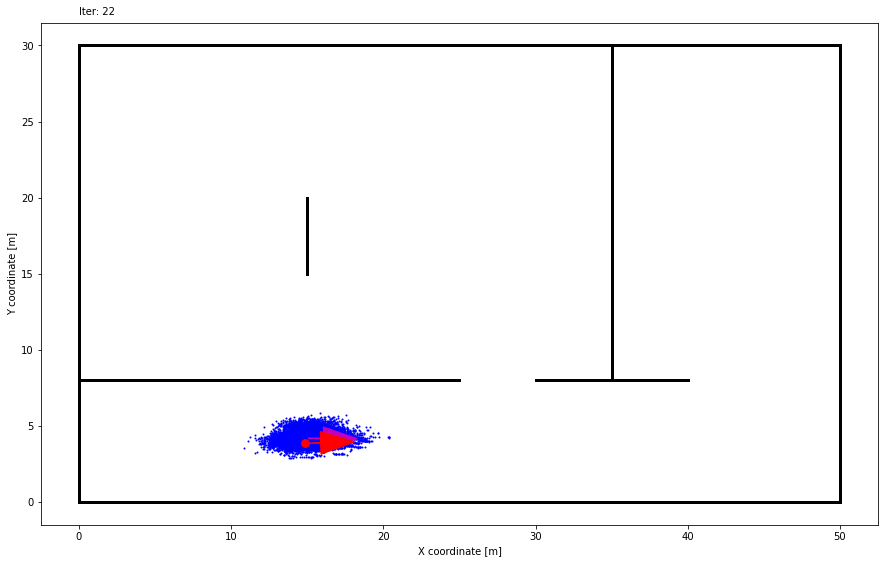

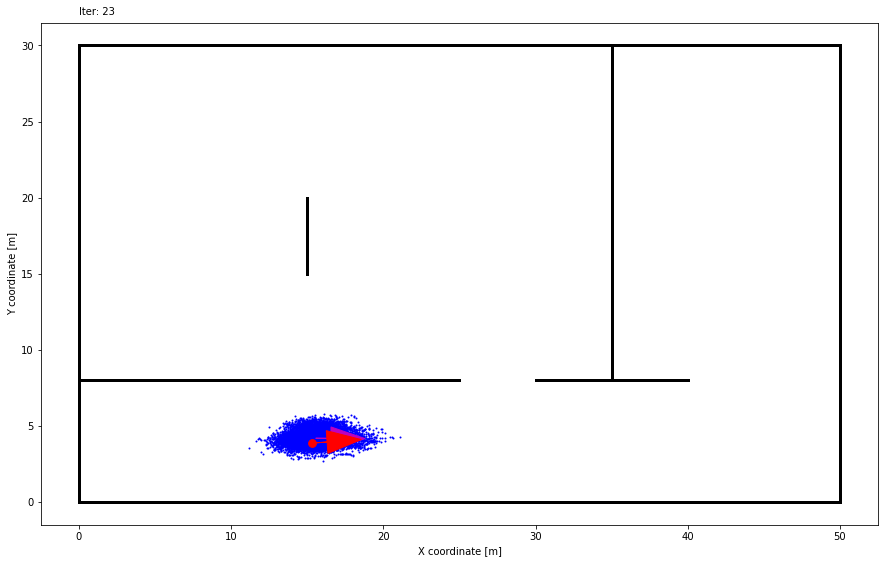

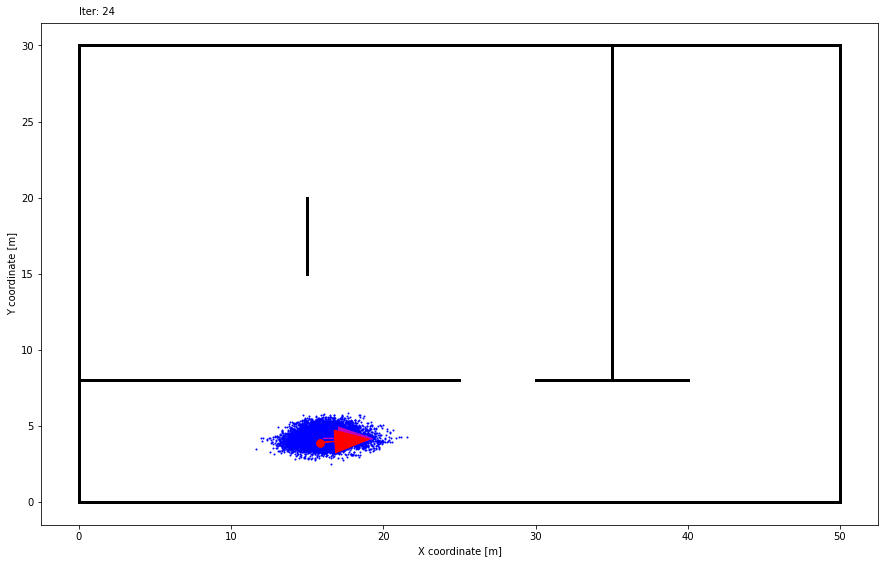

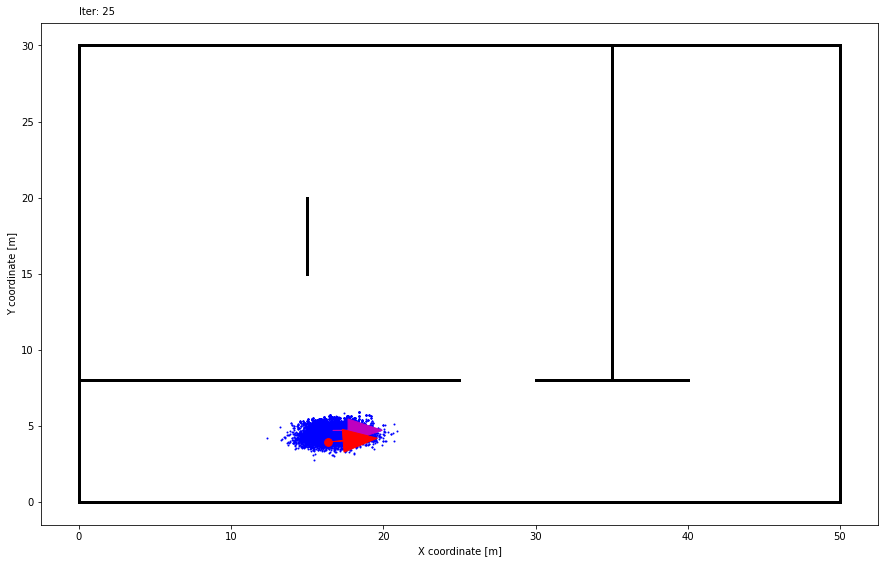

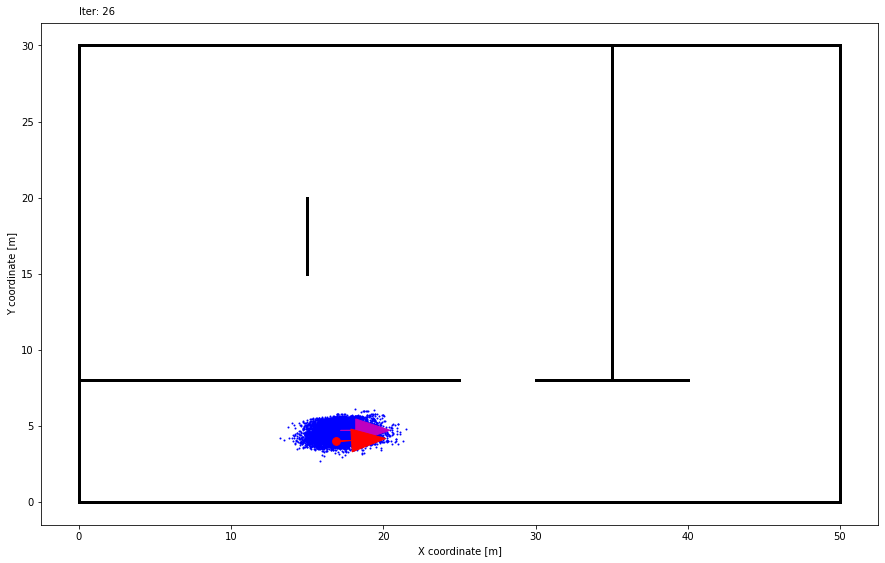

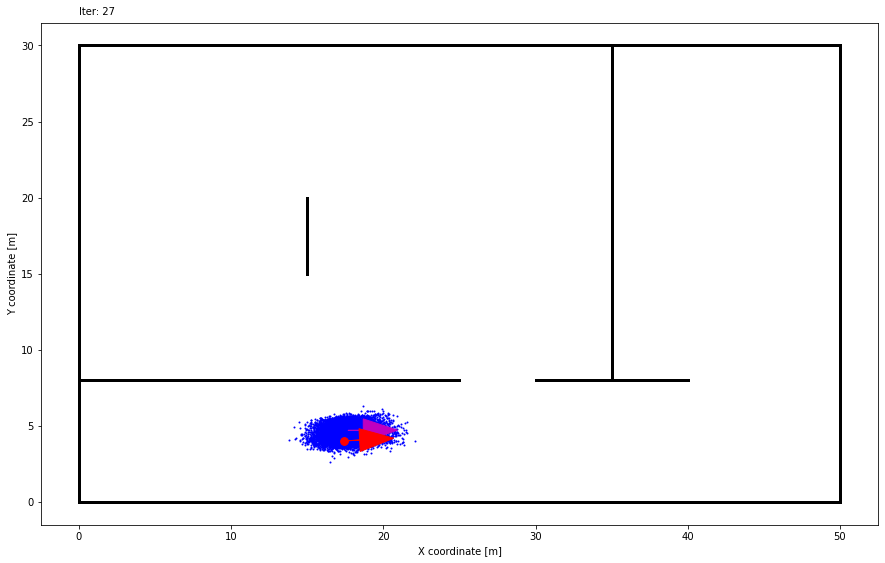

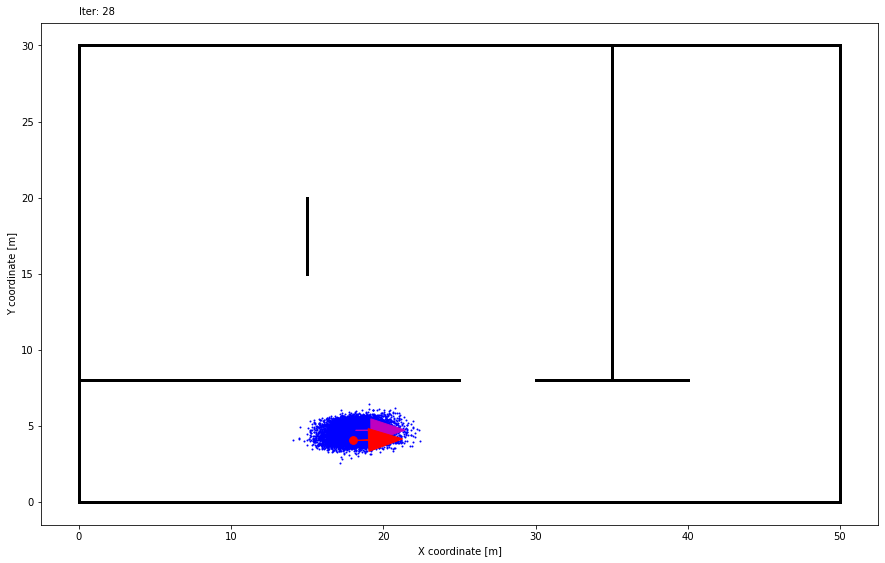

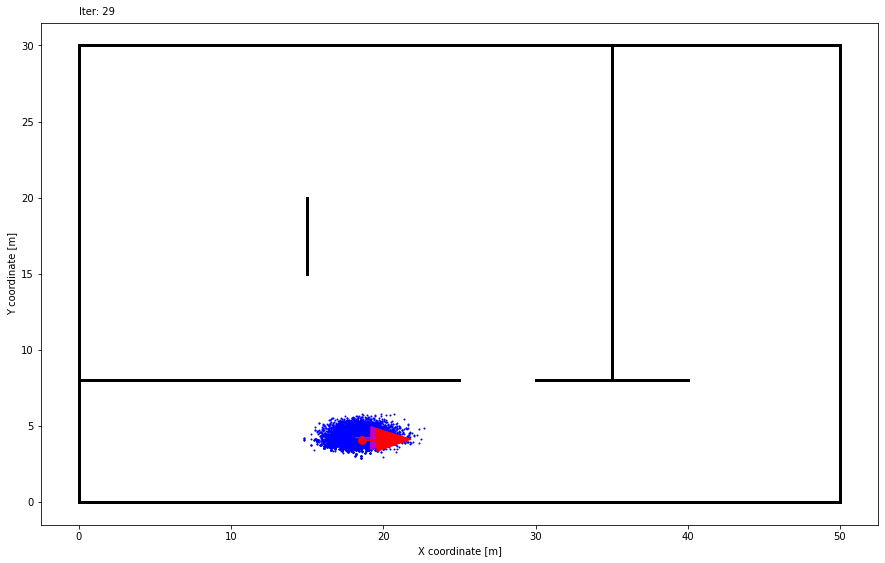

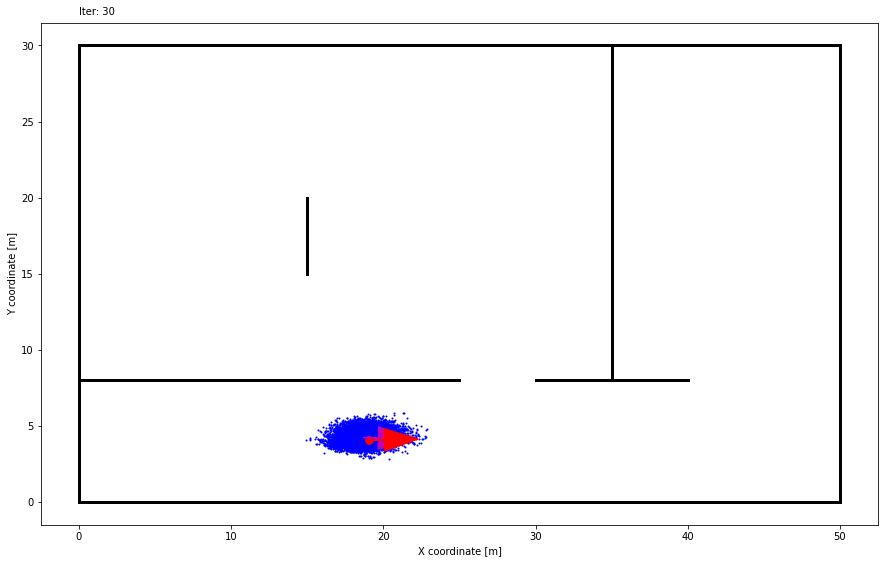

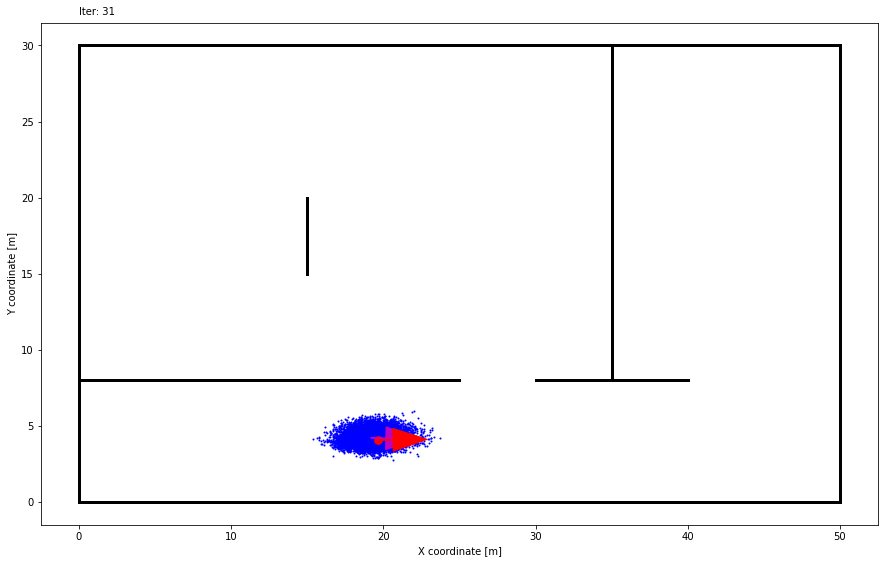

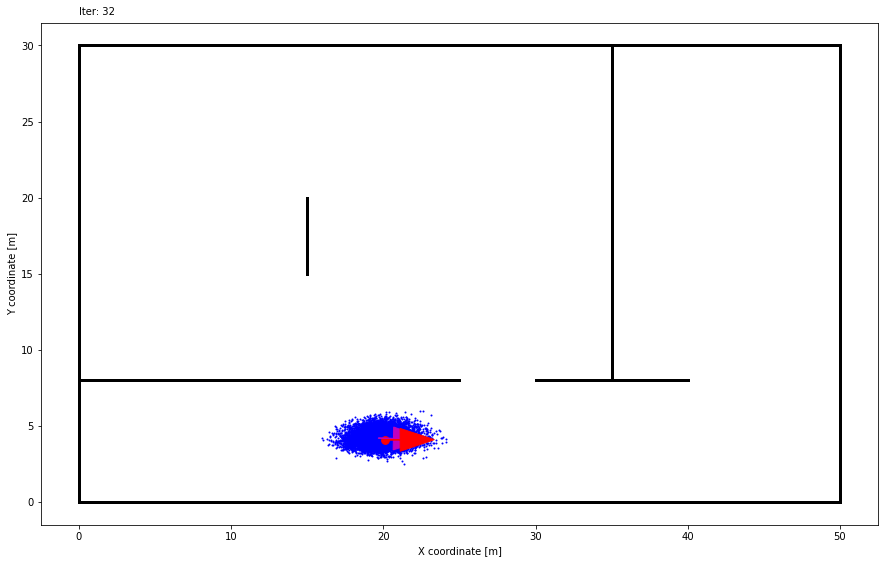

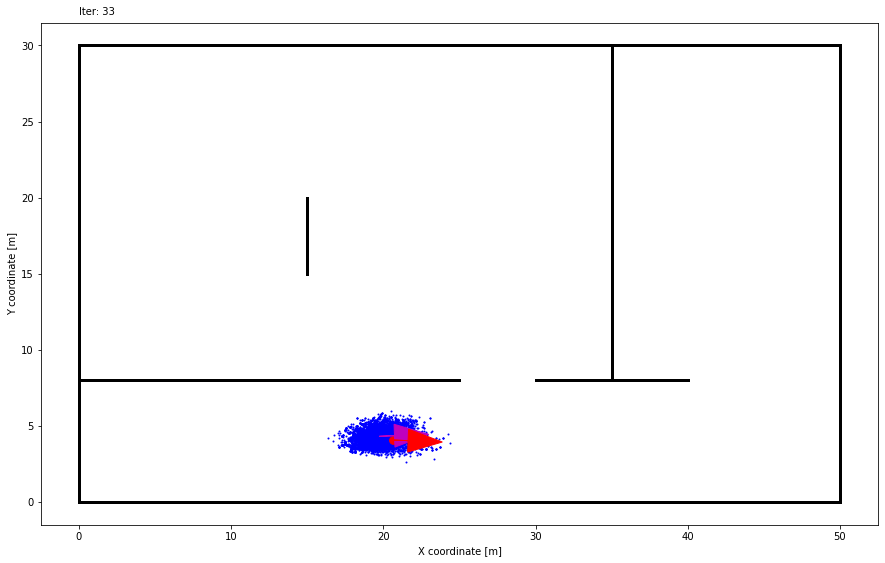

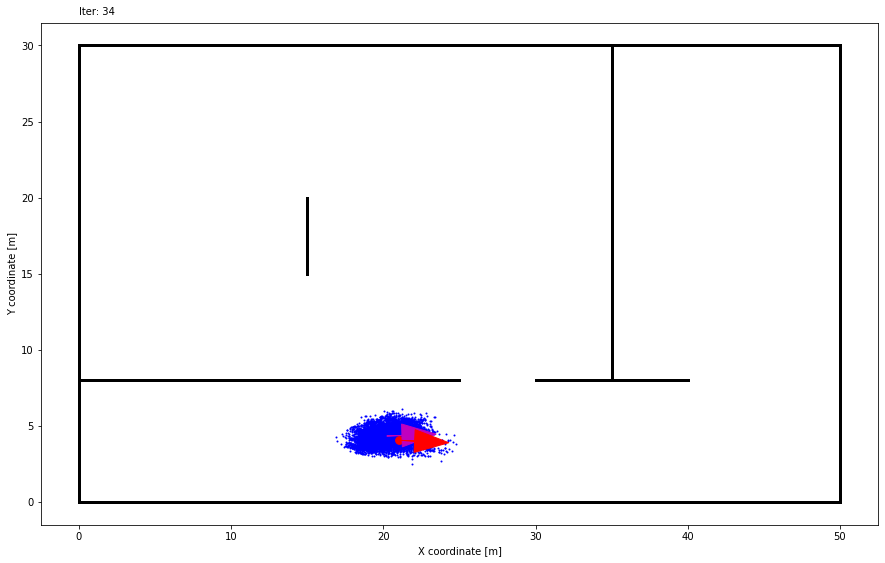

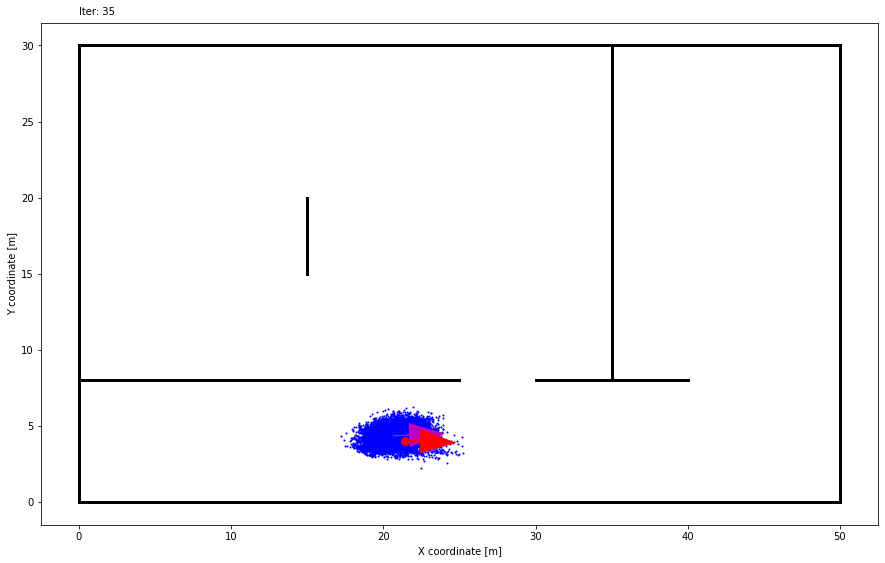

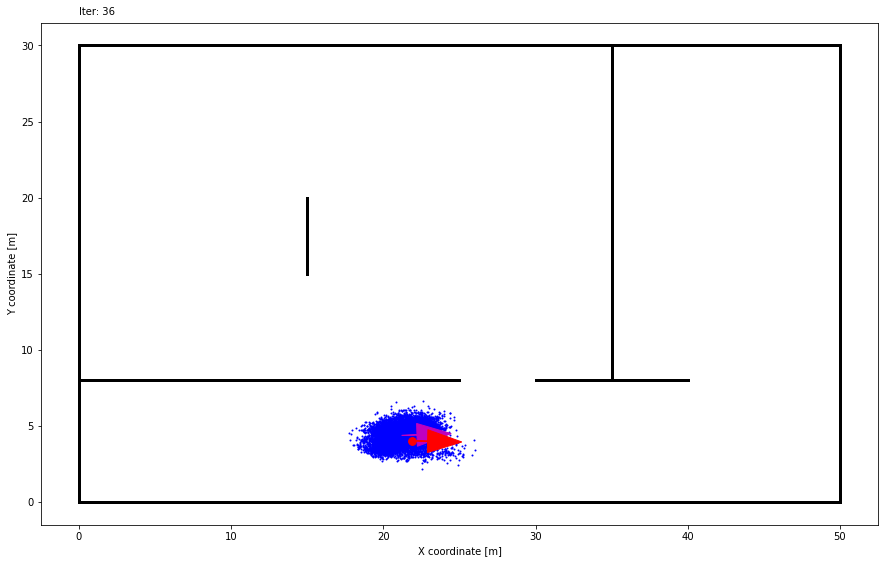

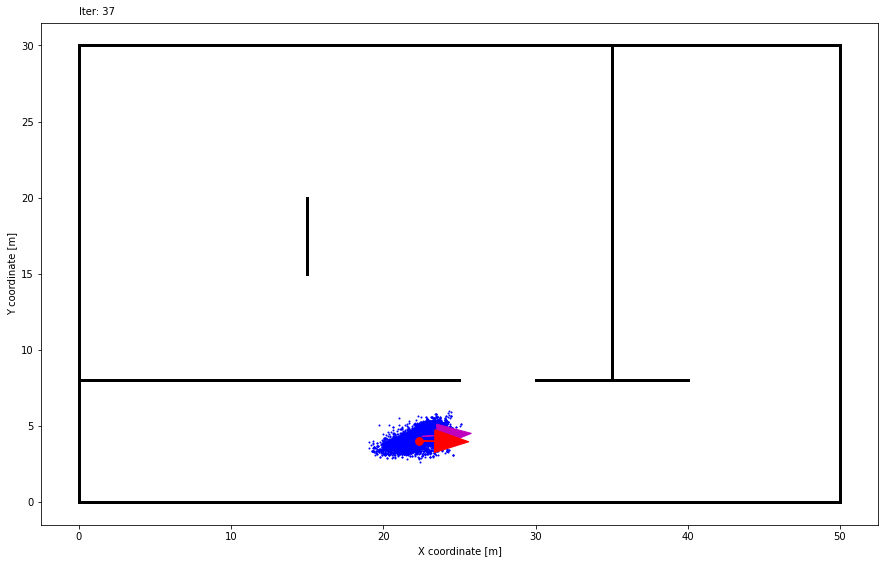

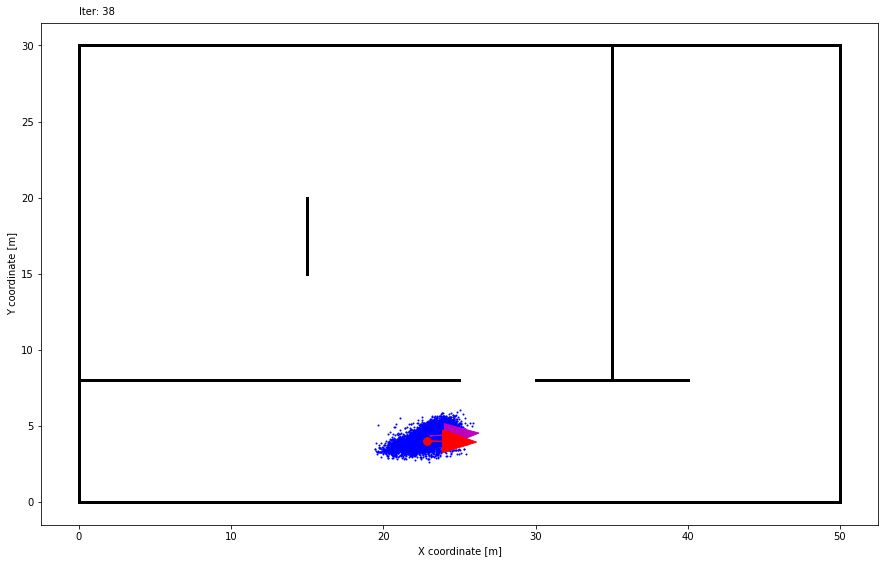

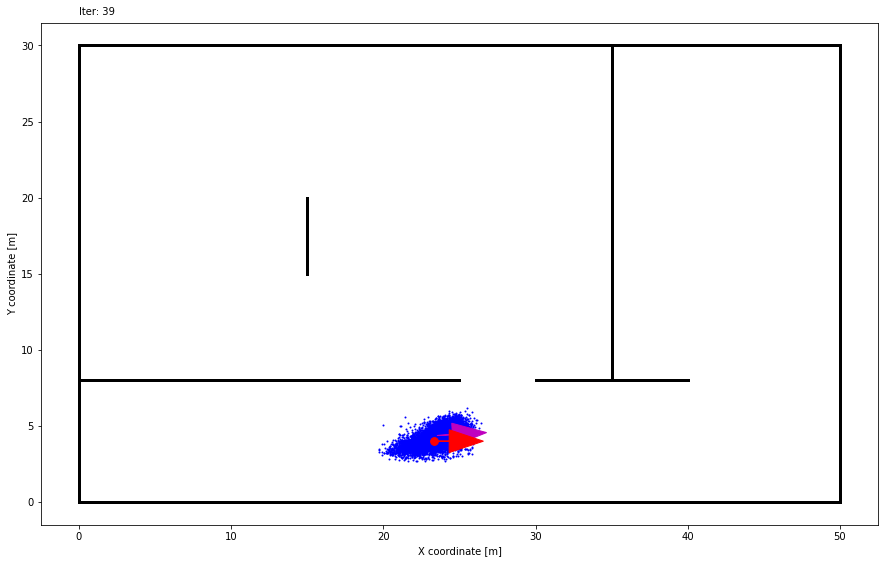

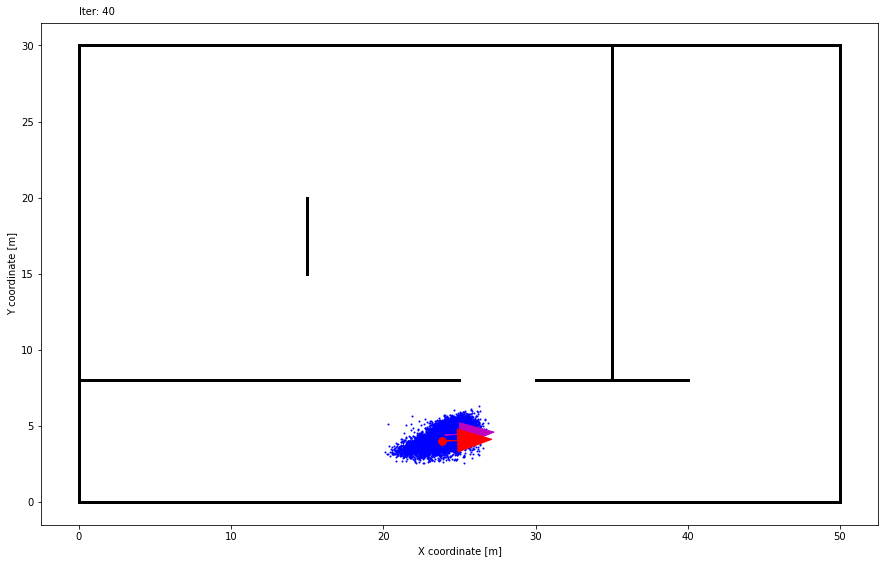

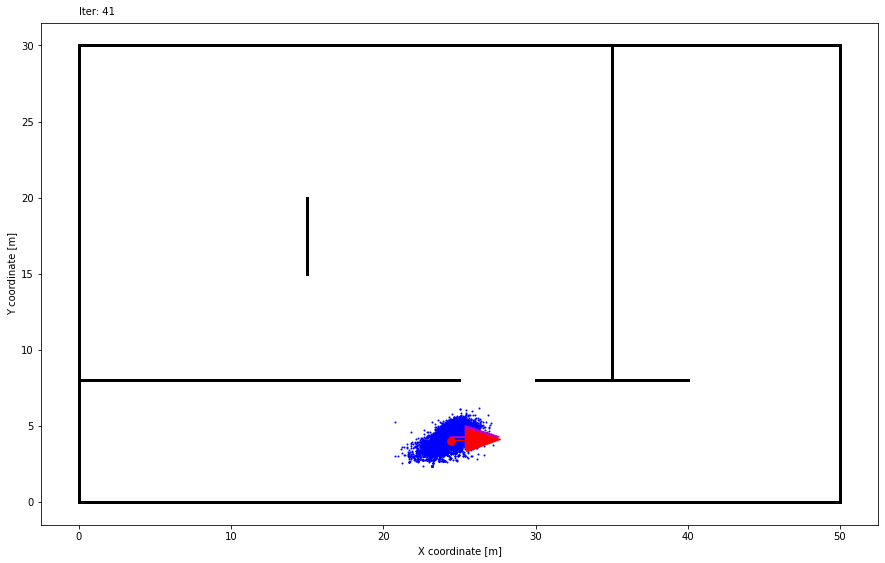

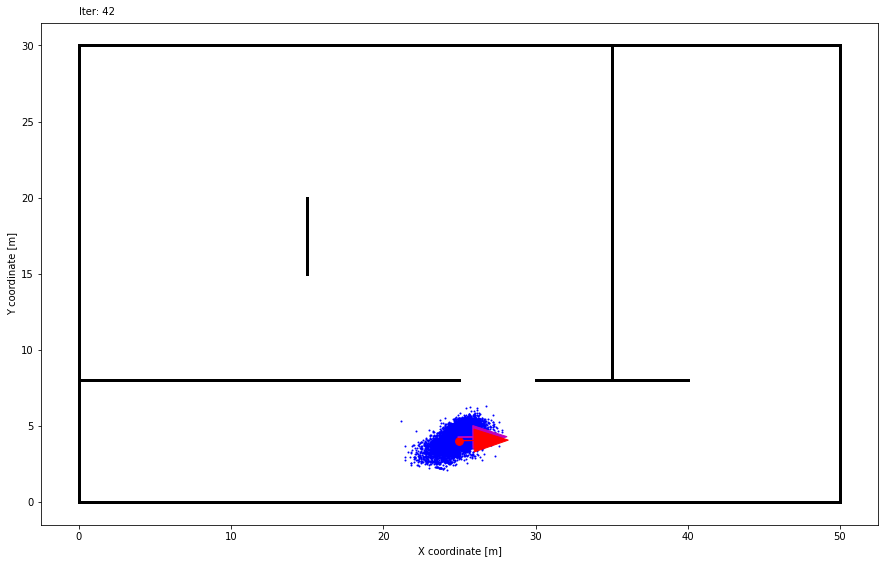

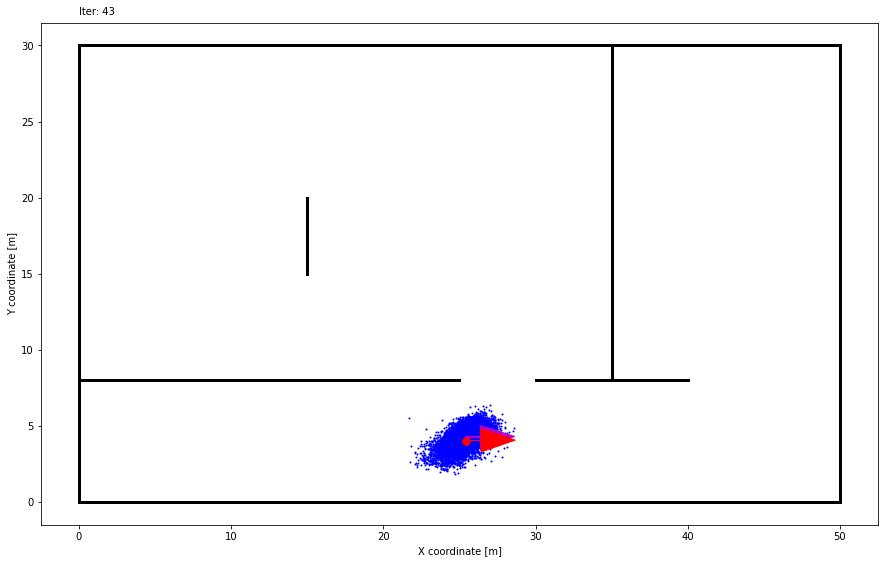

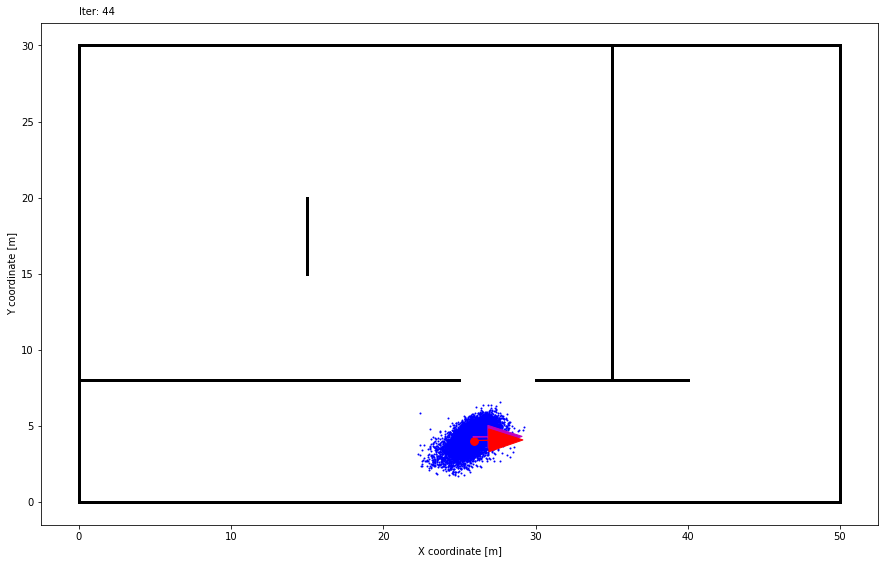

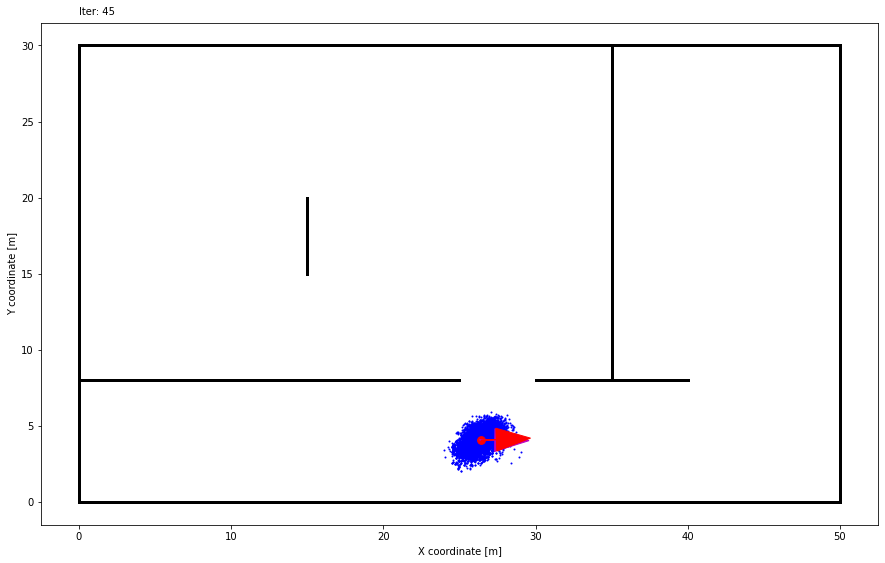

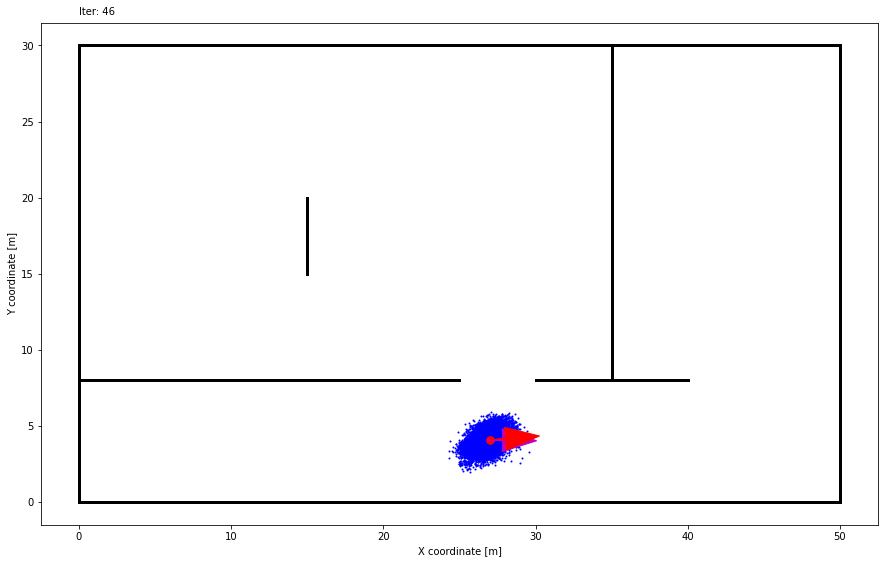

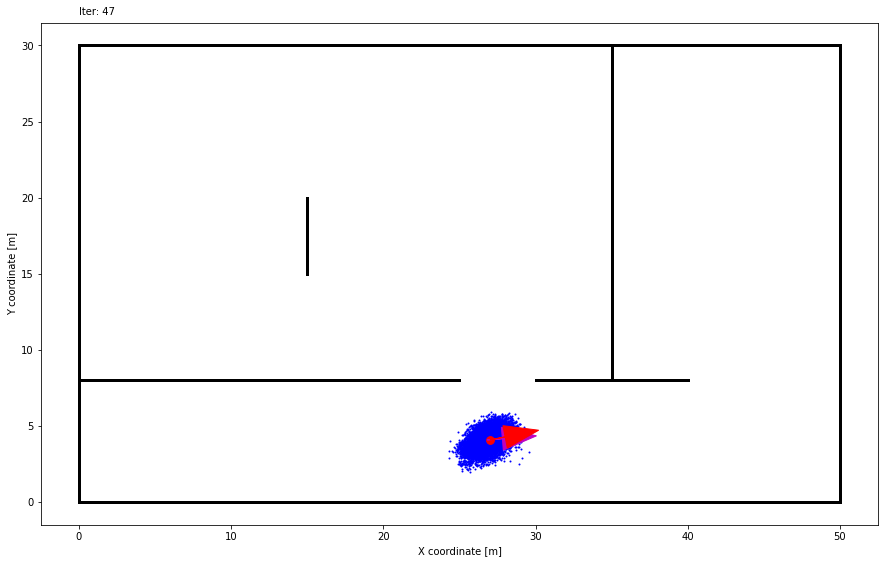

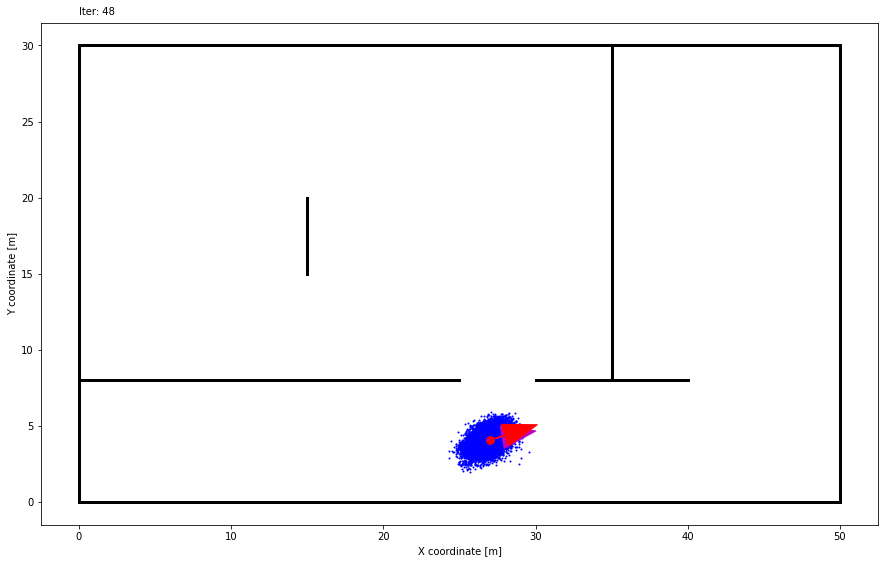

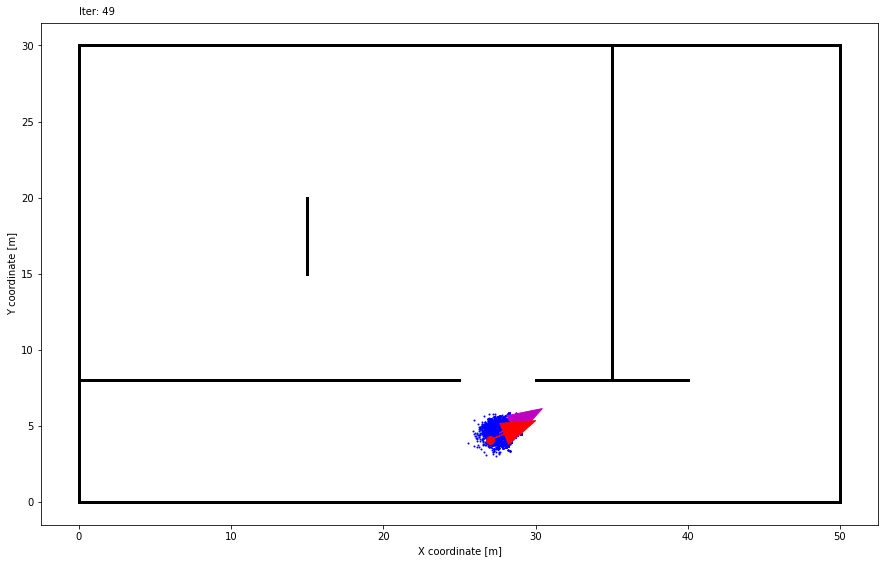

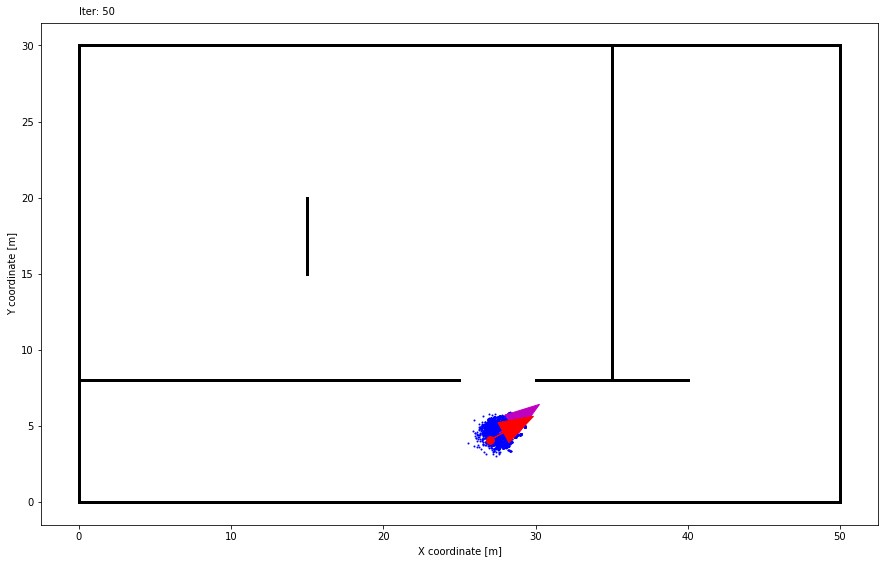

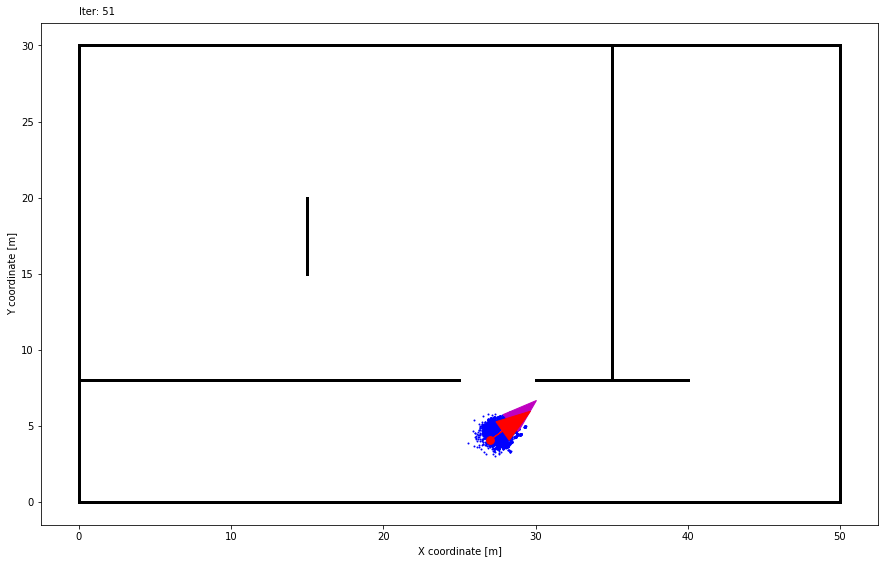

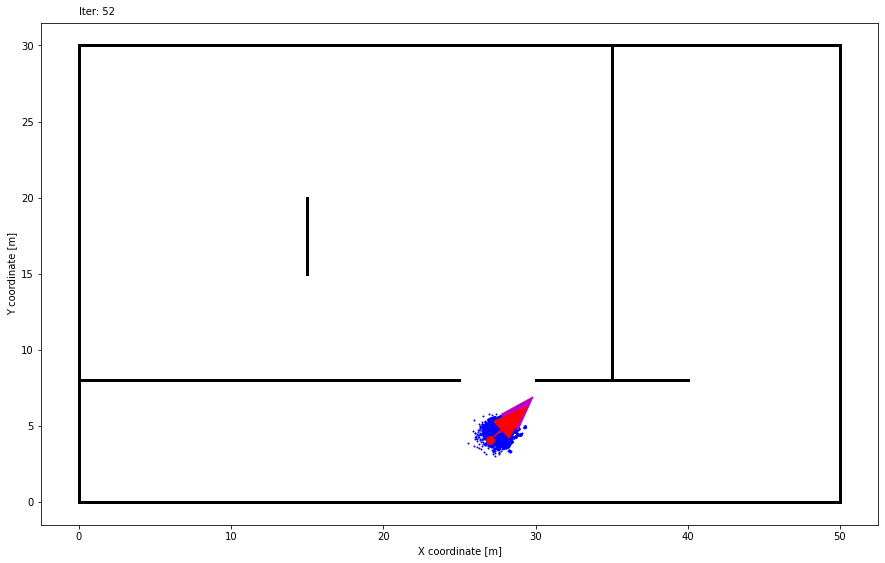

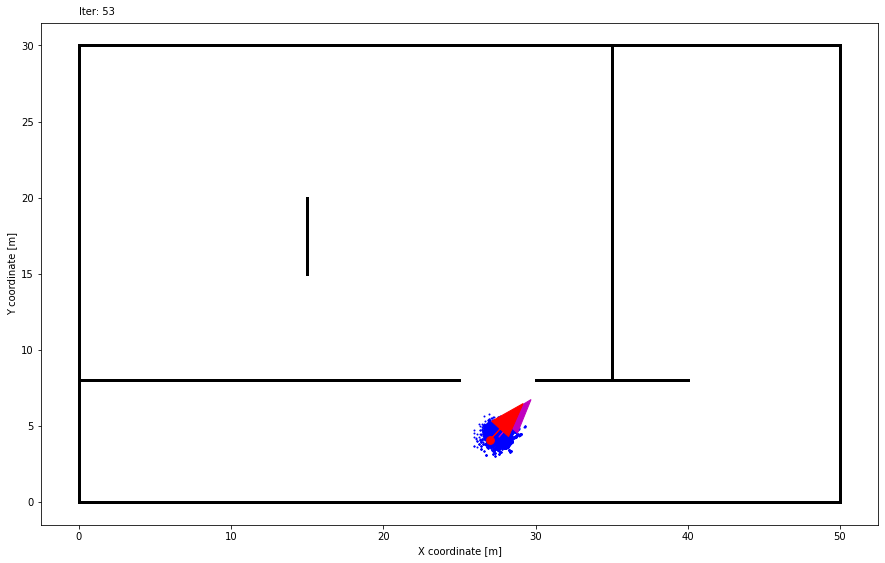

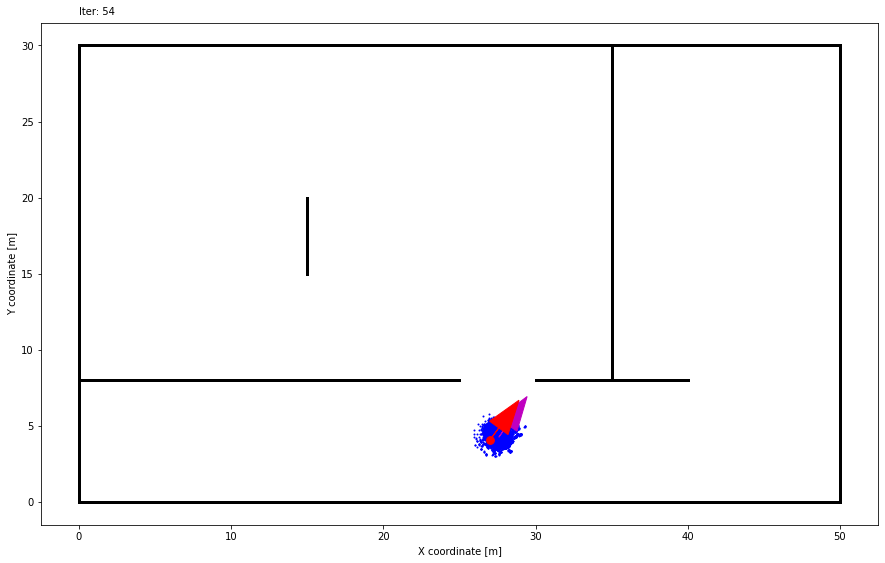

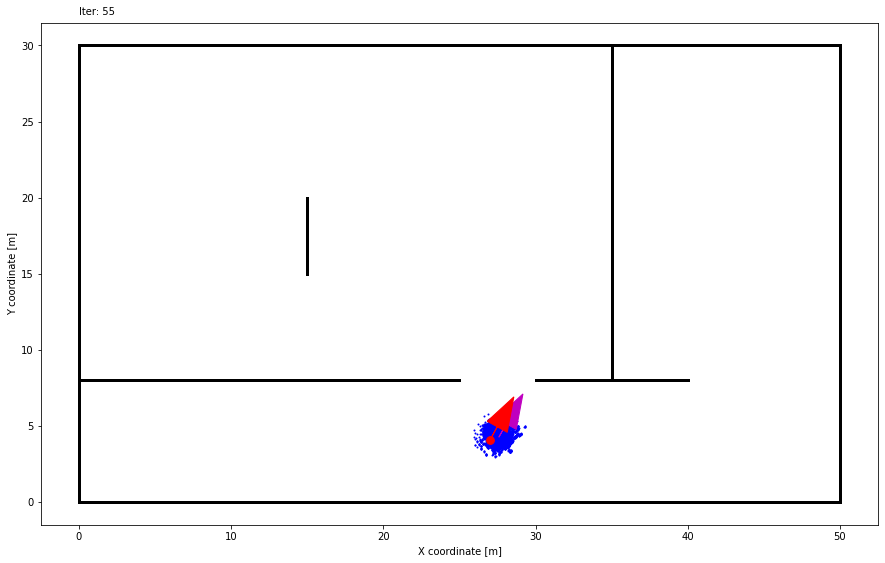

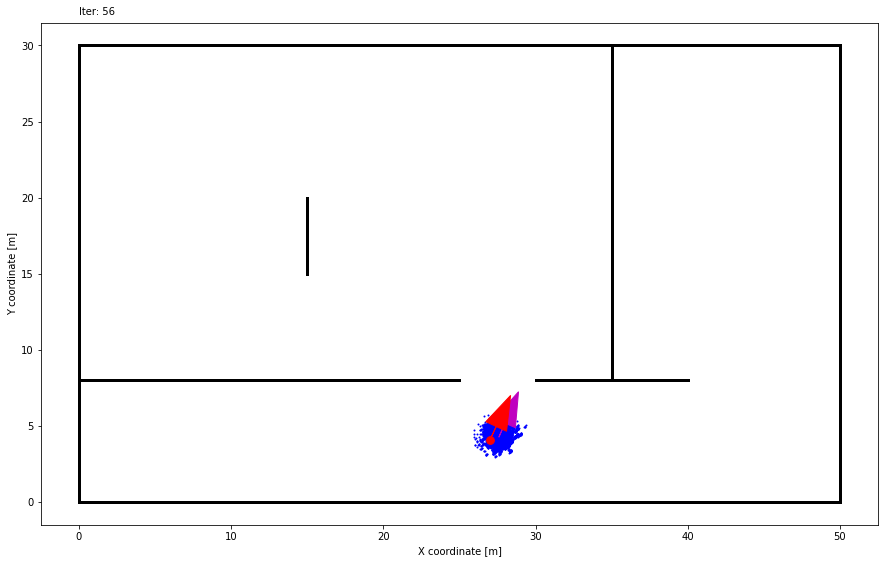

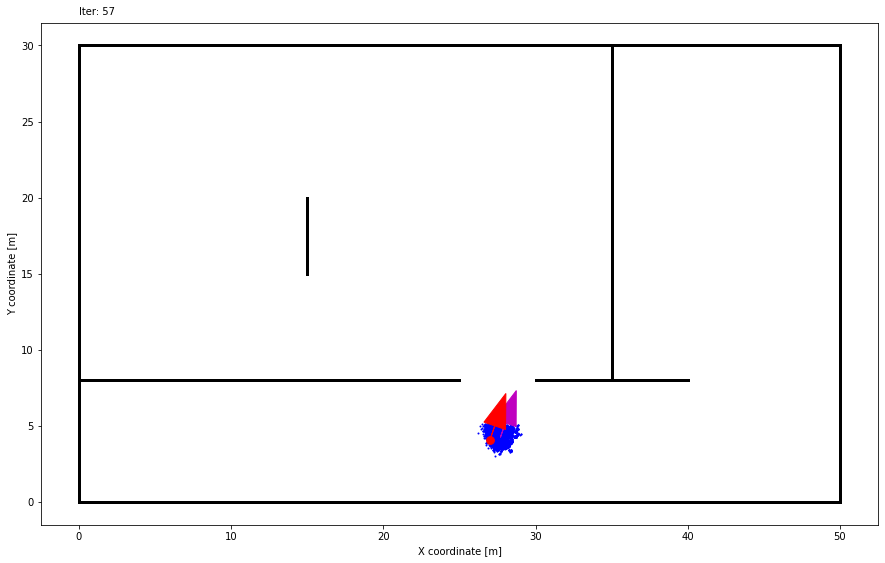

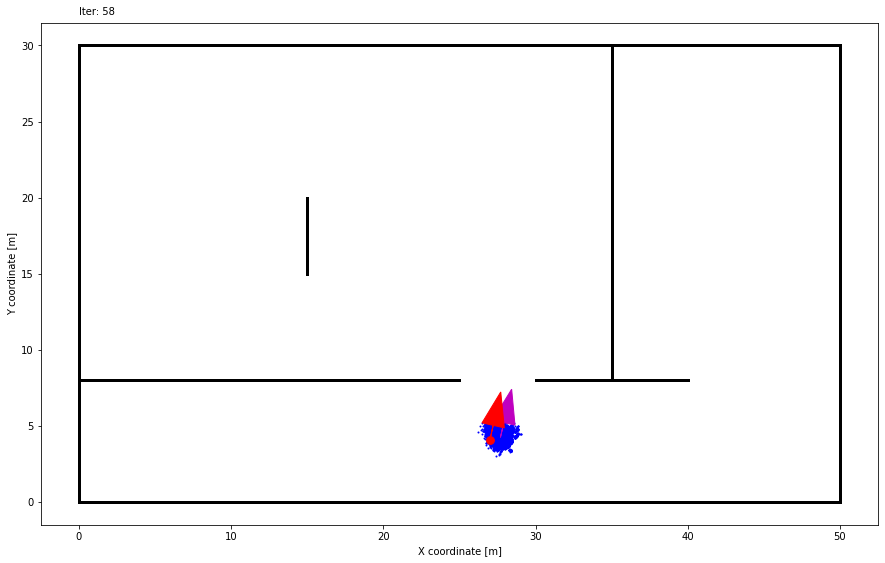

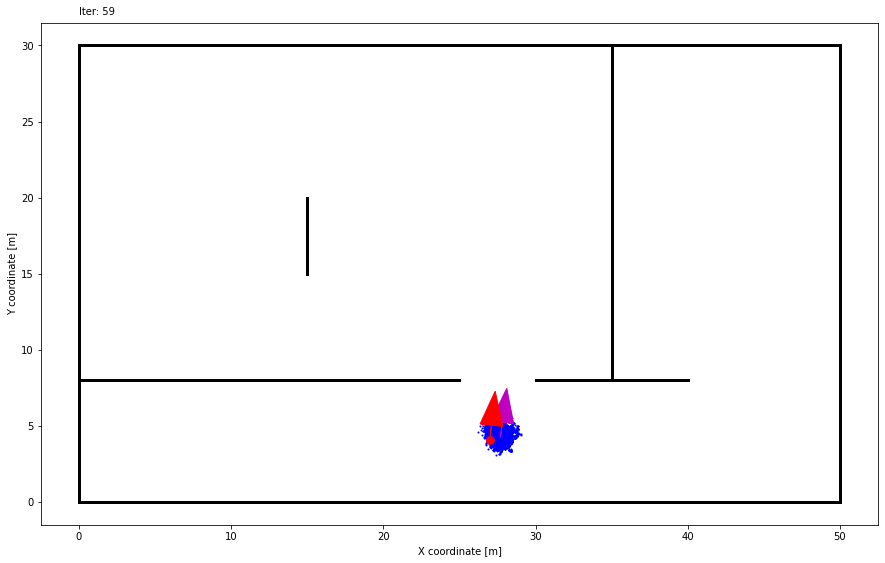

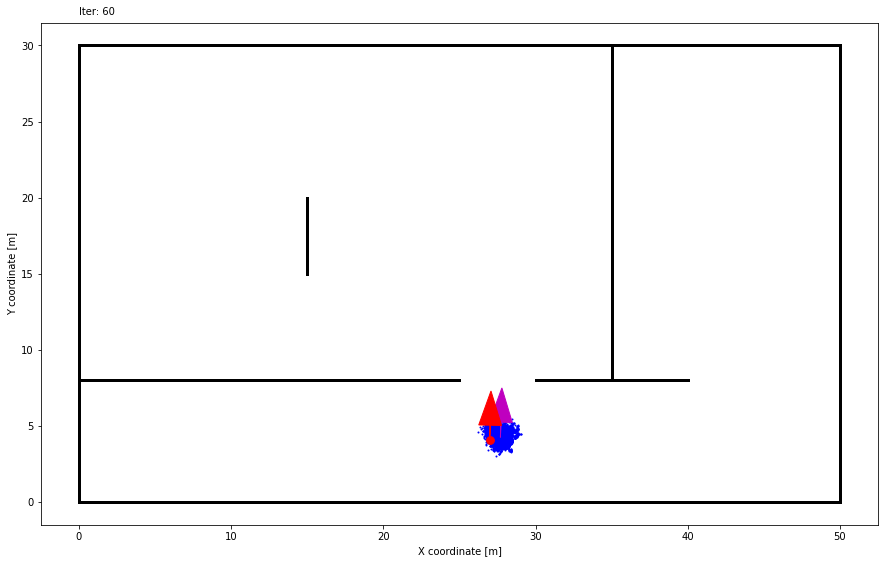

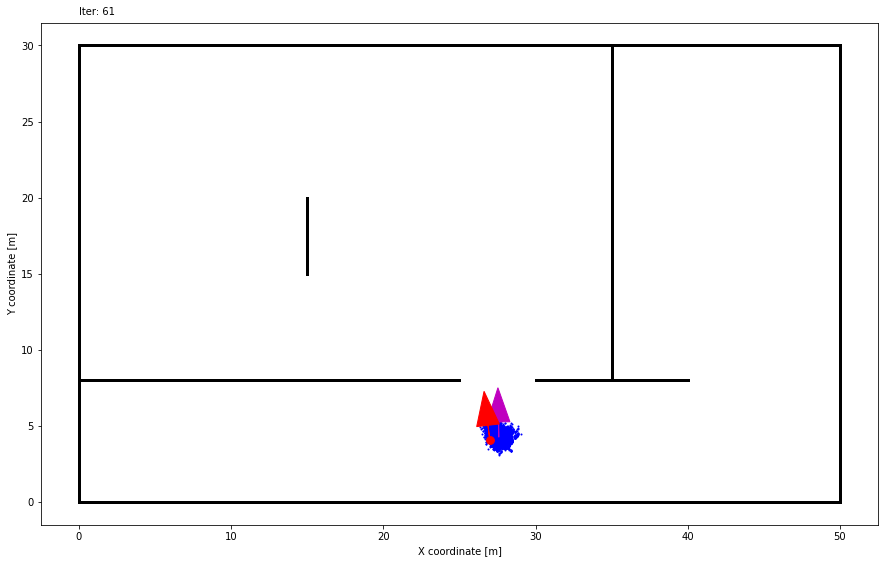

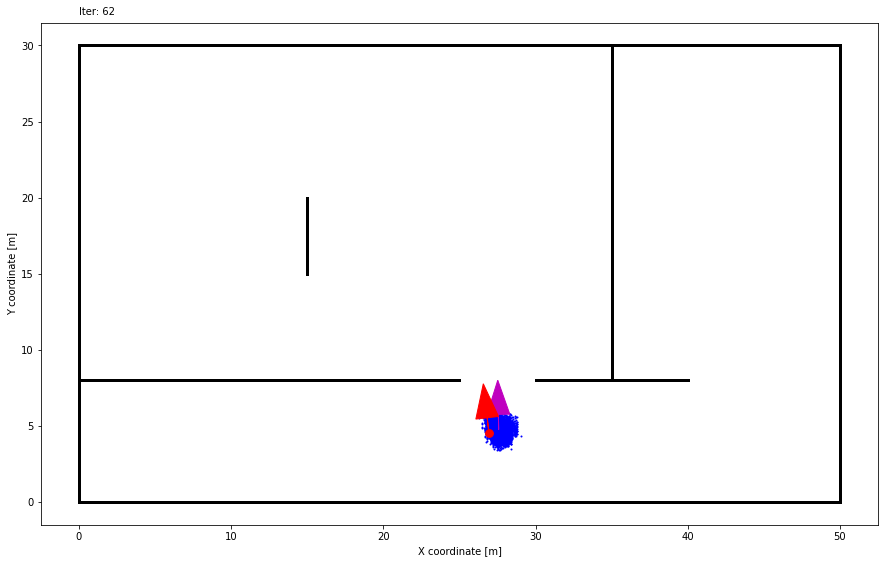

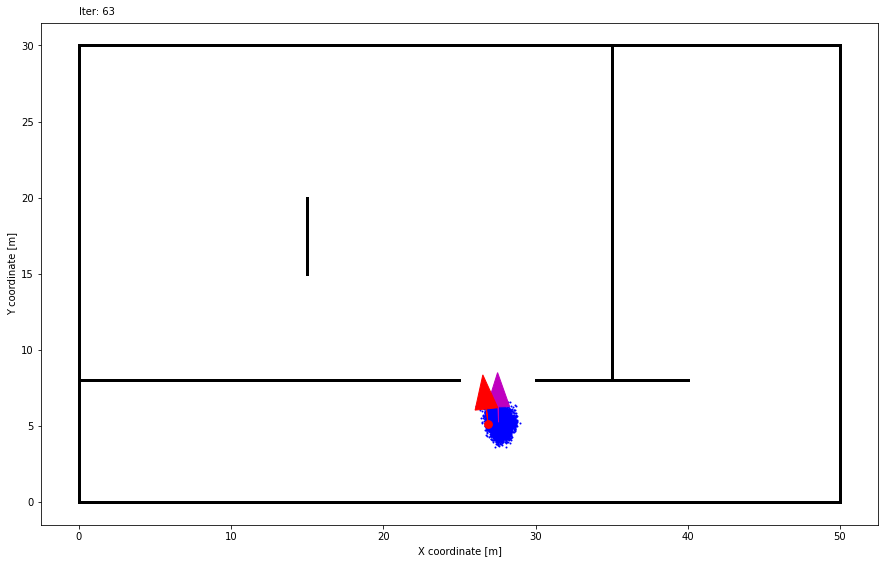

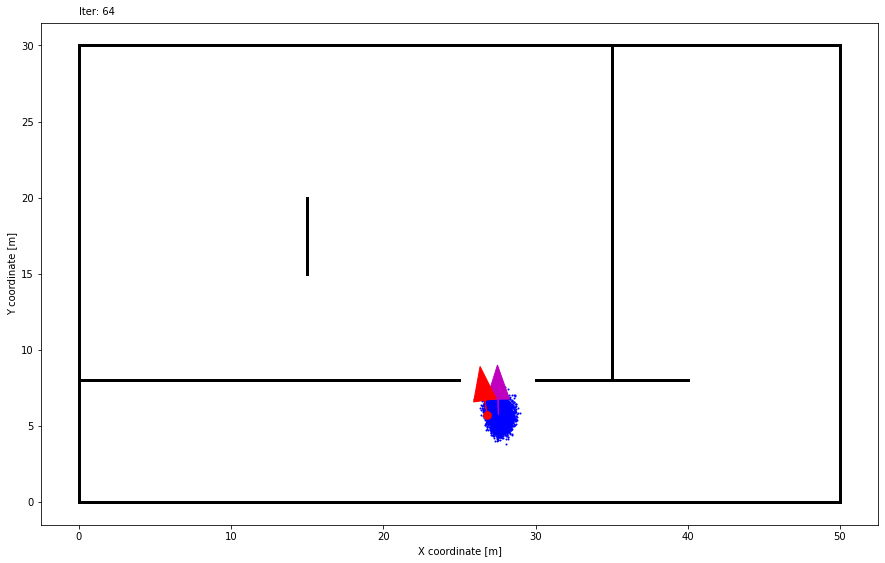

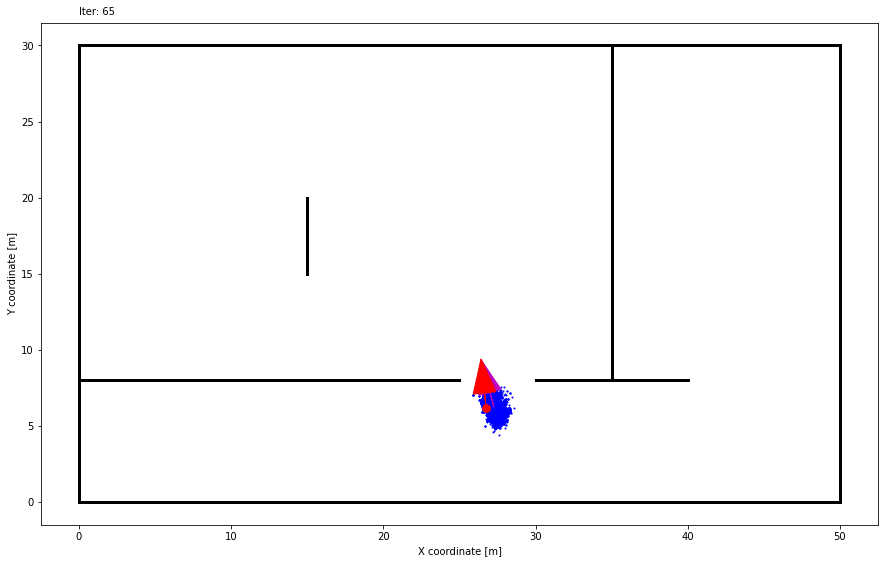

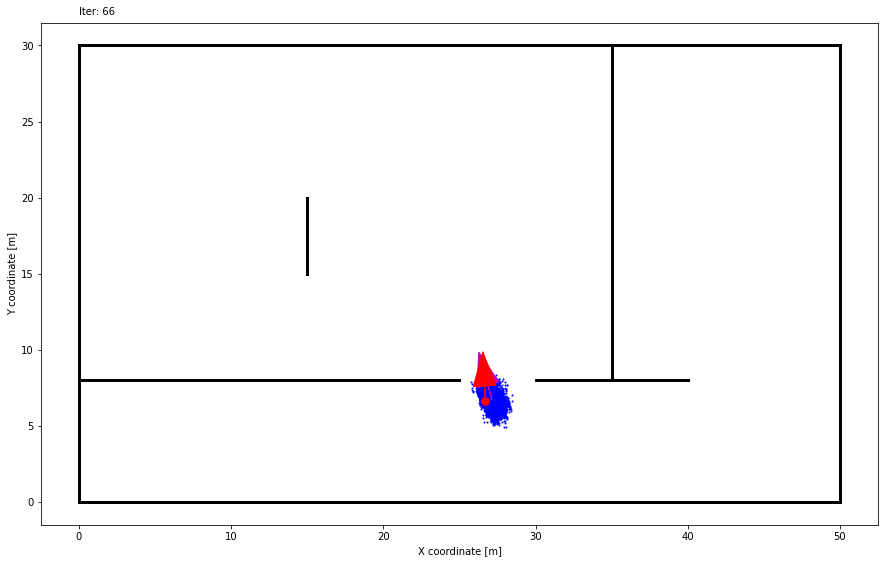

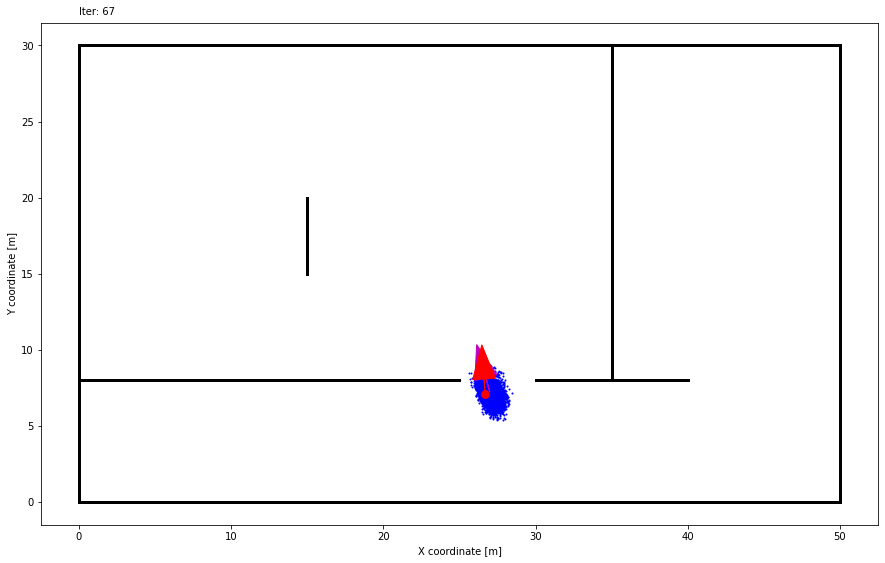

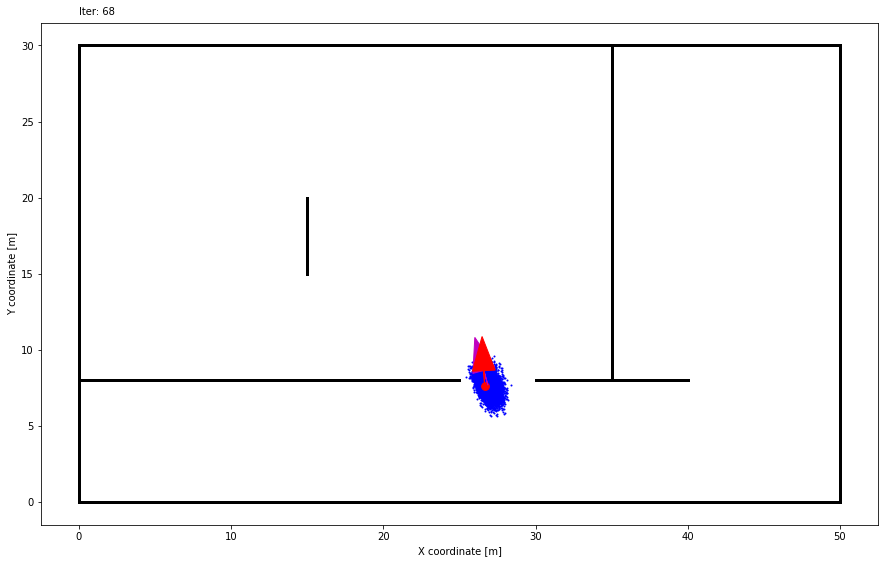

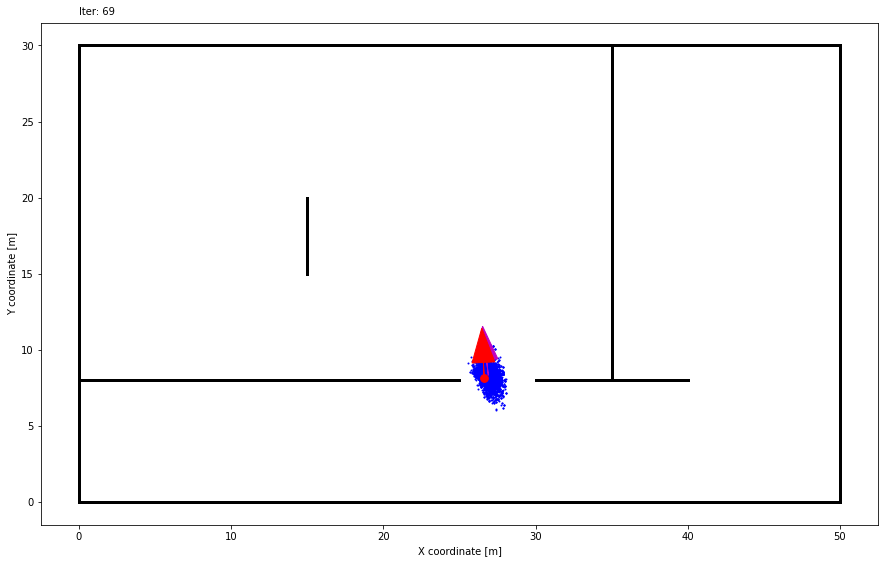

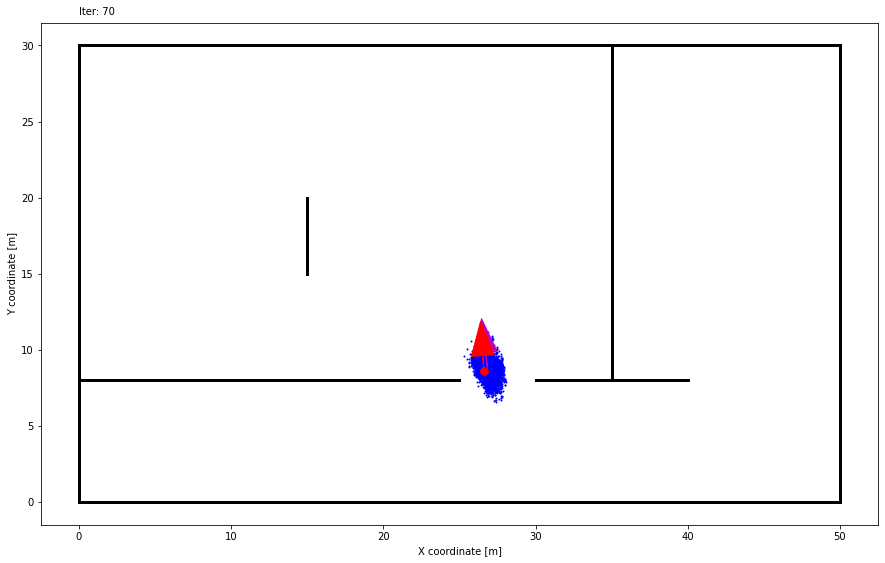

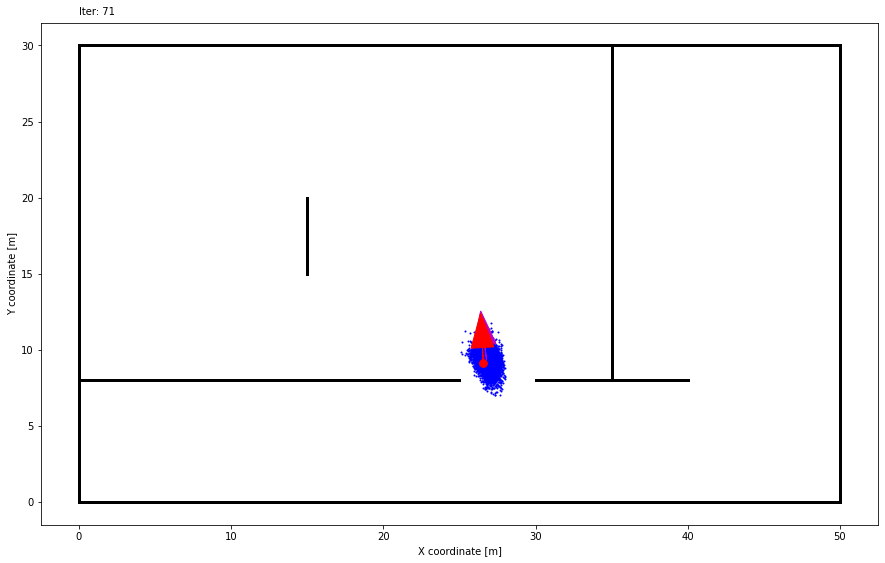

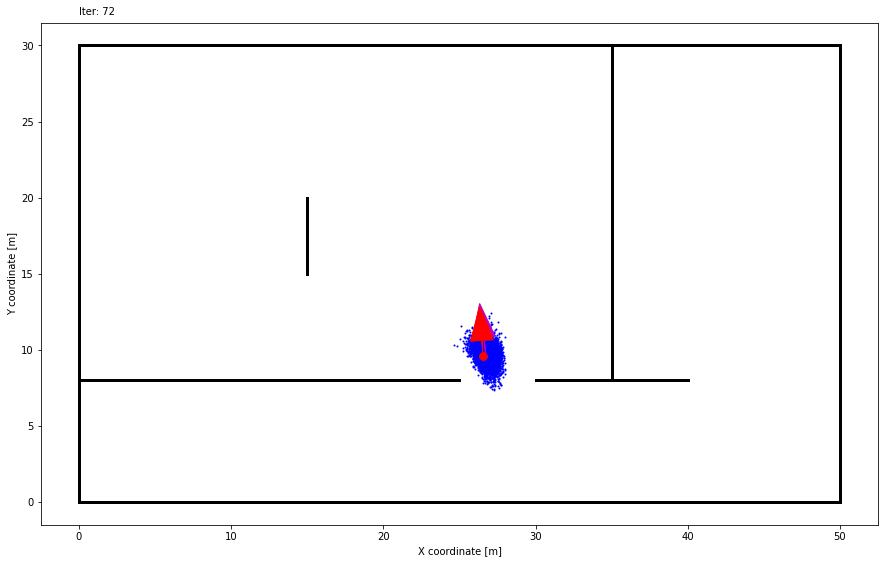

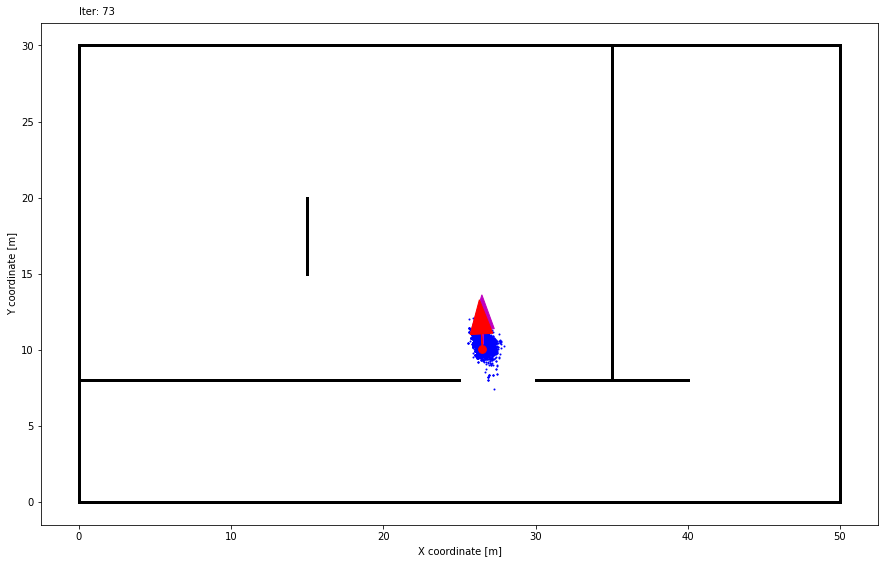

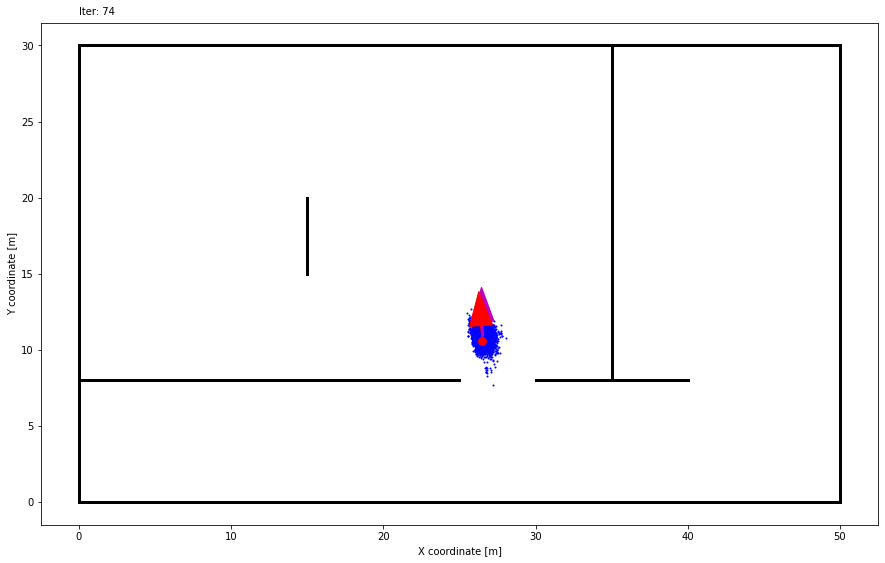

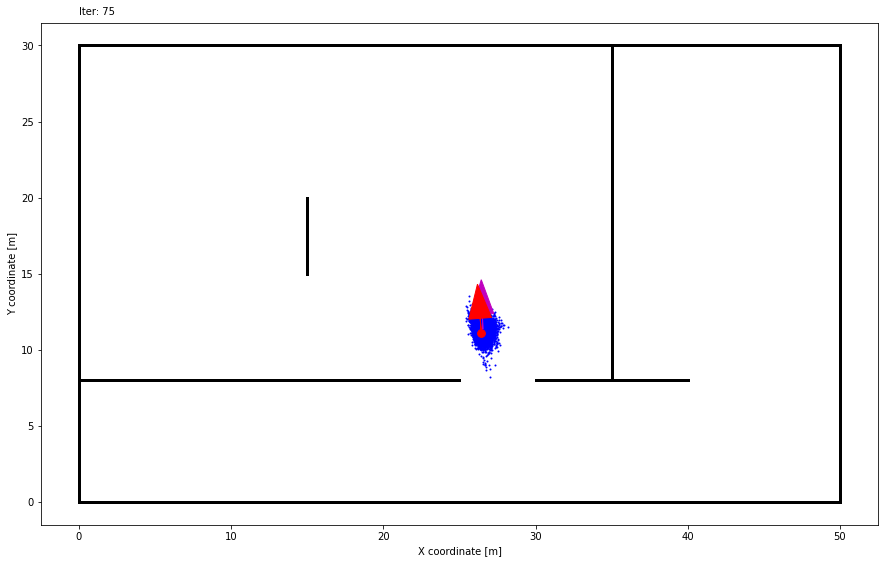

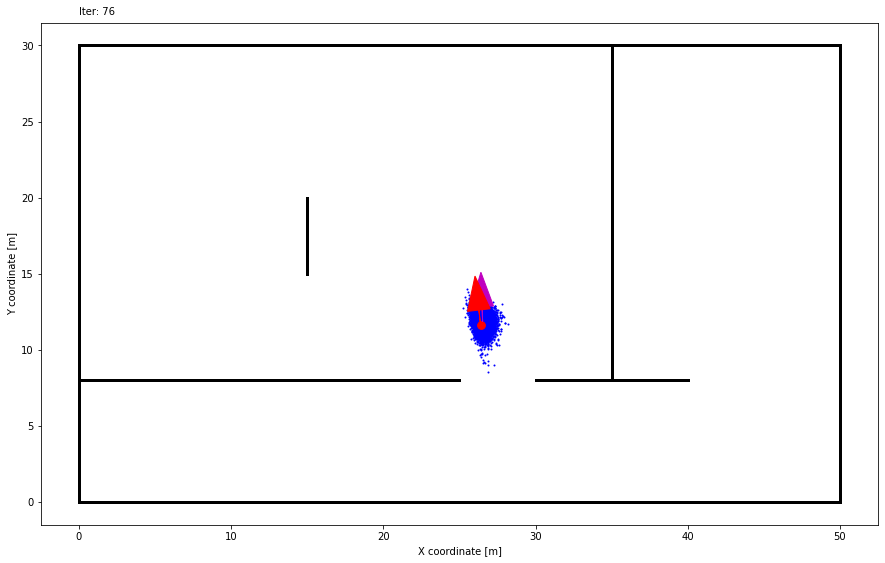

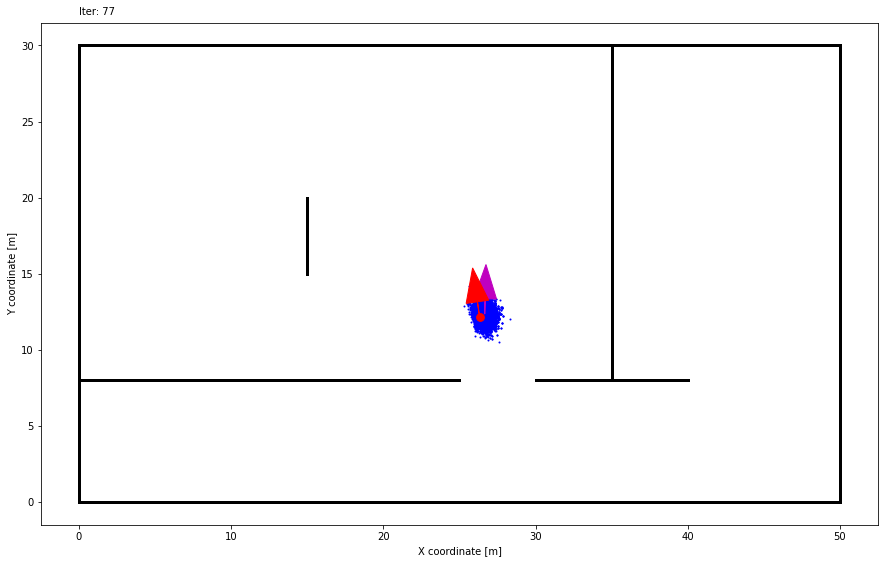

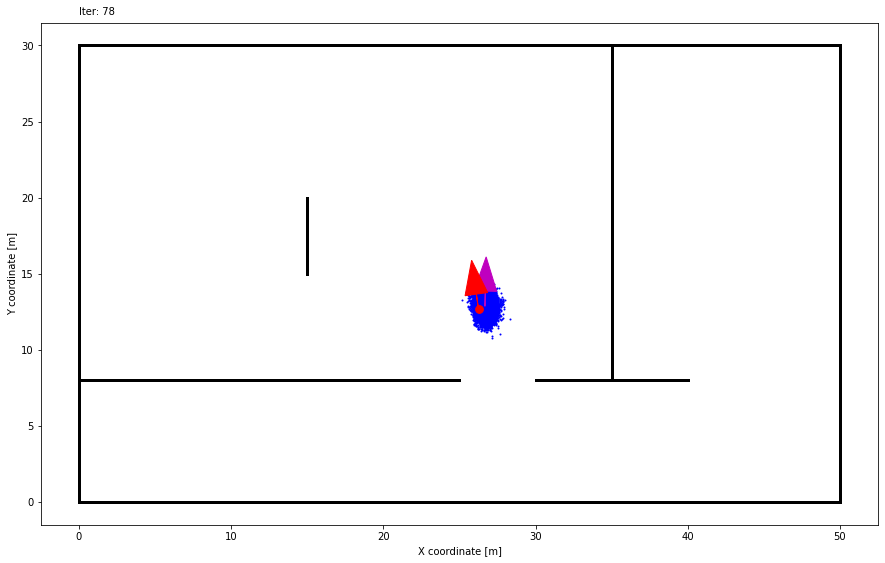

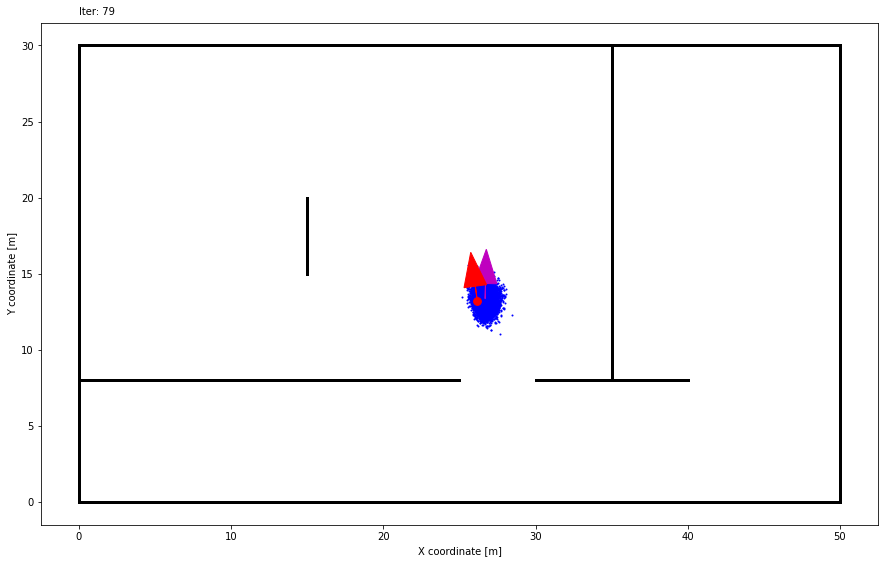

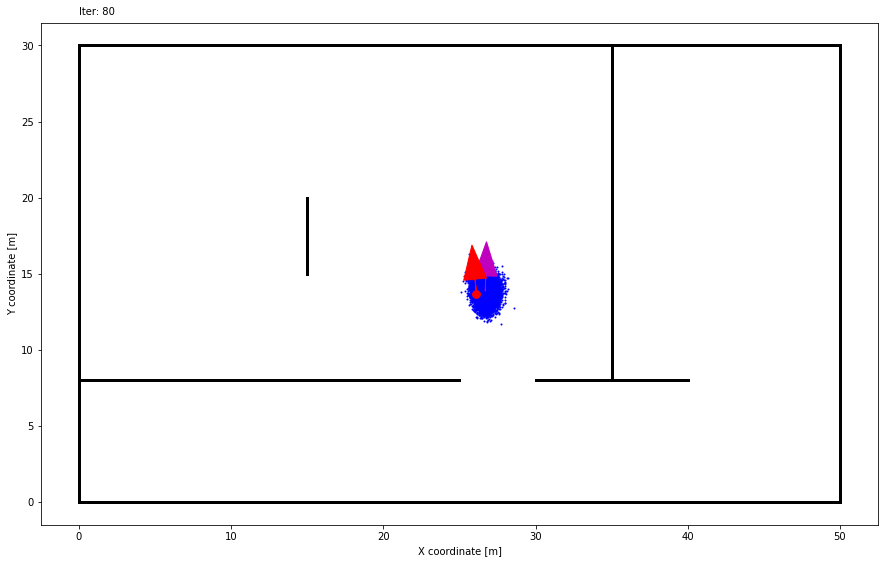

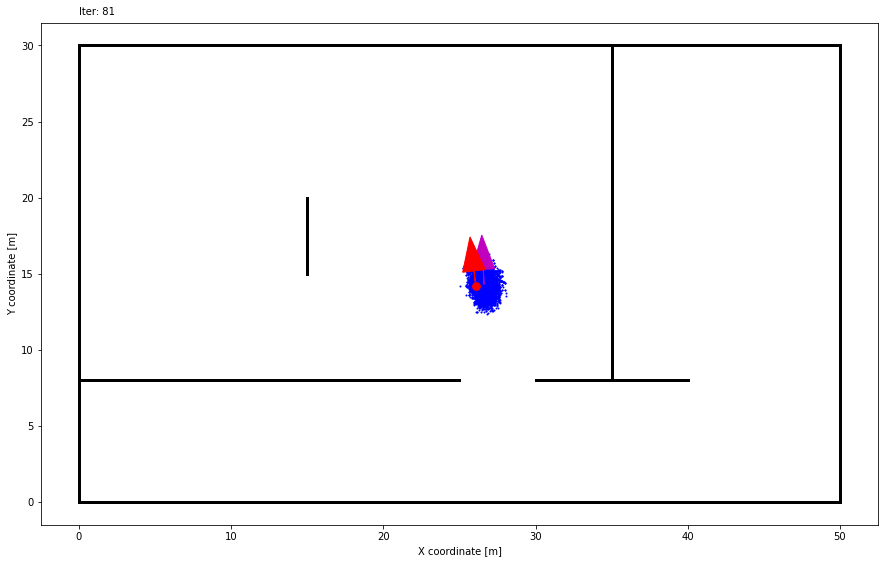

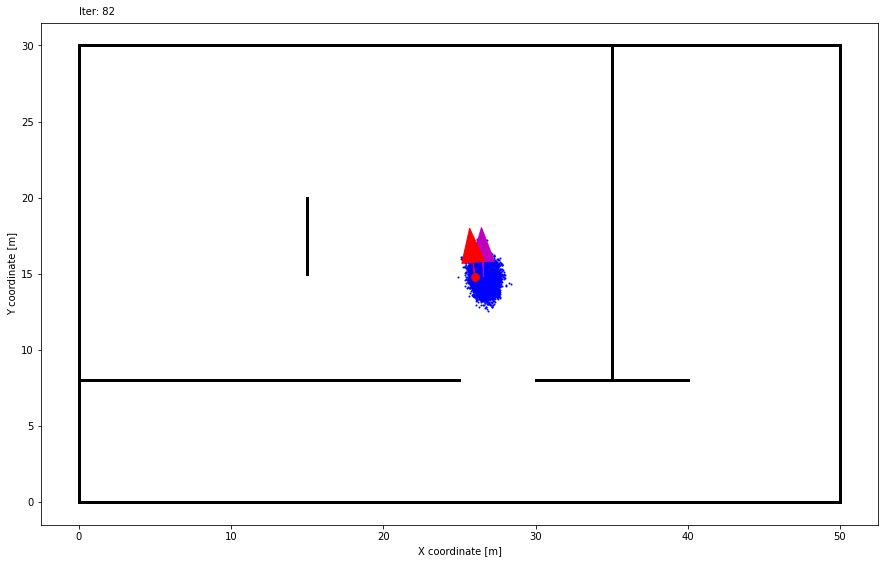

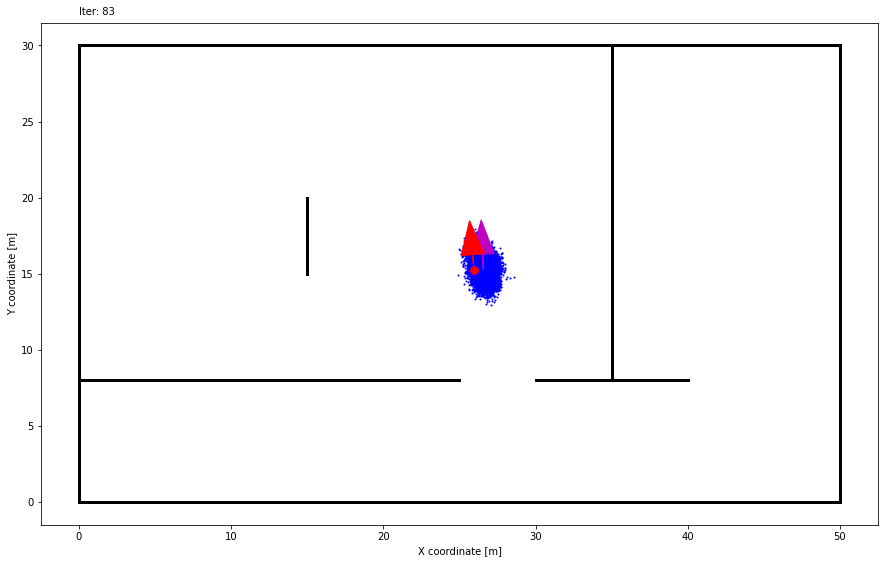

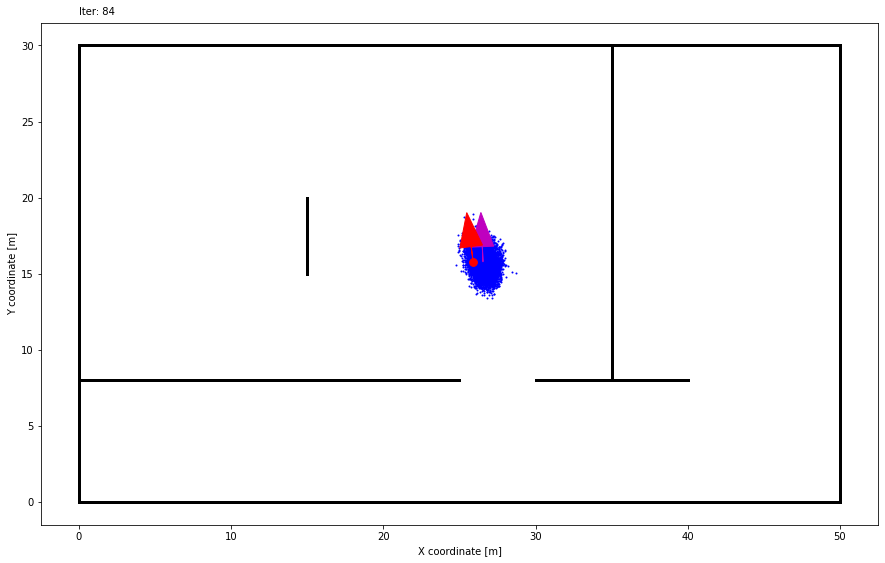

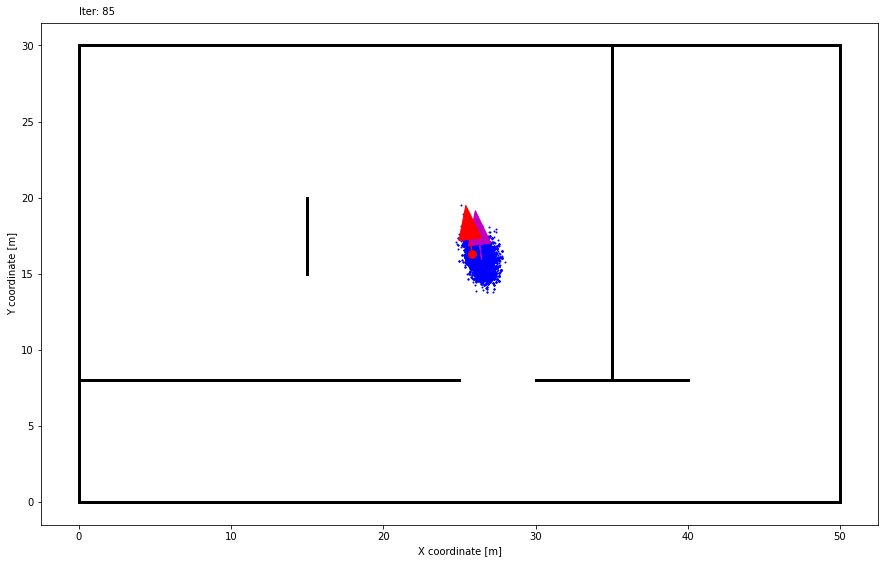

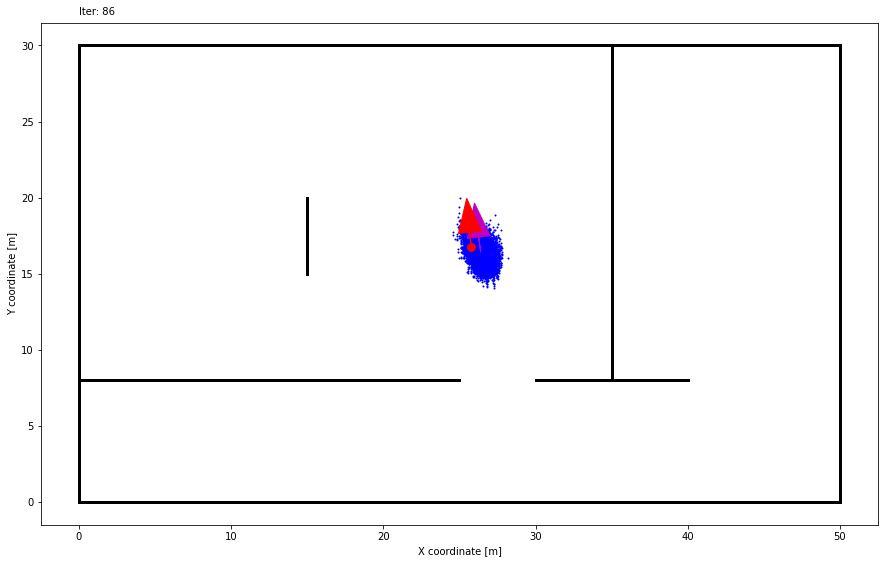

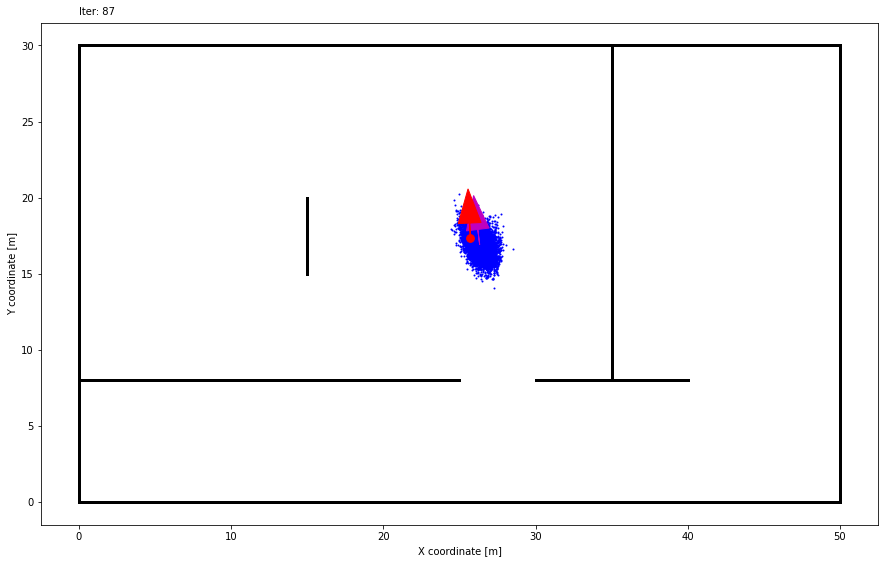

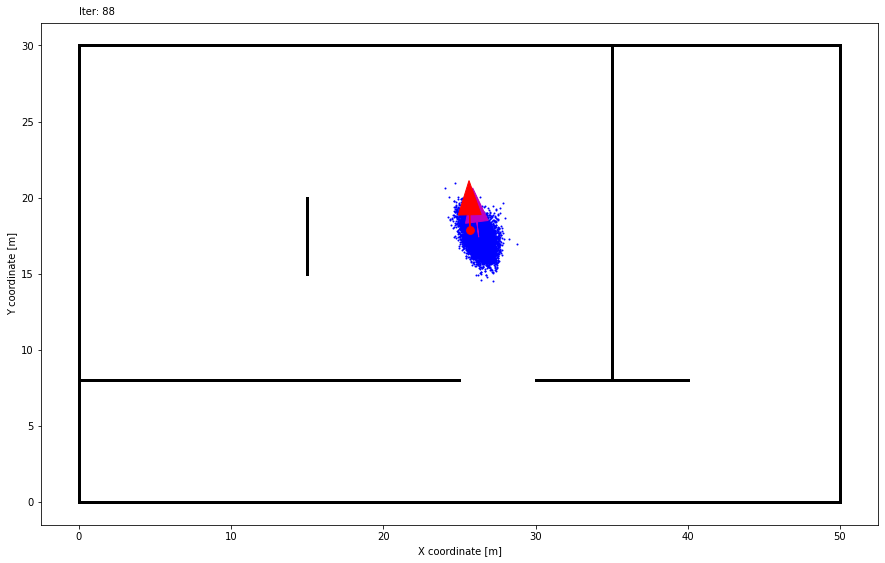

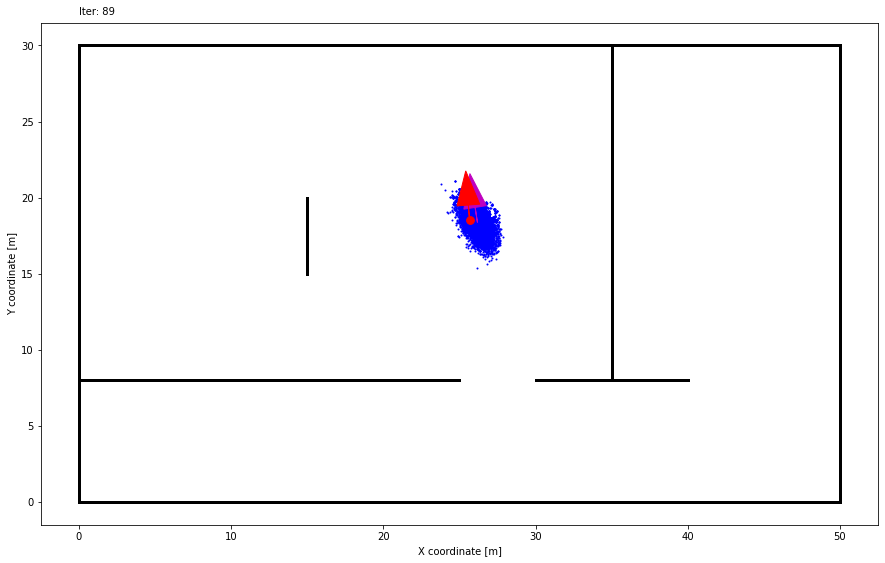

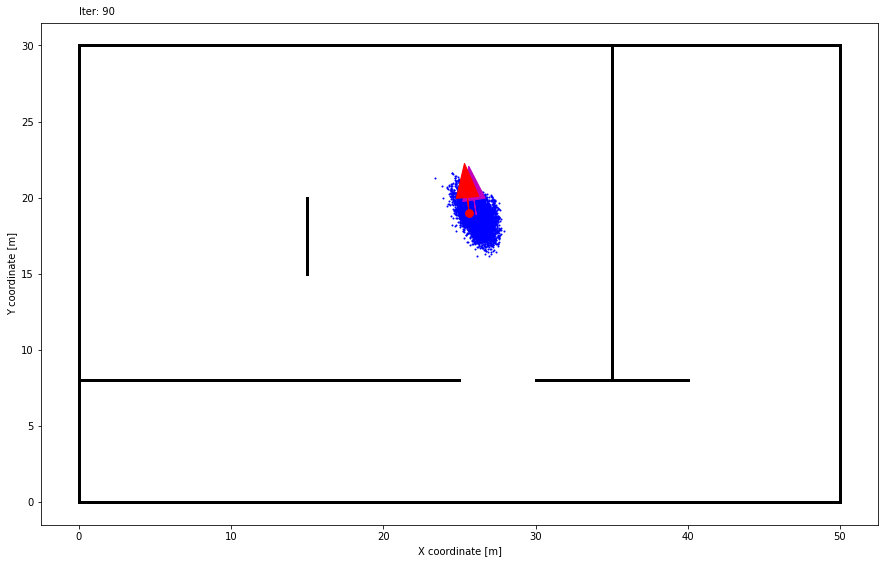

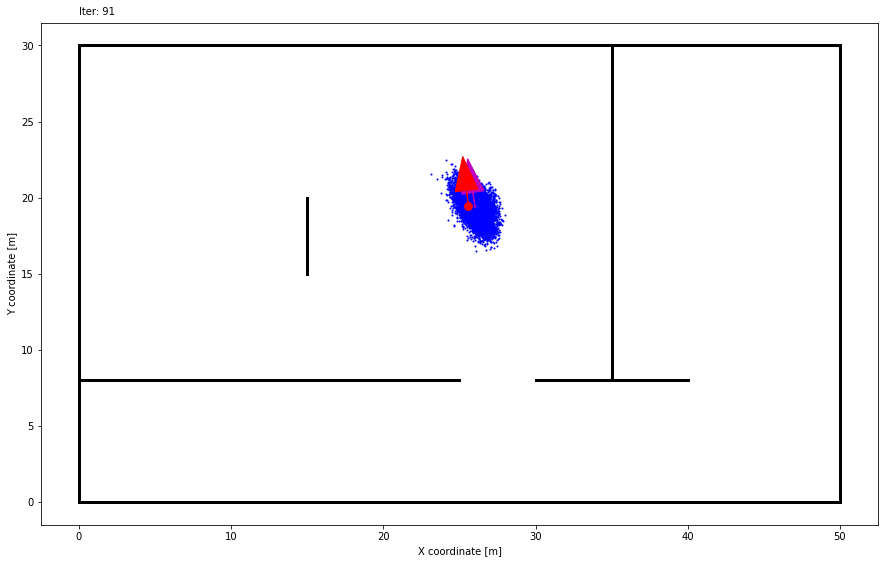

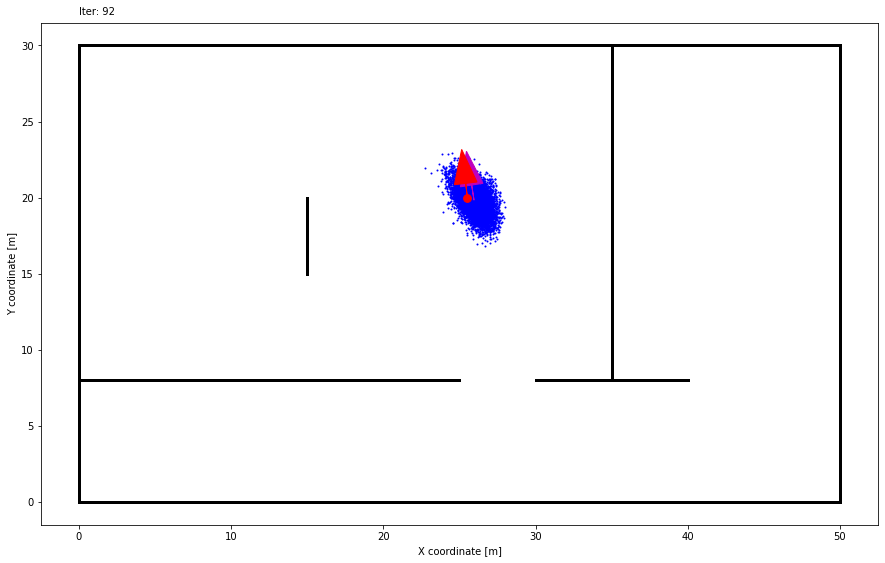

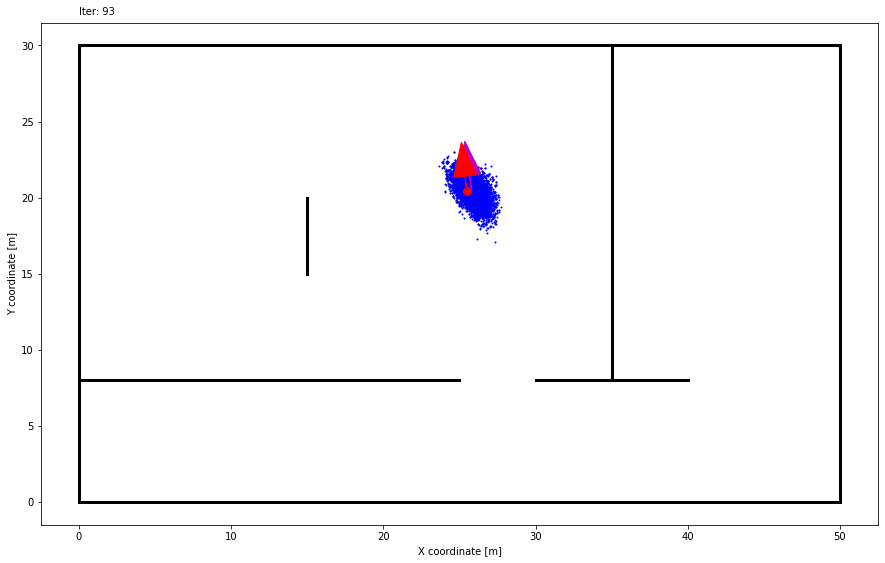

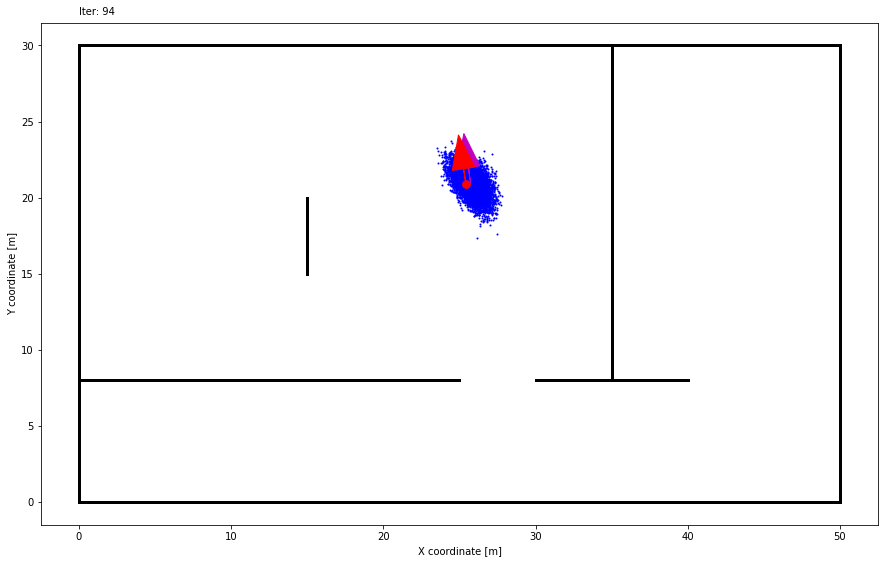

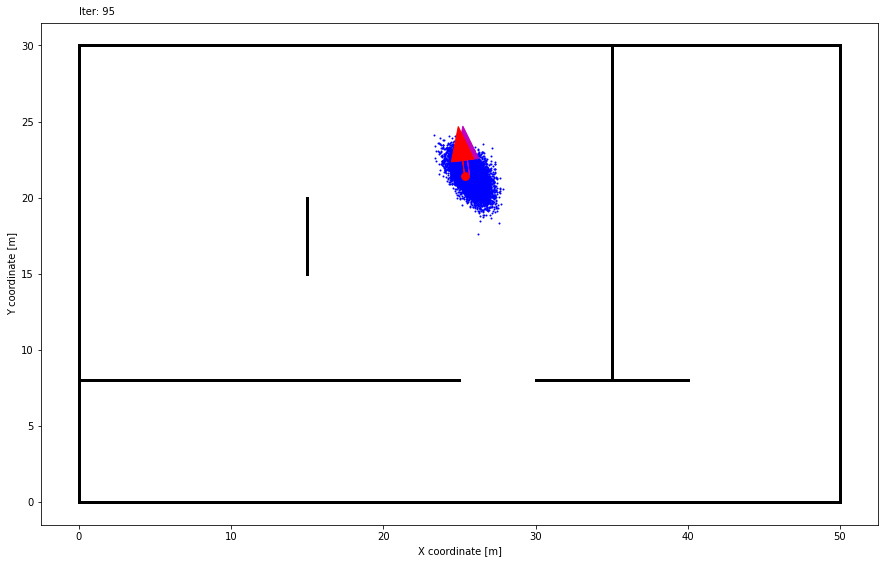

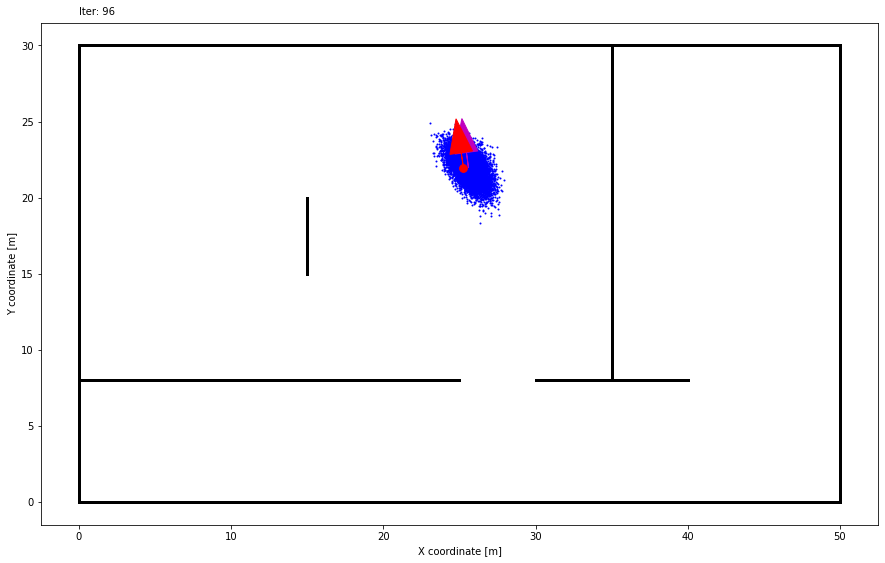

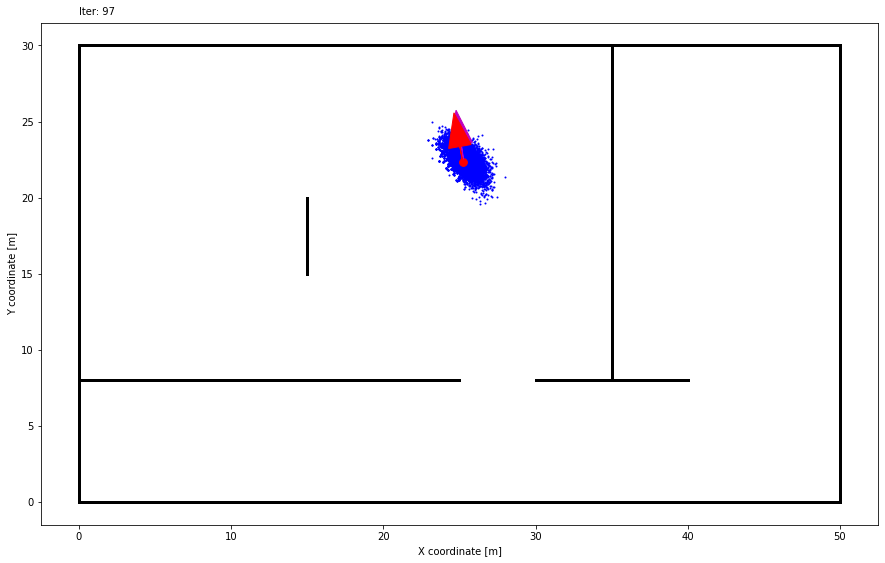

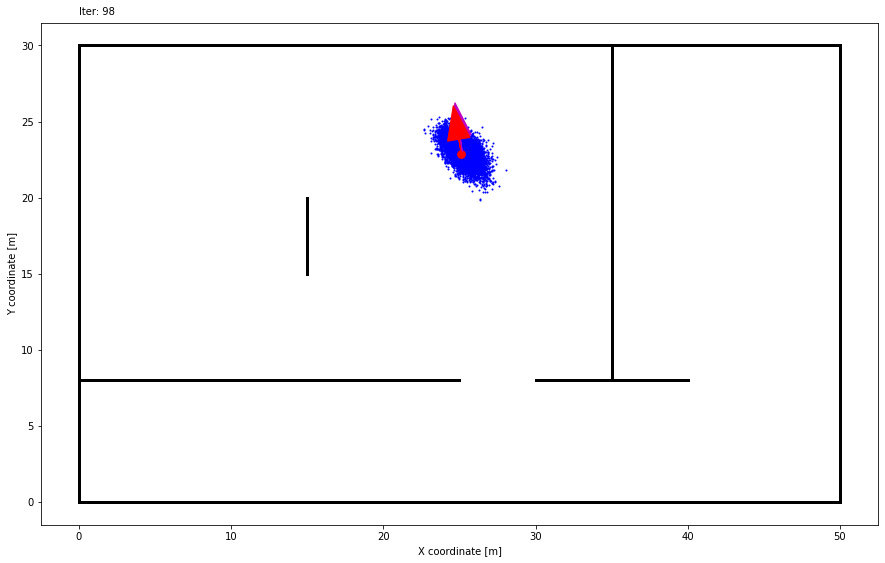

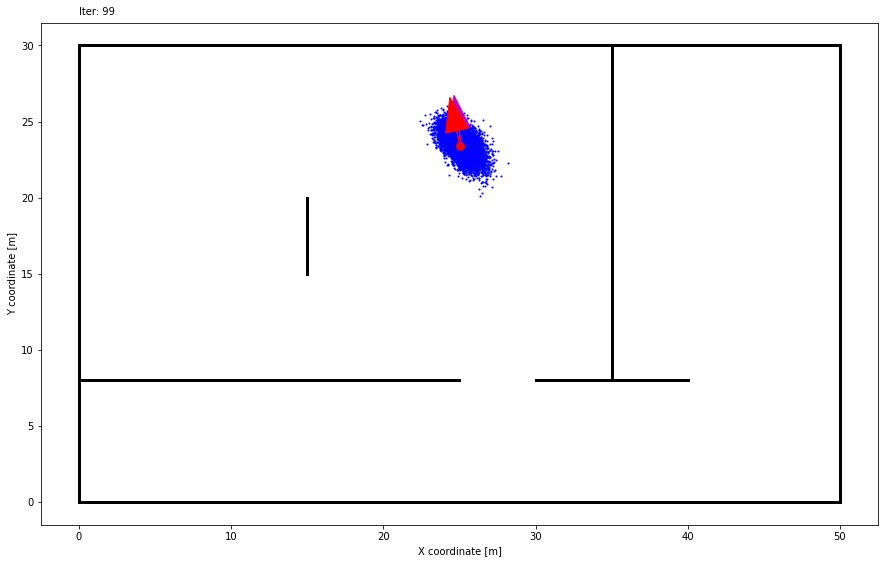

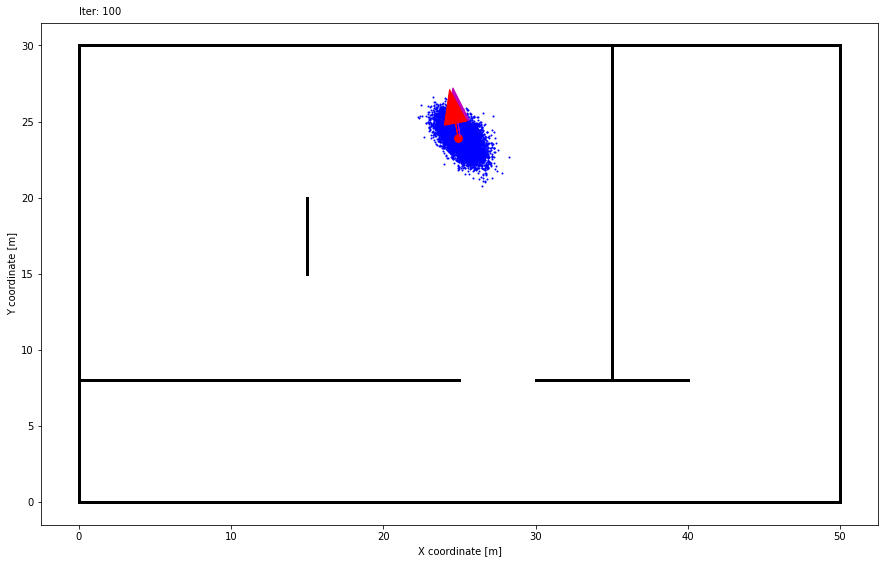

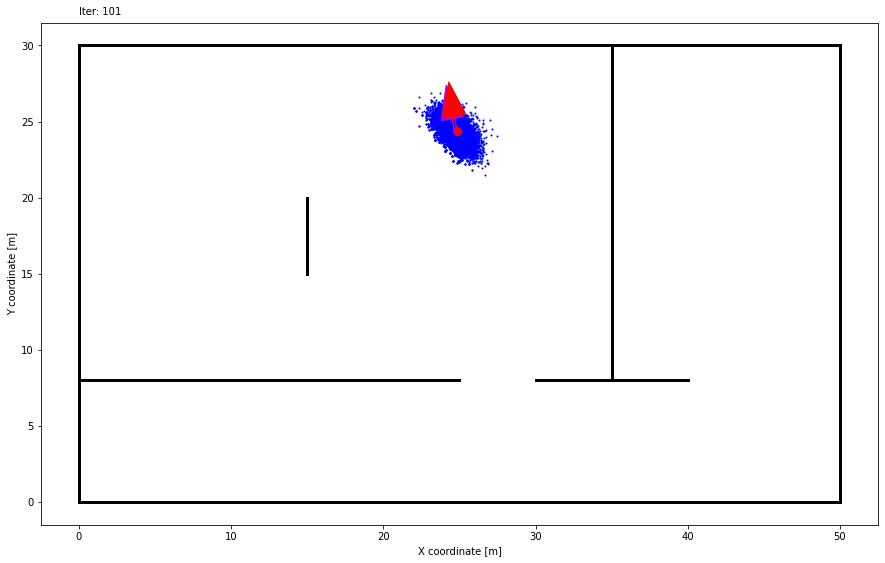

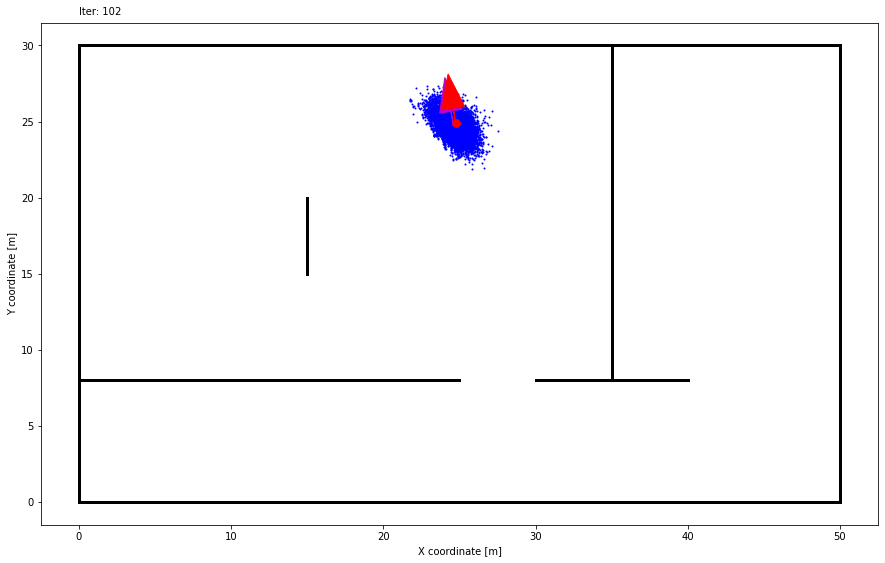

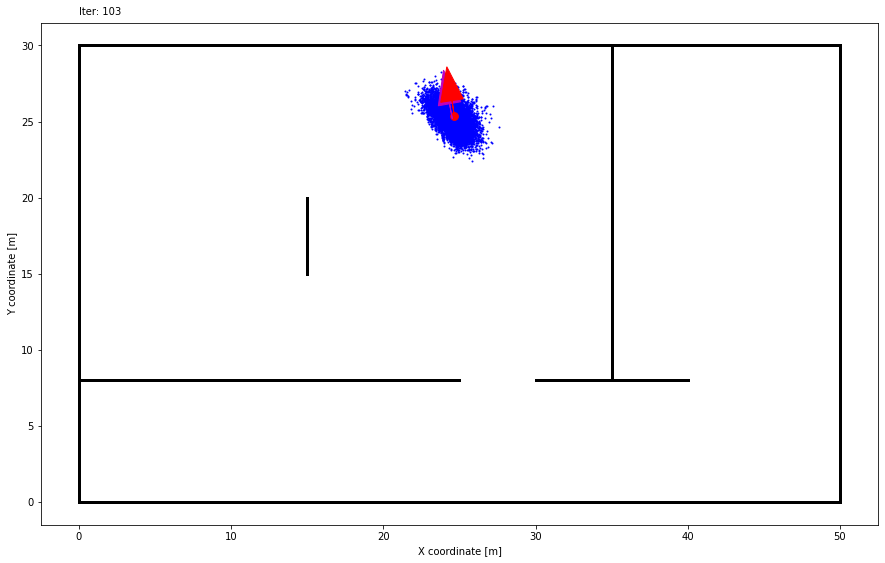

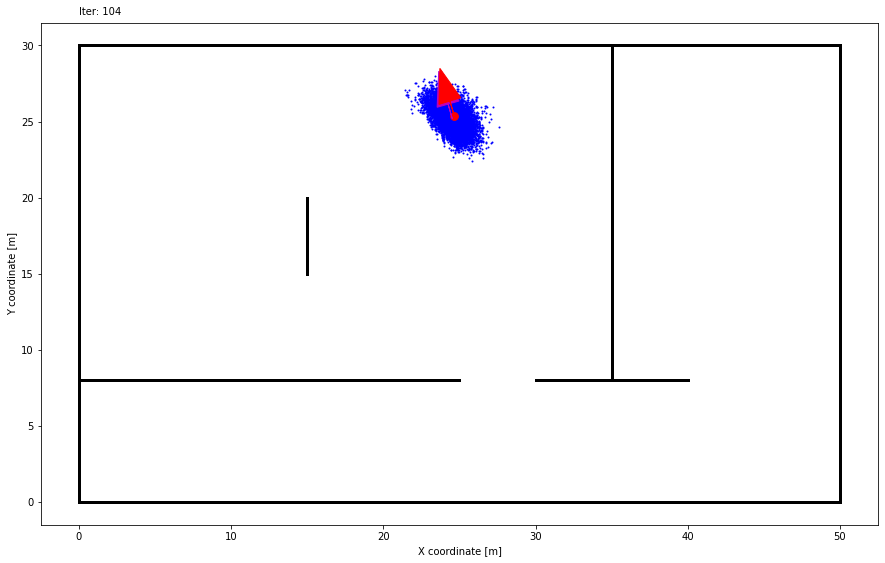

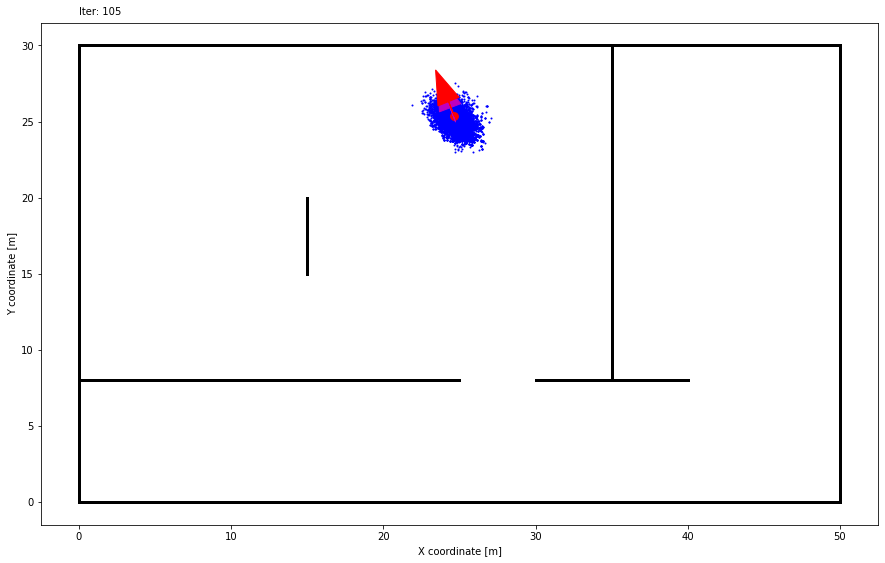

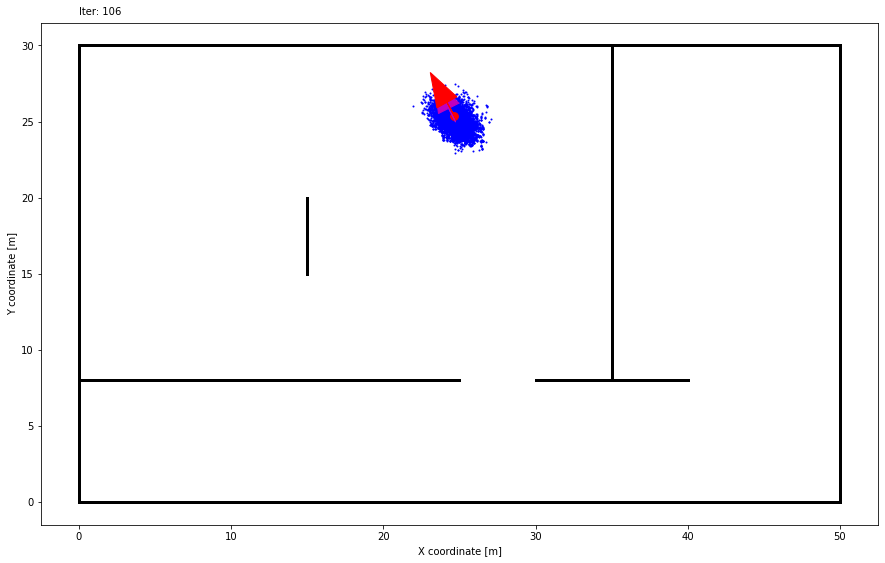

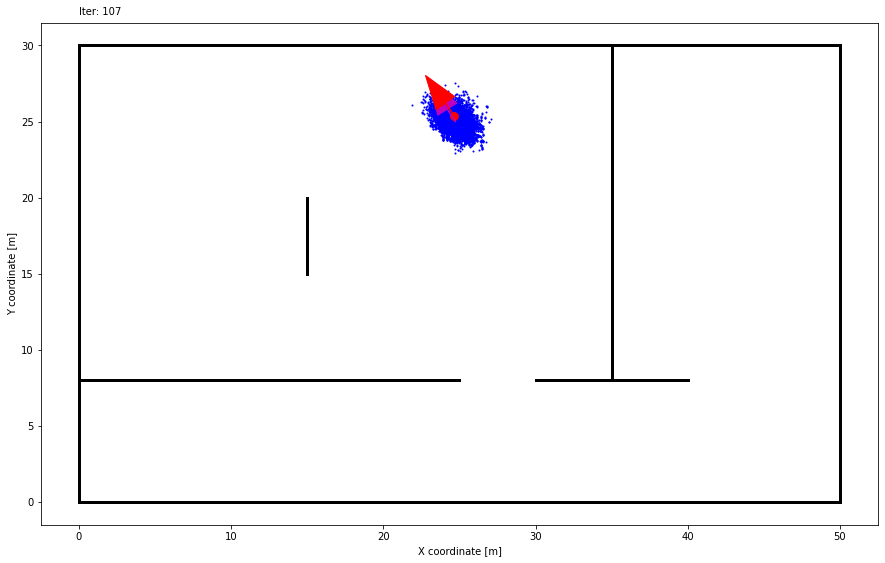

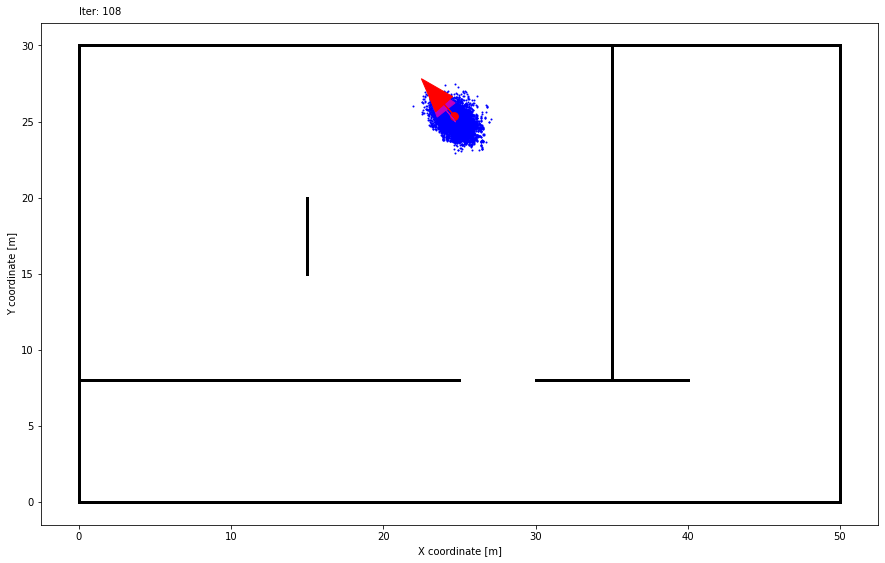

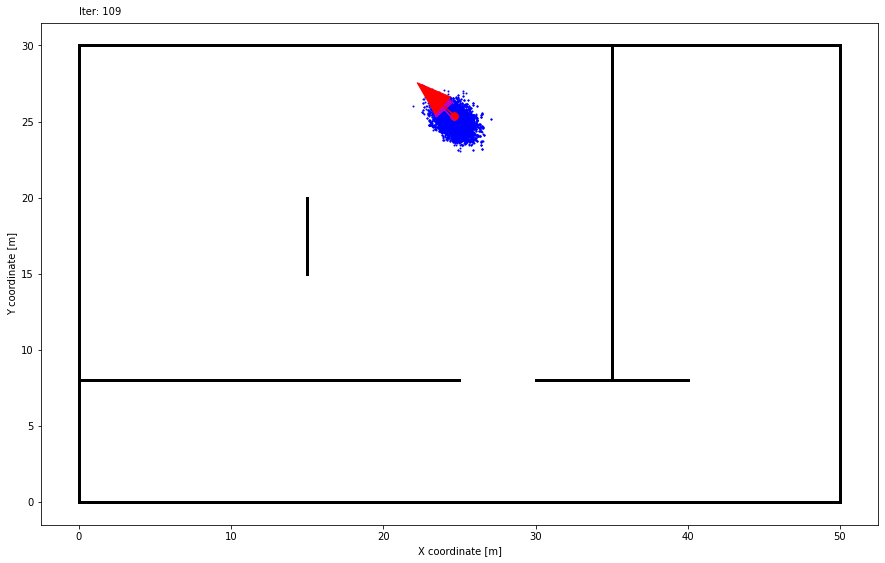

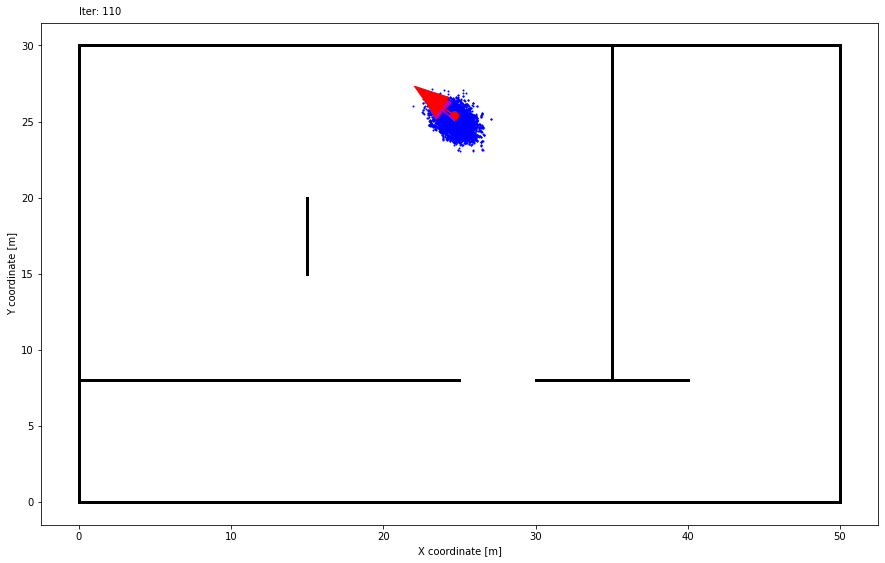

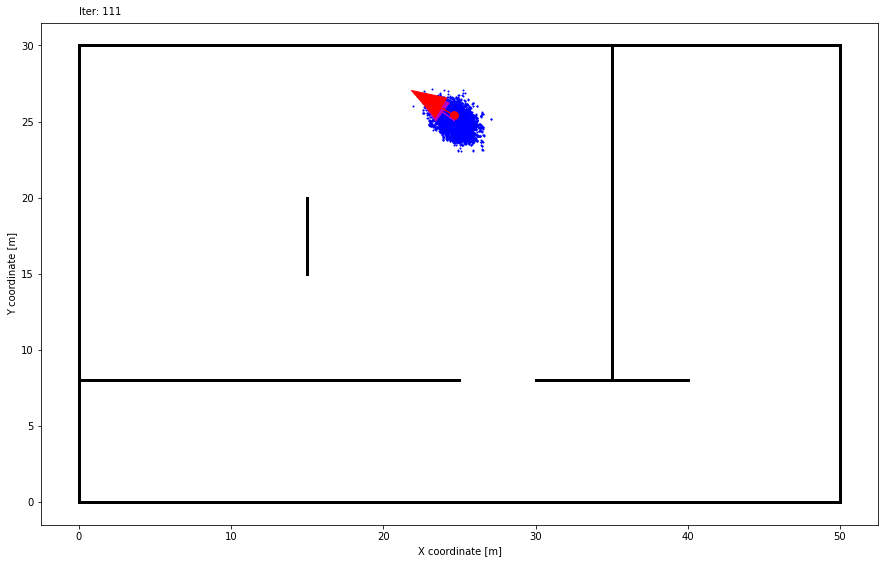

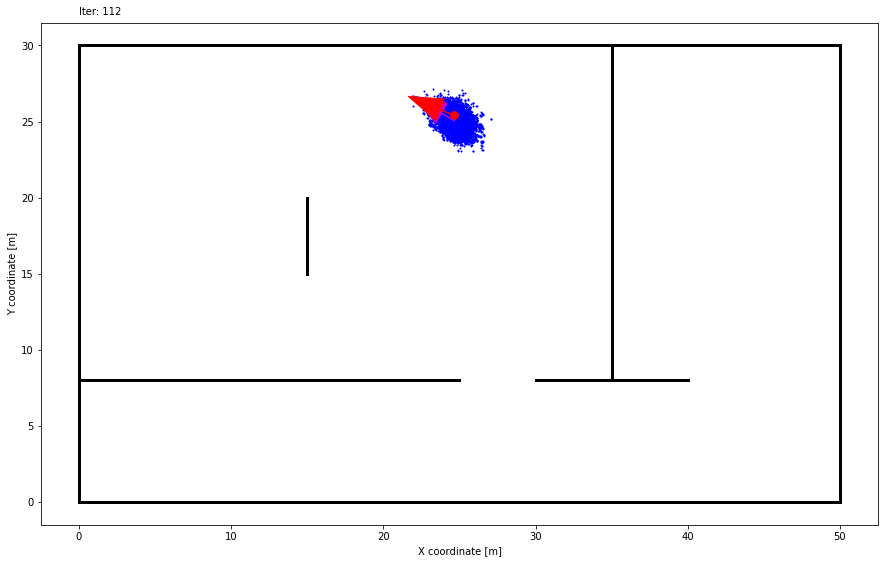

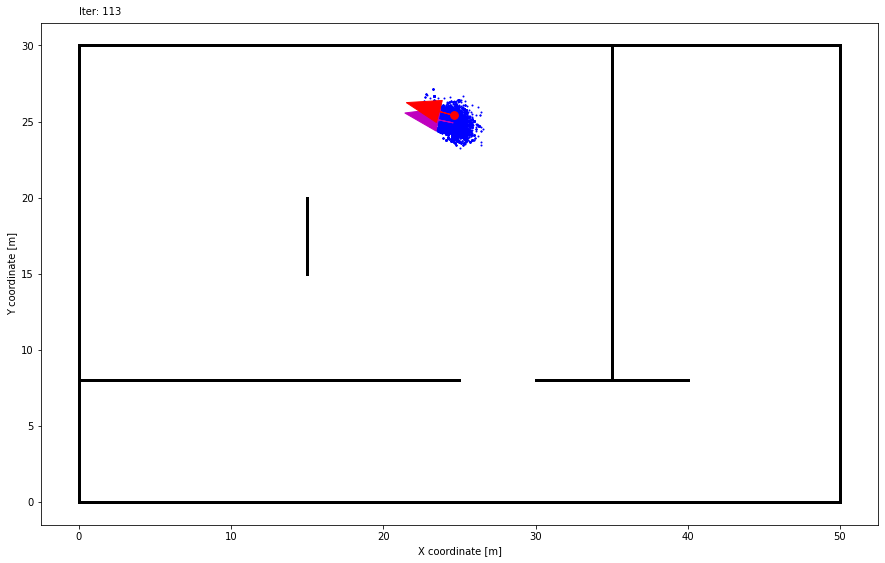

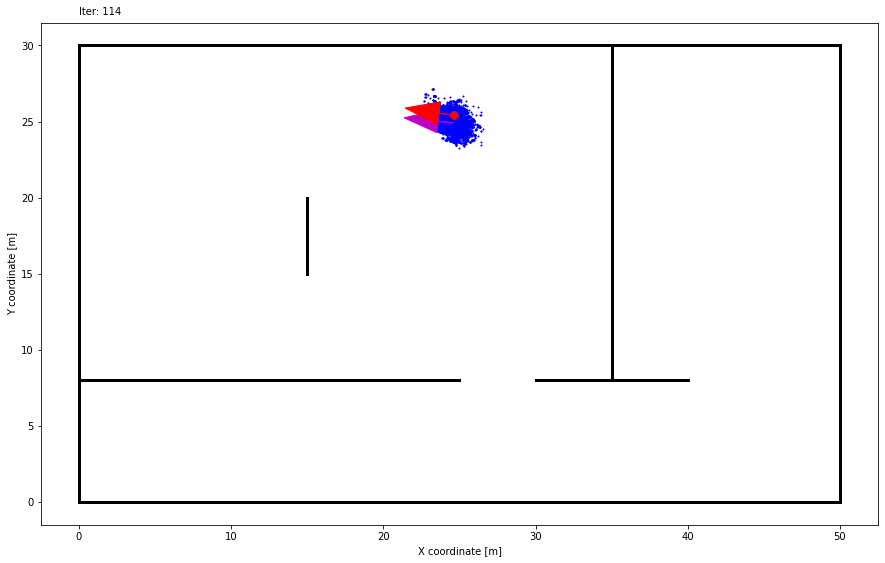

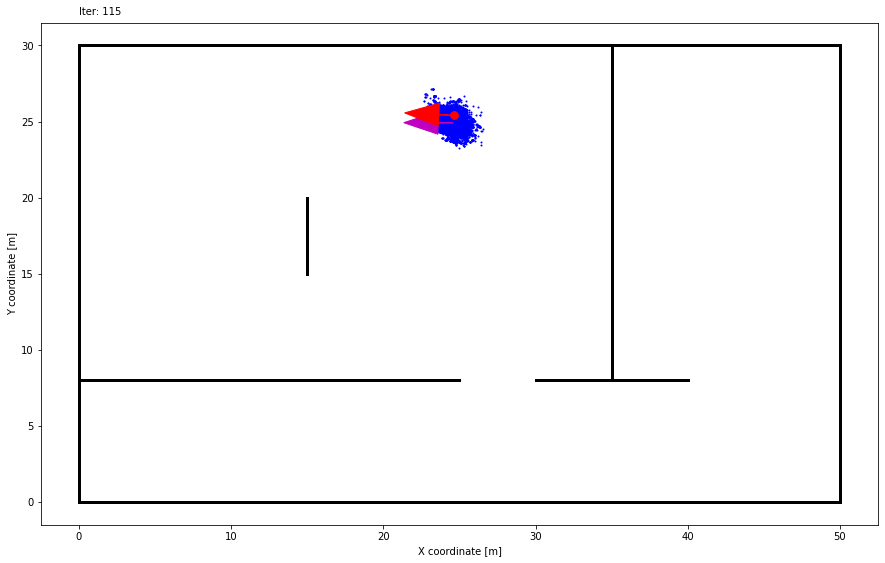

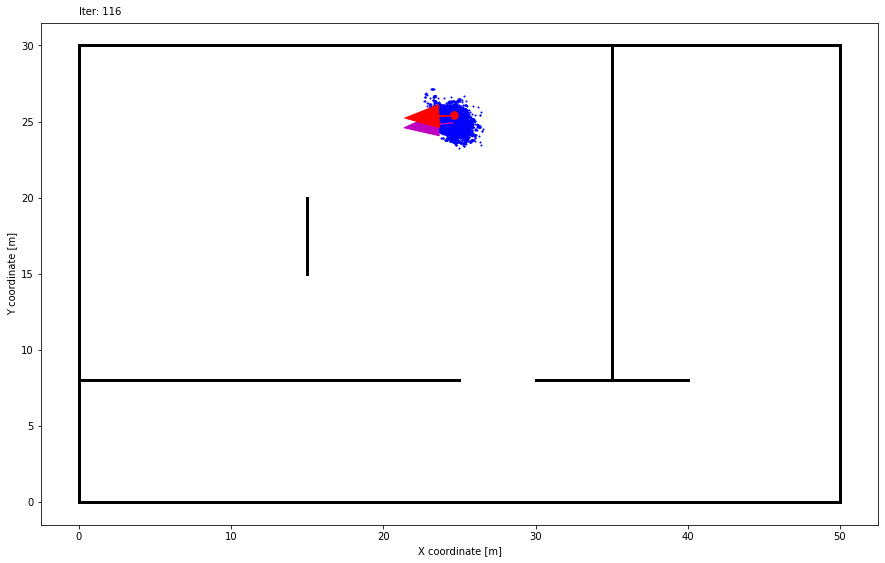

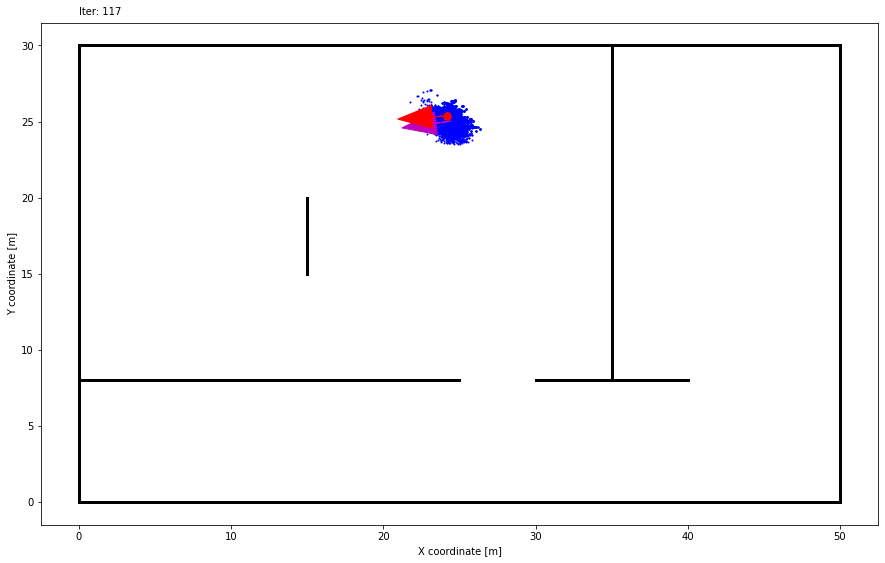

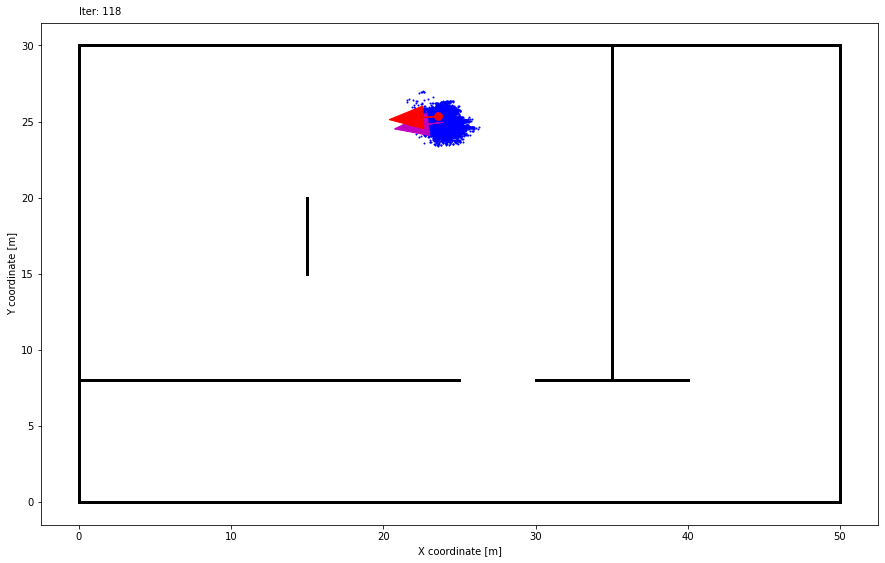

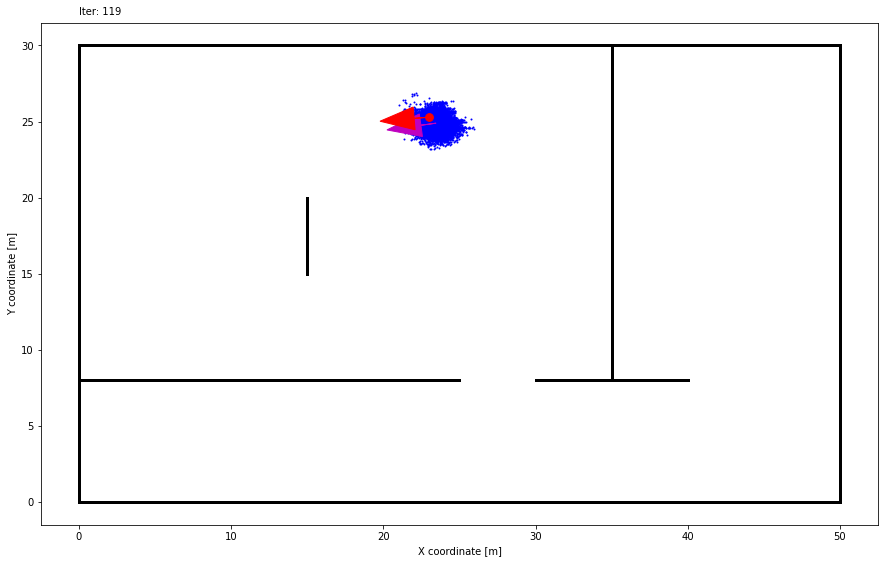

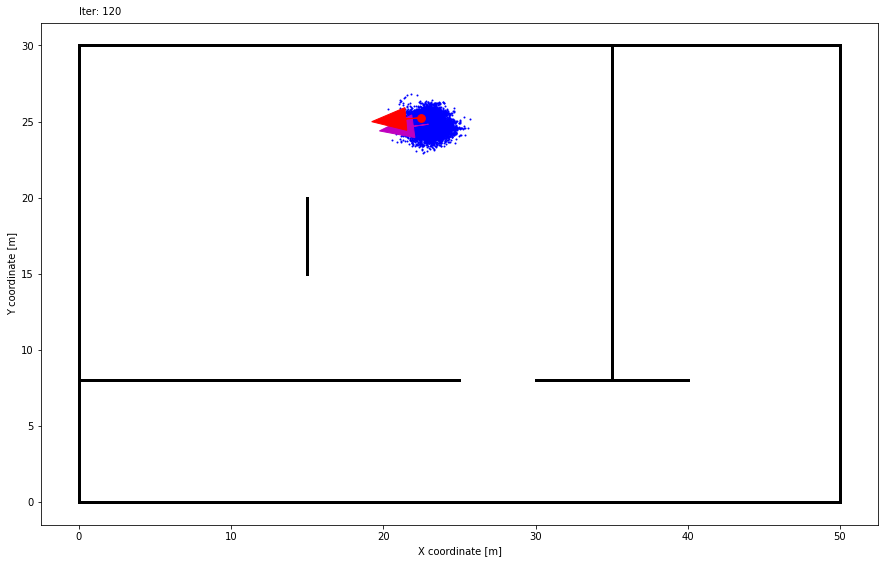

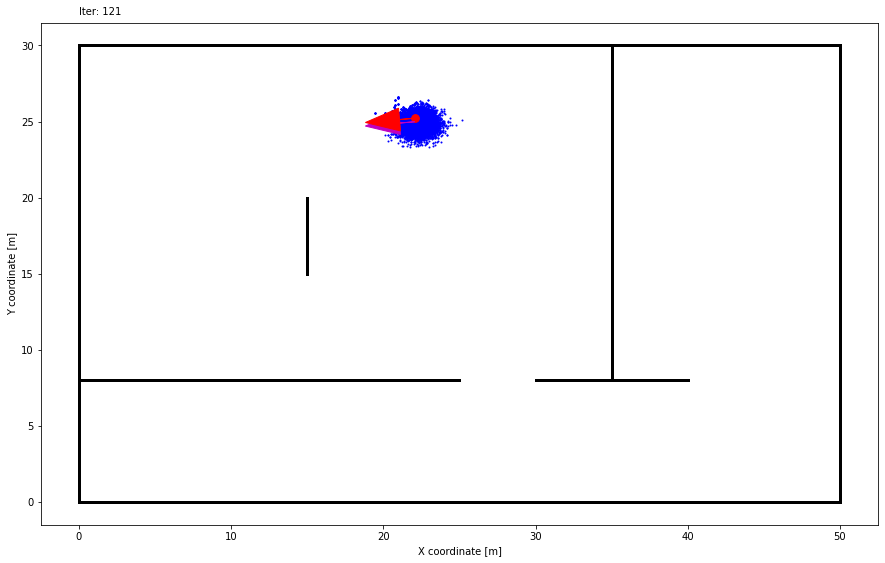

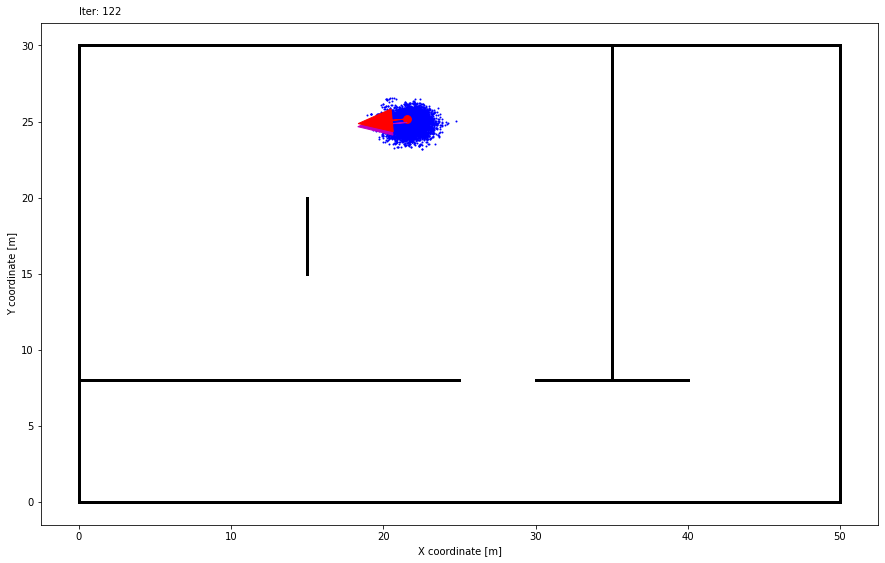

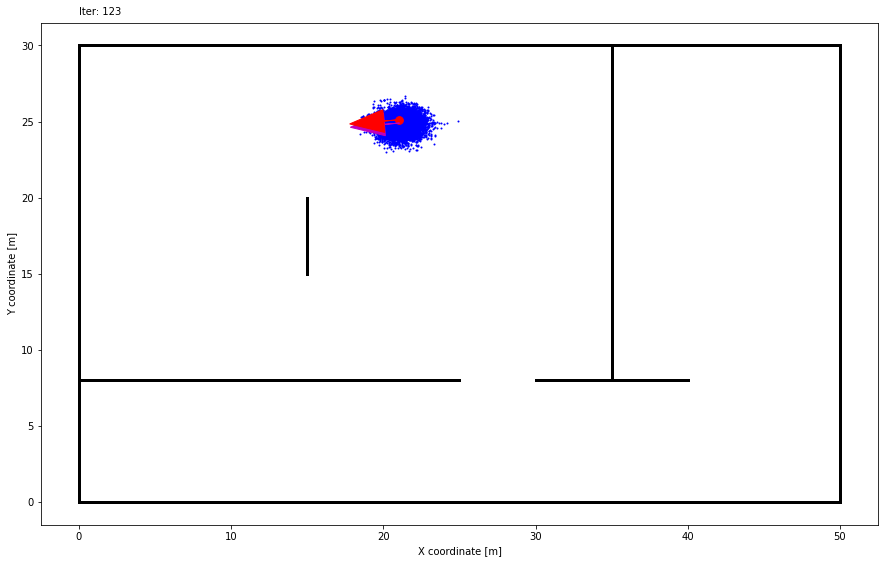

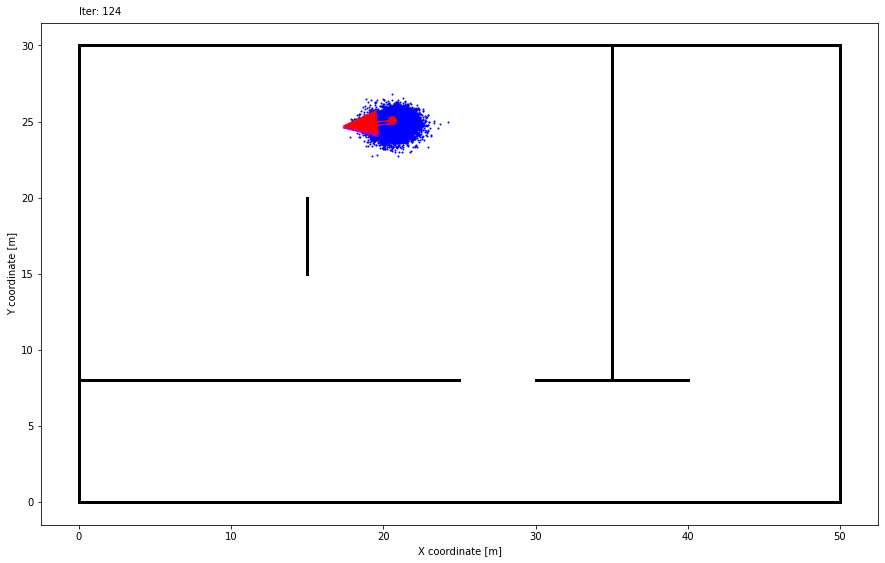

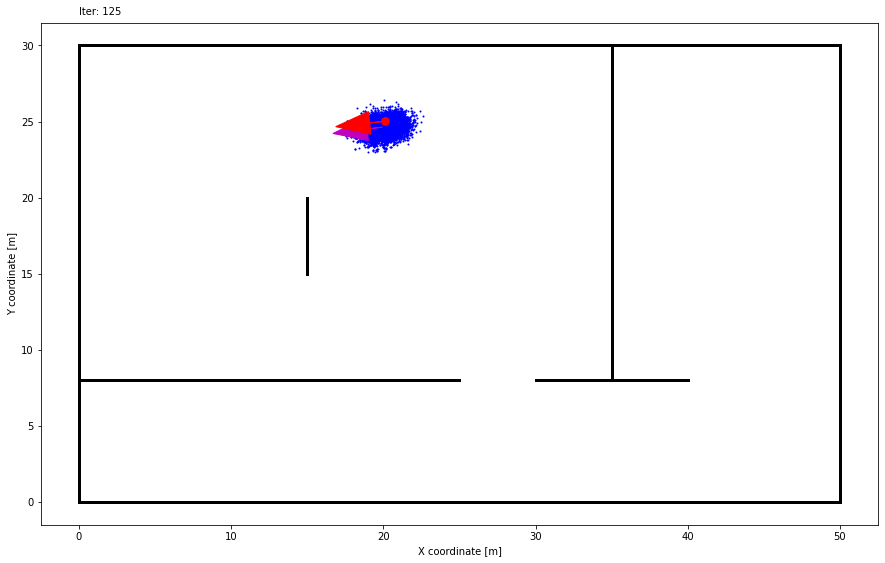

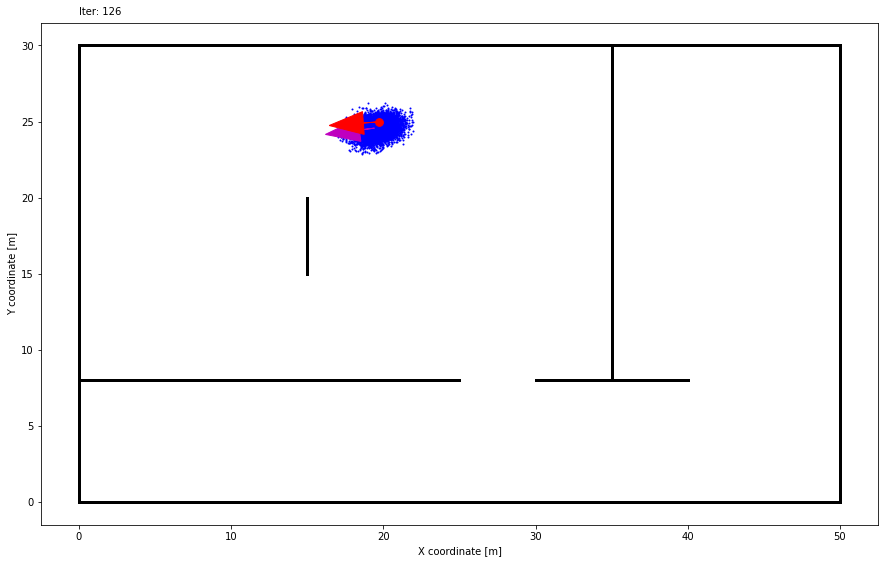

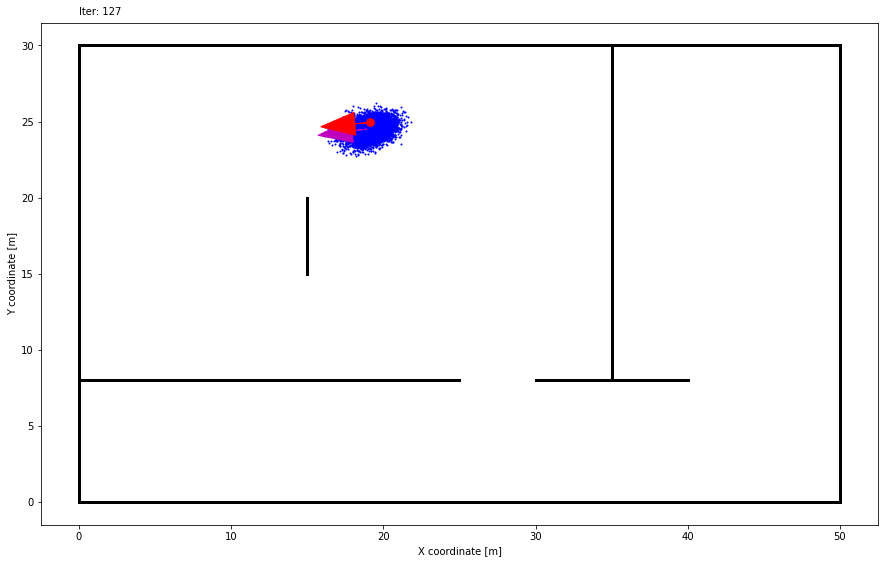

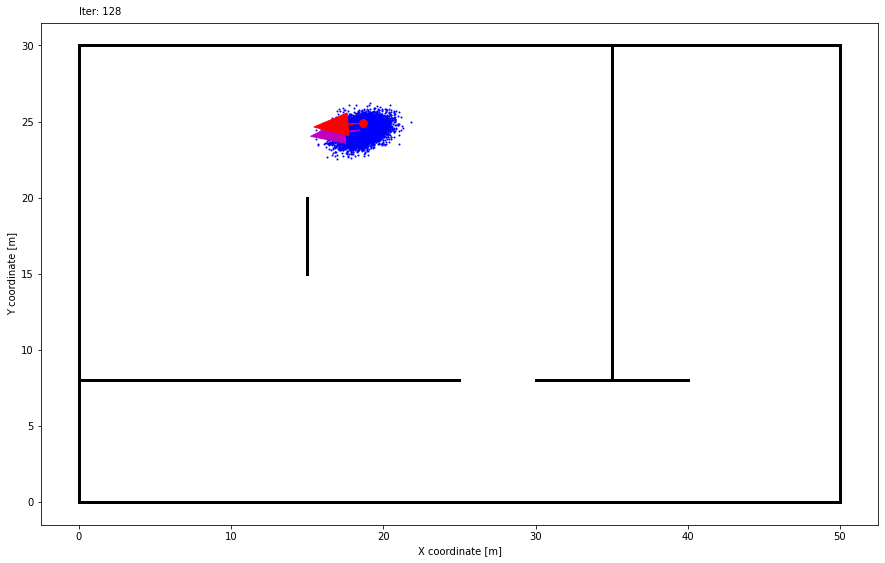

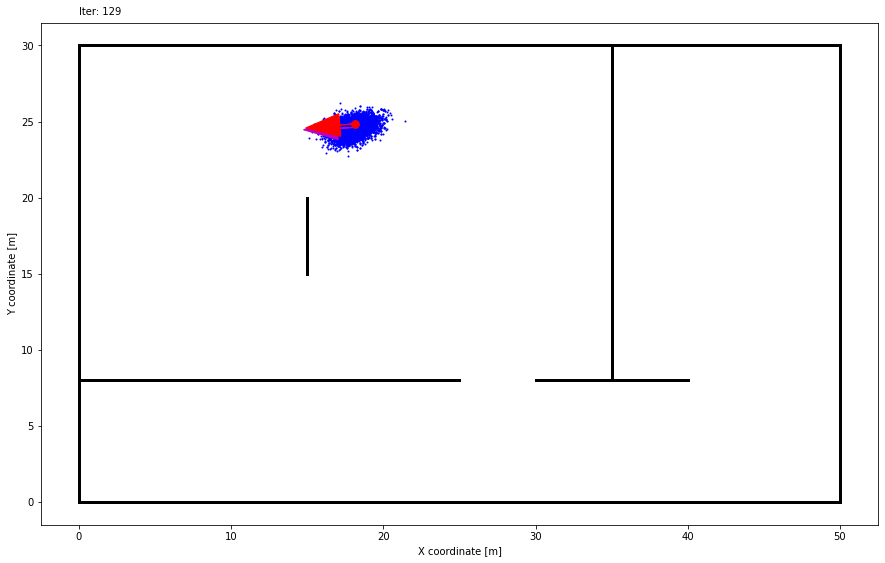

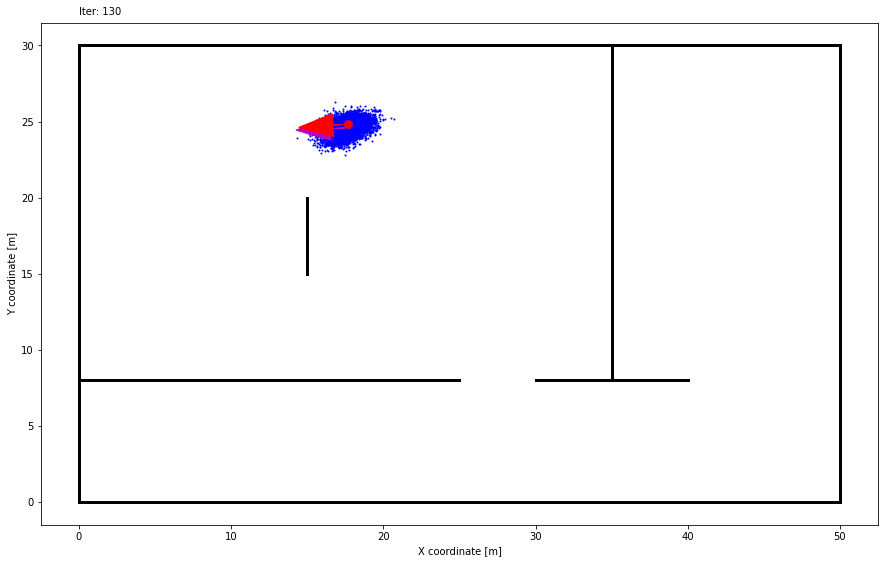

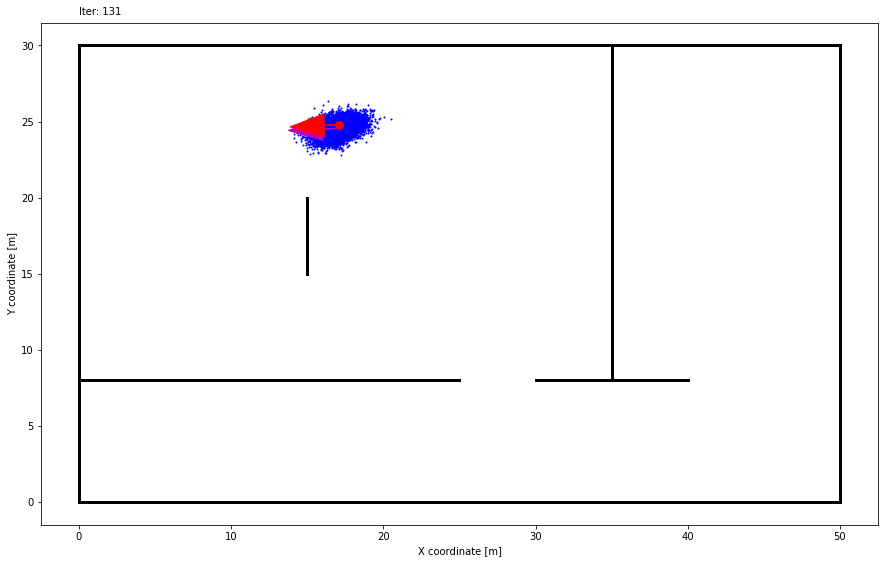

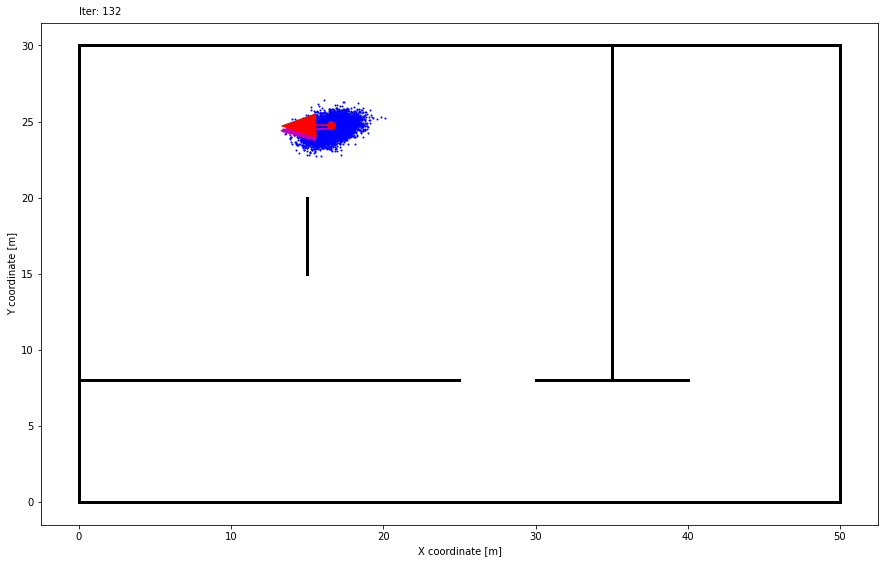

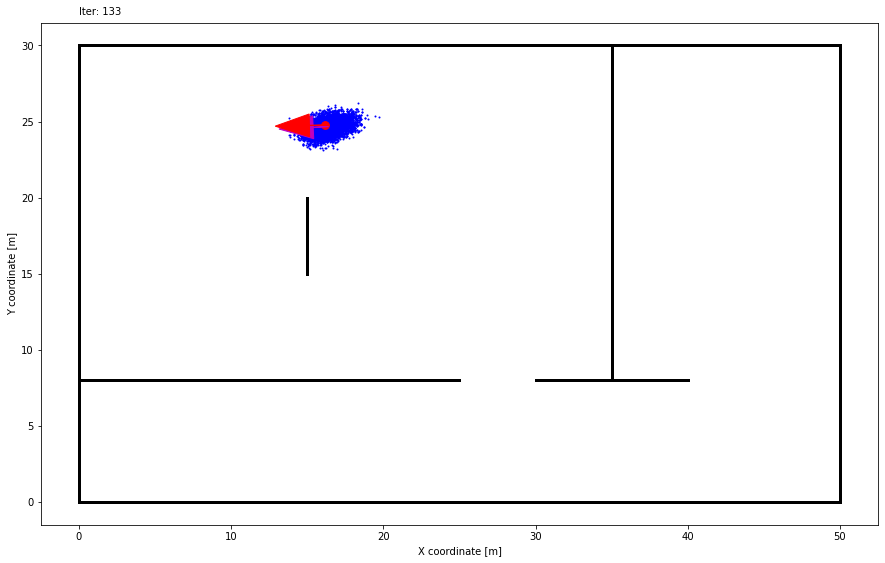

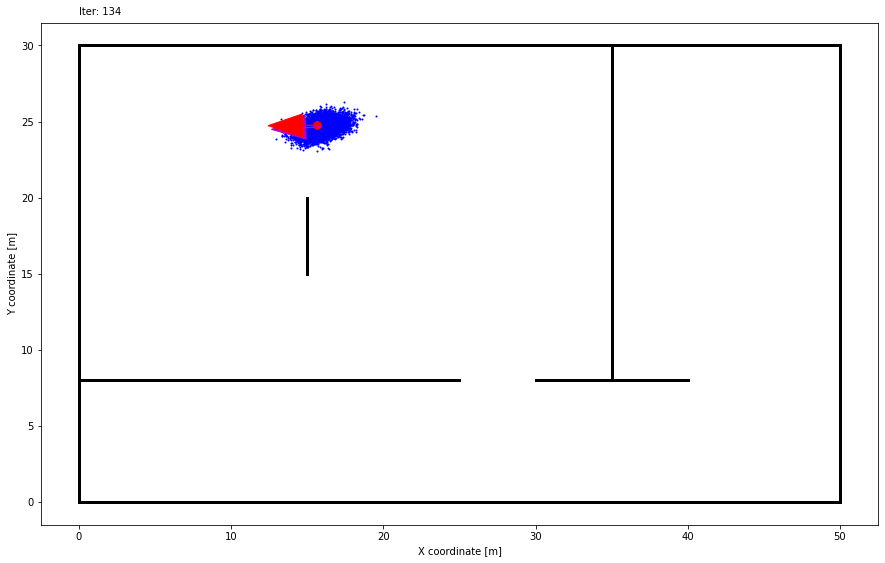

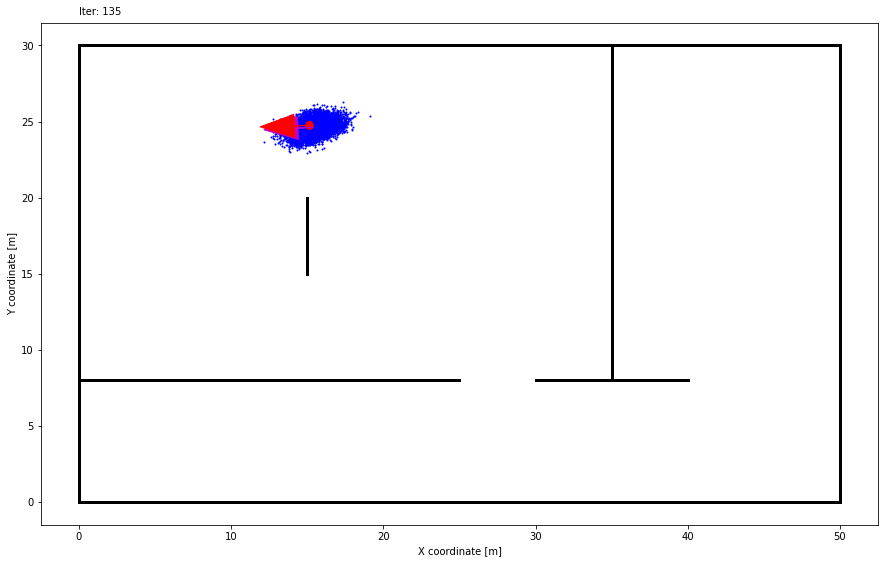

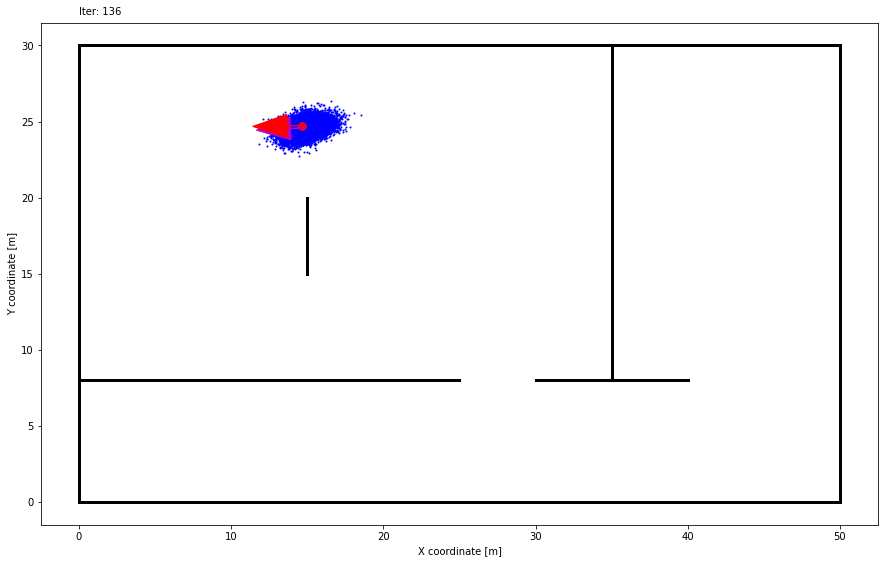

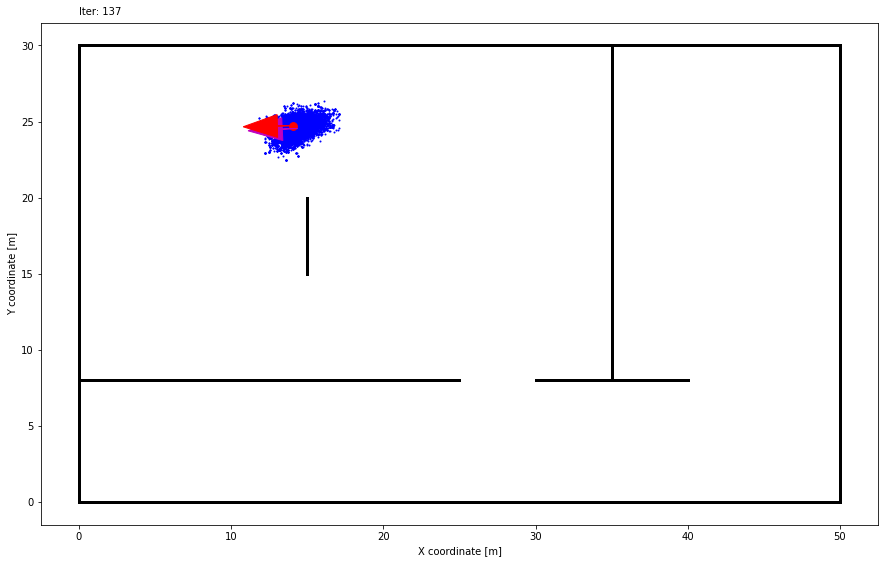

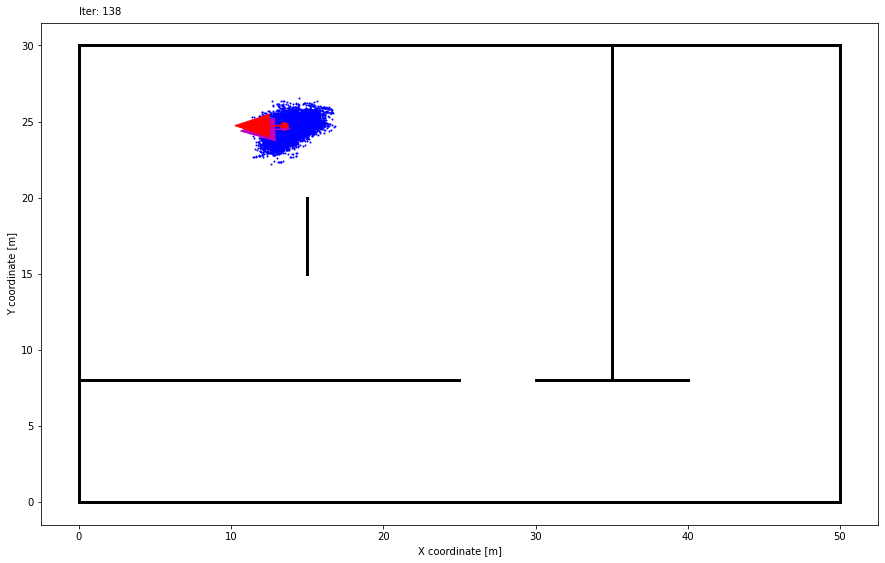

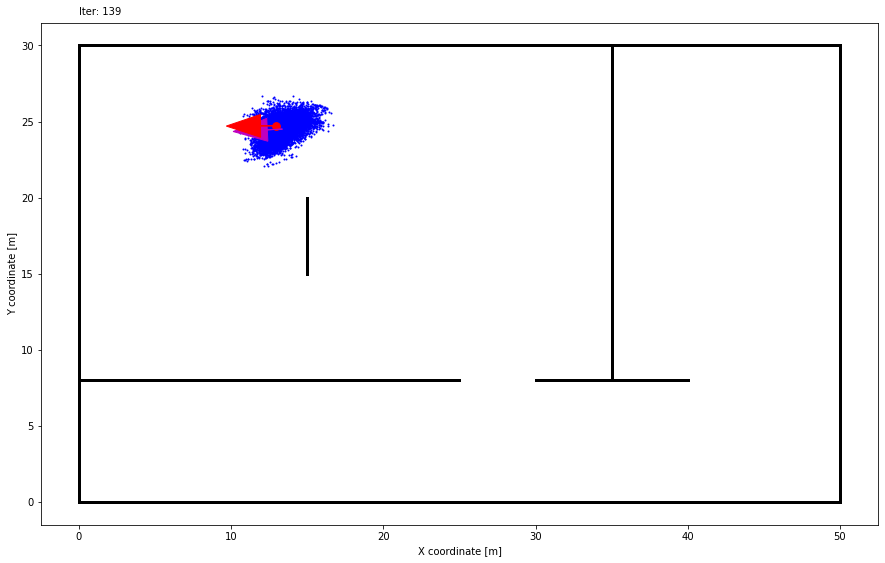

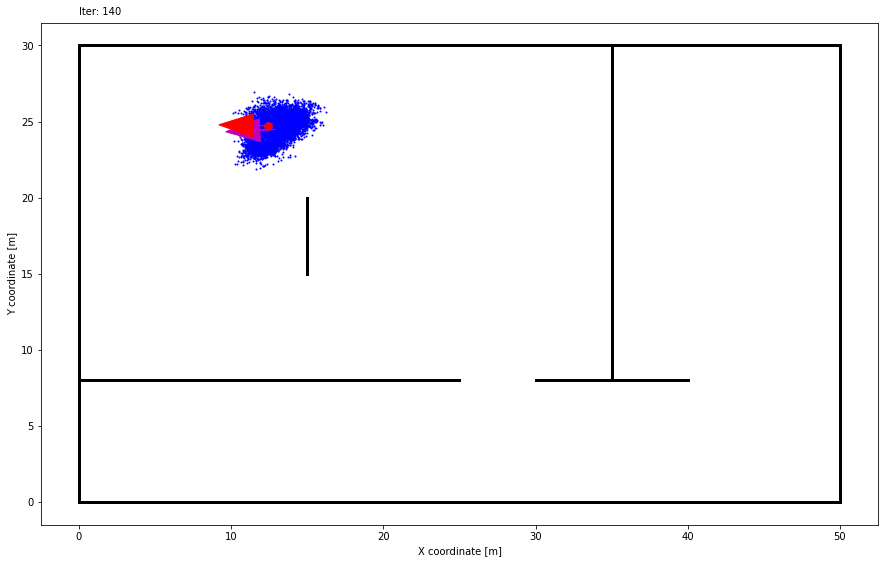

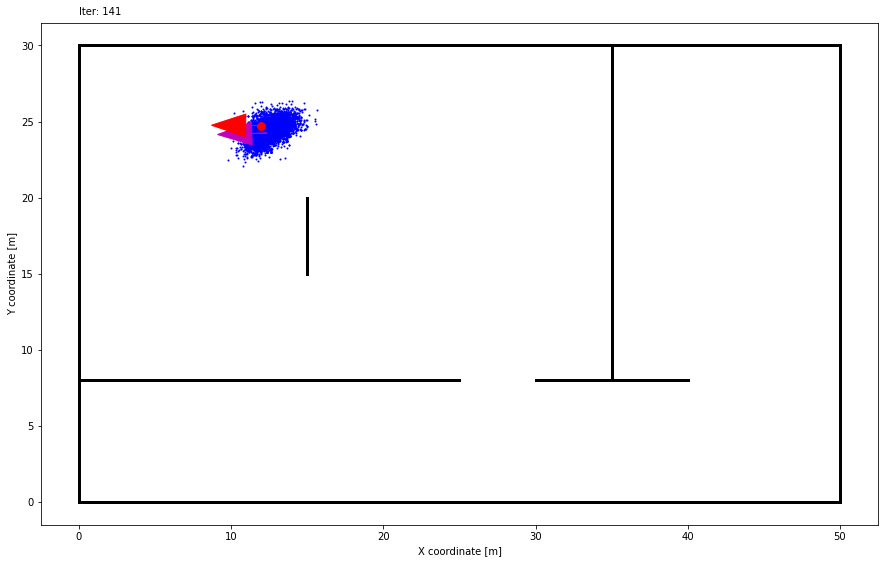

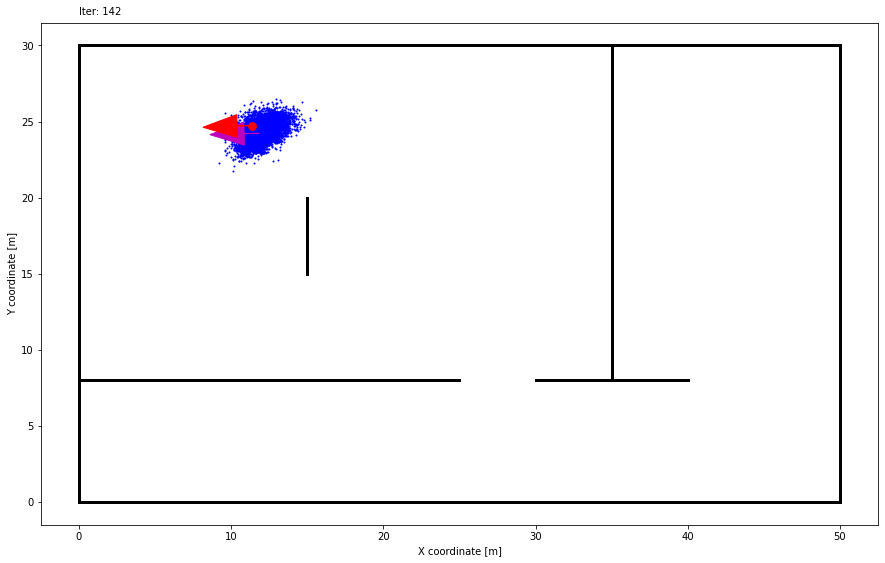

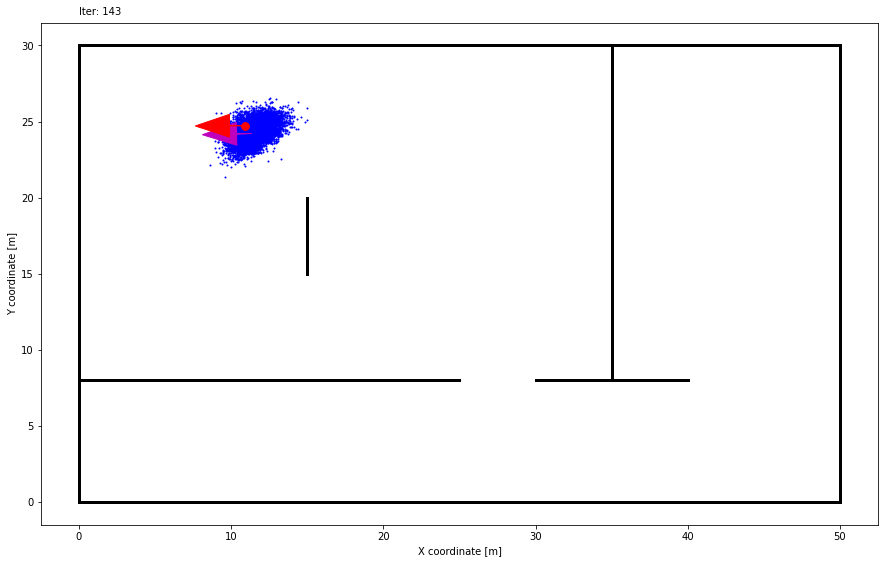

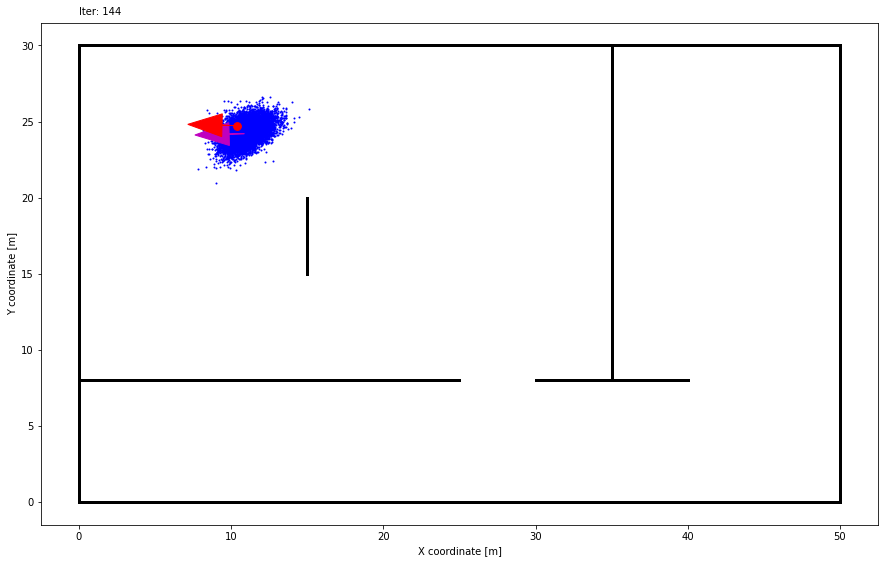

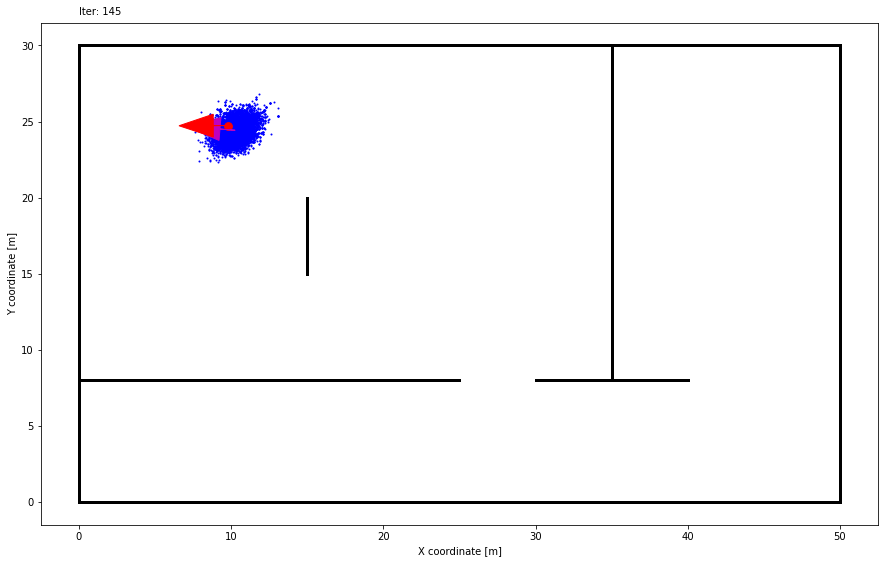

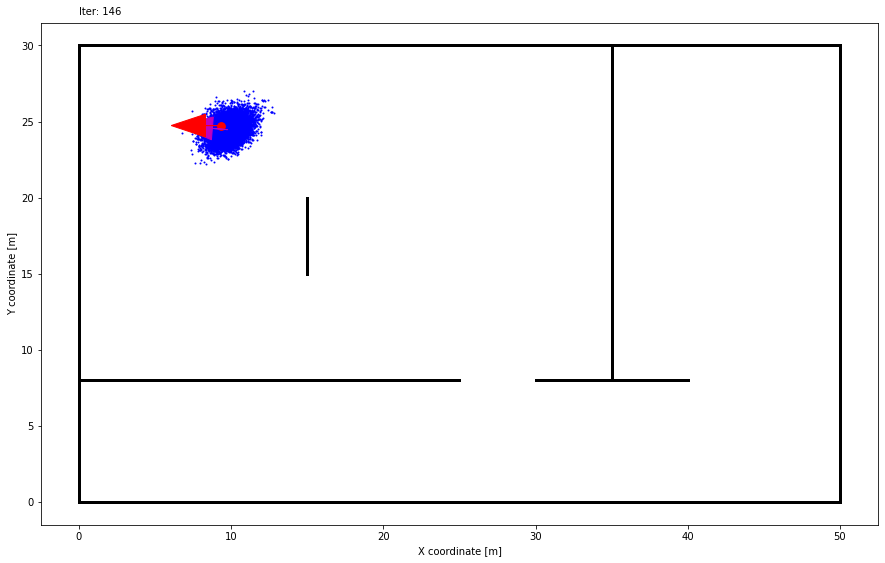

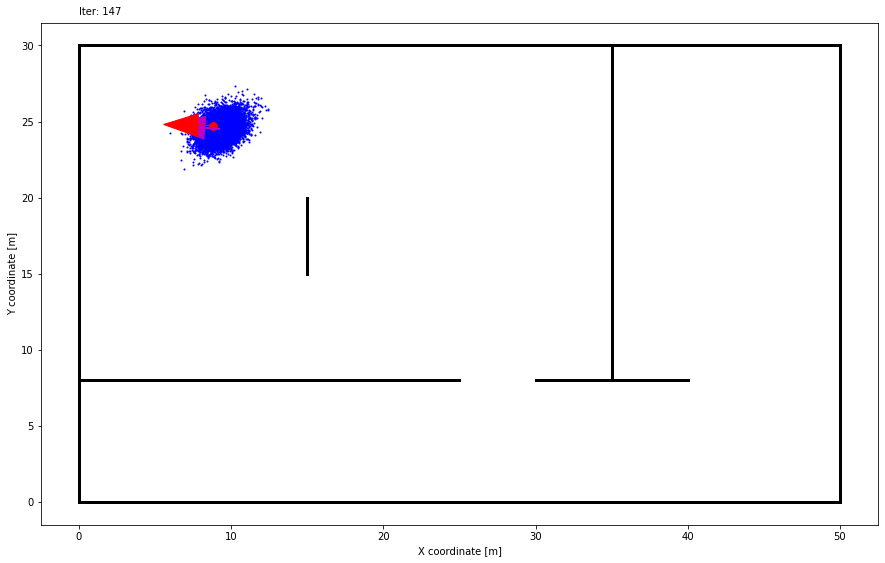

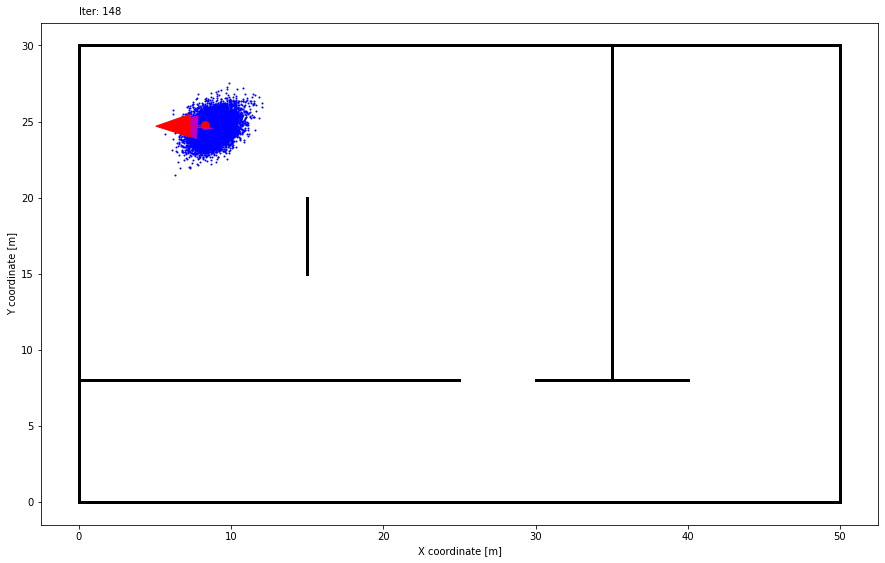

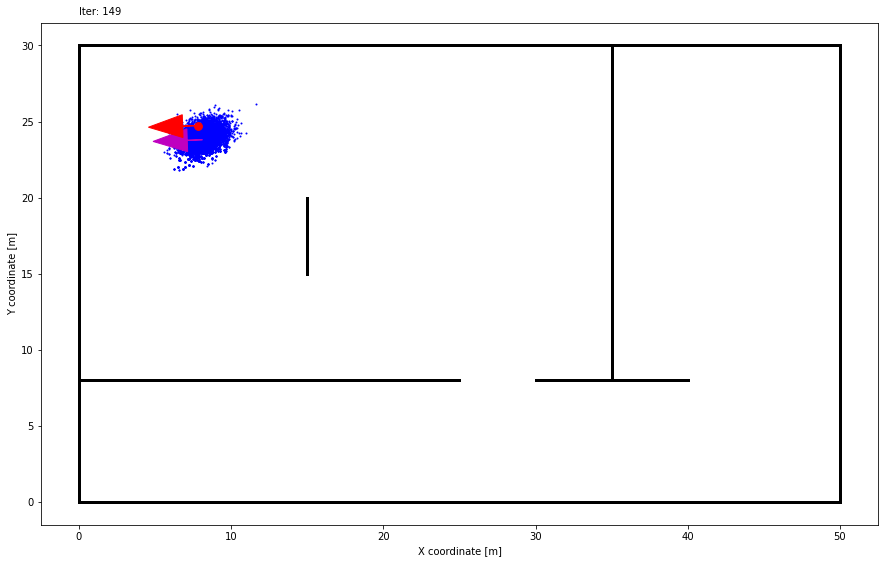

In [117]:
straight = [1, 0]
left = [0, 0.2]

errors_distance = []
errors_angle = []
stddev_x = []
stddev_y = []

savedir = 'animation9/'
n_particles = 10000


particles = np.array([np.random.uniform(0, 50, n_particles),
                      np.random.uniform(0, 30, n_particles),
                      np.random.uniform(0, 2*np.pi, n_particles)])
particles = particles.T

real_robot_pose = [4, 4, 0]

it = 0

plt.figure(figsize=(15,15))
plot_map()
plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), np.sin(real_robot_pose[2]), color='r', head_width=1.5)

plt.text(0, 32, "Iter: " + str(it))
plt.axis("scaled")
plt.xlabel("X coordinate [m]")
plt.ylabel("Y coordinate [m]")

plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.png')


while real_robot_pose[0] < 27:
    # predict
    real_robot_pose = precise_transition(real_robot_pose, straight)
    for i in range(len(particles)):
        particles[i] = transition(particles[i], straight)
    #update
    if it % 4 == 0:
        likelihoods = np.zeros(len(particles))
        real_scan = get_lidar_measurements(real_robot_pose, noisy=True)
        for i in range(len(particles)):
            measurement = get_lidar_measurements(particles[i])
            likelihoods[i] = calculate_likelihood(real_scan, measurement)
        particles = resampling(particles, likelihoods)

    estimated_pose[0] = np.sum(particles[:, 0]*likelihoods) / np.sum(likelihoods)
    estimated_pose[1] = np.sum(particles[:, 1]*likelihoods) / np.sum(likelihoods)
    estimated_pose[2] = np.arctan2(np.sum(np.sin(particles[:, 2])*likelihoods) / \
                                    np.sum(likelihoods), np.sum(np.cos(particles[:, 2])*likelihoods) / np.sum(likelihoods))
    
    errors_distance.append(((estimated_pose[0]-real_robot_pose[0])**2 + (estimated_pose[1]-real_robot_pose[1])**2)**0.5)
    errors_angle.append(np.pi - abs(abs(estimated_pose[2] - real_robot_pose[2]) - np.pi))
    stddev_x.append(np.std(particles[:, 0]))
    stddev_y.append(np.std(particles[:, 1]))

    it += 1
    
    plt.figure(figsize=(15,15))
    plot_map()
    plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
    plt.arrow(estimated_pose[0], estimated_pose[1], np.cos(estimated_pose[2]), \
              np.sin(estimated_pose[2]), color='m', head_width=1.5)
    plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
    plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), \
              np.sin(real_robot_pose[2]), color='r', head_width=1.5)
    plt.text(0, 32, "Iter: " + str(it))
    plt.axis("scaled")
    plt.xlabel("X coordinate [m]")
    plt.ylabel("Y coordinate [m]")
    plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.png')
    

while real_robot_pose[2] < np.pi/2 or real_robot_pose[2] > 2*np.pi-0.2:
    # predict
    real_robot_pose = precise_transition(real_robot_pose, left)
    for i in range(len(particles)):
        particles[i] = transition(particles[i], left)
    #update
    if it % 4 == 0:
        likelihoods = np.zeros(len(particles))
        real_scan = get_lidar_measurements(real_robot_pose, noisy=True)
        for i in range(len(particles)):
            measurement = get_lidar_measurements(particles[i])
            likelihoods[i] = calculate_likelihood(real_scan, measurement)
        particles = resampling(particles, likelihoods)

    estimated_pose[0] = np.sum(particles[:, 0]*likelihoods) / np.sum(likelihoods)
    estimated_pose[1] = np.sum(particles[:, 1]*likelihoods) / np.sum(likelihoods)
    estimated_pose[2] = np.arctan2(np.sum(np.sin(particles[:, 2])*likelihoods) / \
                                   np.sum(likelihoods), np.sum(np.cos(particles[:, 2])*likelihoods) / np.sum(likelihoods))
    
    errors_distance.append(((estimated_pose[0]-real_robot_pose[0])**2 + (estimated_pose[1]-real_robot_pose[1])**2)**0.5)
    errors_angle.append(np.pi - abs(abs(estimated_pose[2] - real_robot_pose[2]) - np.pi))
    stddev_x.append(np.std(particles[:, 0]))
    stddev_y.append(np.std(particles[:, 1]))

    it += 1
    
    plt.figure(figsize=(15,15))
    plot_map()
    plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
    plt.arrow(estimated_pose[0], estimated_pose[1], np.cos(estimated_pose[2]),\
               np.sin(estimated_pose[2]), color='m', head_width=1.5)
    plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
    plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), \
              np.sin(real_robot_pose[2]), color='r', head_width=1.5)
    plt.text(0, 32, "Iter: " + str(it))
    plt.axis("scaled")
    plt.xlabel("X coordinate [m]")
    plt.ylabel("Y coordinate [m]")
    plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.png')
    
    
while real_robot_pose[1] < 25:
    # predict
    real_robot_pose = precise_transition(real_robot_pose, straight)
    for i in range(len(particles)):
        particles[i] = transition(particles[i], straight)
    #update
    if it % 4 == 0:
        likelihoods = np.zeros(len(particles))
        real_scan = get_lidar_measurements(real_robot_pose, noisy=True)
        for i in range(len(particles)):
            measurement = get_lidar_measurements(particles[i])
            likelihoods[i] = calculate_likelihood(real_scan, measurement)
        particles = resampling(particles, likelihoods)

    estimated_pose[0] = np.sum(particles[:, 0]*likelihoods) / np.sum(likelihoods)
    estimated_pose[1] = np.sum(particles[:, 1]*likelihoods) / np.sum(likelihoods)
    estimated_pose[2] = np.arctan2(np.sum(np.sin(particles[:, 2])*likelihoods) / \
                                   np.sum(likelihoods), np.sum(np.cos(particles[:, 2])*likelihoods) / np.sum(likelihoods))
    
    errors_distance.append(((estimated_pose[0]-real_robot_pose[0])**2 + (estimated_pose[1]-real_robot_pose[1])**2)**0.5)
    errors_angle.append(np.pi - abs(abs(estimated_pose[2] - real_robot_pose[2]) - np.pi))
    stddev_x.append(np.std(particles[:, 0]))
    stddev_y.append(np.std(particles[:, 1]))

    it += 1
    
    plt.figure(figsize=(15,15))
    plot_map()
    plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
    plt.arrow(estimated_pose[0], estimated_pose[1], np.cos(estimated_pose[2]), \
              np.sin(estimated_pose[2]), color='m', head_width=1.5)
    plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
    plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), \
               np.sin(real_robot_pose[2]), color='r', head_width=1.5)
    plt.text(0, 32, "Iter: " + str(it))
    plt.axis("scaled")
    plt.xlabel("X coordinate [m]")
    plt.ylabel("Y coordinate [m]")
    plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.png')
    
    
while real_robot_pose[2] < np.pi:
    # predict
    real_robot_pose = precise_transition(real_robot_pose, left)
    for i in range(len(particles)):
        particles[i] = transition(particles[i], left)
    #update
    if it % 4 == 0:
        likelihoods = np.zeros(len(particles))
        real_scan = get_lidar_measurements(real_robot_pose, noisy=True)
        for i in range(len(particles)):
            measurement = get_lidar_measurements(particles[i])
            likelihoods[i] = calculate_likelihood(real_scan, measurement)
        particles = resampling(particles, likelihoods)

    estimated_pose[0] = np.sum(particles[:, 0]*likelihoods) / np.sum(likelihoods)
    estimated_pose[1] = np.sum(particles[:, 1]*likelihoods) / np.sum(likelihoods)
    estimated_pose[2] = np.arctan2(np.sum(np.sin(particles[:, 2])*likelihoods) / \
                                   np.sum(likelihoods), np.sum(np.cos(particles[:, 2])*likelihoods) / np.sum(likelihoods))
    
    errors_distance.append(((estimated_pose[0]-real_robot_pose[0])**2 + (estimated_pose[1]-real_robot_pose[1])**2)**0.5)
    errors_angle.append(np.pi - abs(abs(estimated_pose[2] - real_robot_pose[2]) - np.pi))
    stddev_x.append(np.std(particles[:, 0]))
    stddev_y.append(np.std(particles[:, 1]))

    it += 1
    
    plt.figure(figsize=(15,15))
    plot_map()
    plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
    plt.arrow(estimated_pose[0], estimated_pose[1], np.cos(estimated_pose[2]), \
               np.sin(estimated_pose[2]), color='m', head_width=1.5)
    plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
    plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), \
              np.sin(real_robot_pose[2]), color='r', head_width=1.5)
    plt.text(0, 32, "Iter: " + str(it))
    plt.axis("scaled")
    plt.xlabel("X coordinate [m]")
    plt.ylabel("Y coordinate [m]")
    plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.png')
    

while real_robot_pose[0] > 8:
    # predict
    real_robot_pose = precise_transition(real_robot_pose, straight)
    for i in range(len(particles)):
        particles[i] = transition(particles[i], straight)
    #update
    if it % 4 == 0:
        likelihoods = np.zeros(len(particles))
        real_scan = get_lidar_measurements(real_robot_pose, noisy=True)
        for i in range(len(particles)):
            measurement = get_lidar_measurements(particles[i])
            likelihoods[i] = calculate_likelihood(real_scan, measurement)
        particles = resampling(particles, likelihoods)

    estimated_pose[0] = np.sum(particles[:, 0]*likelihoods) / np.sum(likelihoods)
    estimated_pose[1] = np.sum(particles[:, 1]*likelihoods) / np.sum(likelihoods)
    estimated_pose[2] = np.arctan2(np.sum(np.sin(particles[:, 2])*likelihoods) / \
                                   np.sum(likelihoods), np.sum(np.cos(particles[:, 2])*likelihoods) / np.sum(likelihoods))
    
    errors_distance.append(((estimated_pose[0]-real_robot_pose[0])**2 + (estimated_pose[1]-real_robot_pose[1])**2)**0.5)
    errors_angle.append(np.pi - abs(abs(estimated_pose[2] - real_robot_pose[2]) - np.pi))
    stddev_x.append(np.std(particles[:, 0]))
    stddev_y.append(np.std(particles[:, 1]))

    it += 1
    
    plt.figure(figsize=(15,15))
    plot_map()
    plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
    plt.arrow(estimated_pose[0], estimated_pose[1], np.cos(estimated_pose[2]), \
               np.sin(estimated_pose[2]), color='m', head_width=1.5)
    plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
    plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), \
              np.sin(real_robot_pose[2]), color='r', head_width=1.5)
    plt.text(0, 32, "Iter: " + str(it))
    plt.axis("scaled")
    plt.xlabel("X coordinate [m]")
    plt.ylabel("Y coordinate [m]")
    plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.png')

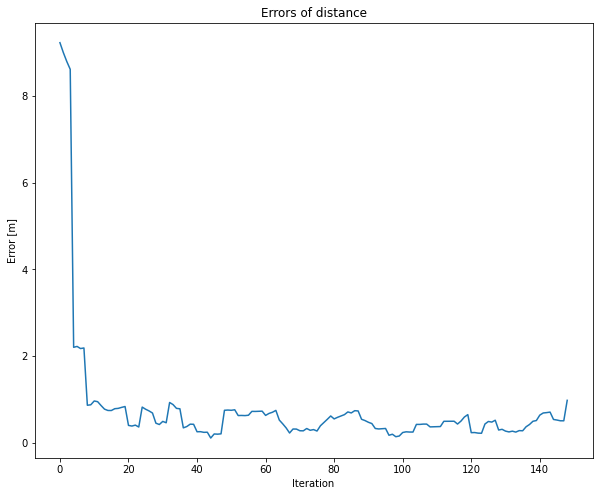

In [124]:
plt.figure(figsize=(10,8))
plt.plot(errors_distance)
plt.title("Errors of distance")
plt.xlabel("Iteration")
plt.ylabel("Error [m]")
plt.show()

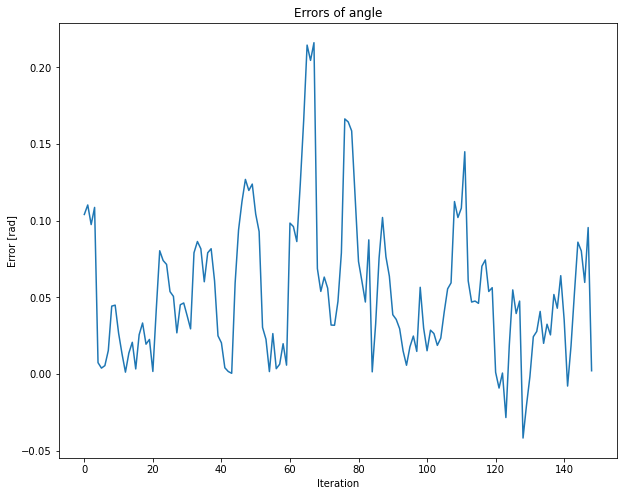

In [125]:
plt.figure(figsize=(10,8))
plt.plot(errors_angle)
plt.title("Errors of angle")
plt.xlabel("Iteration")
plt.ylabel("Error [rad]")
plt.show()

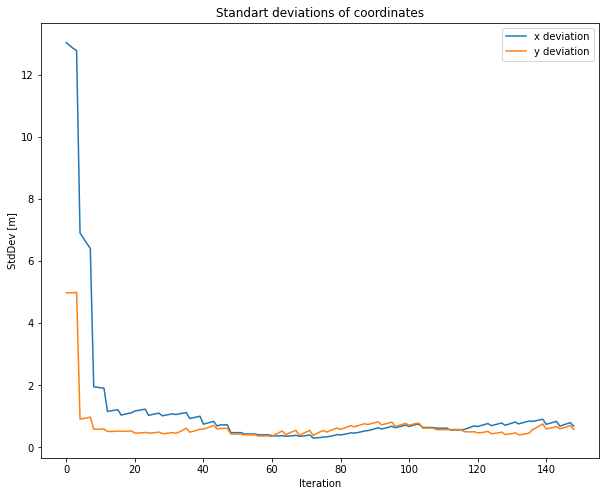

In [127]:
plt.figure(figsize=(10,8))
plt.plot(stddev_x, label="x deviation")
plt.plot(stddev_y, label="y deviation")
plt.title("Standart deviations of coordinates")
plt.xlabel("Iteration")
plt.ylabel("StdDev [m]")
plt.legend()
plt.show()

In [128]:
# Сделать изменение масштаба до добавления точек!

<ipython-input-129-e5a78ab3fc75>:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,15))


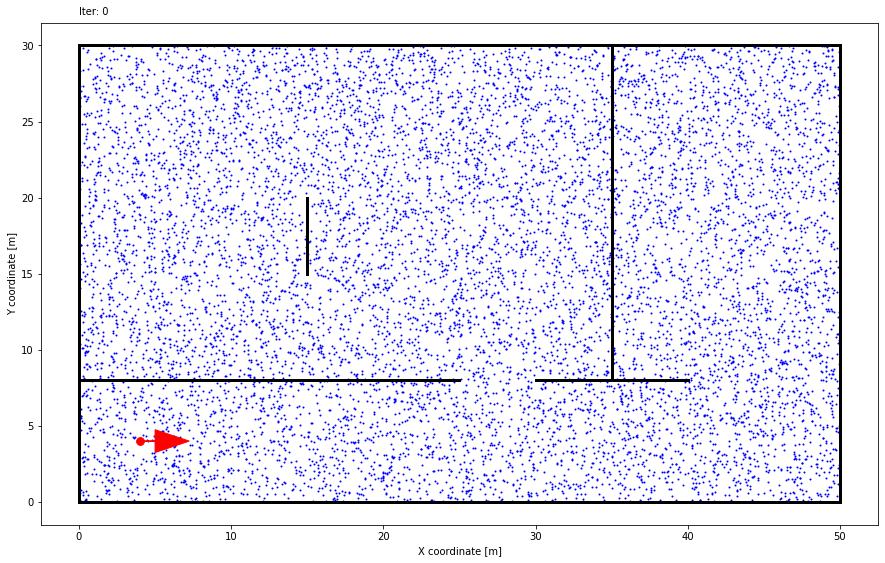

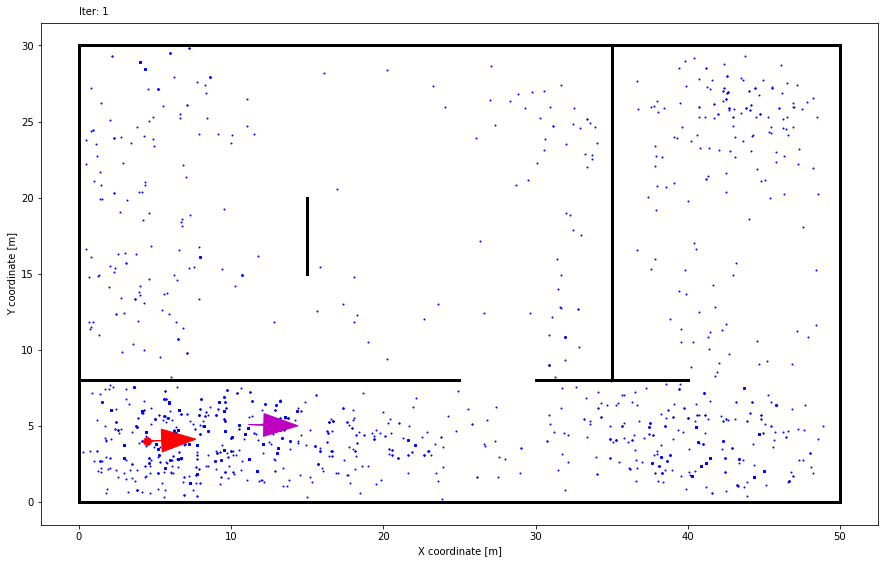

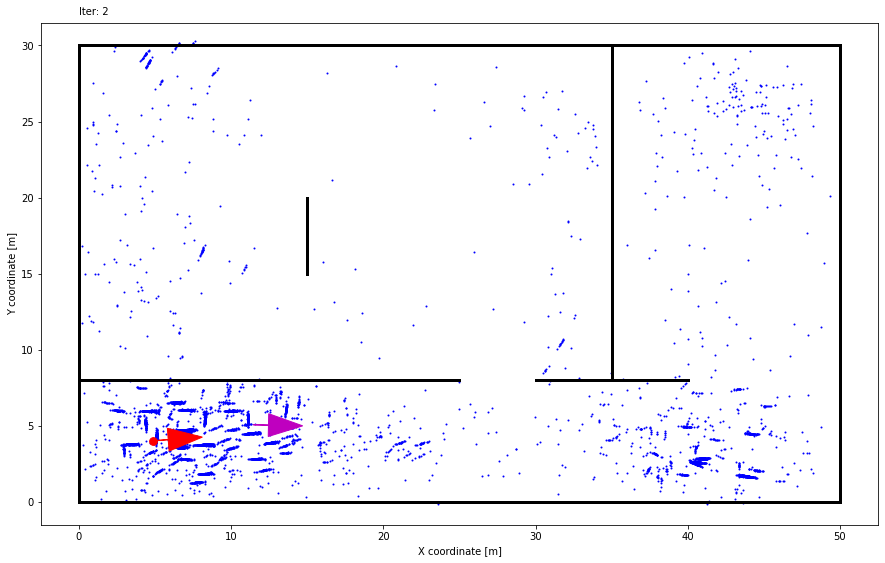

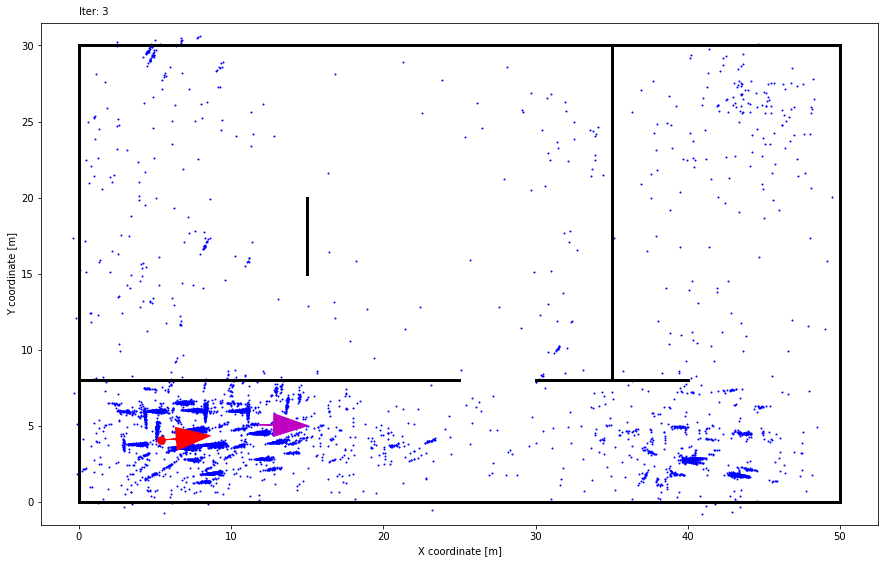

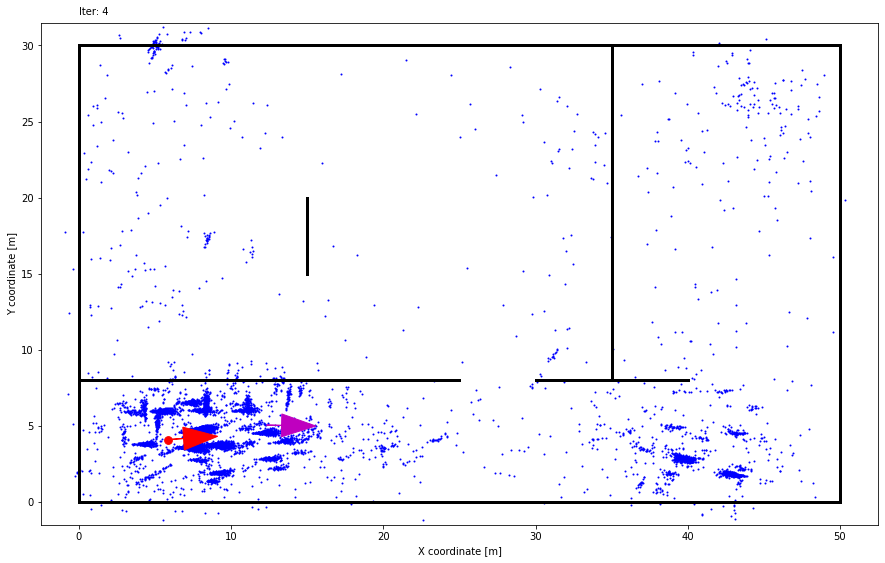

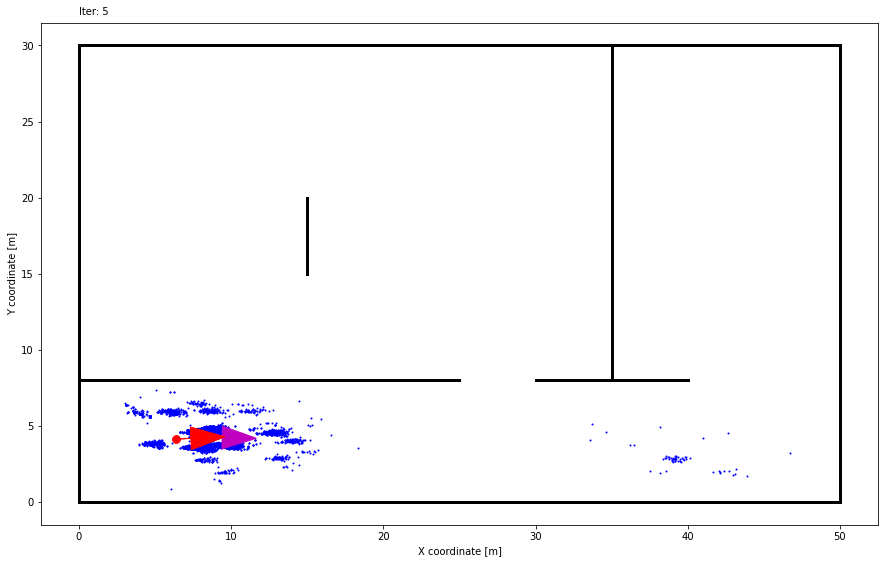

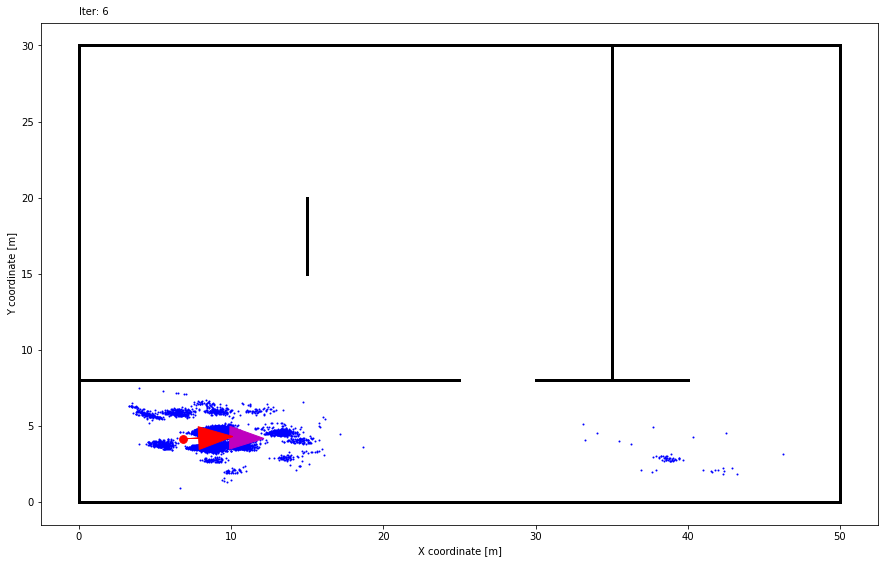

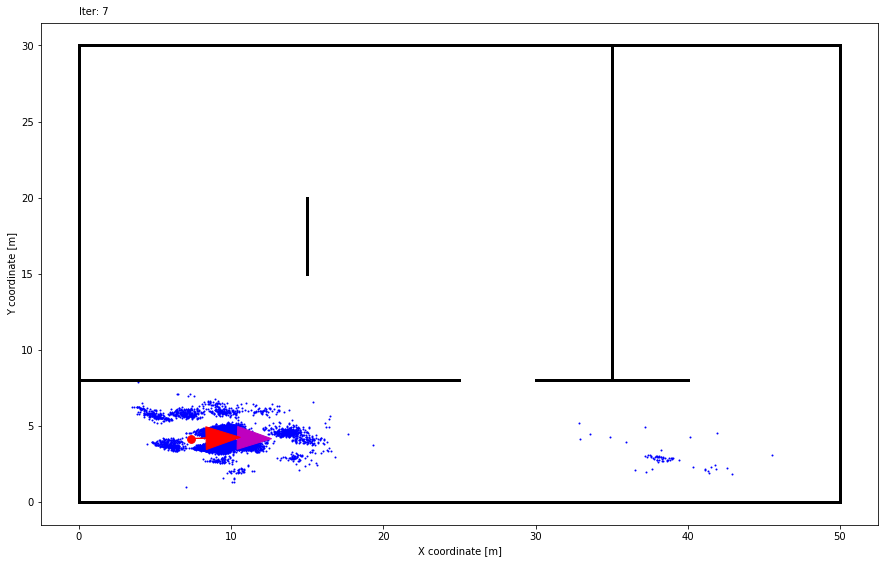

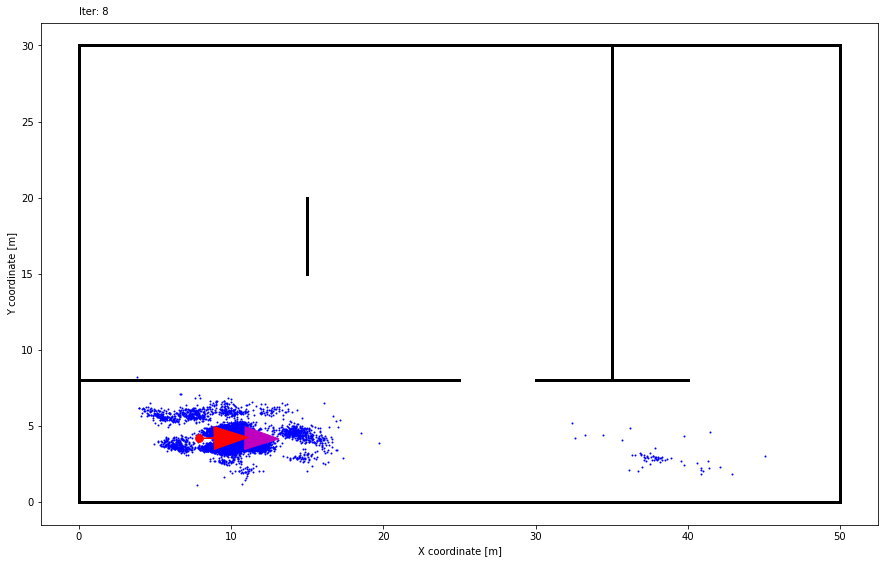

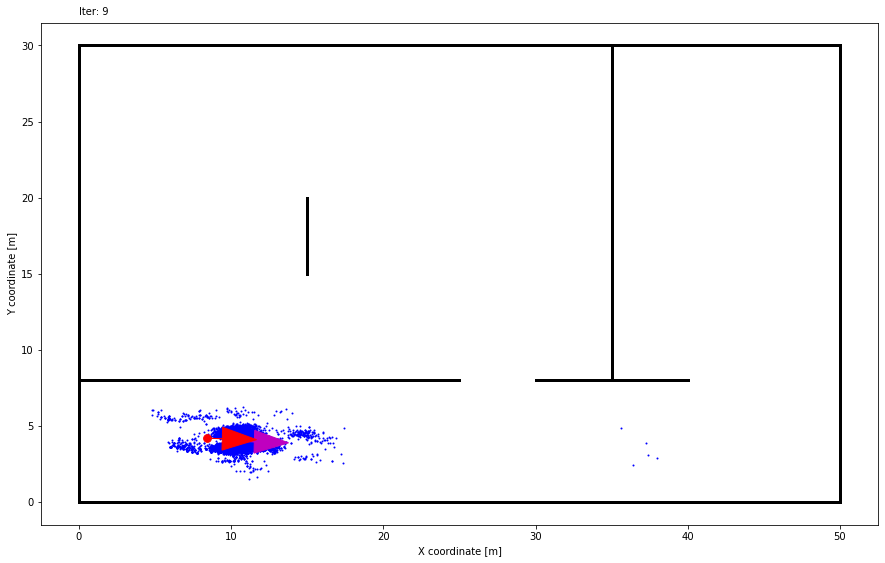

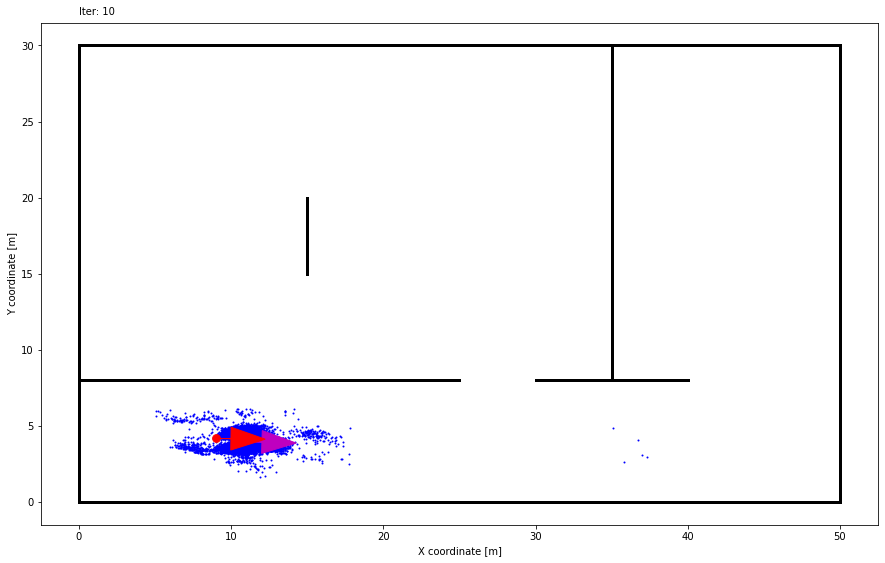

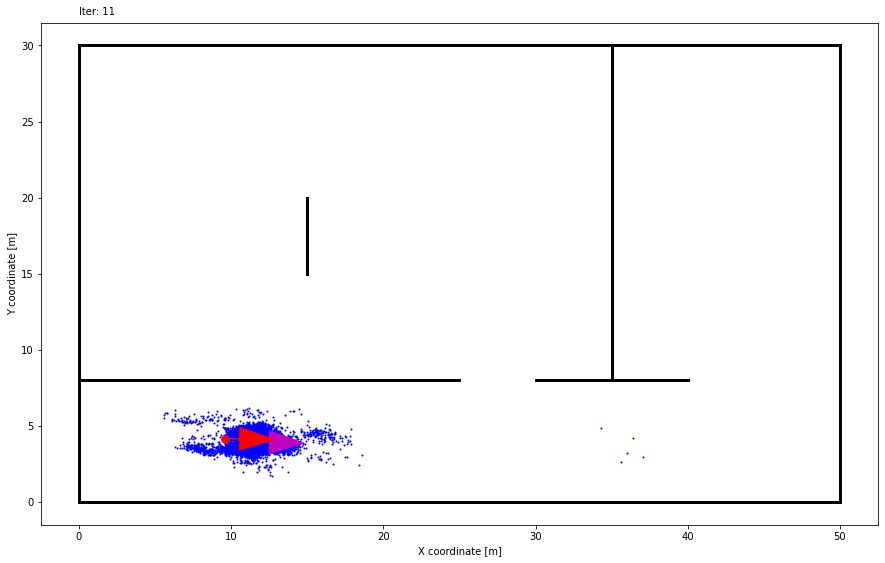

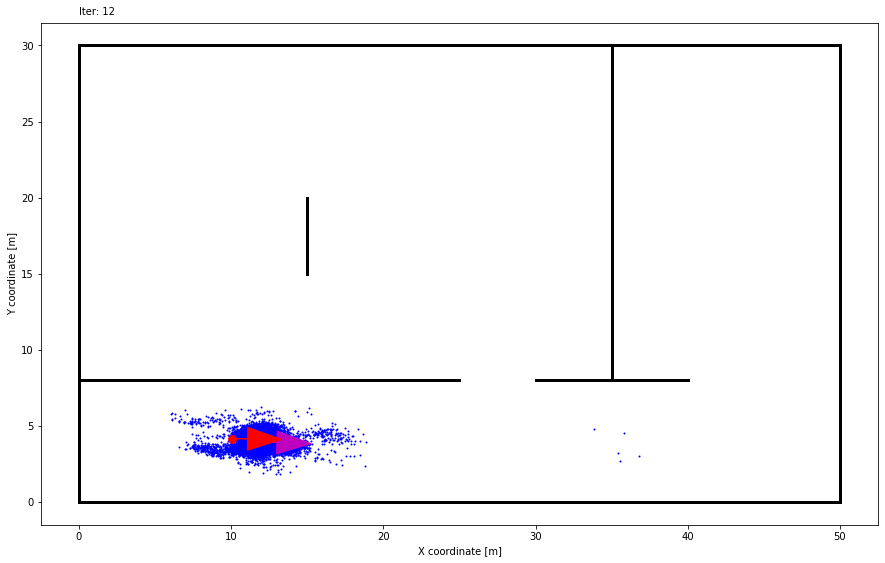

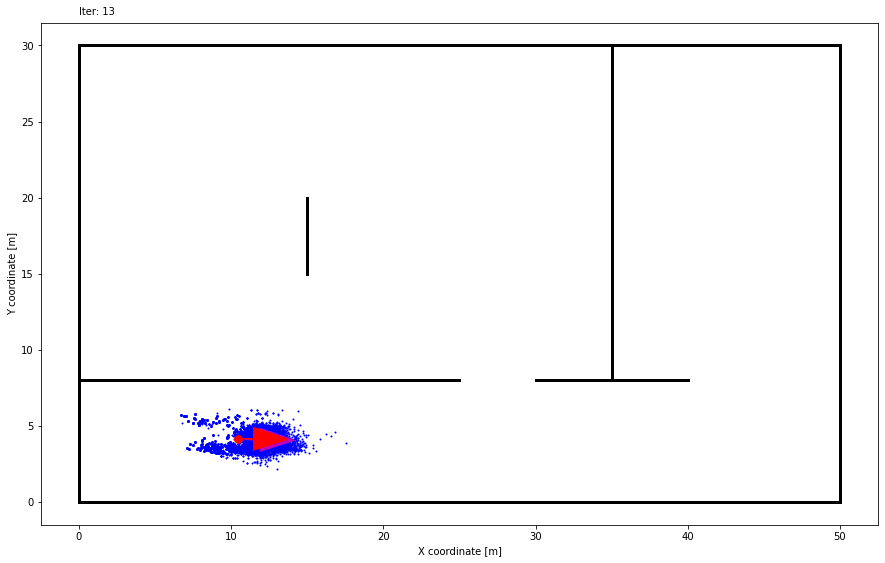

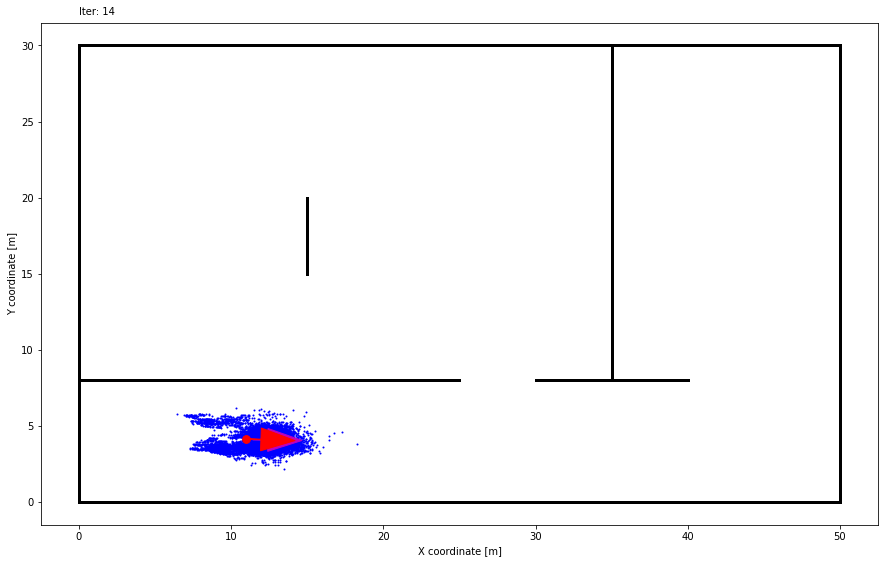

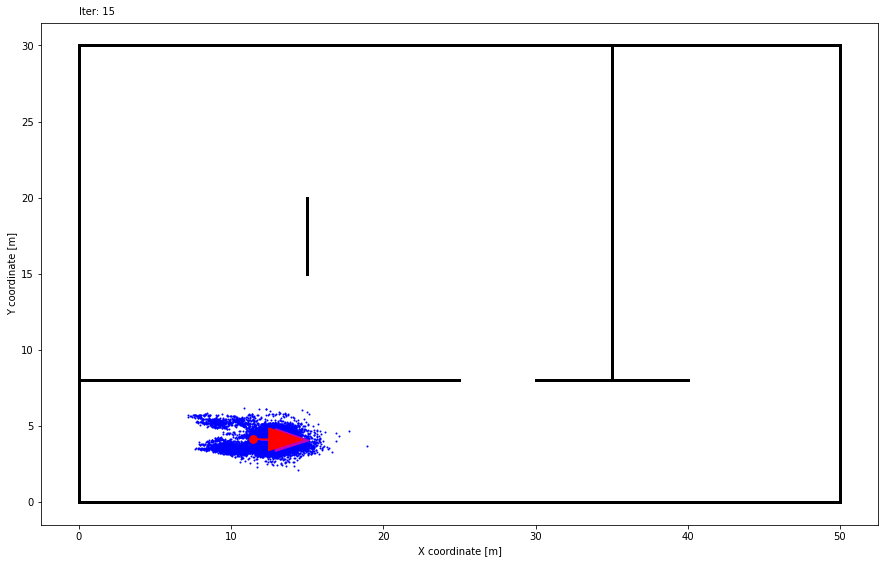

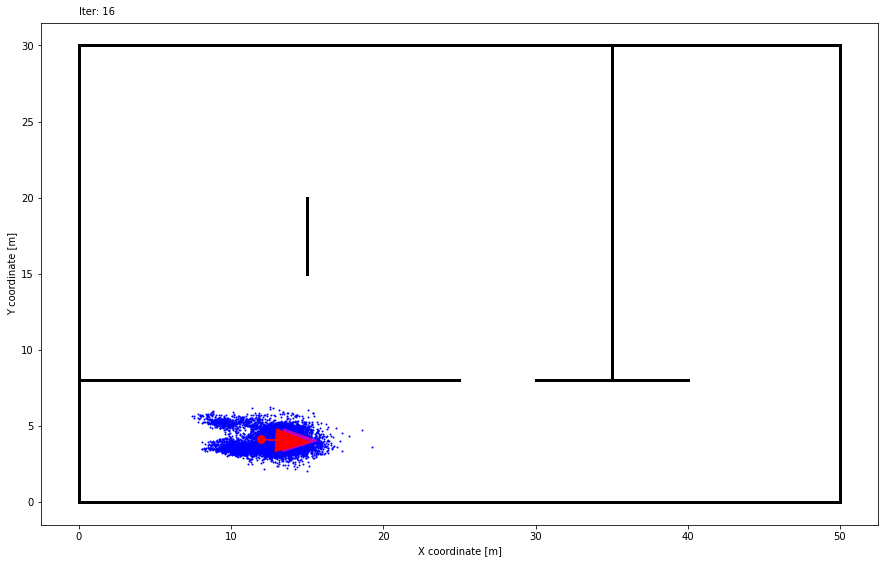

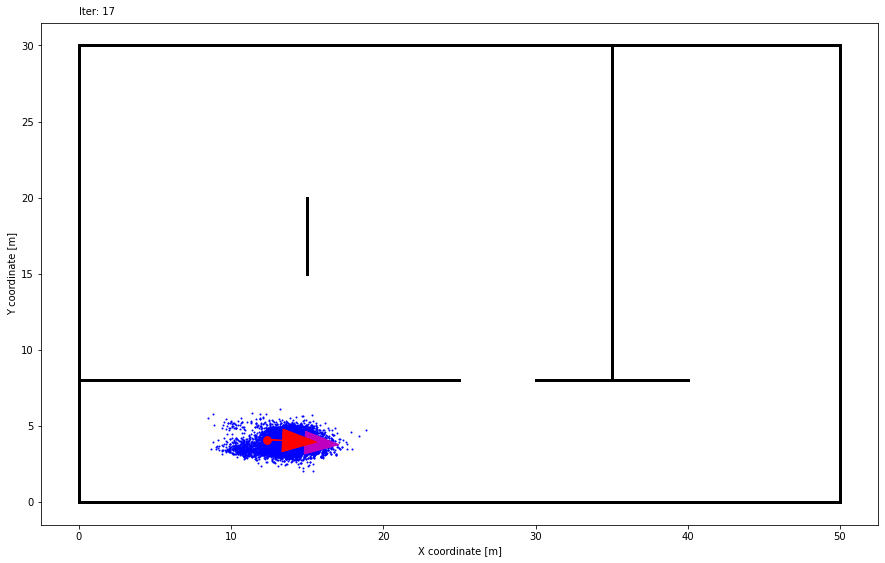

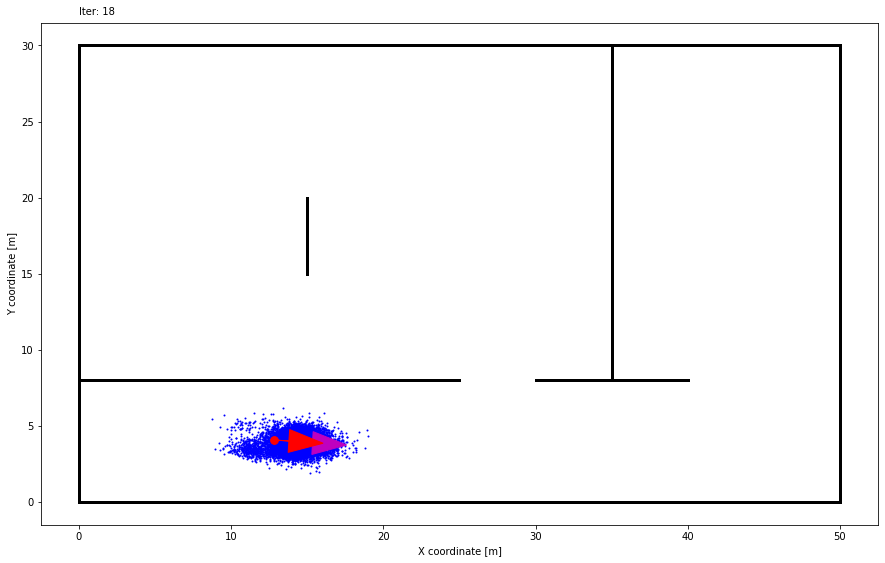

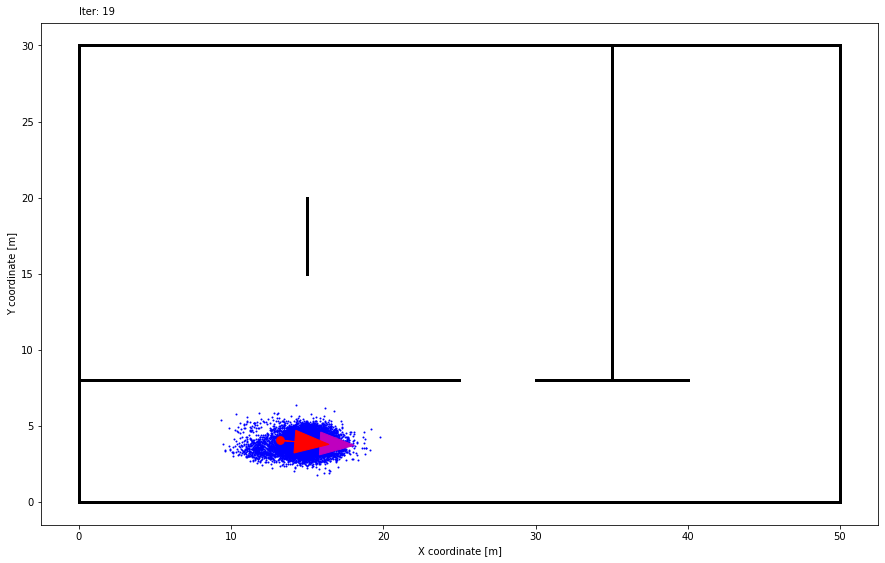

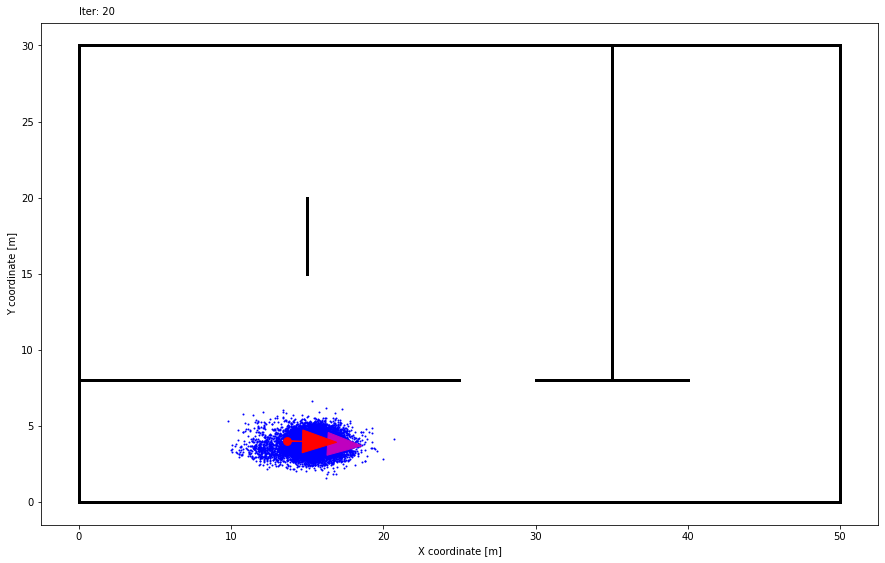

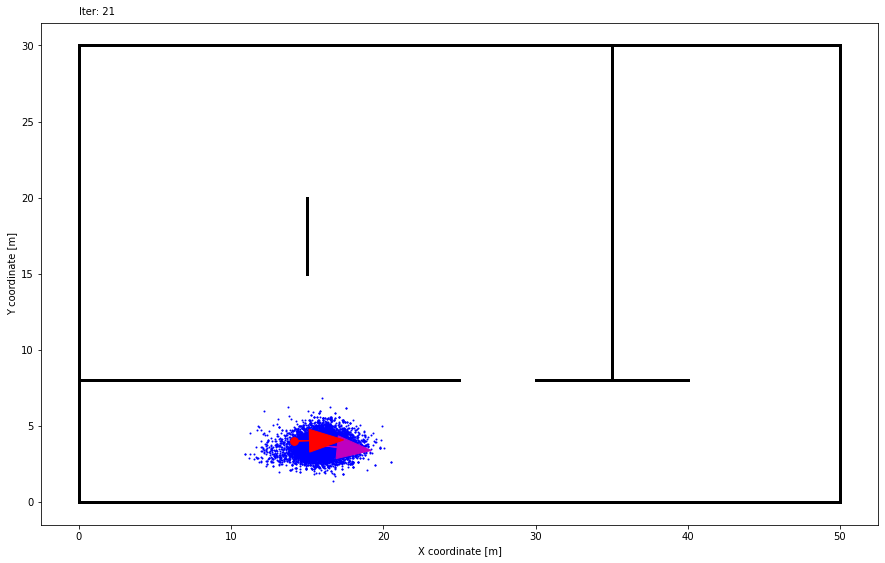

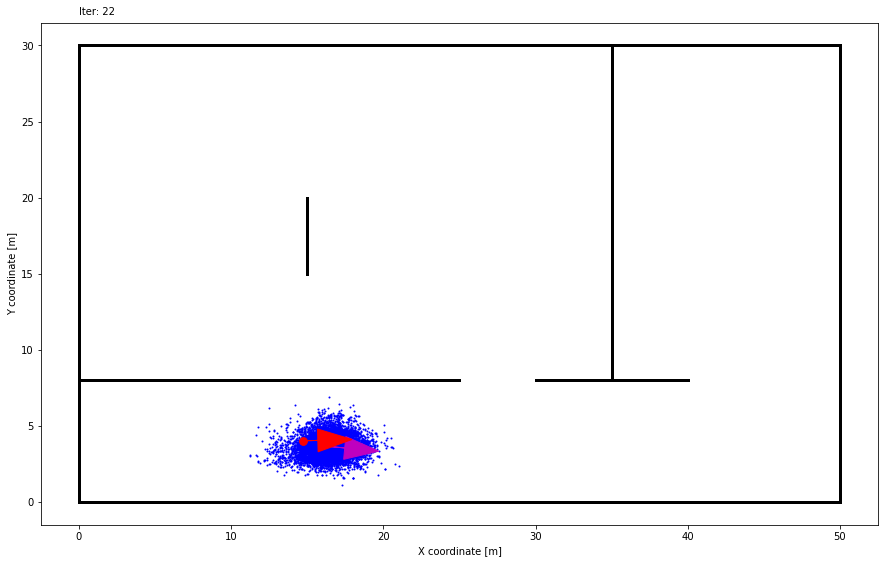

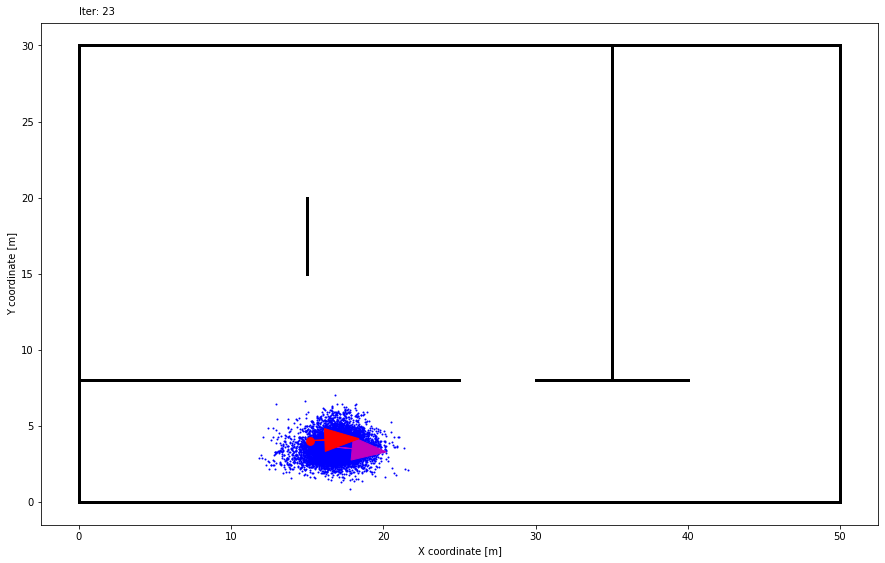

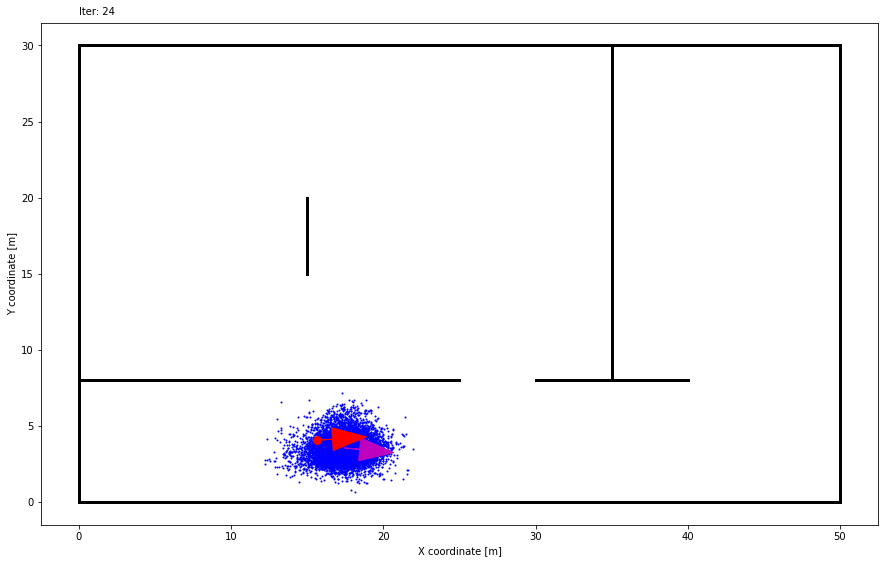

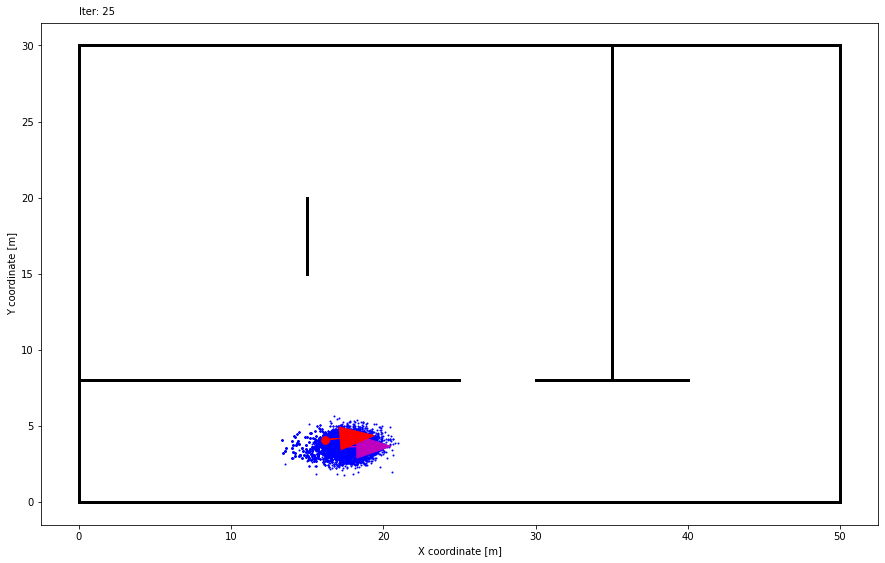

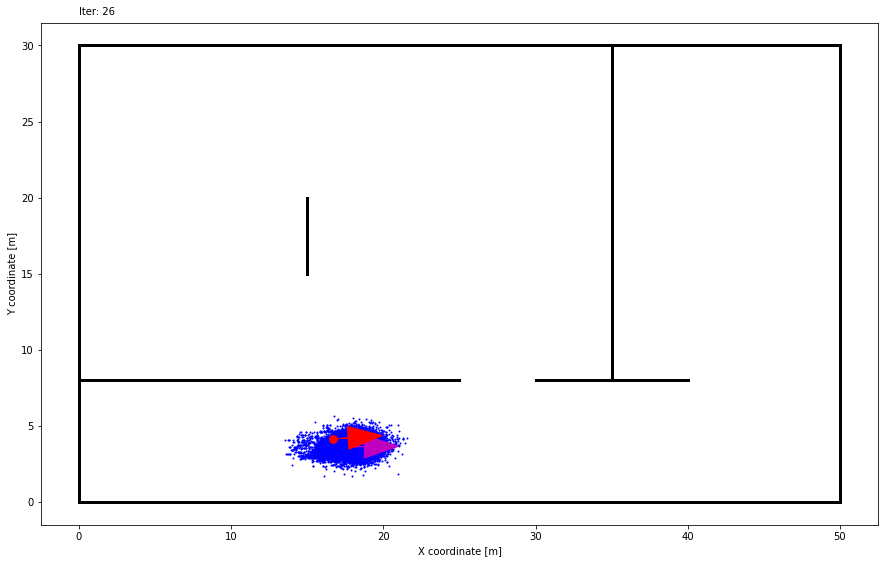

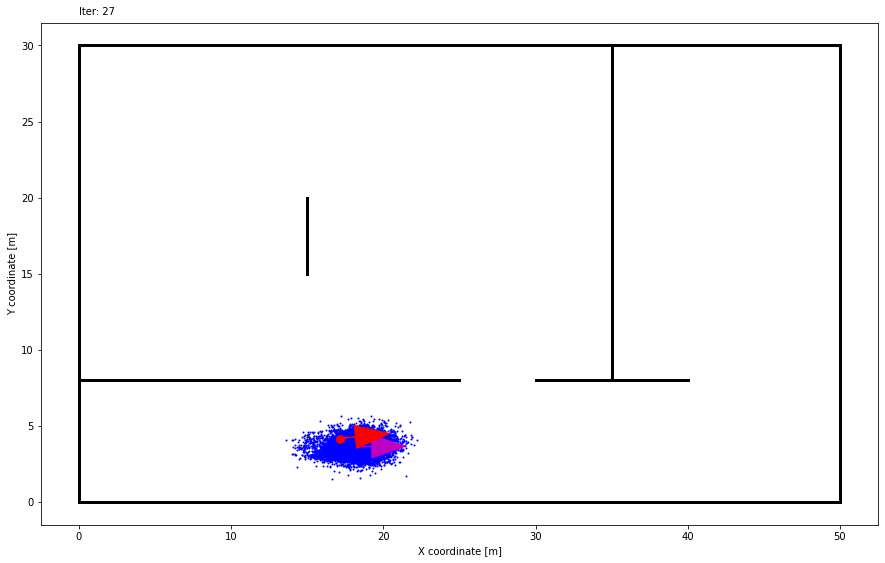

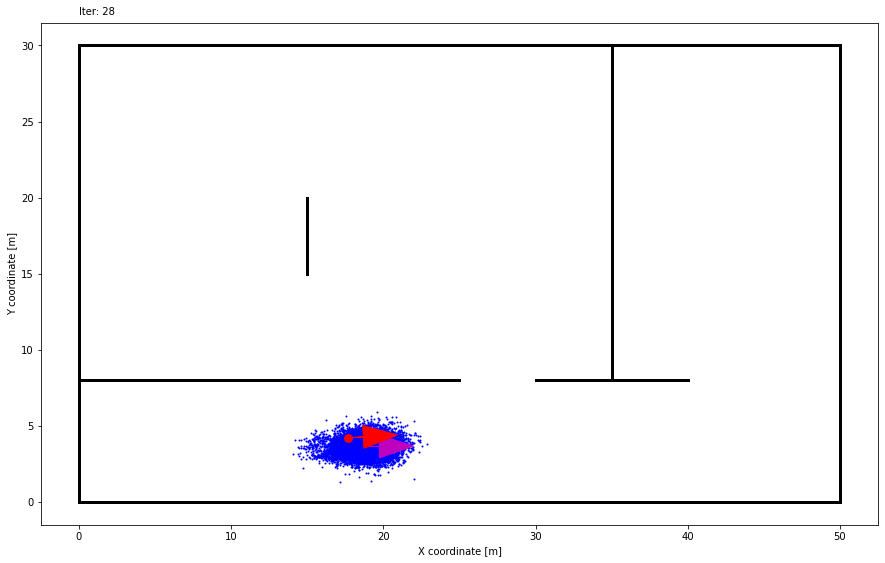

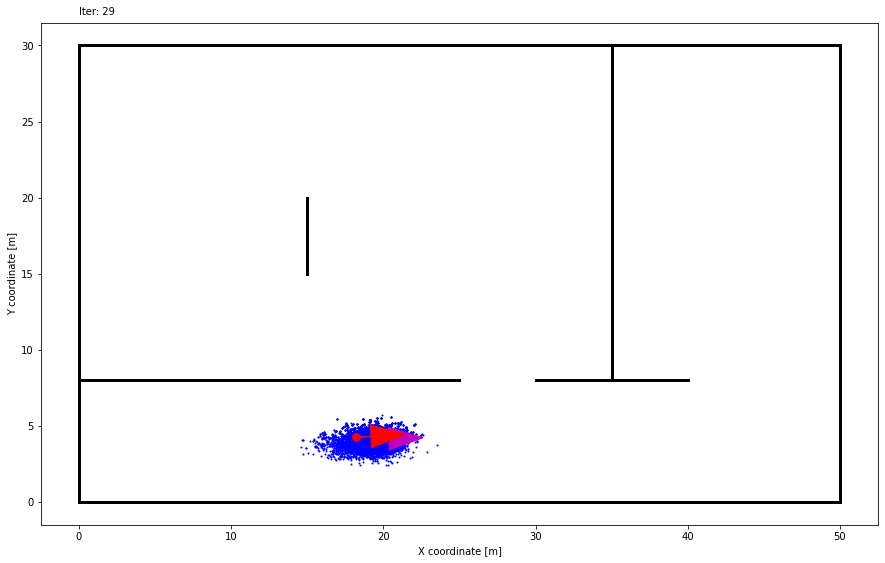

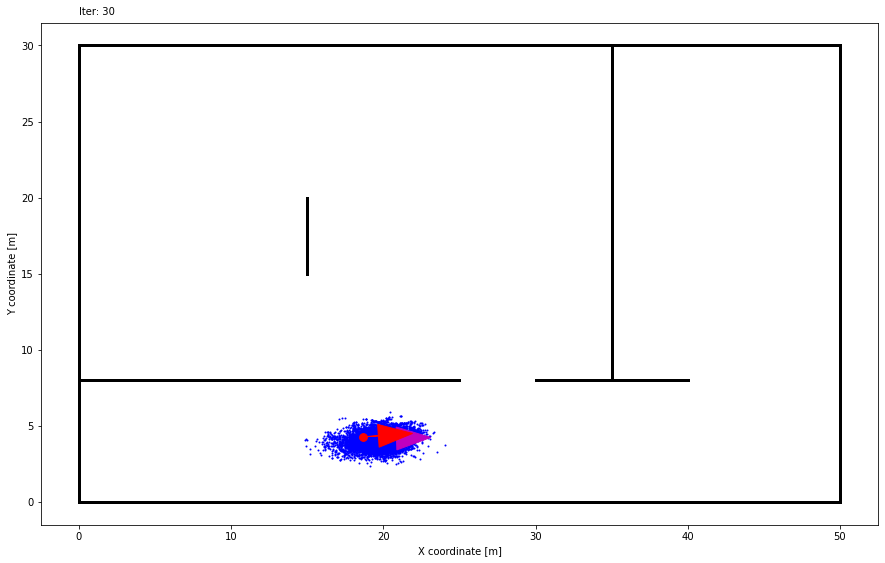

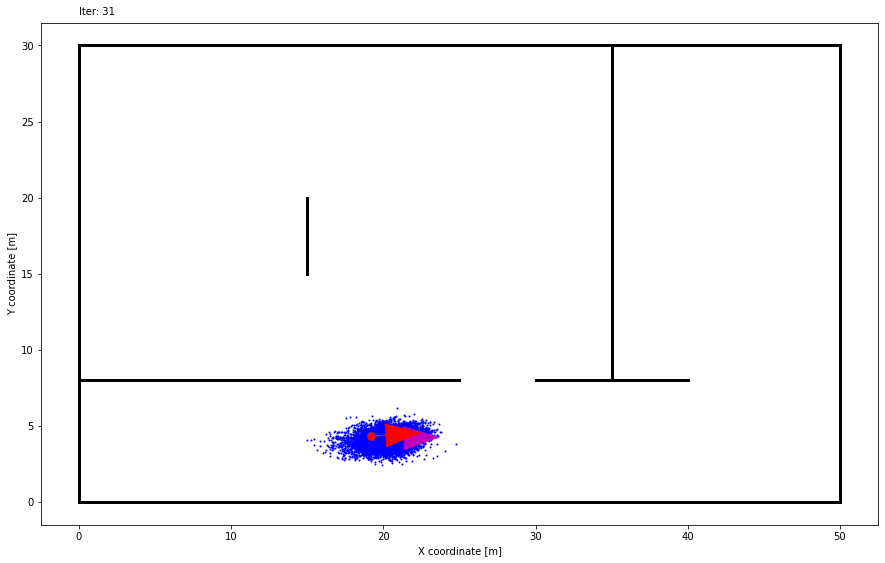

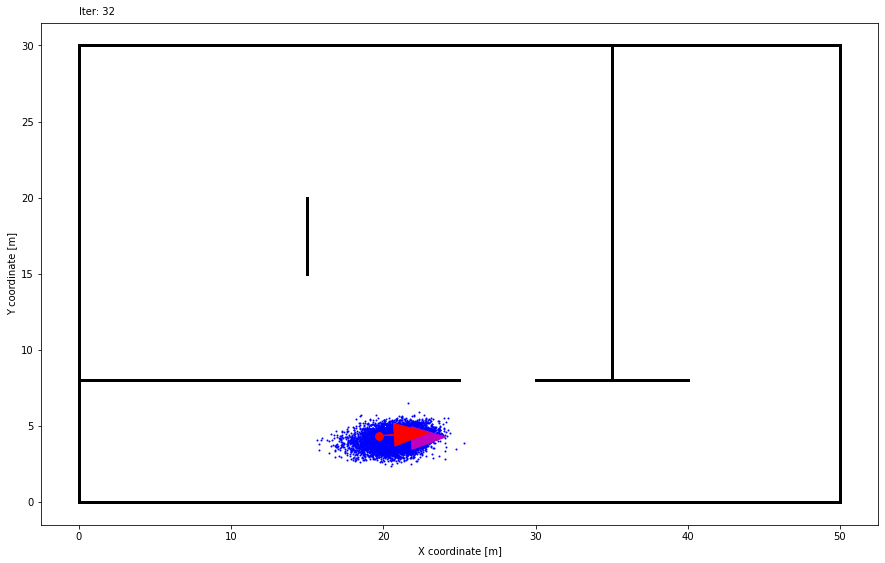

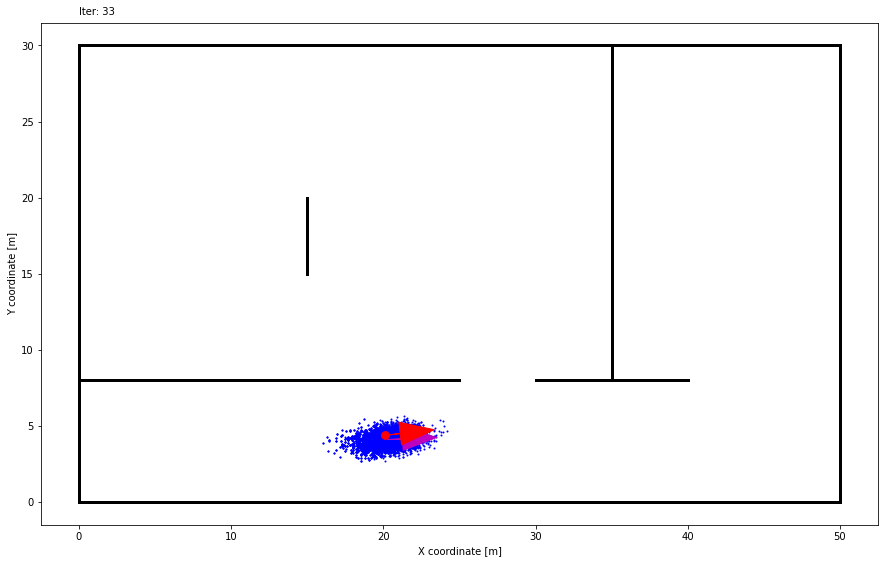

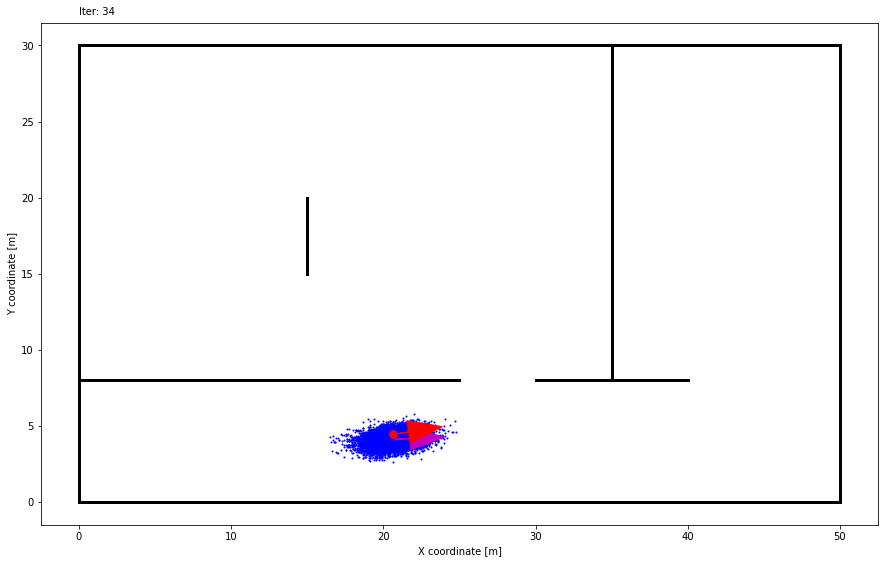

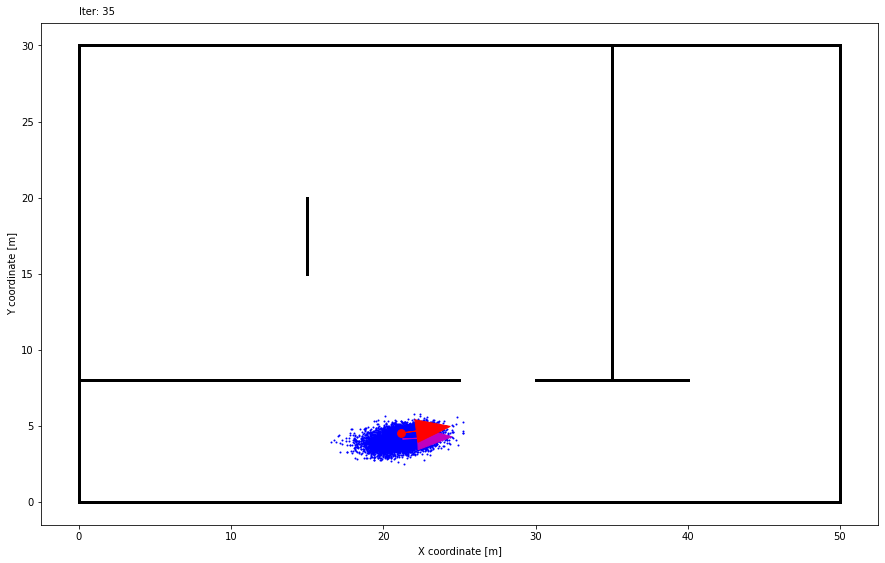

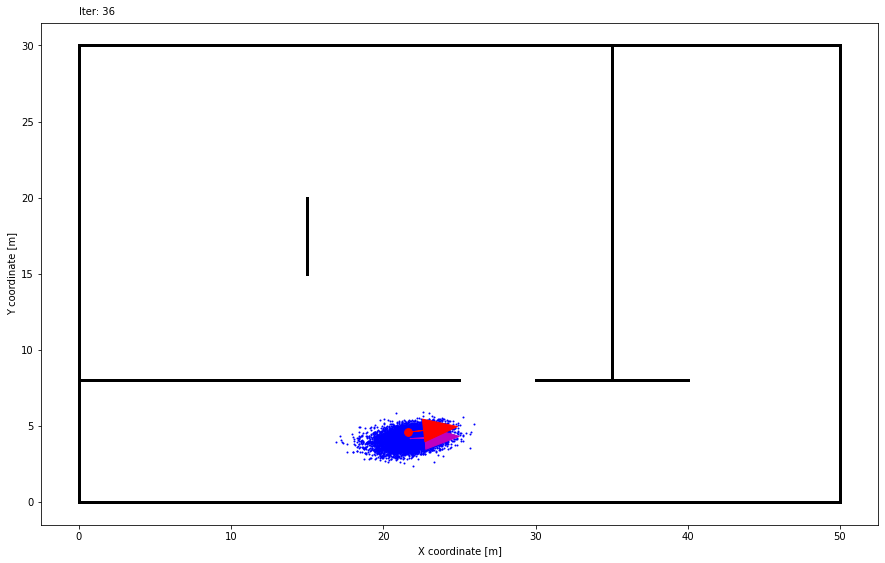

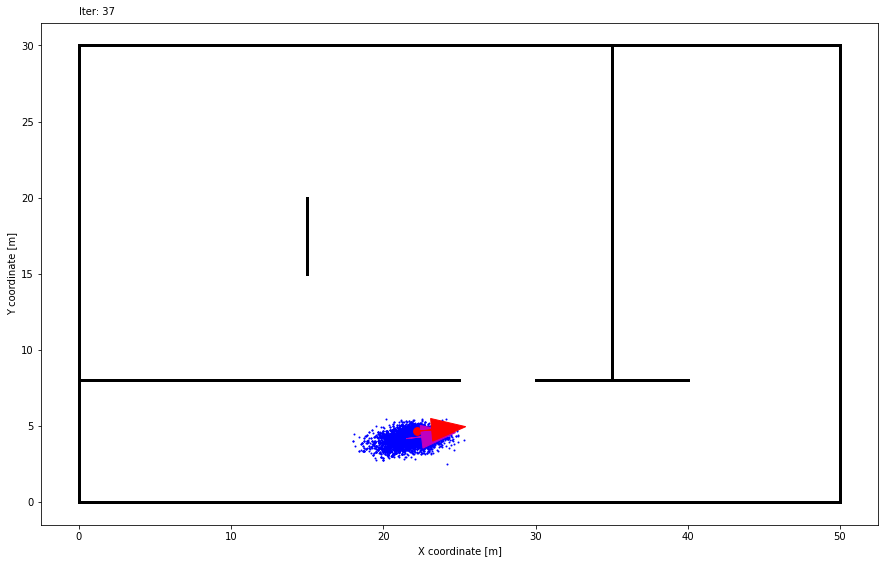

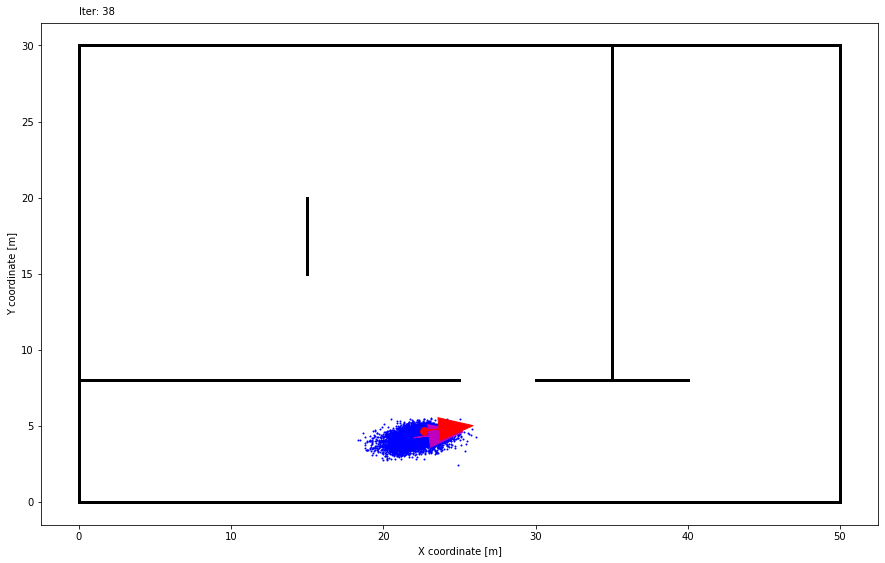

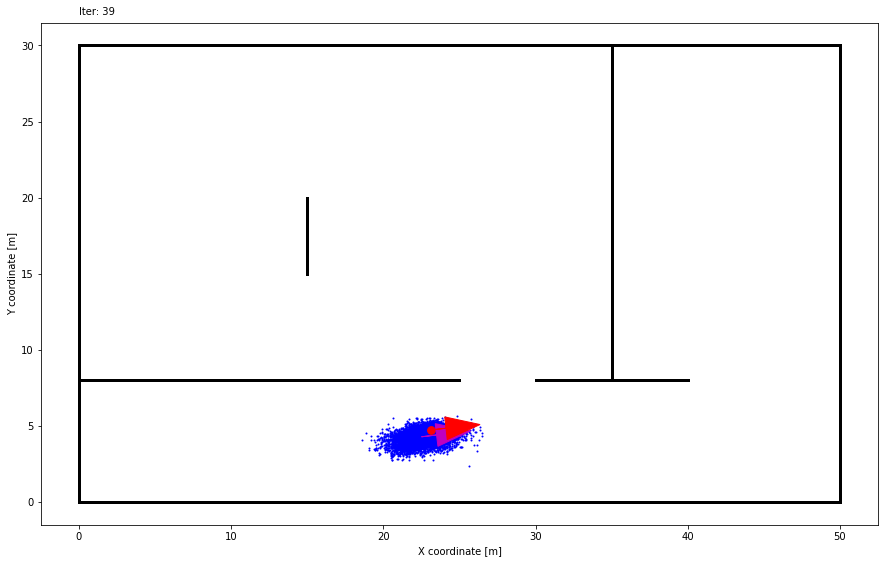

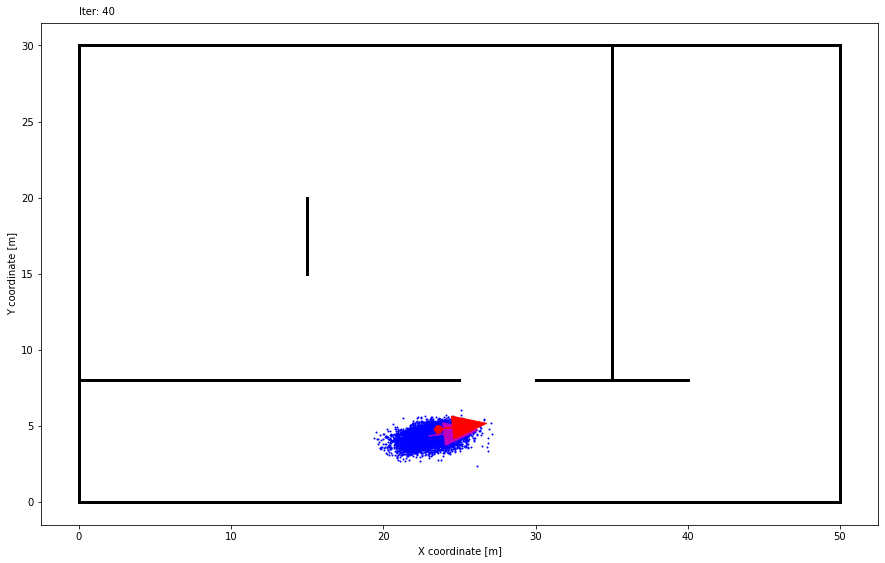

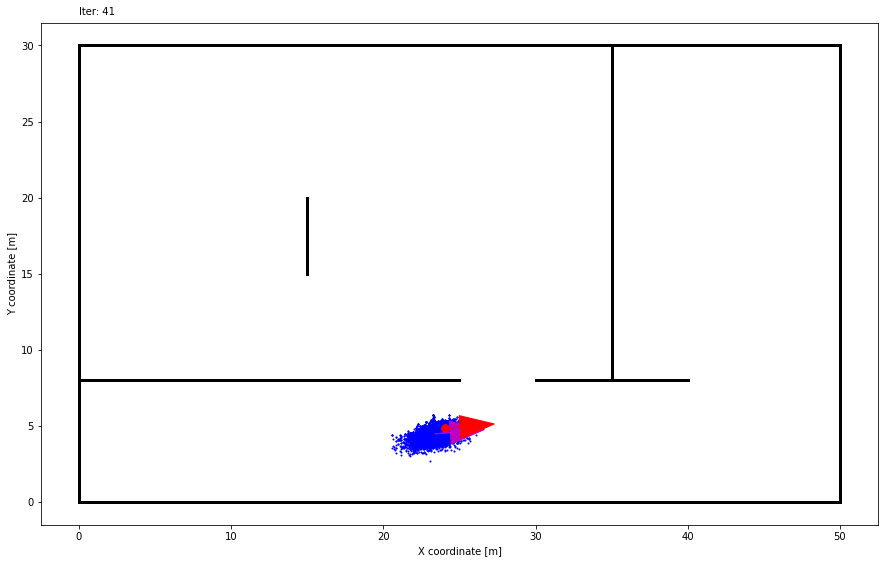

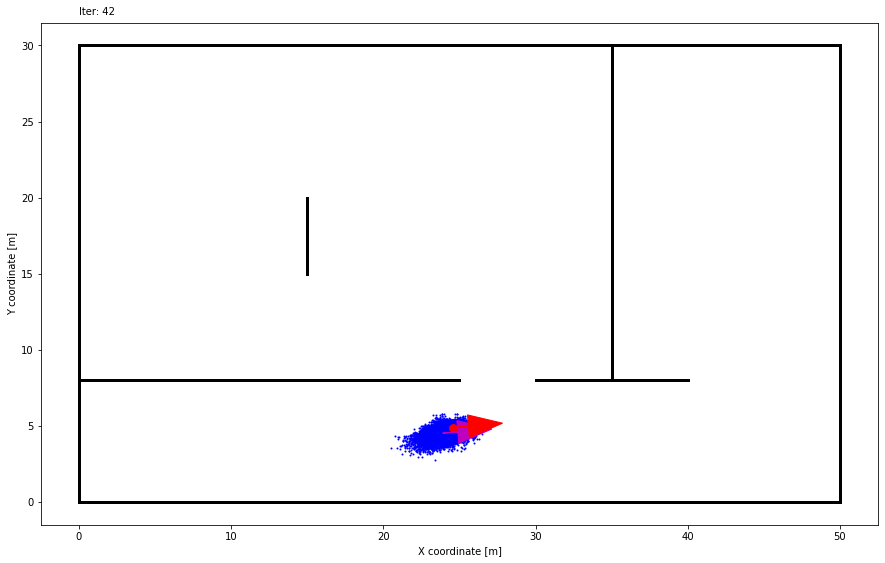

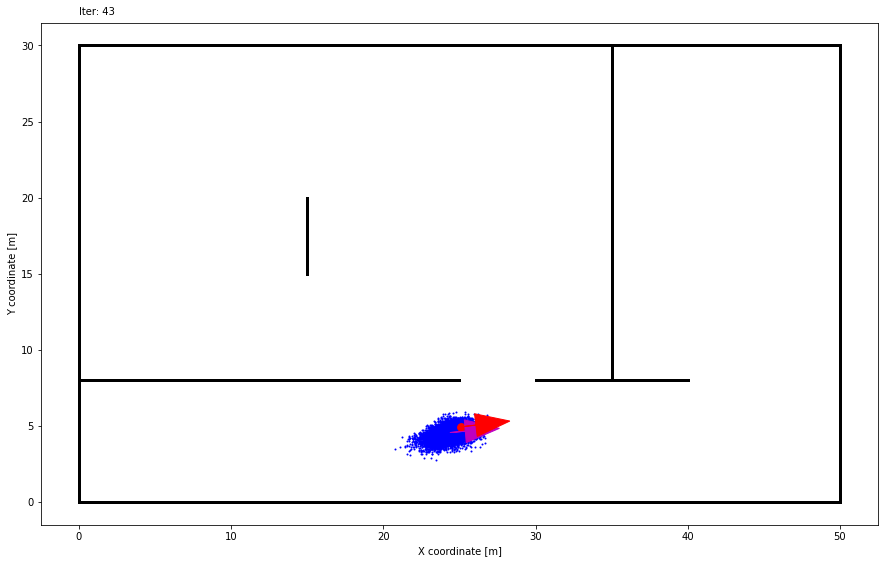

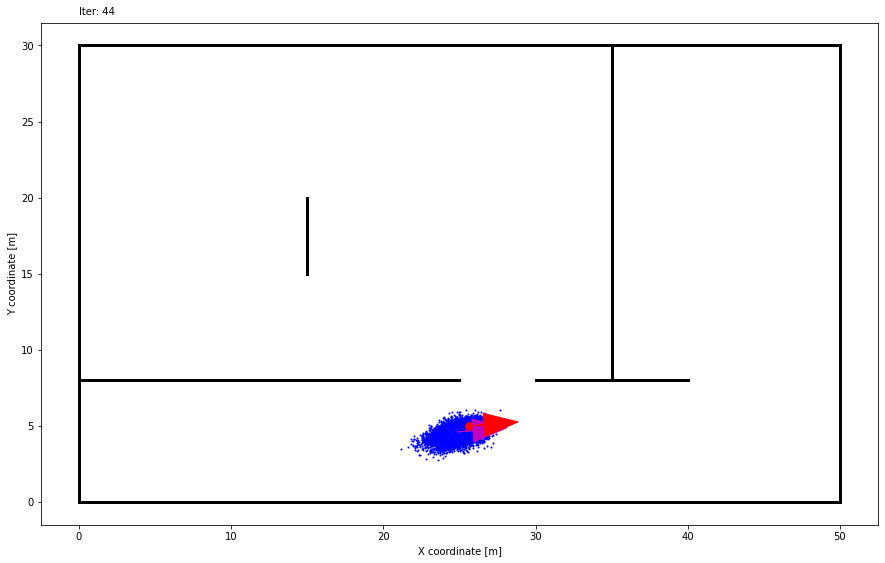

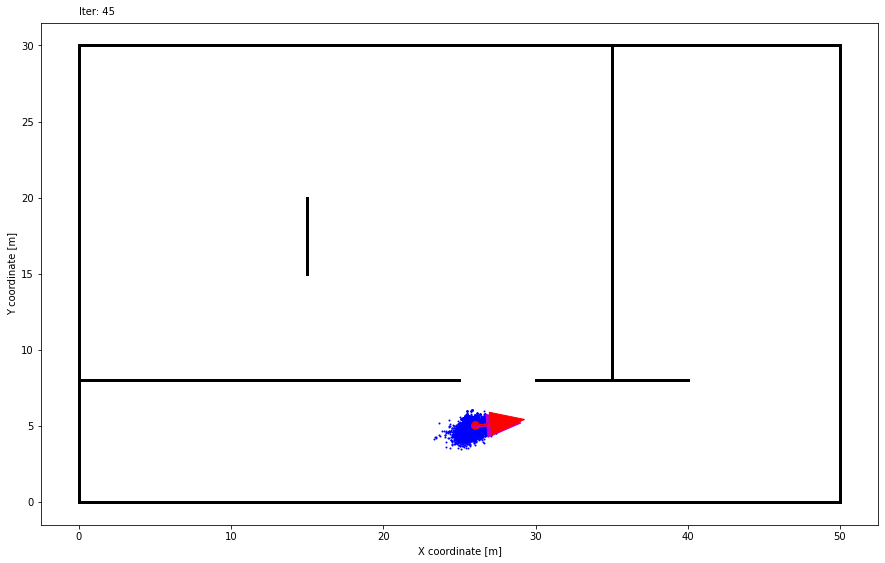

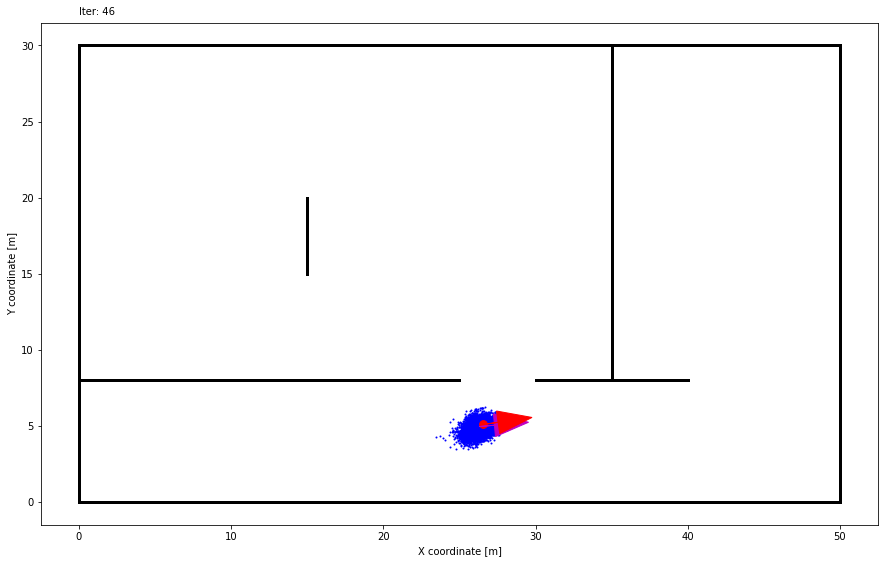

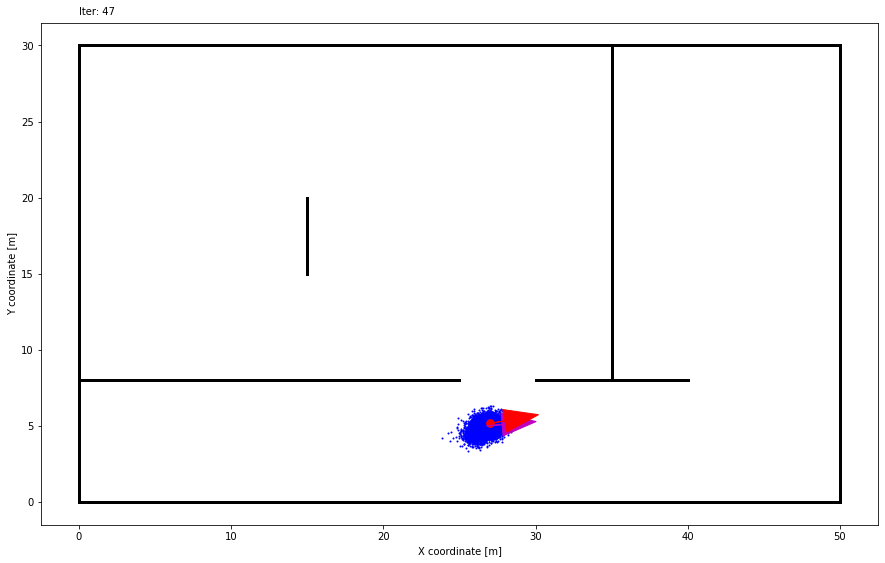

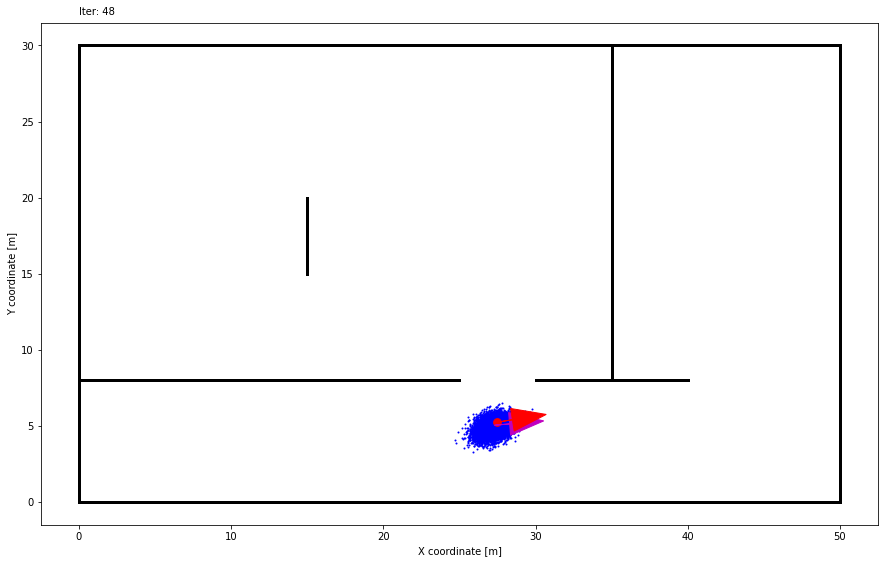

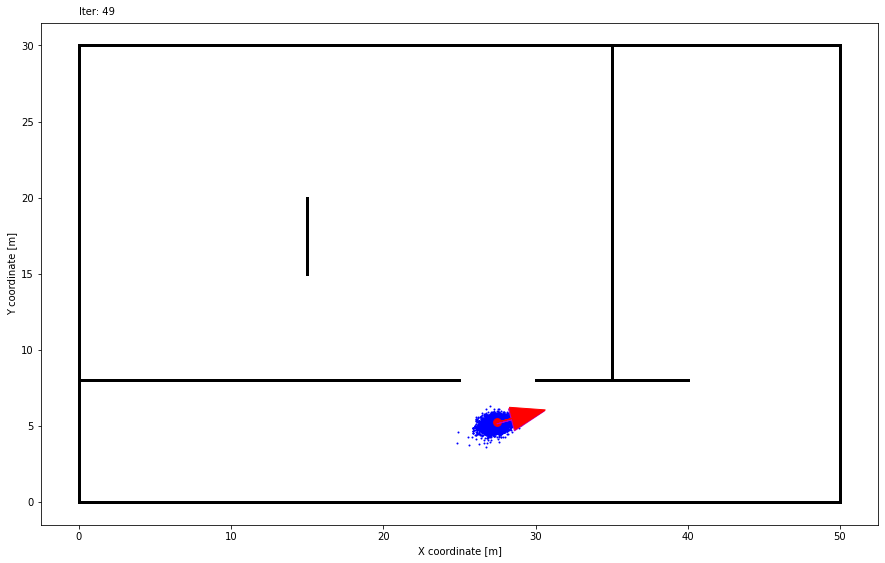

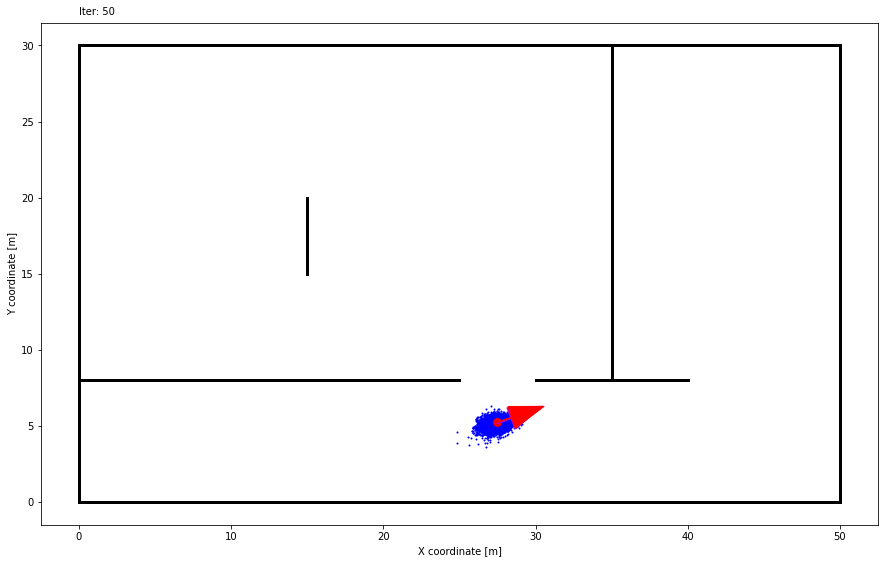

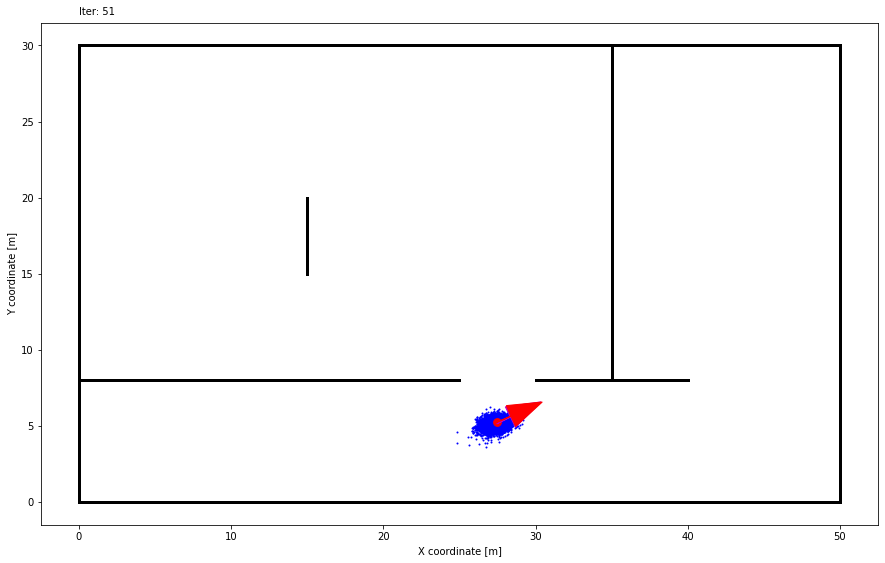

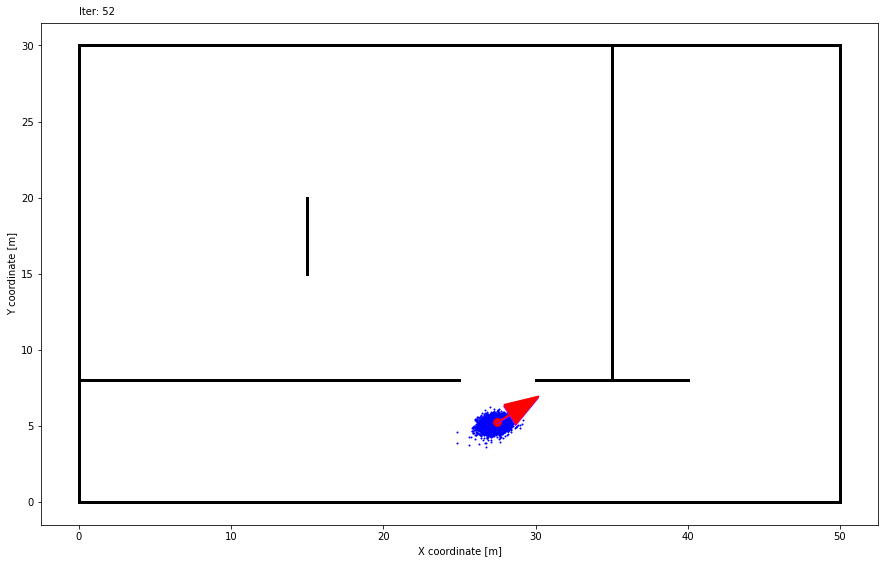

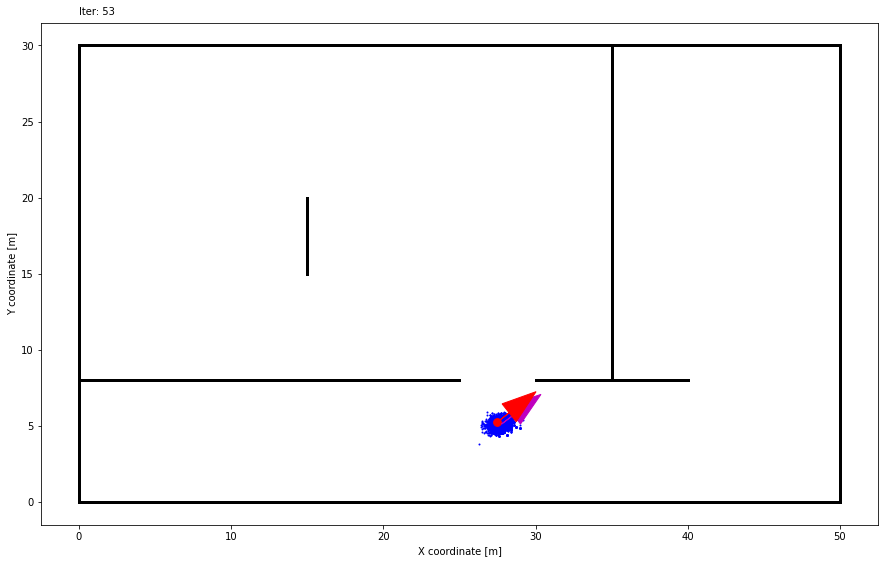

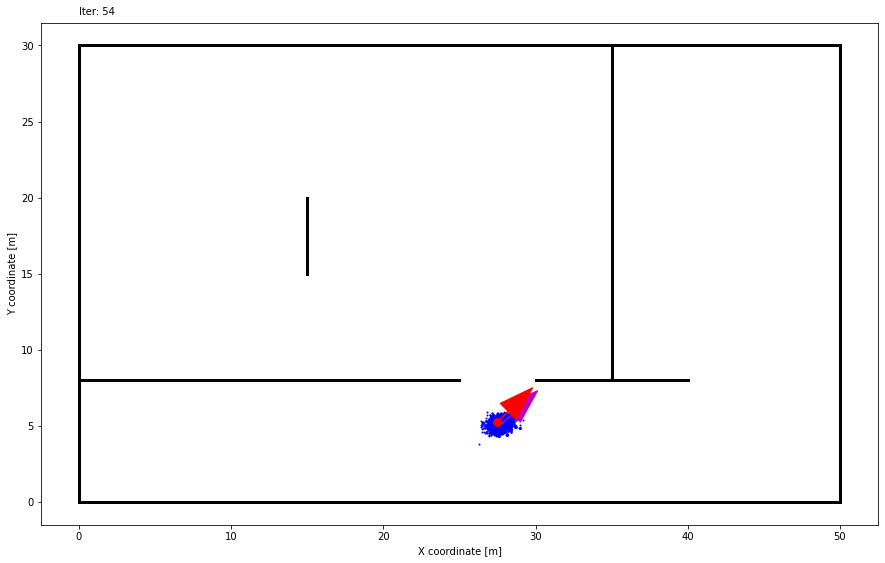

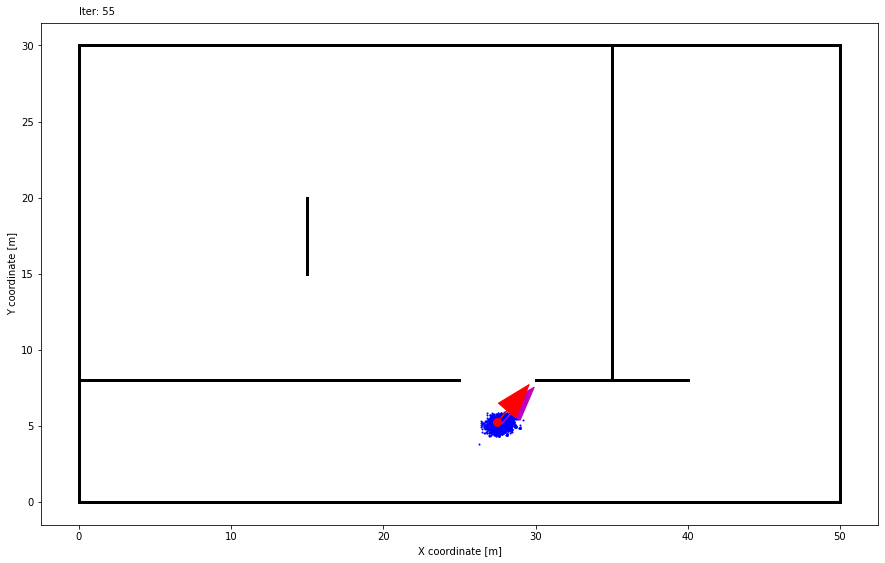

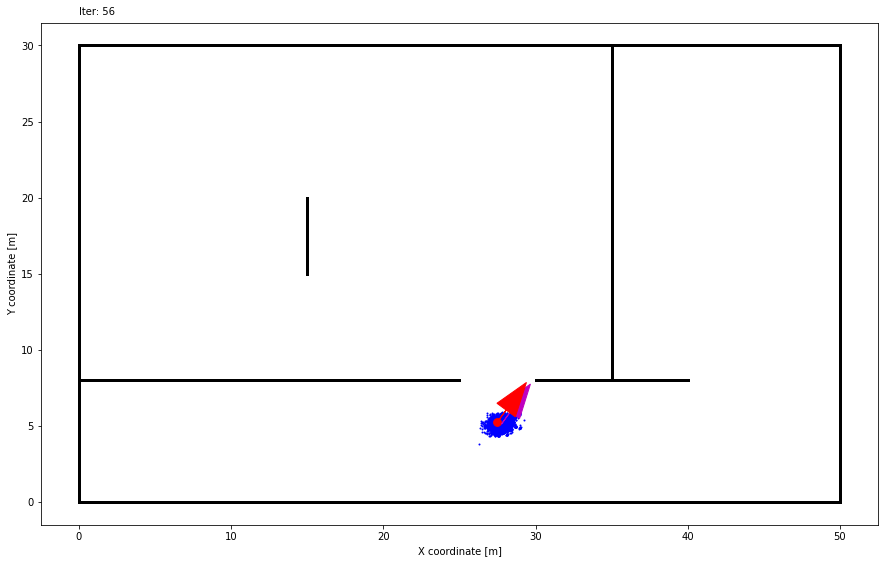

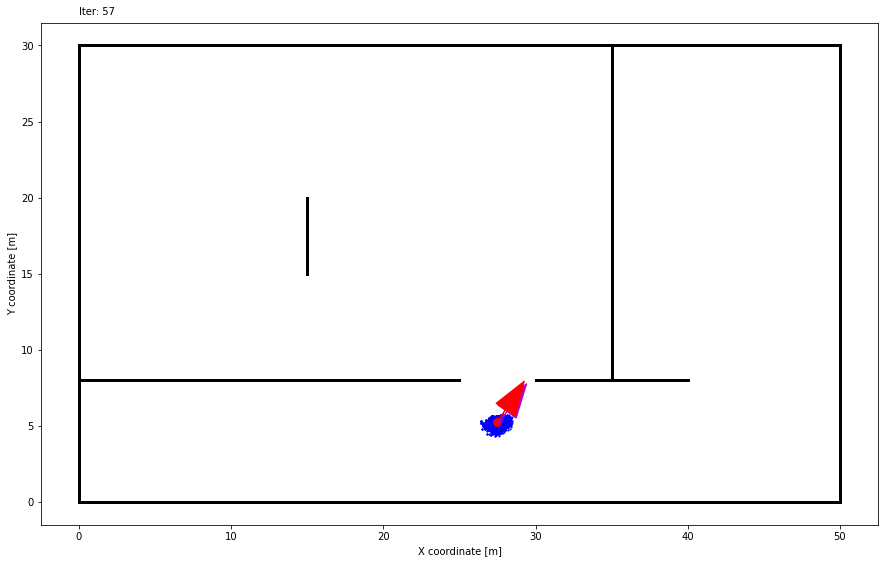

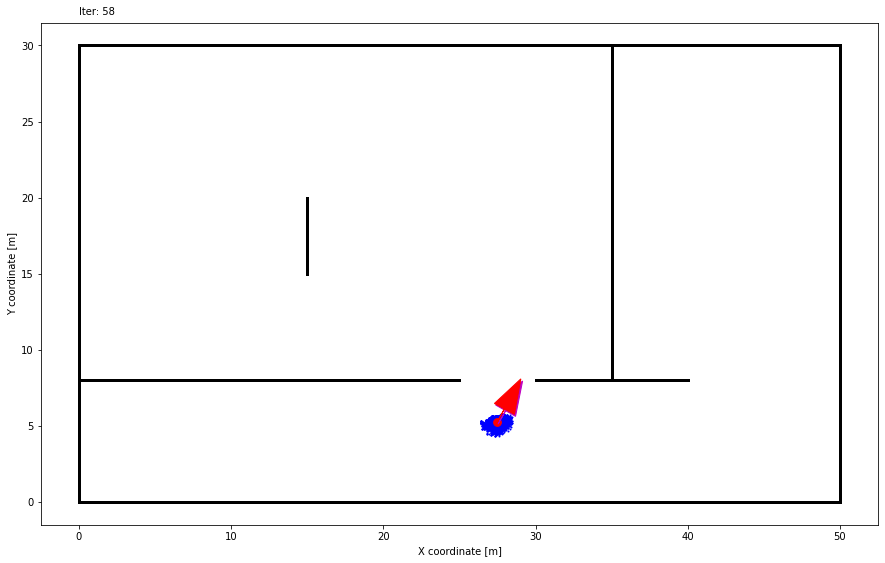

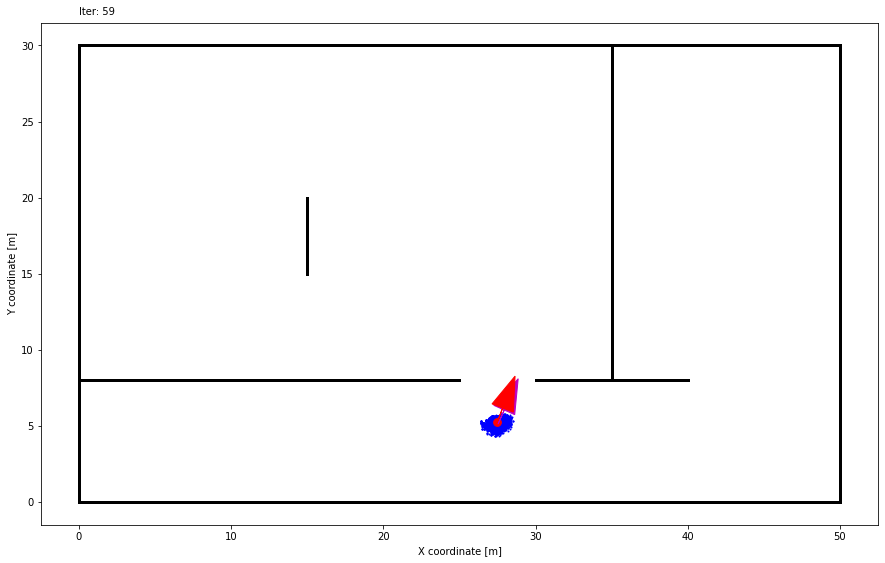

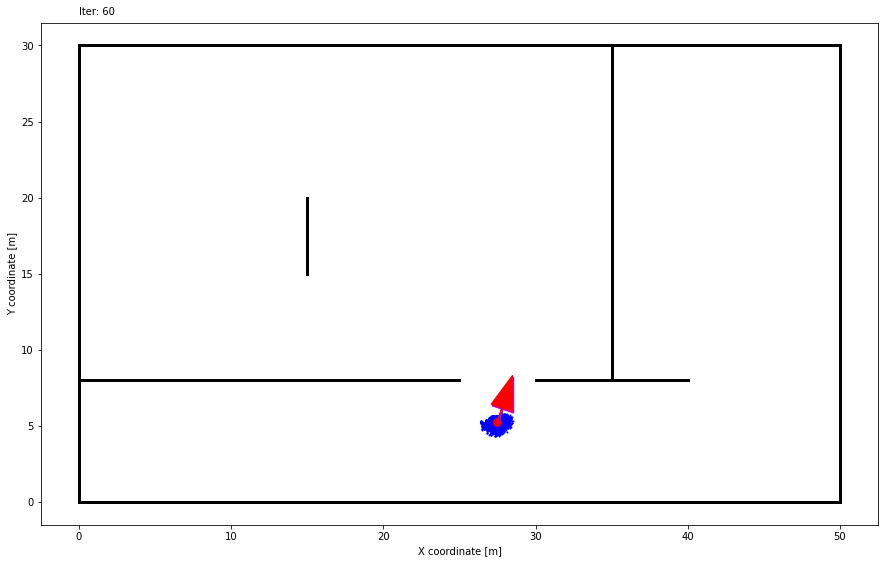

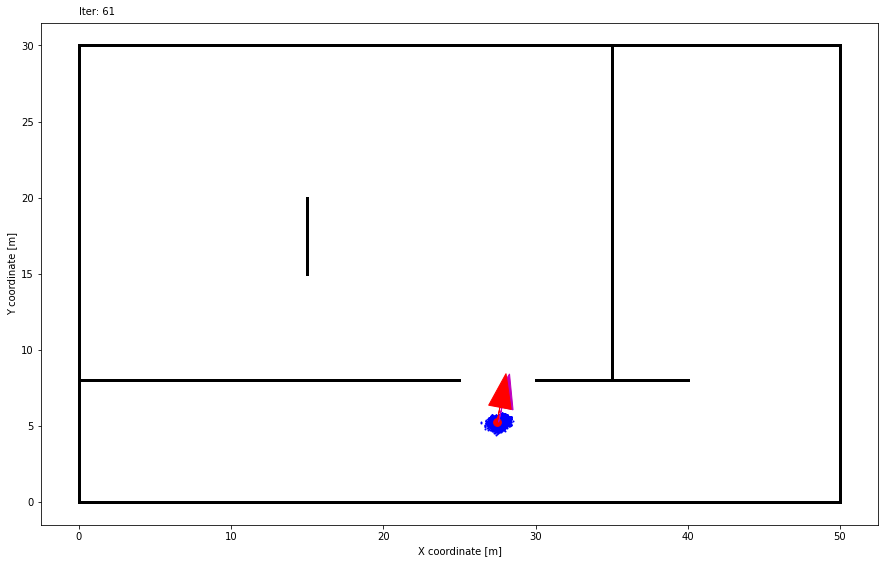

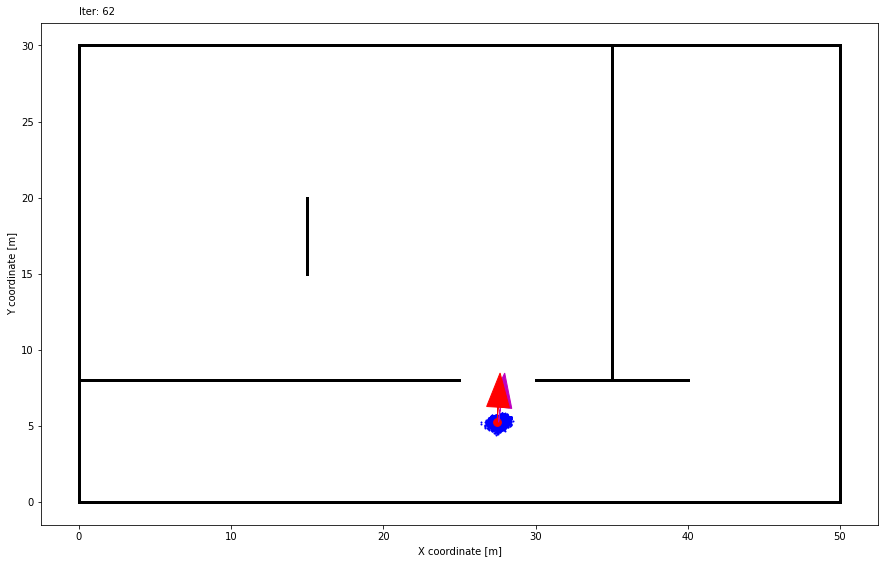

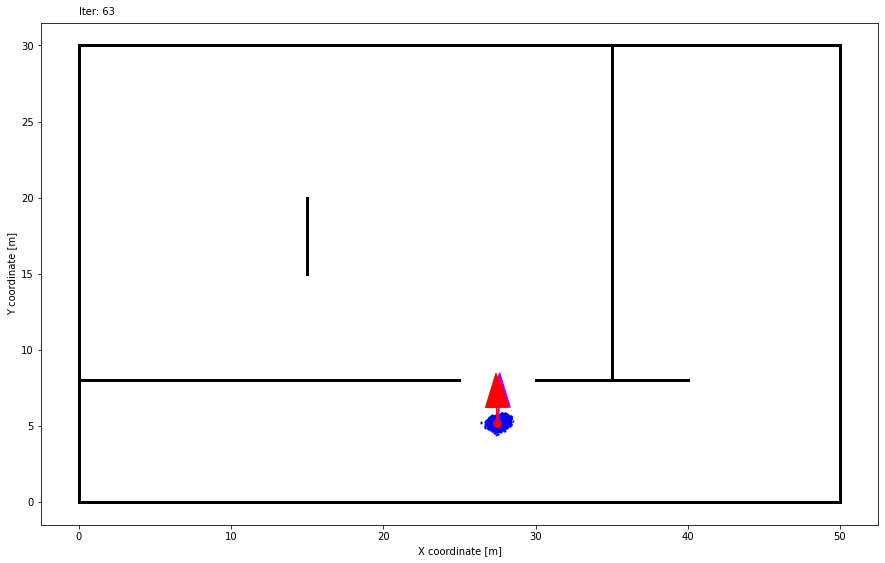

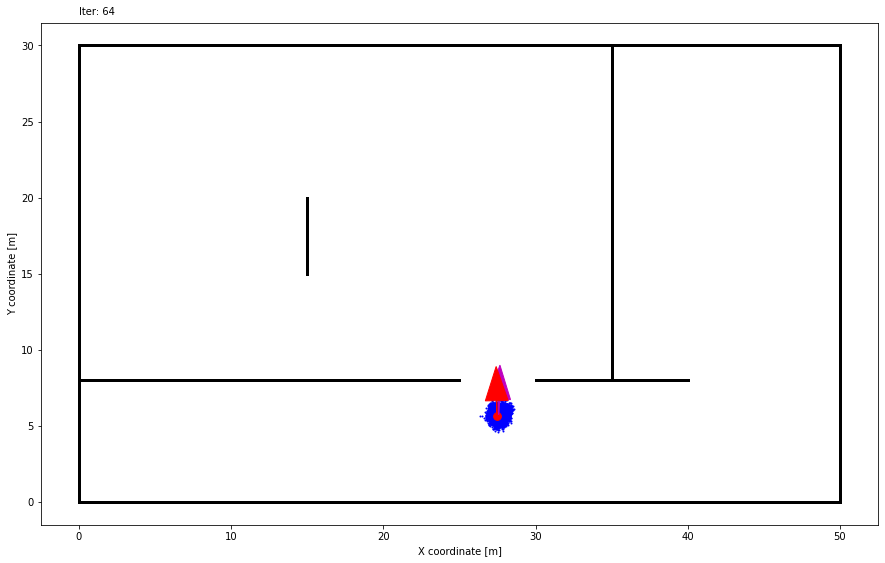

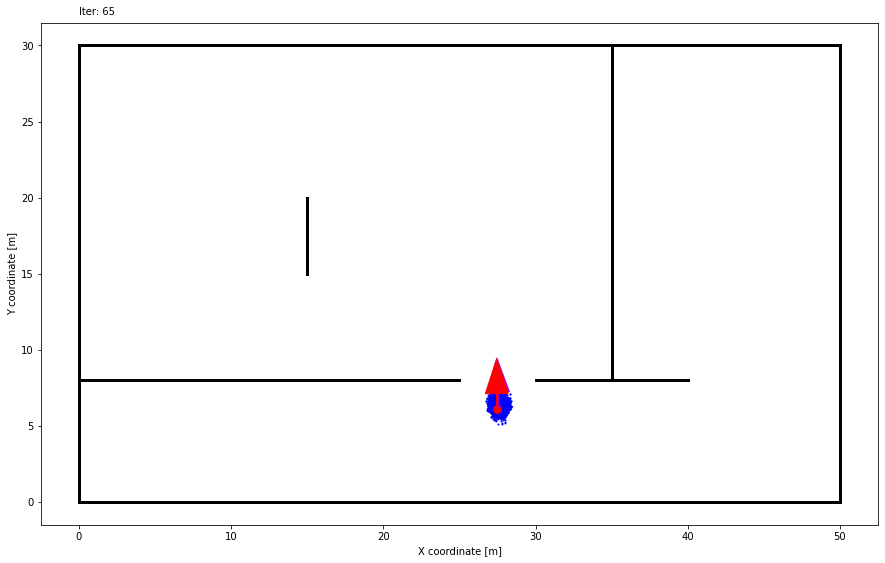

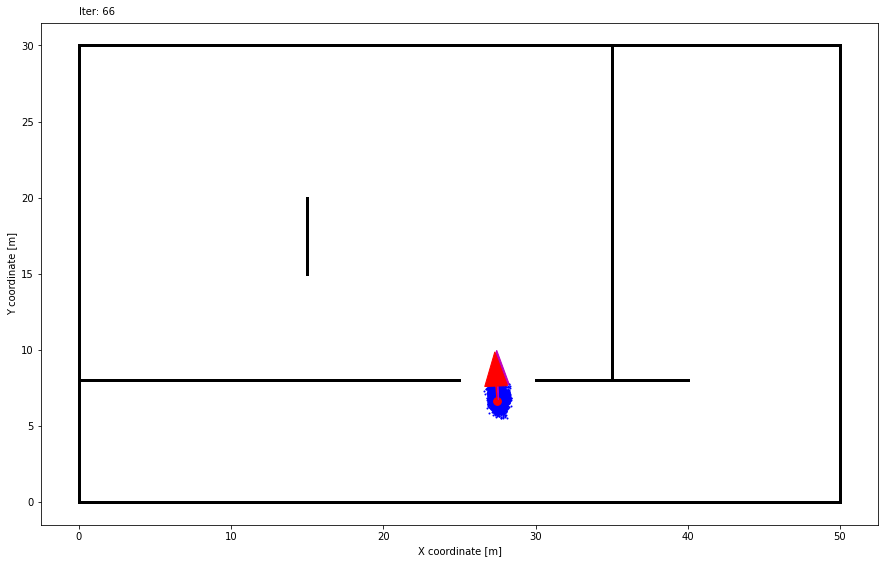

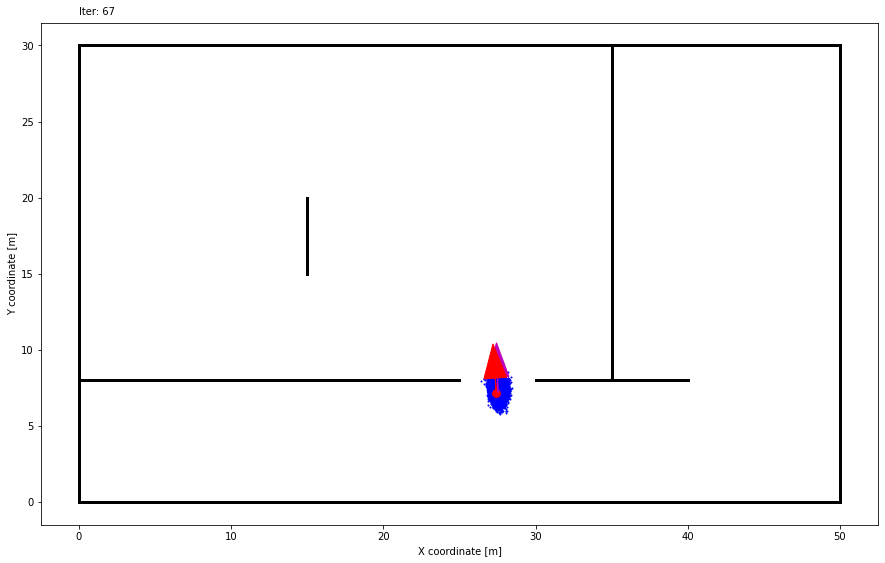

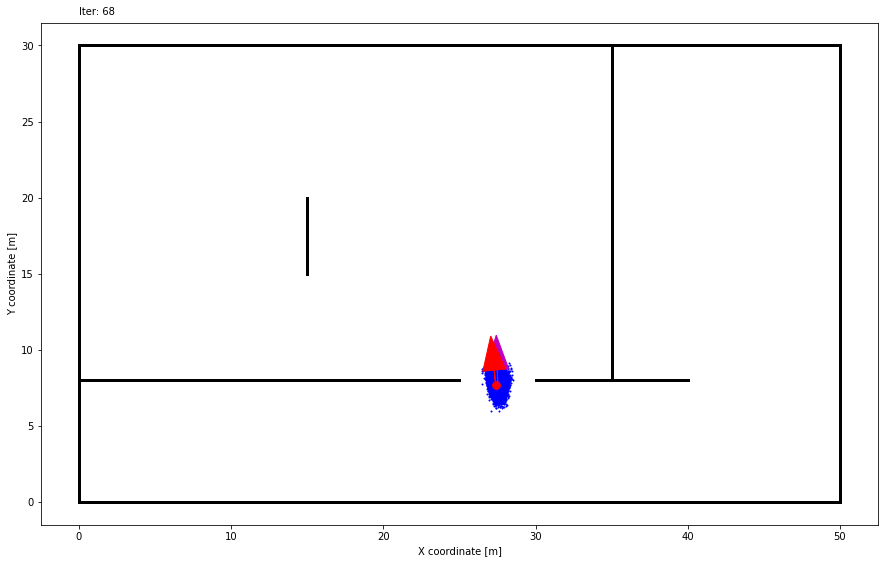

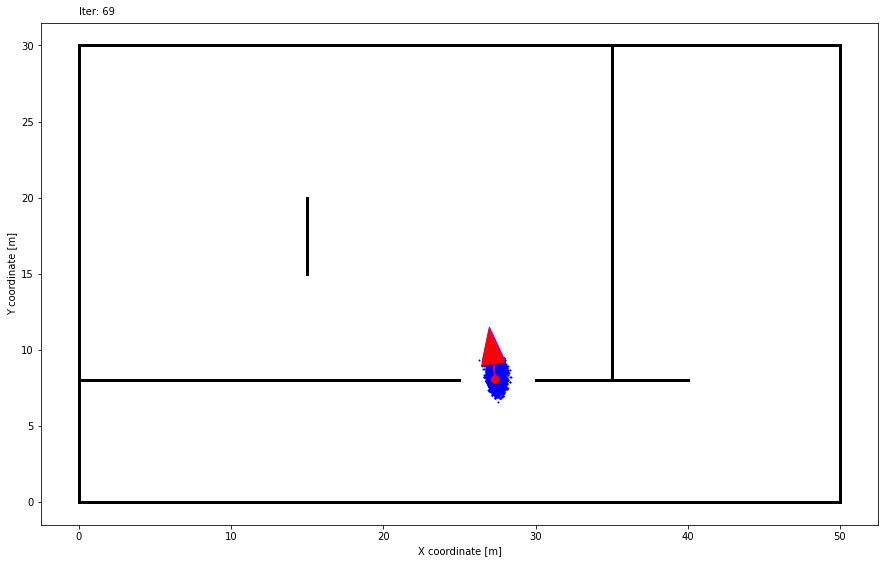

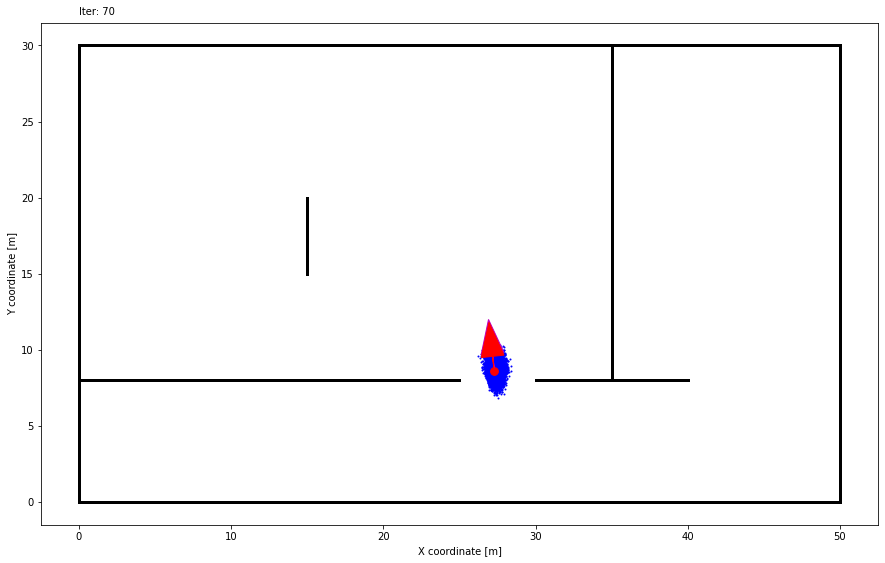

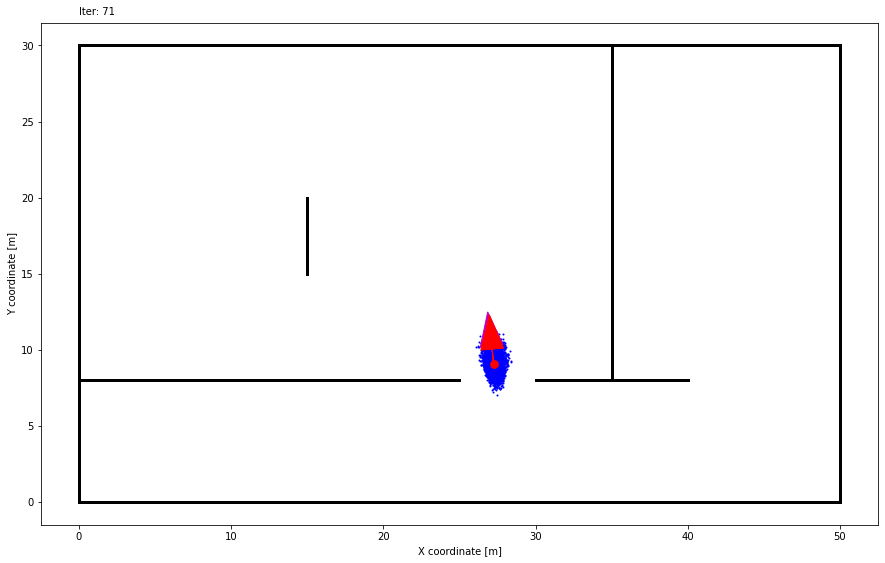

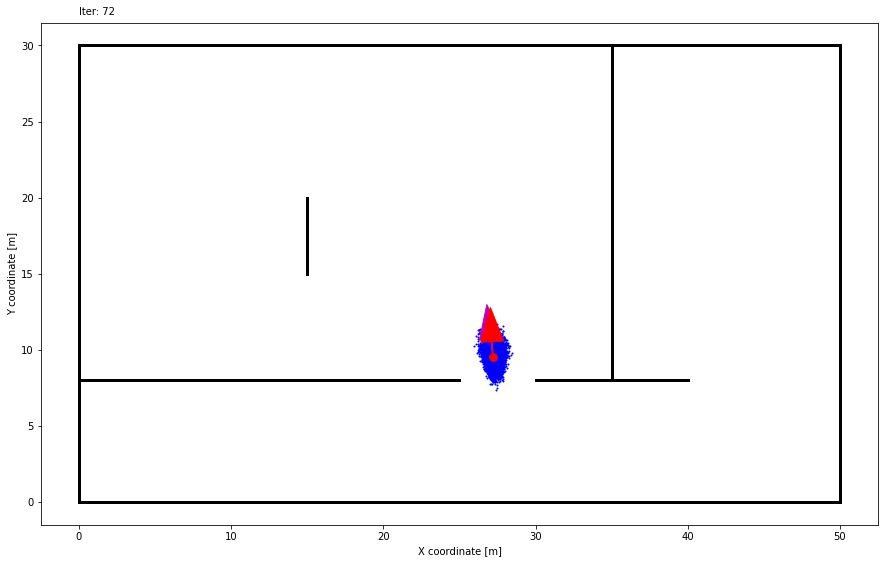

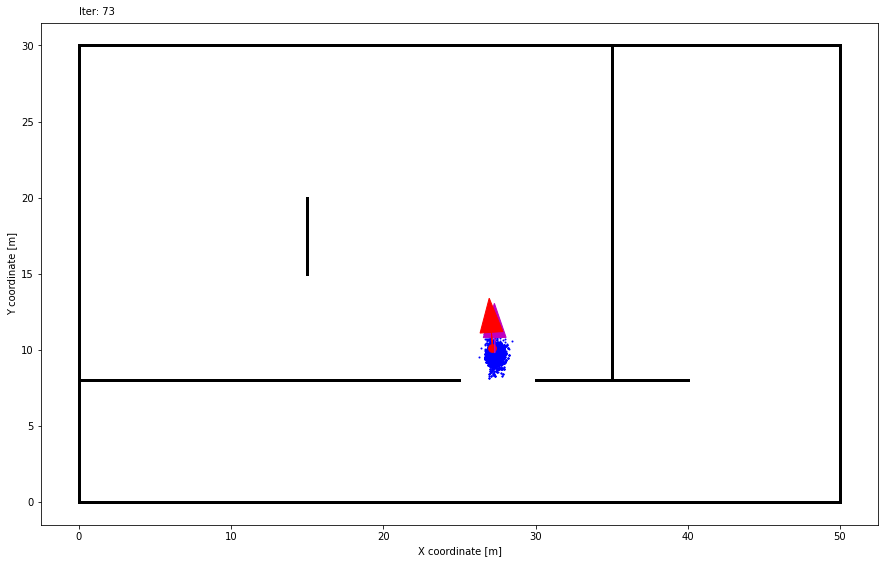

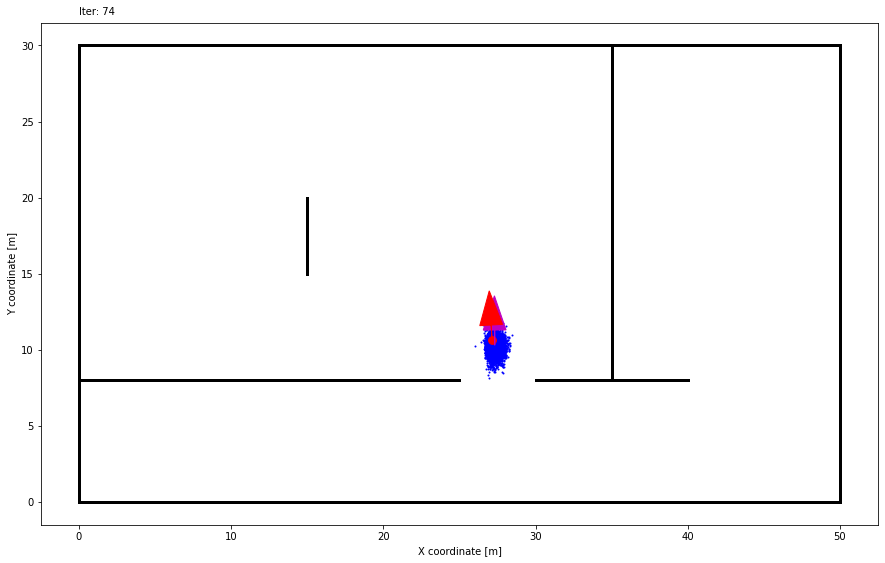

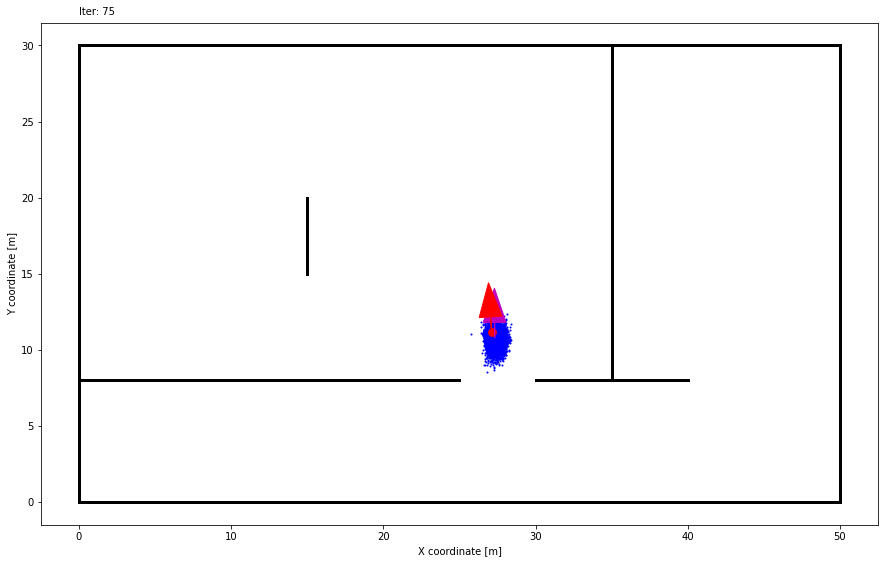

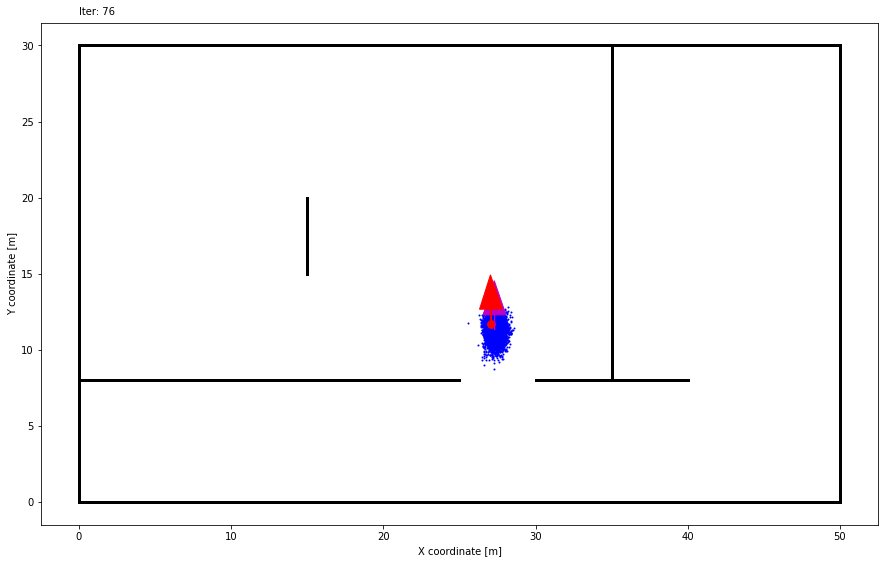

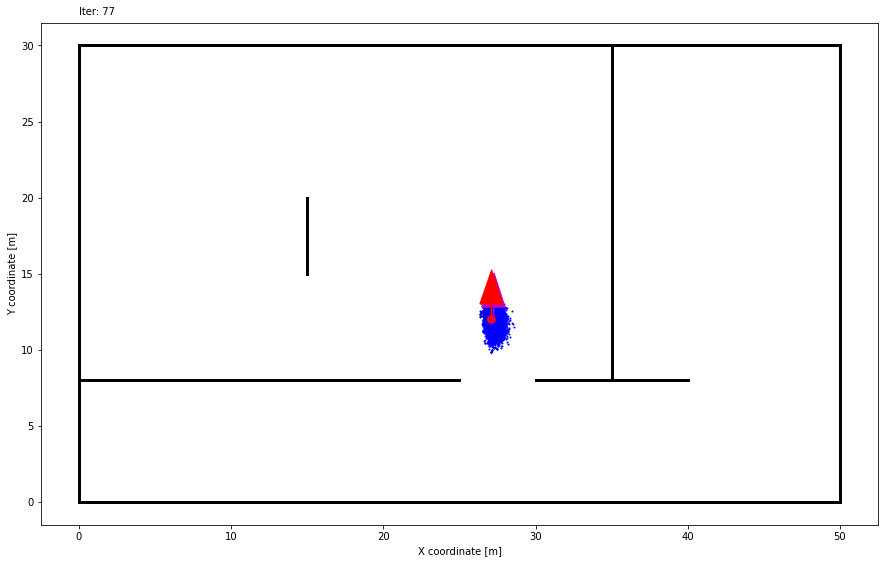

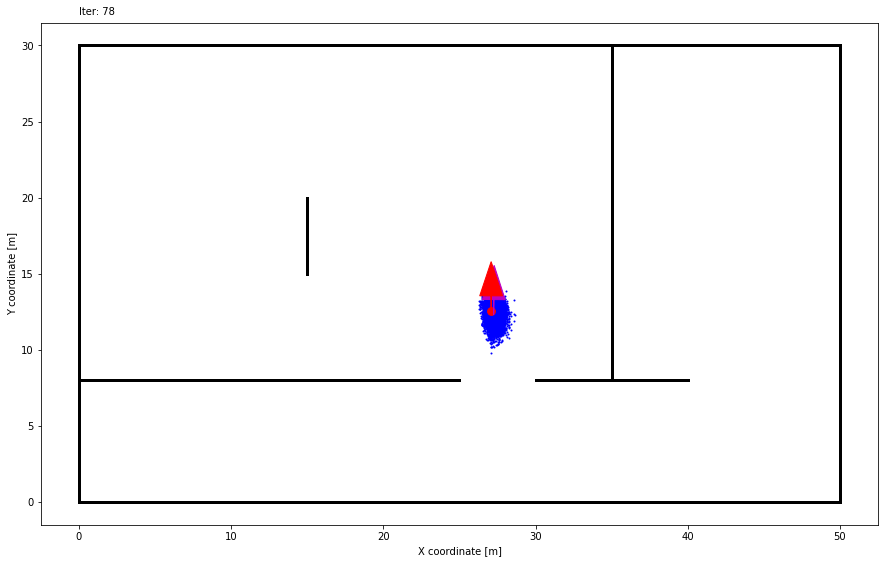

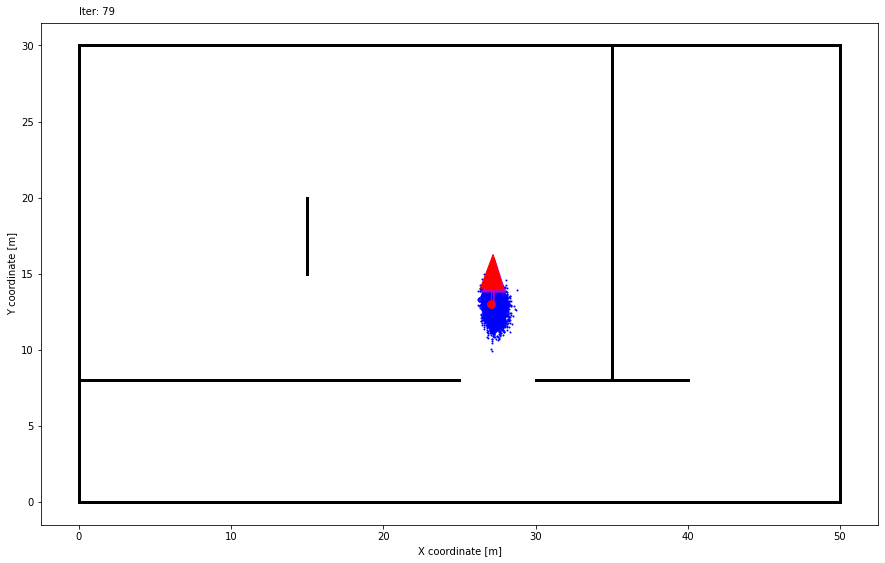

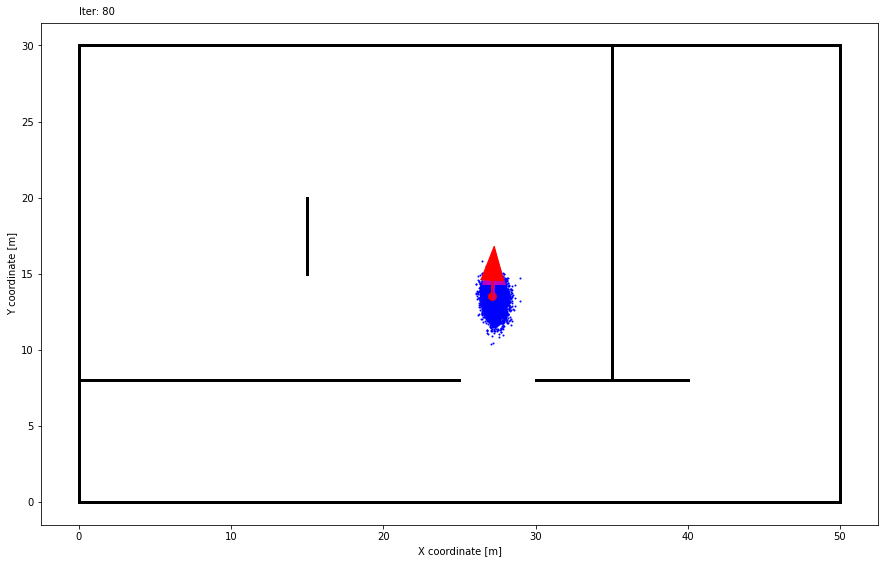

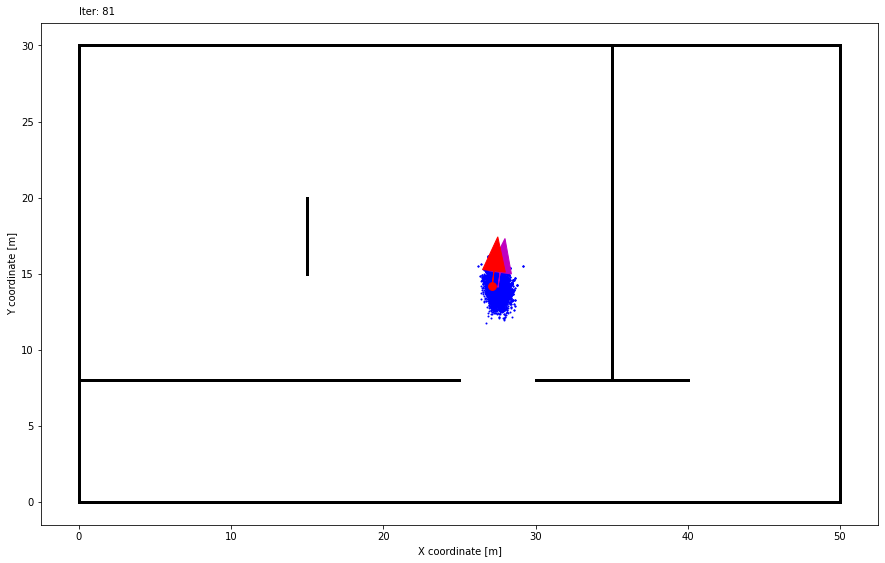

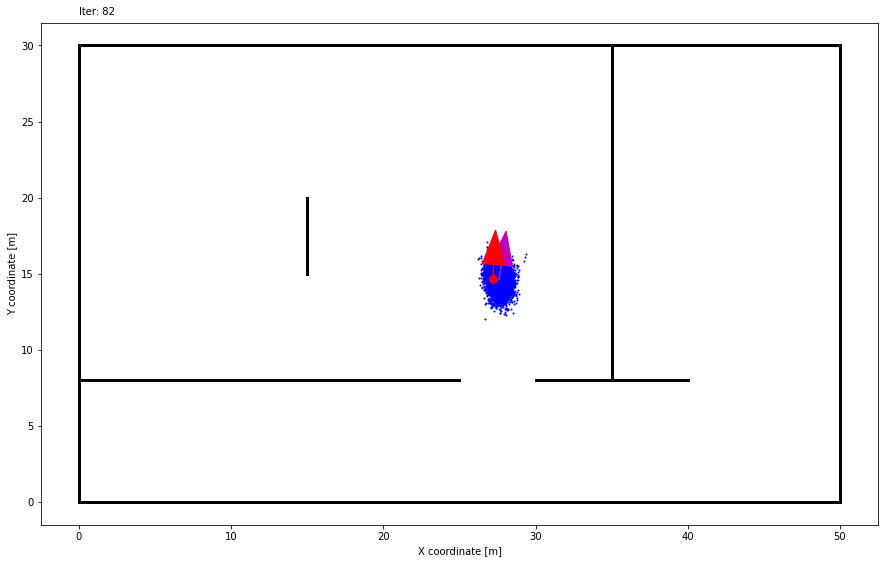

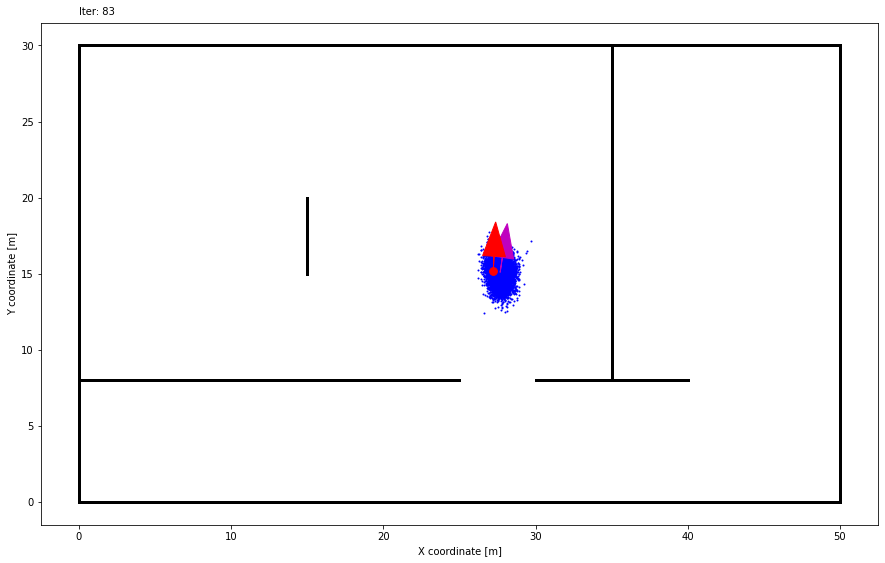

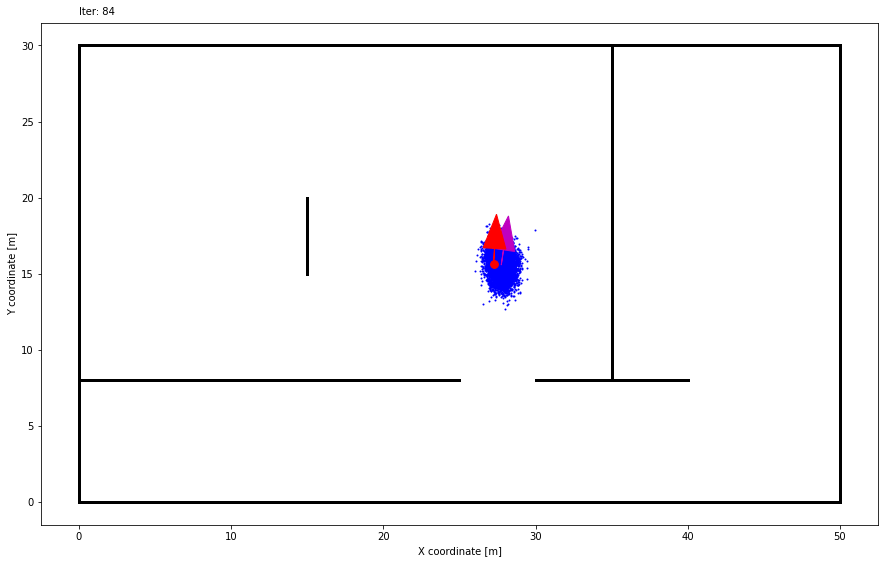

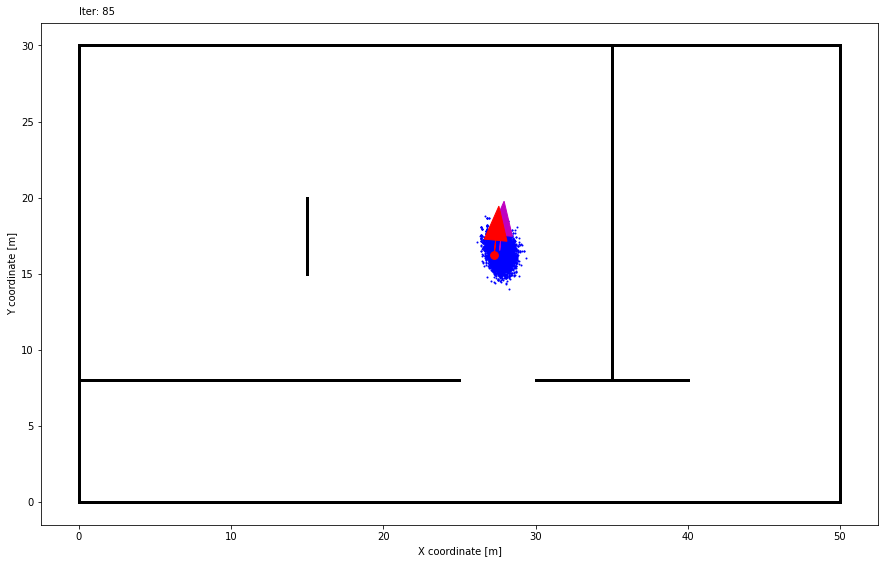

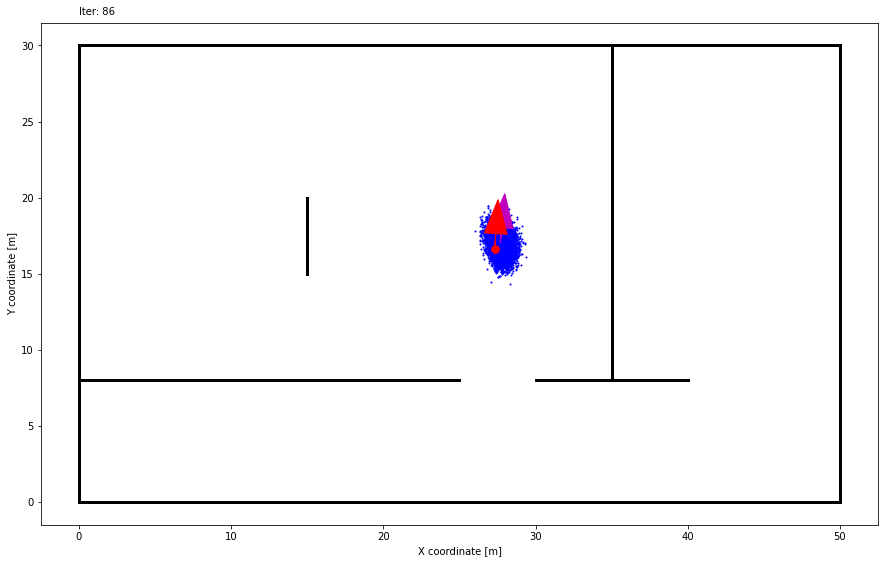

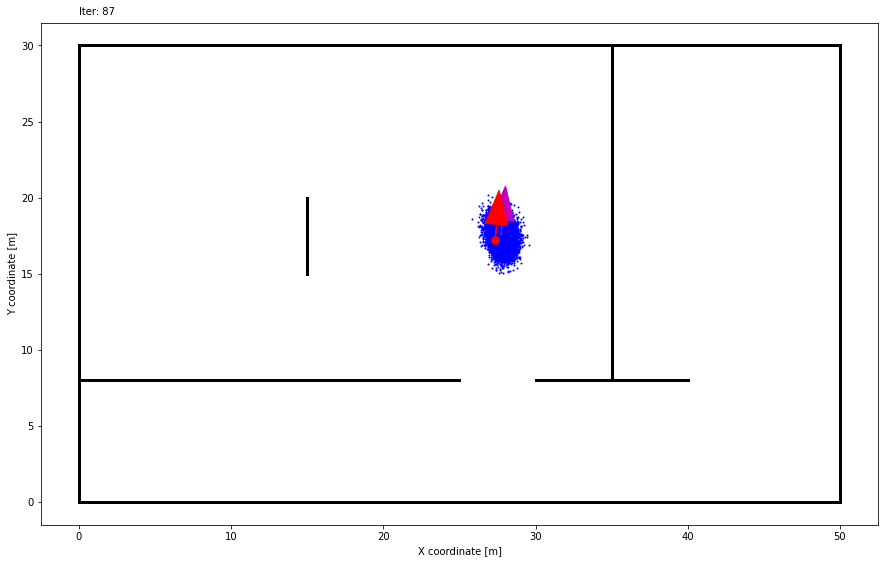

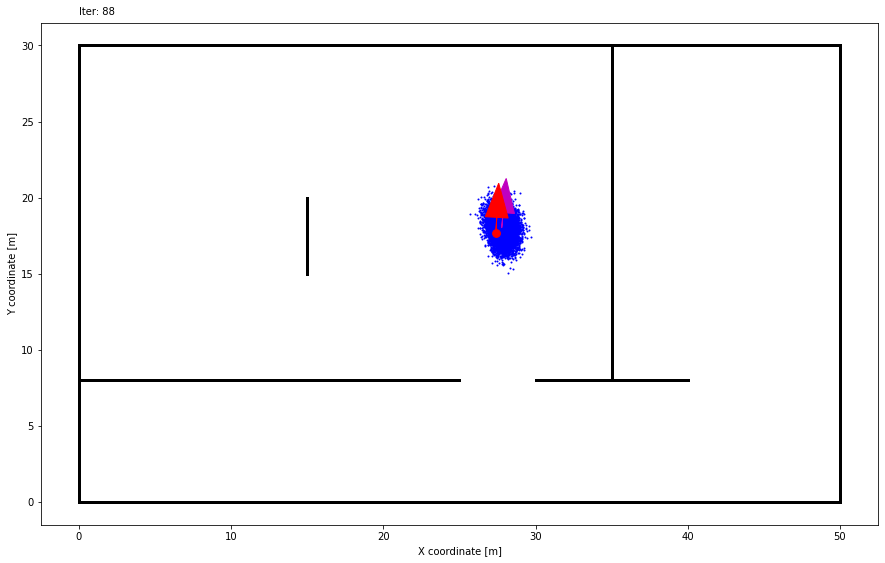

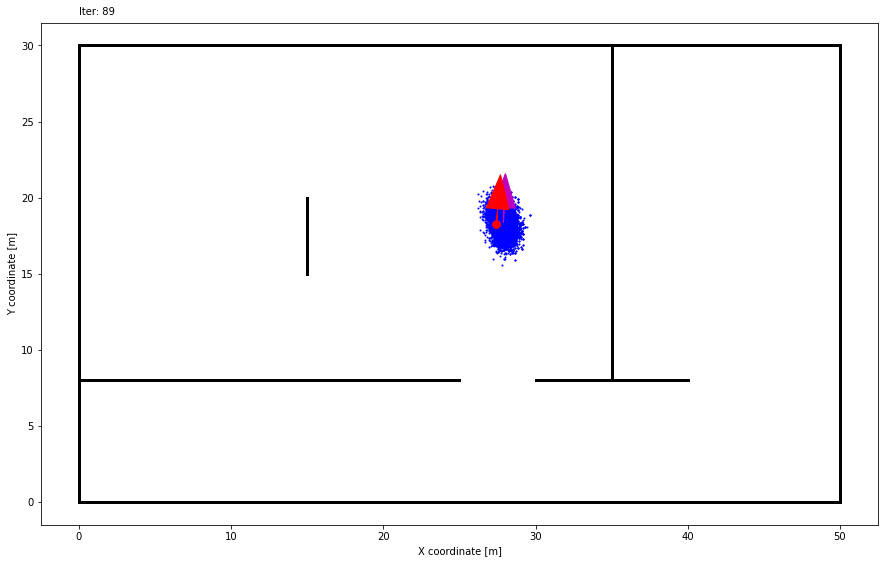

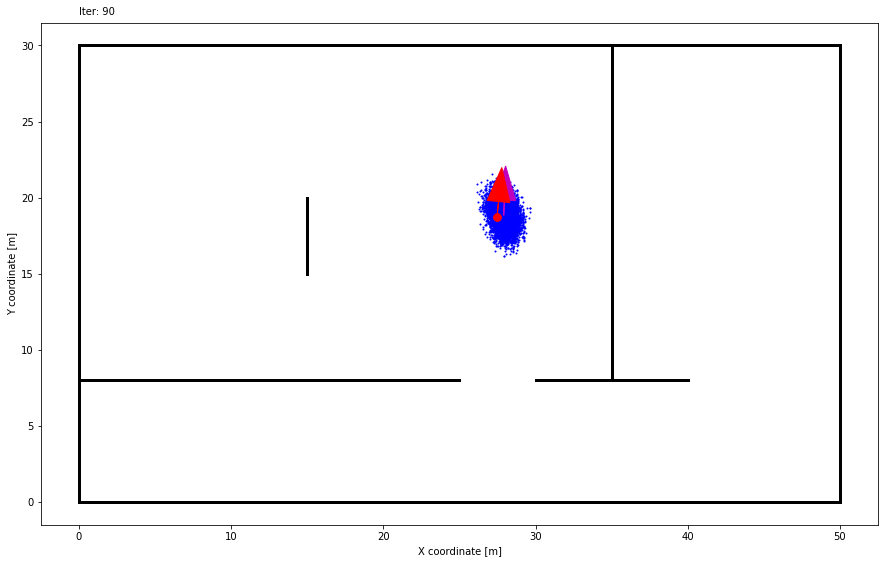

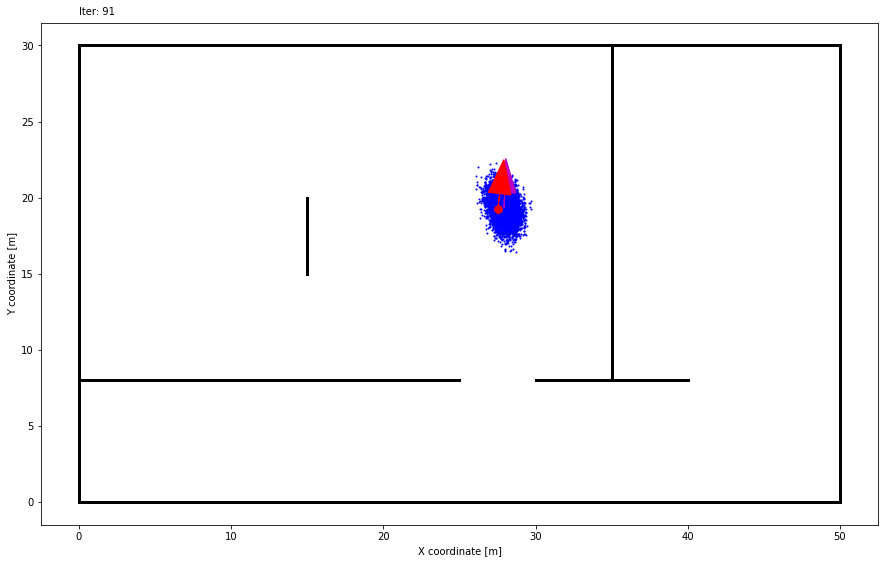

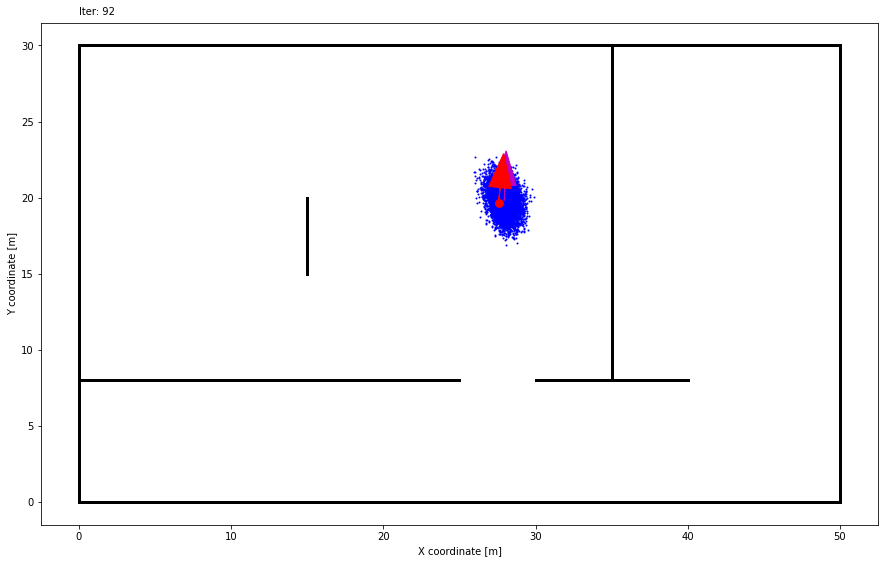

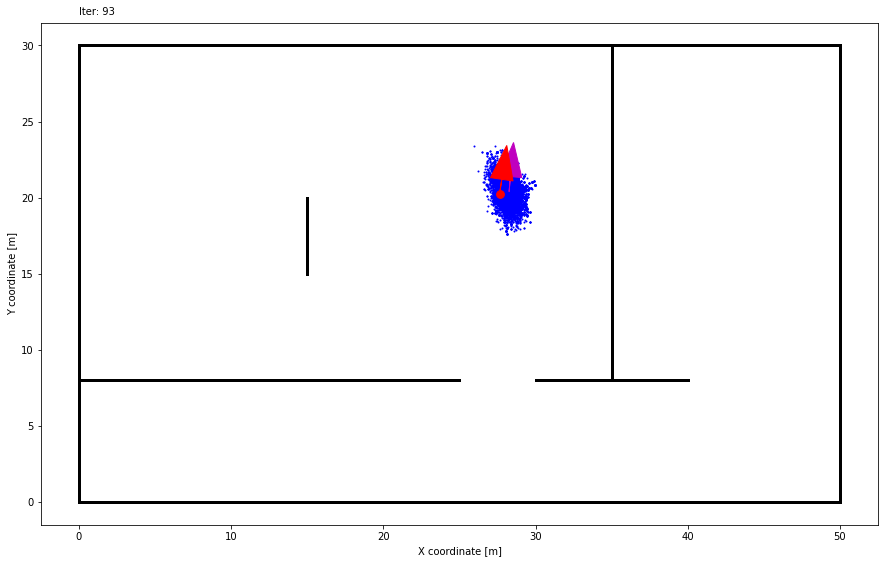

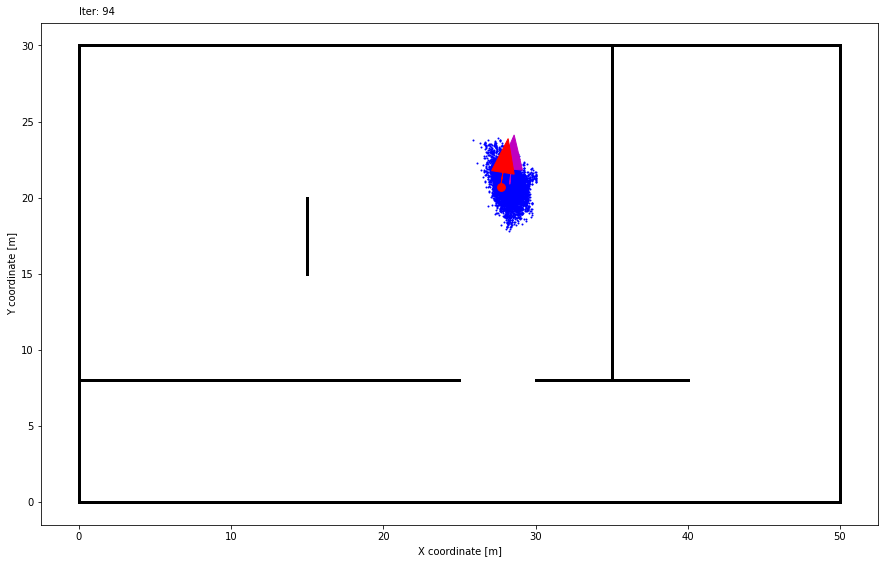

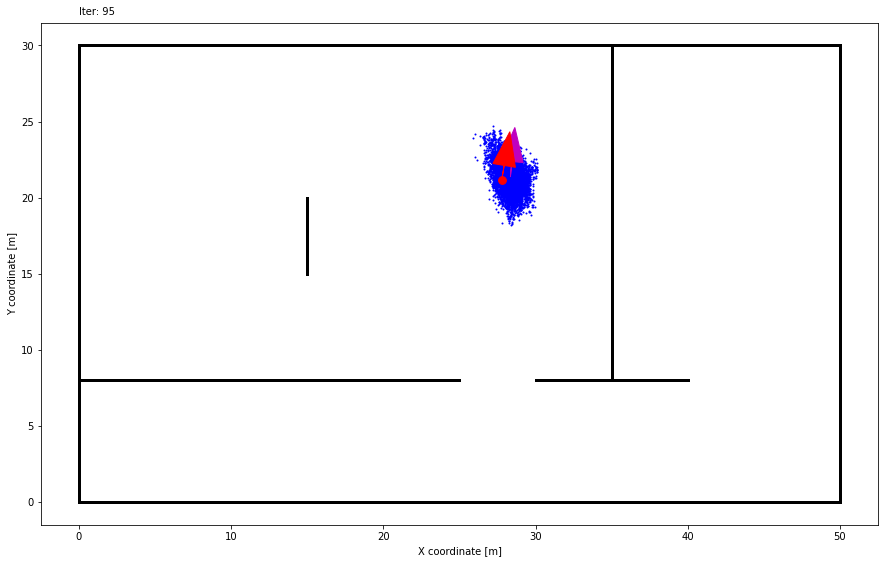

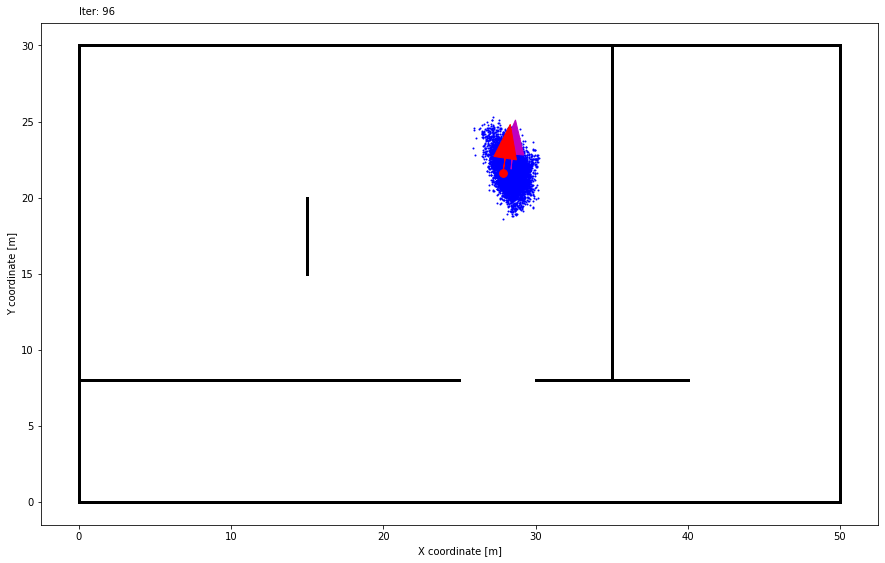

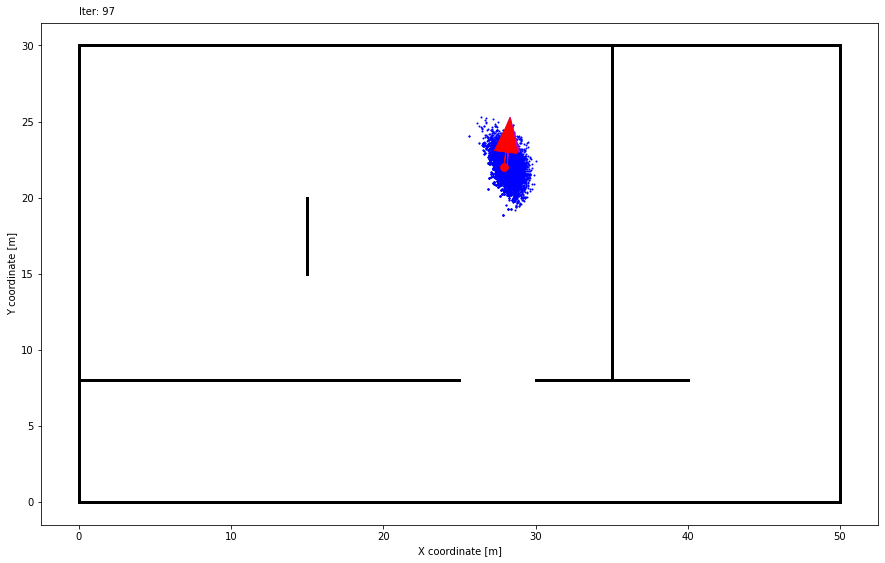

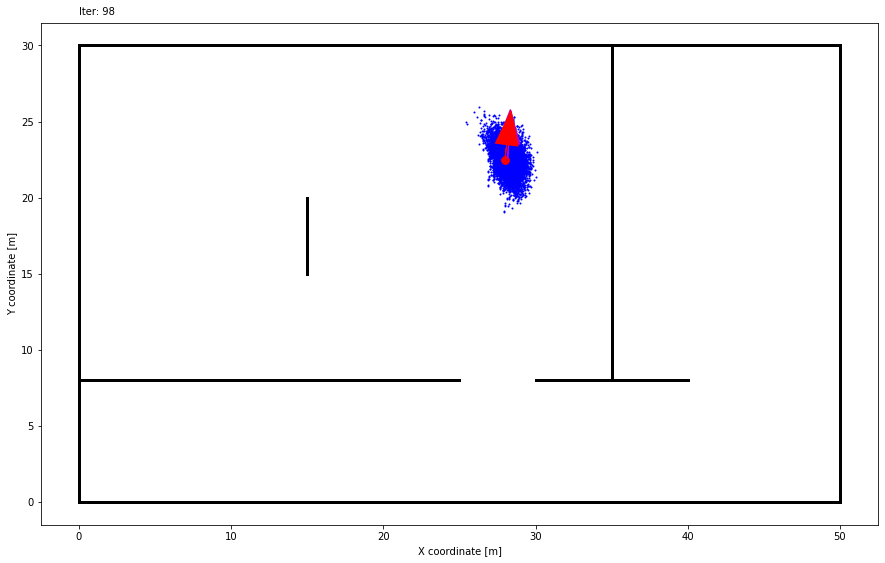

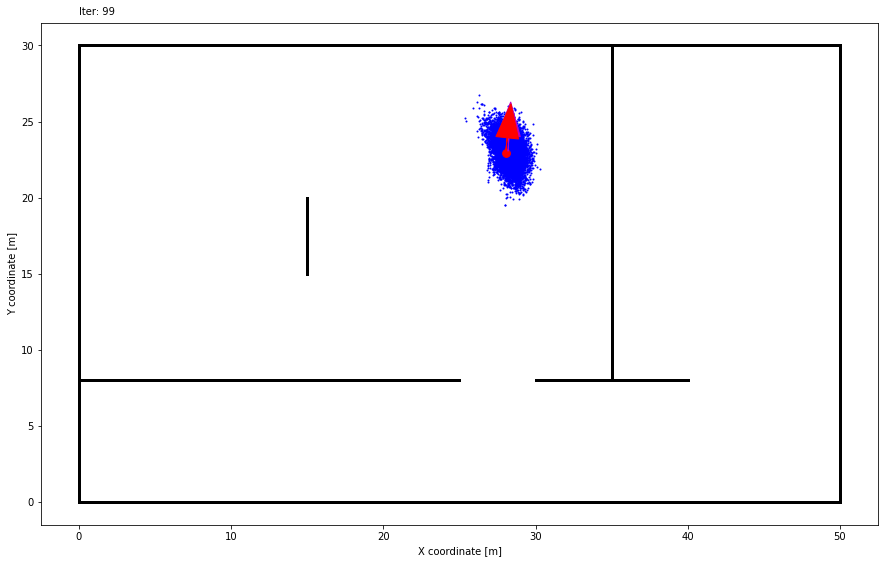

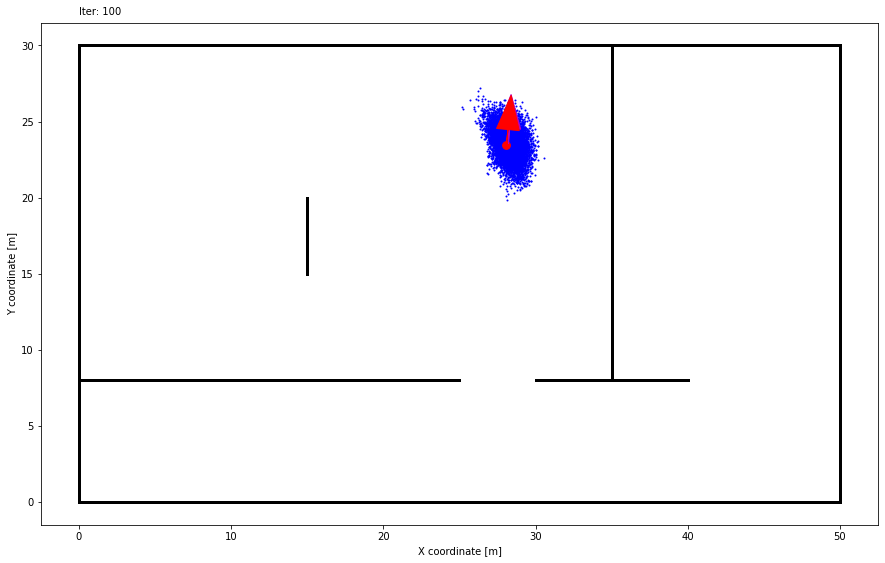

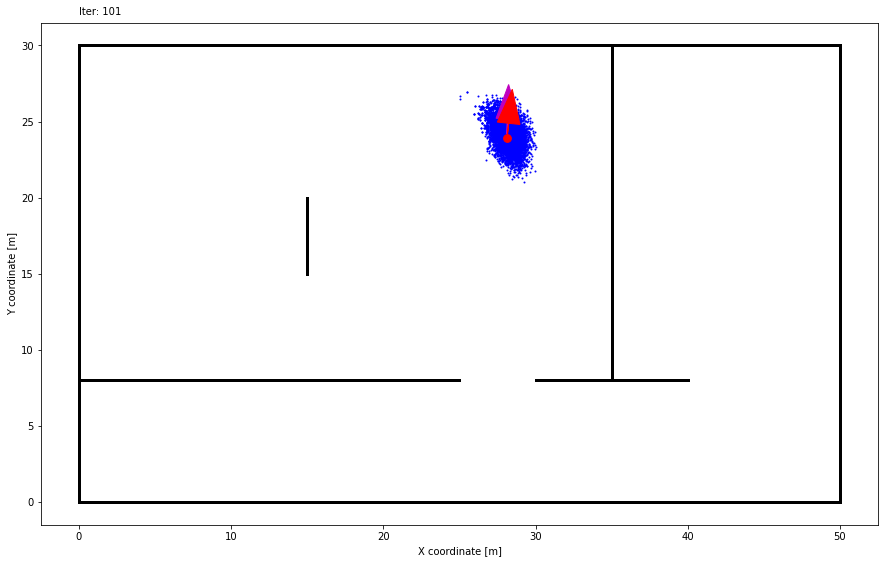

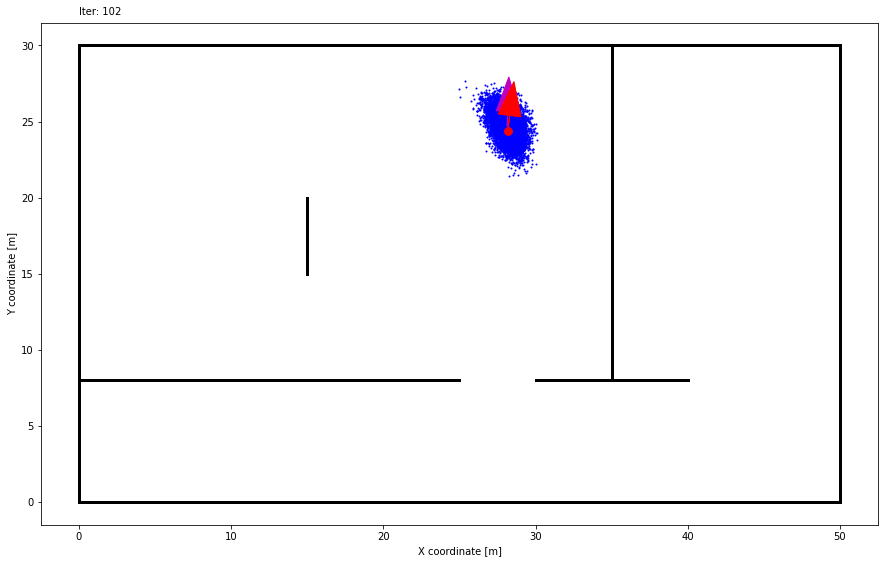

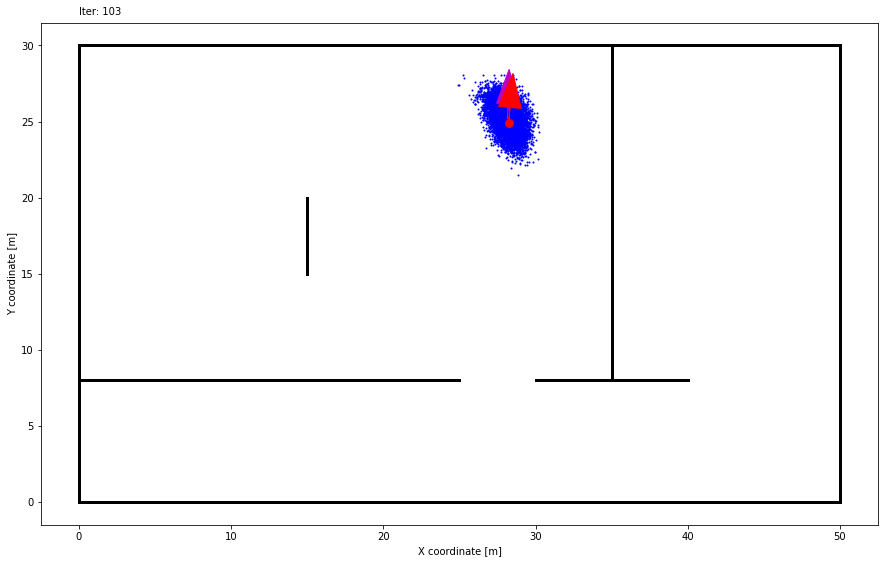

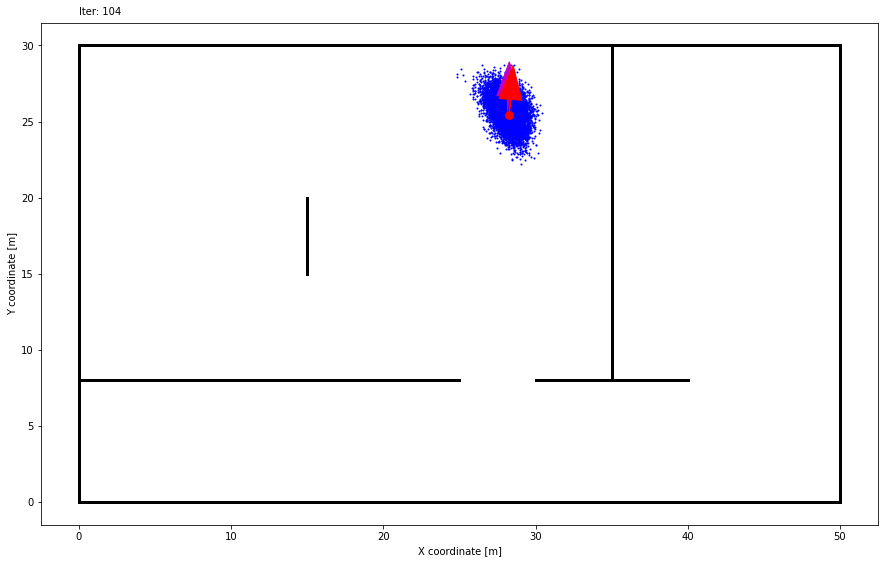

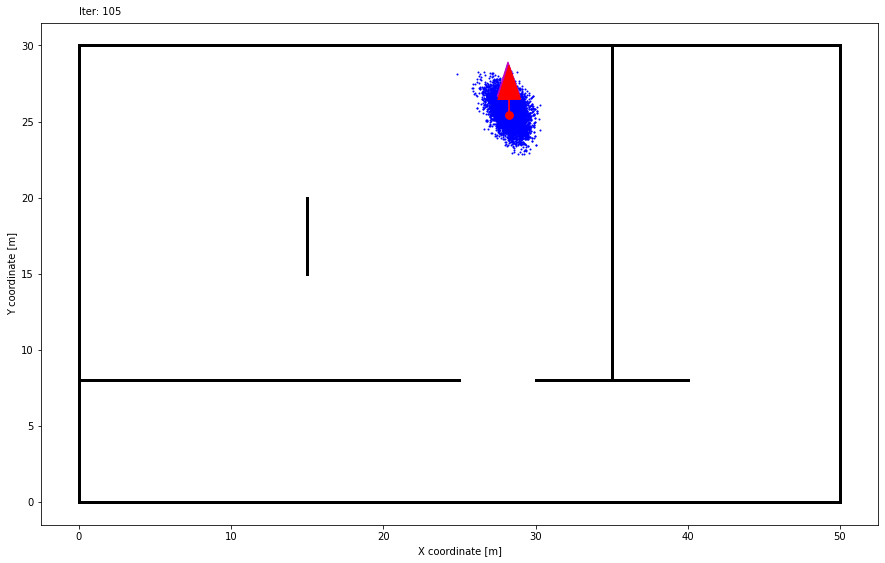

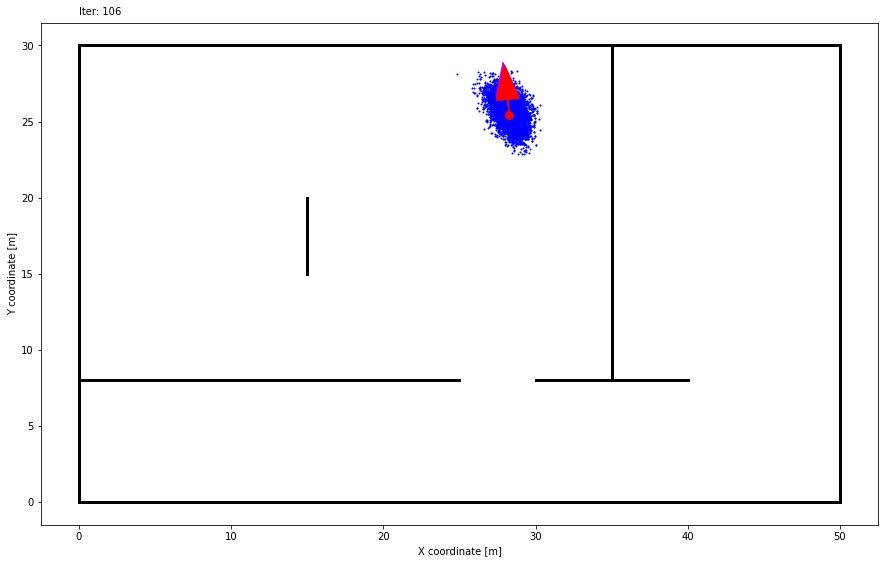

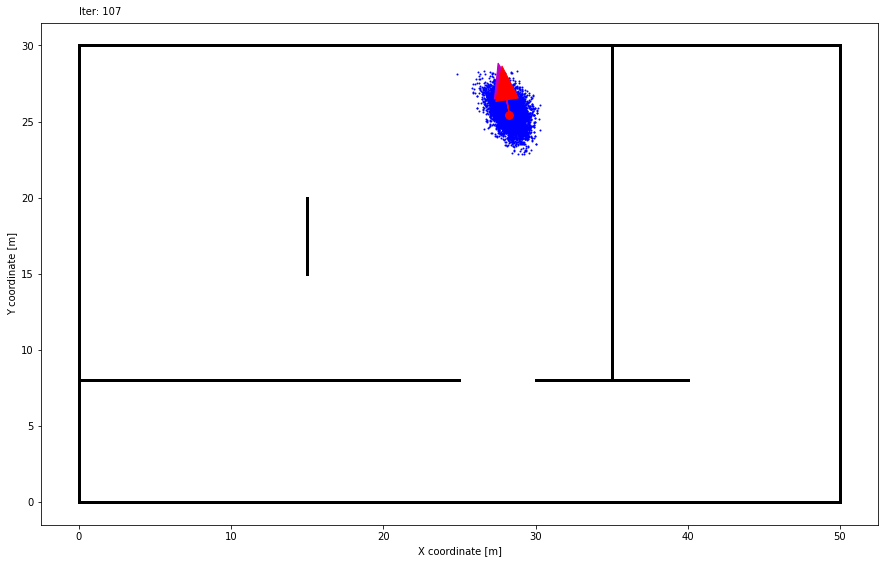

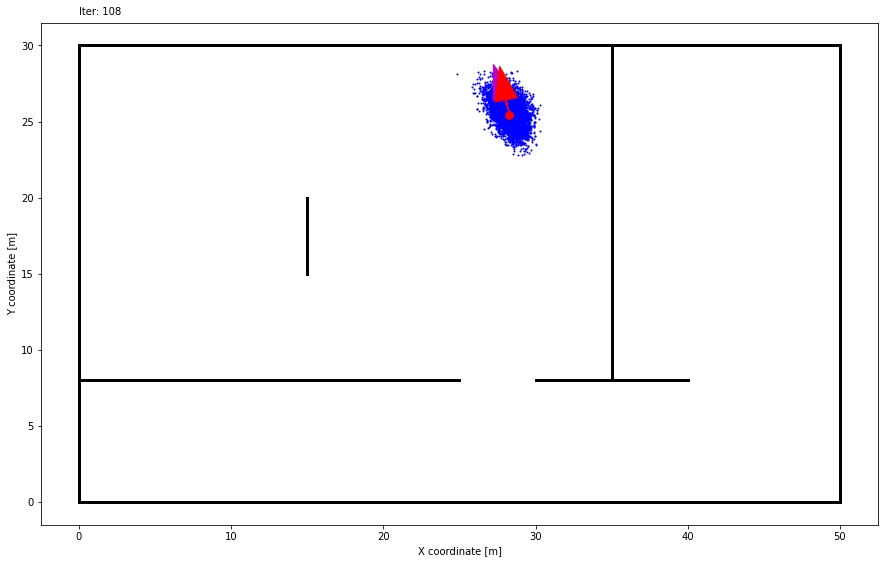

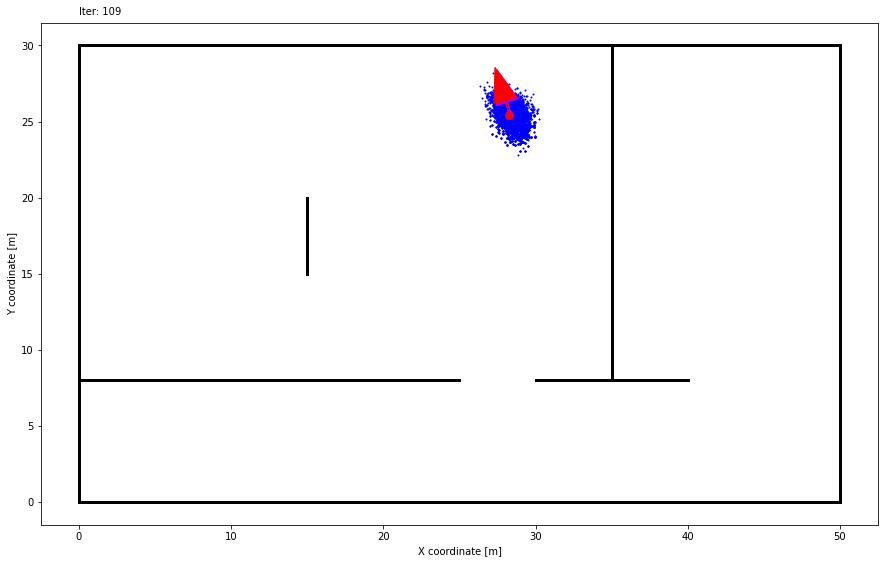

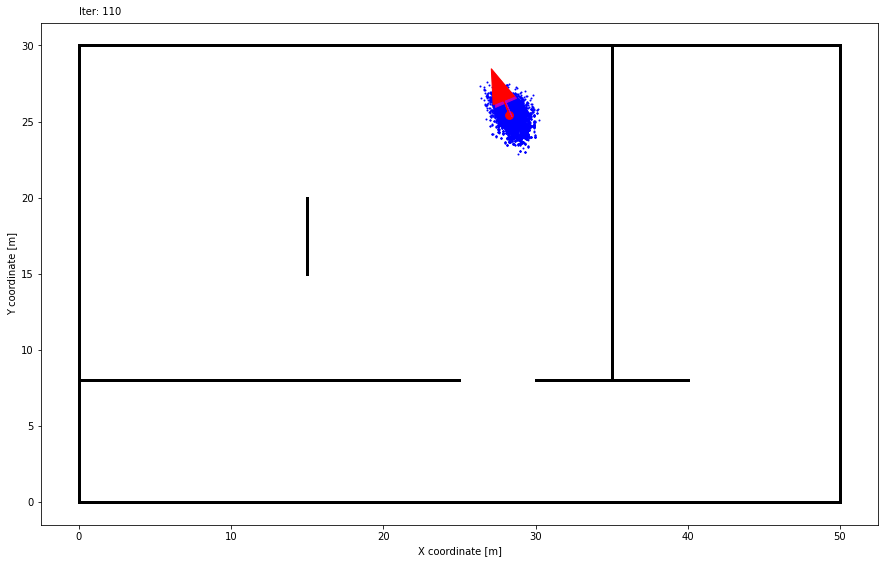

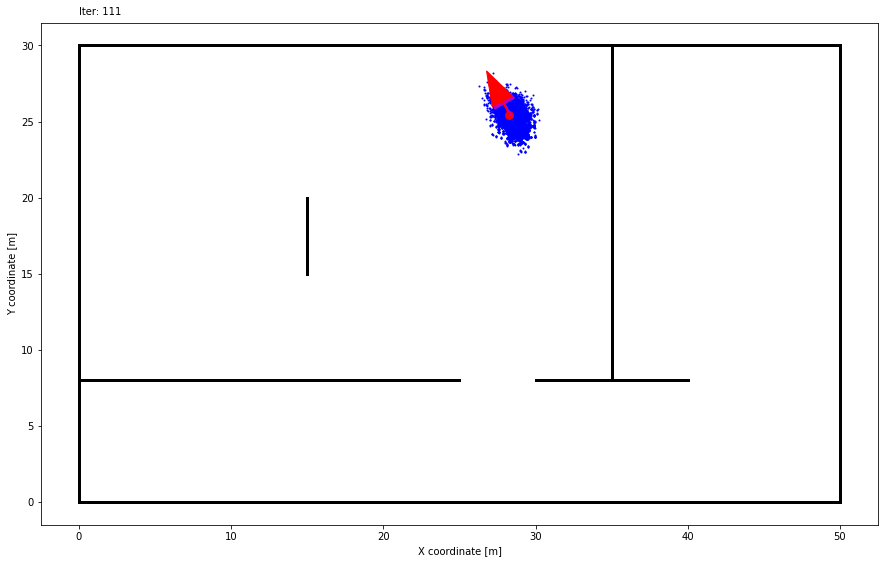

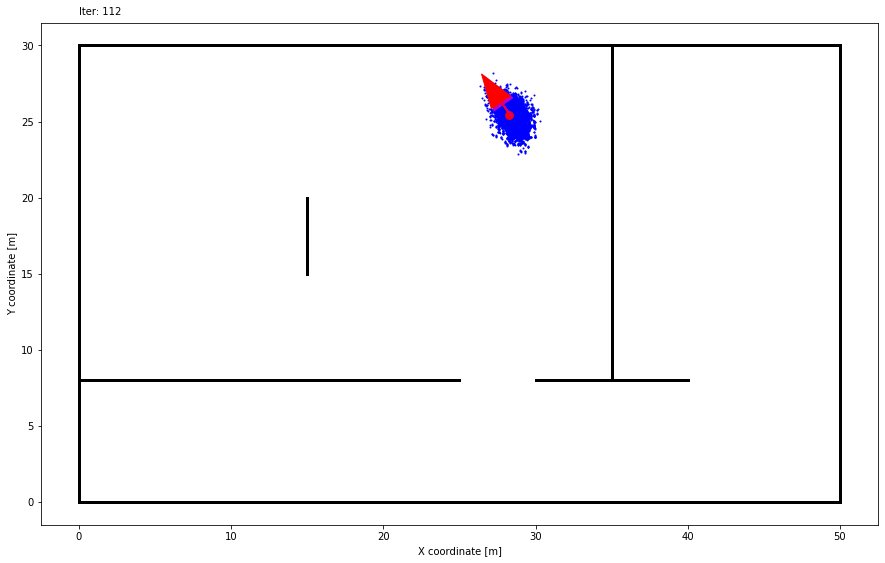

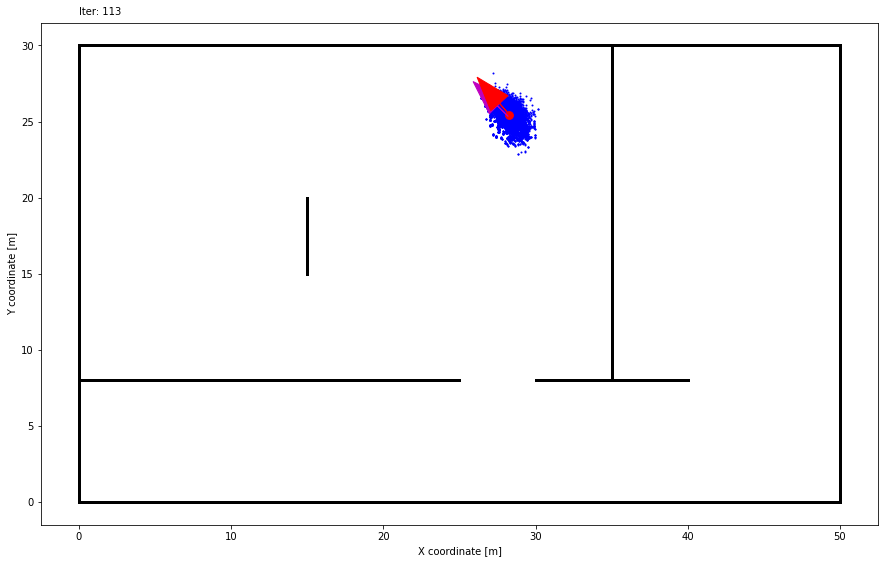

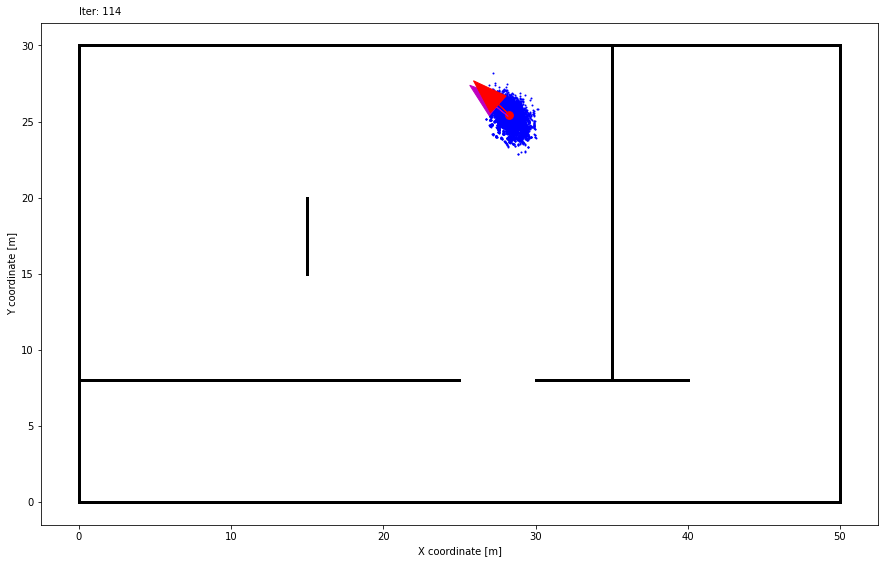

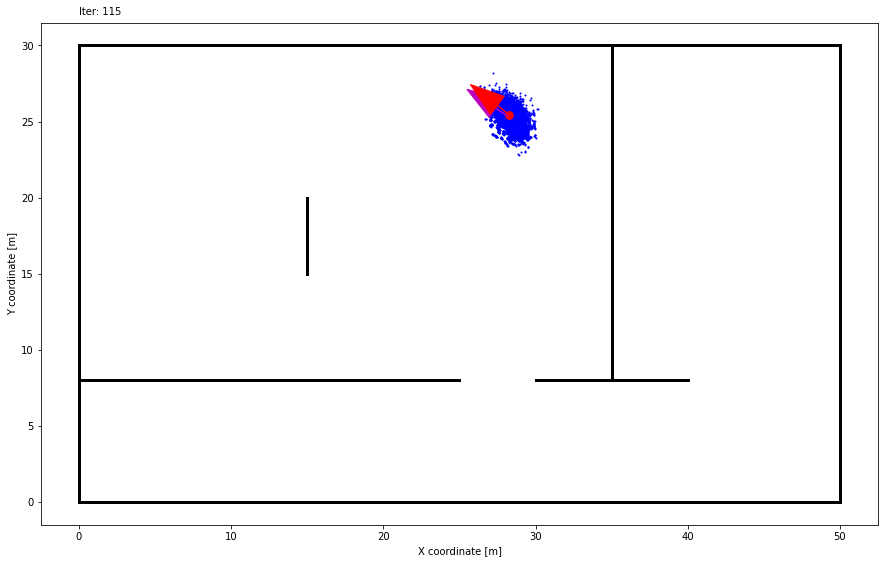

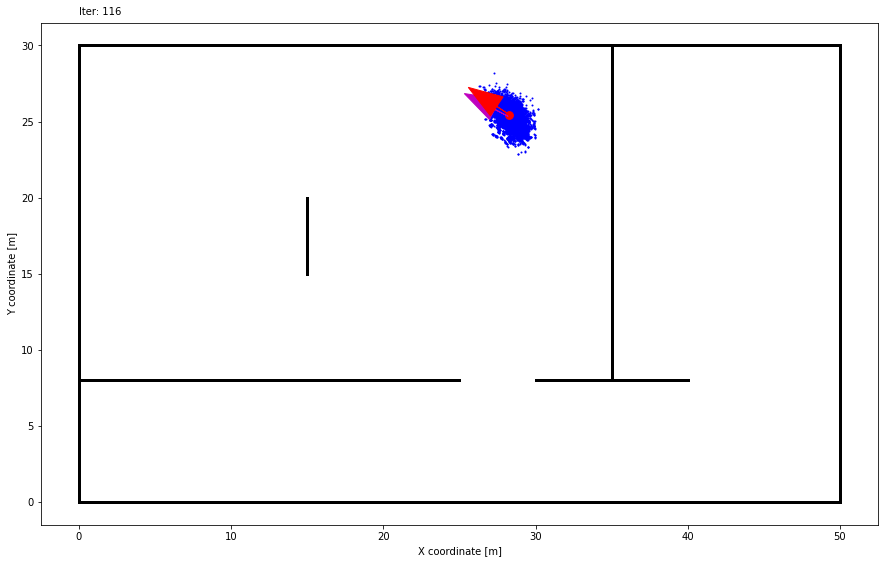

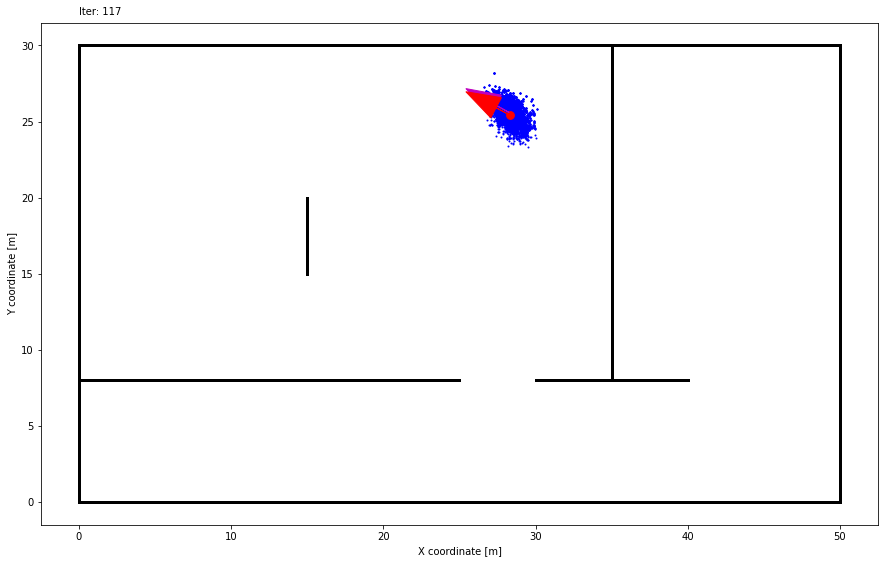

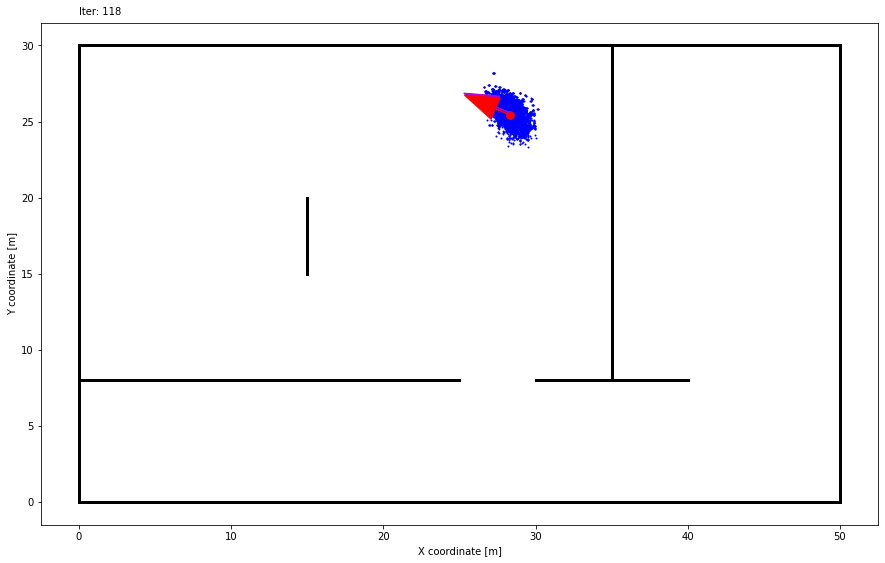

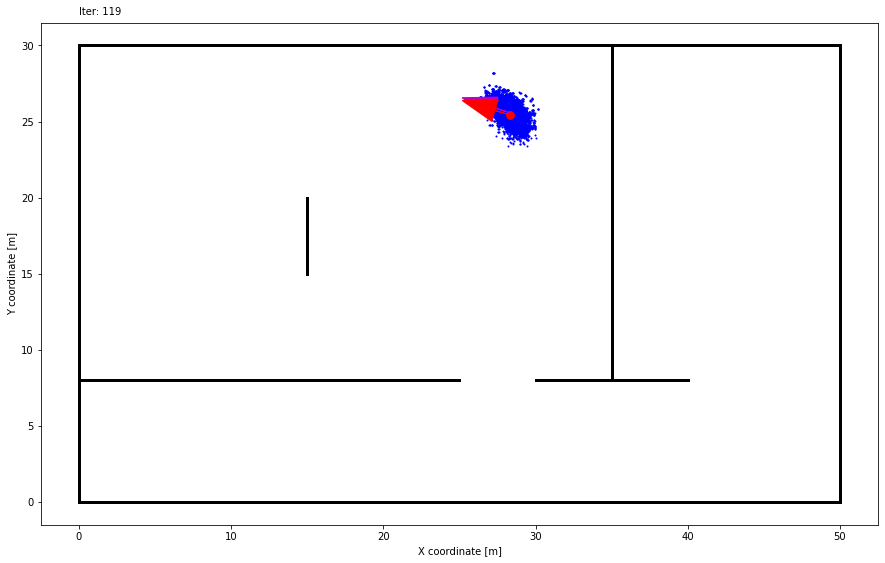

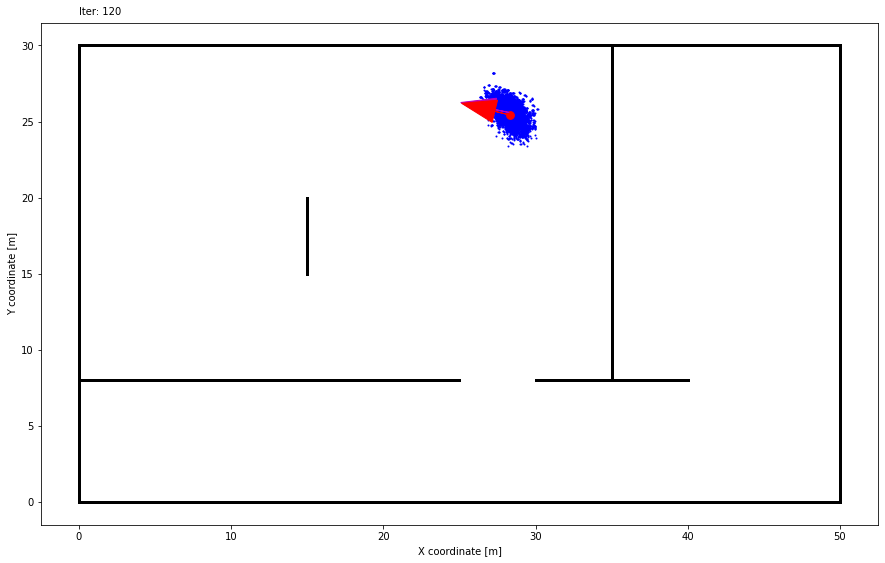

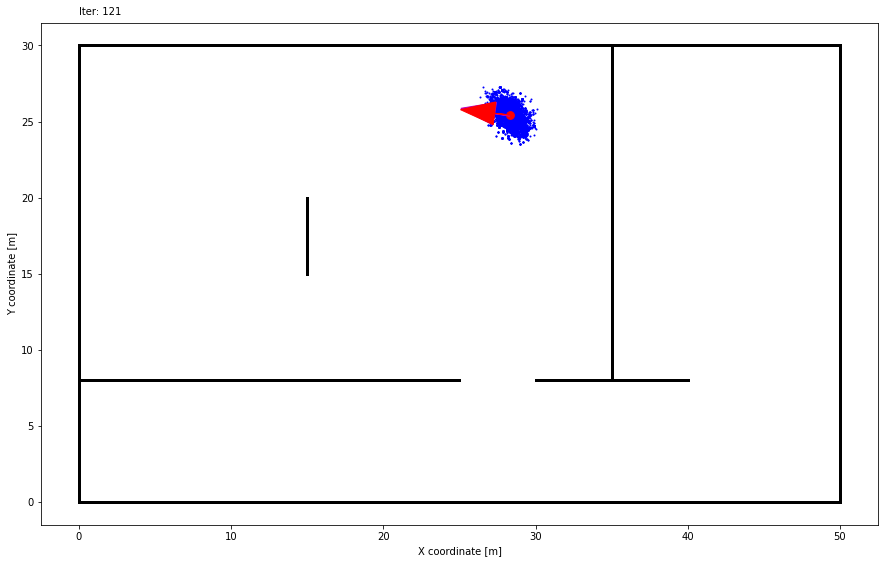

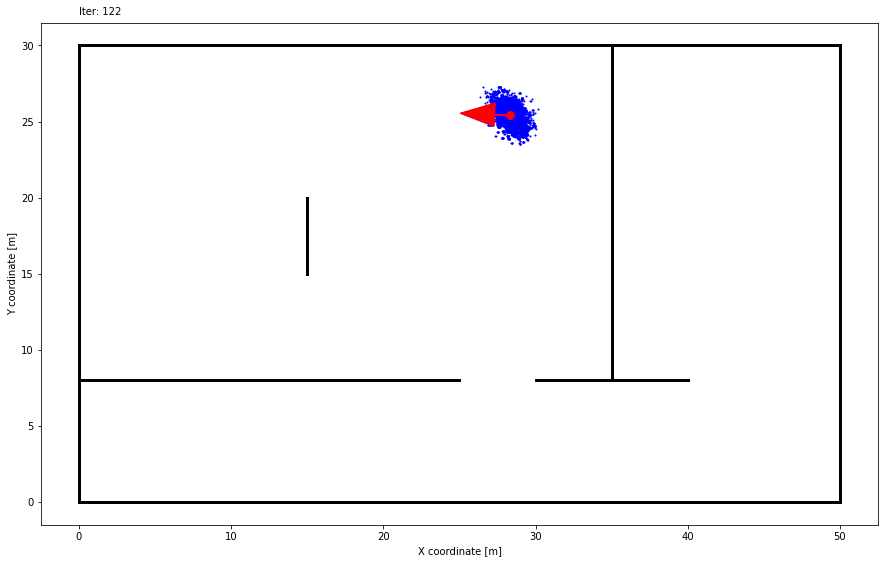

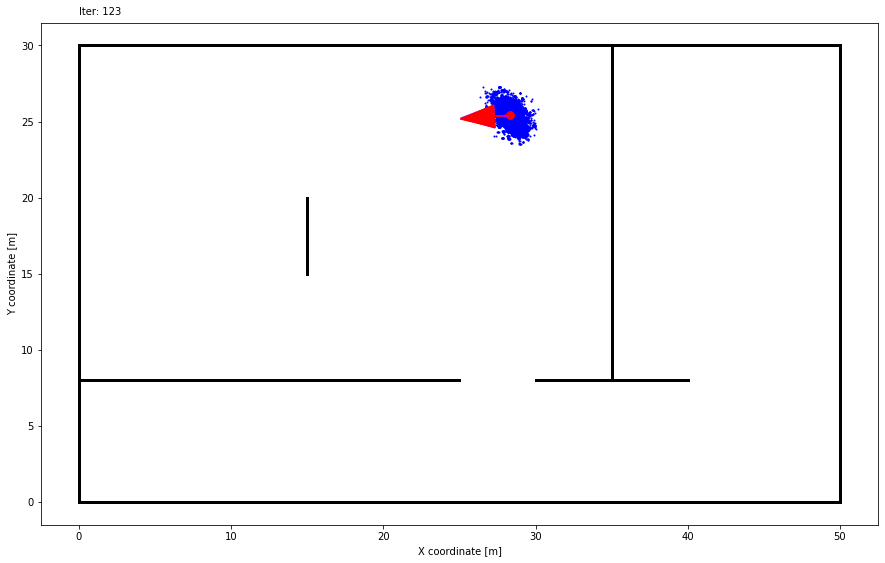

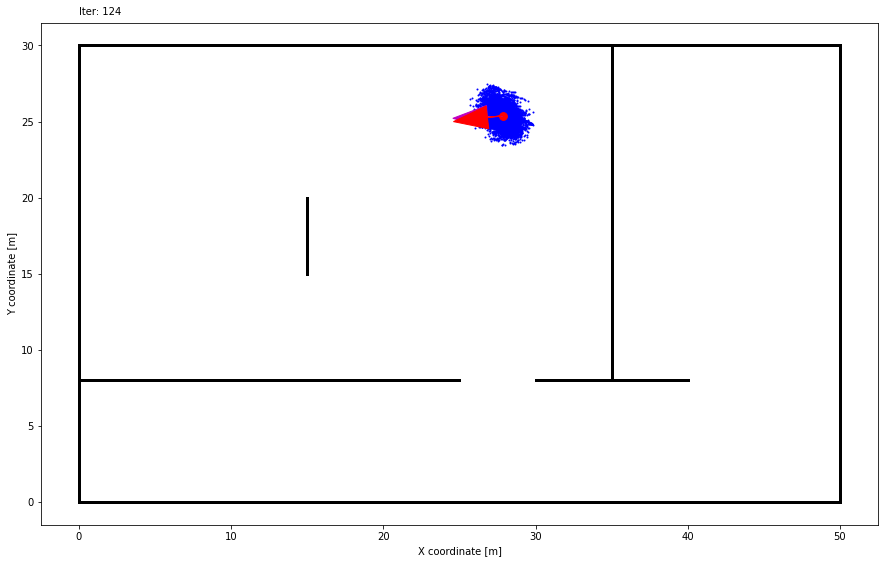

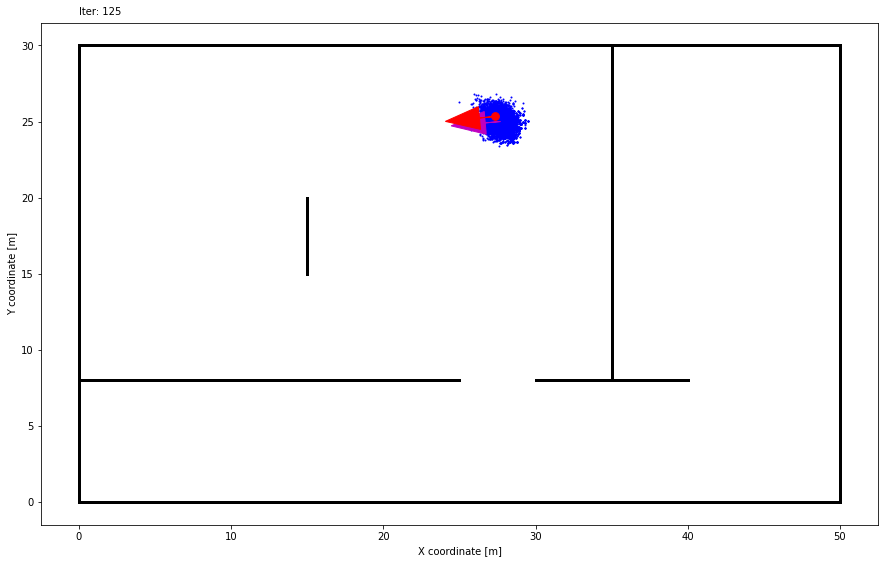

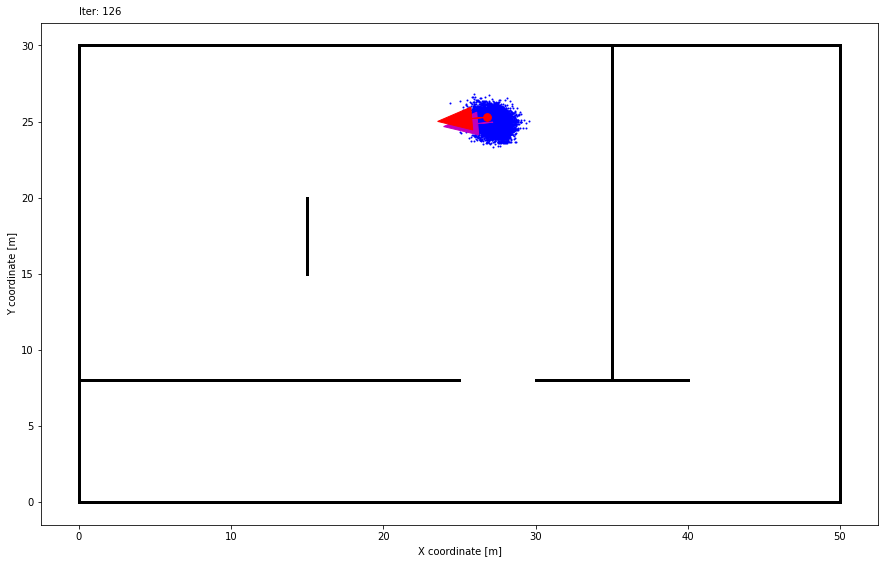

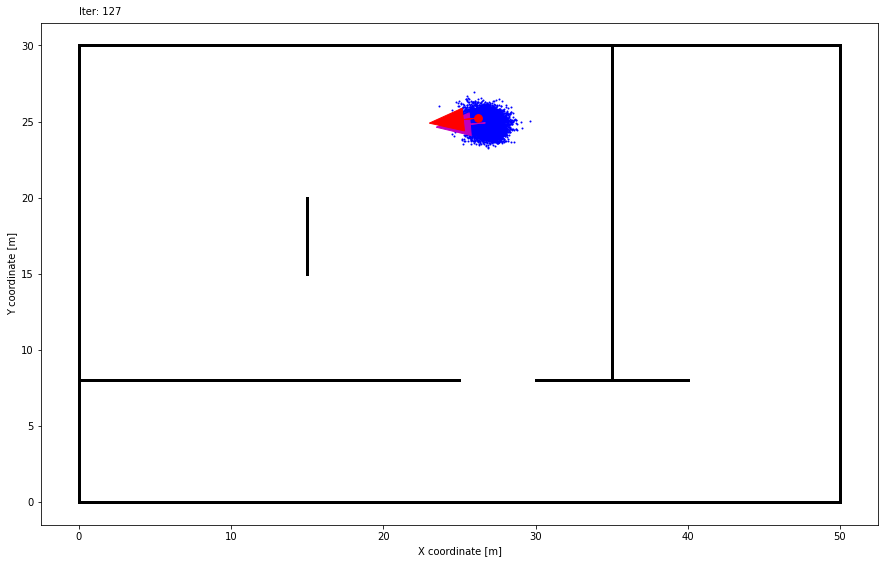

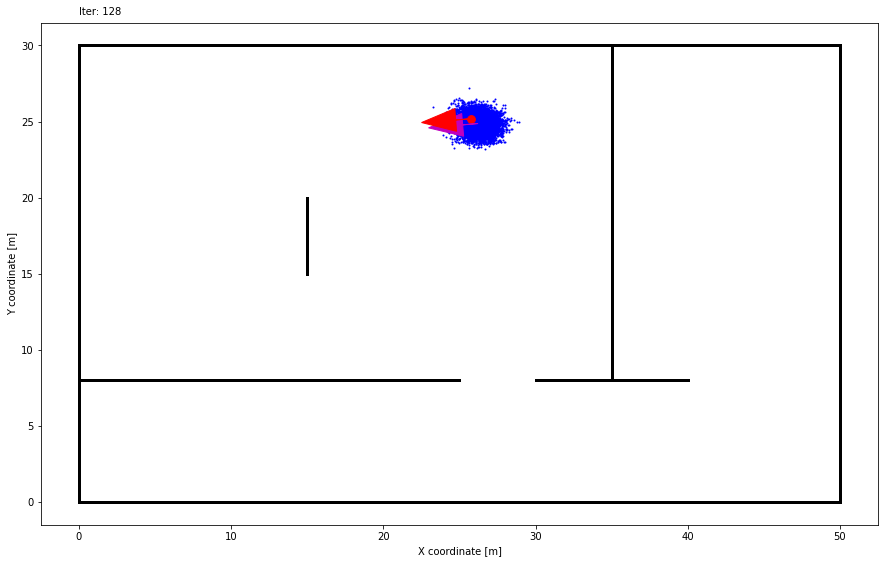

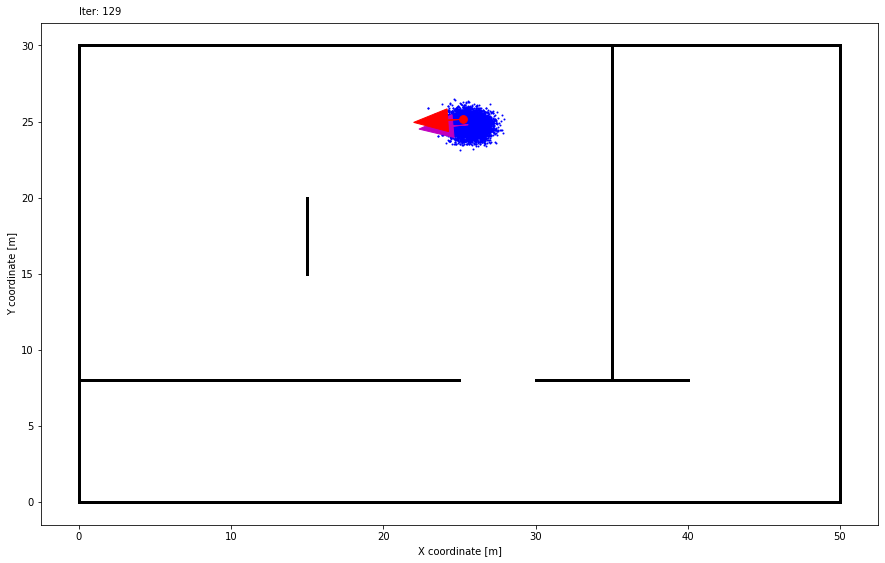

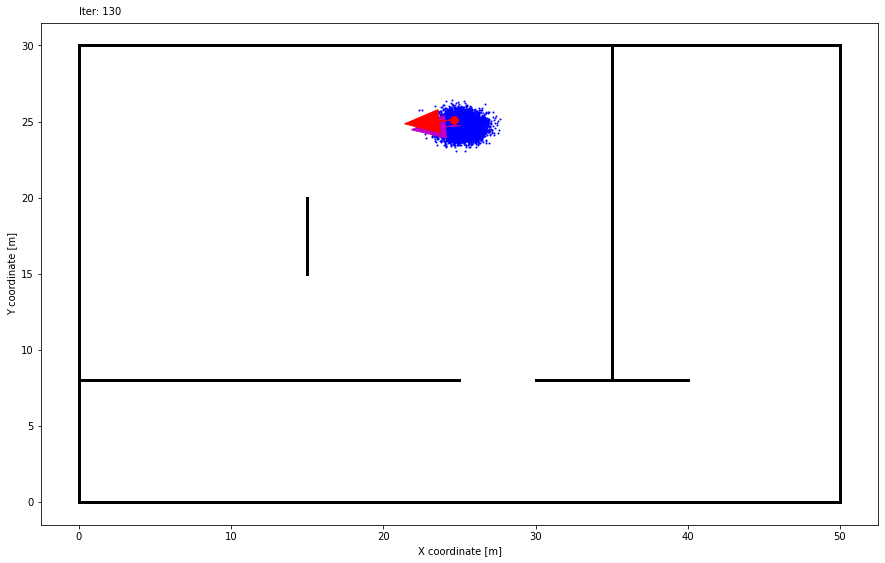

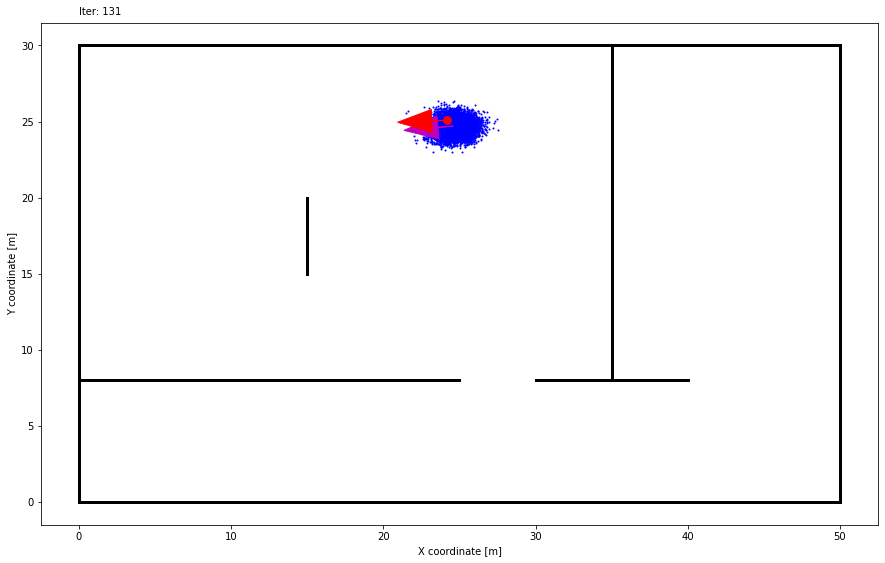

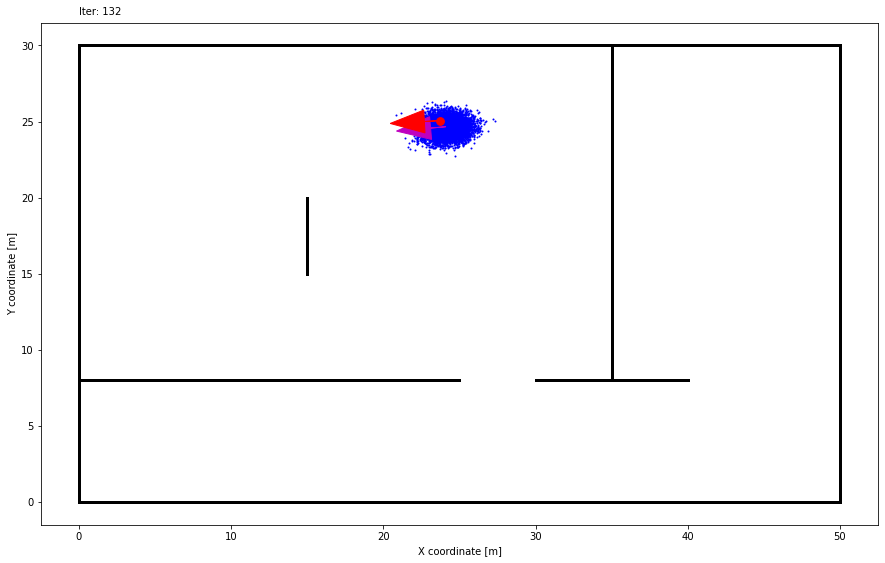

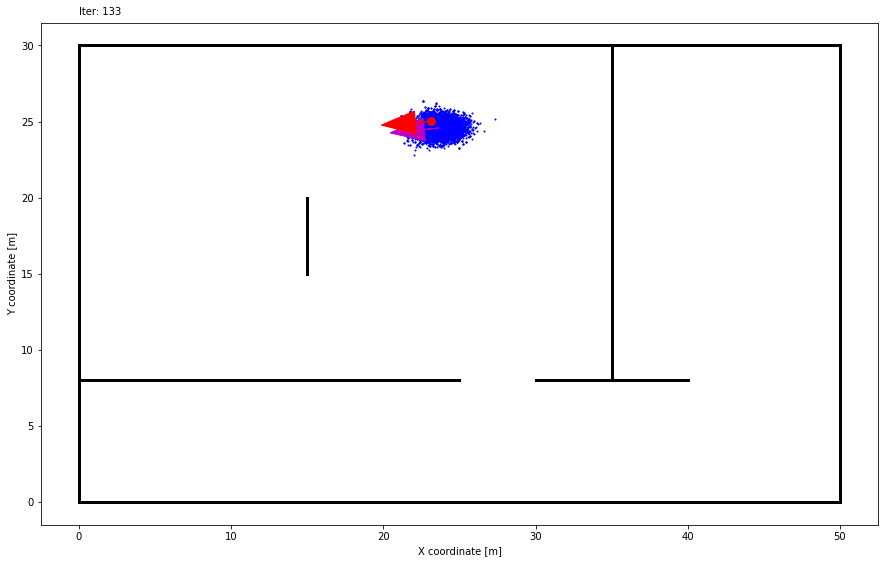

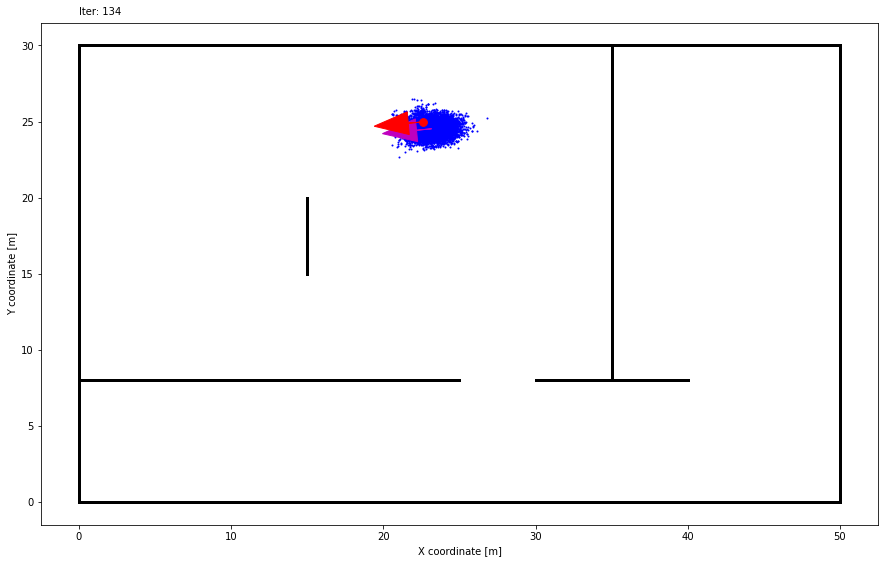

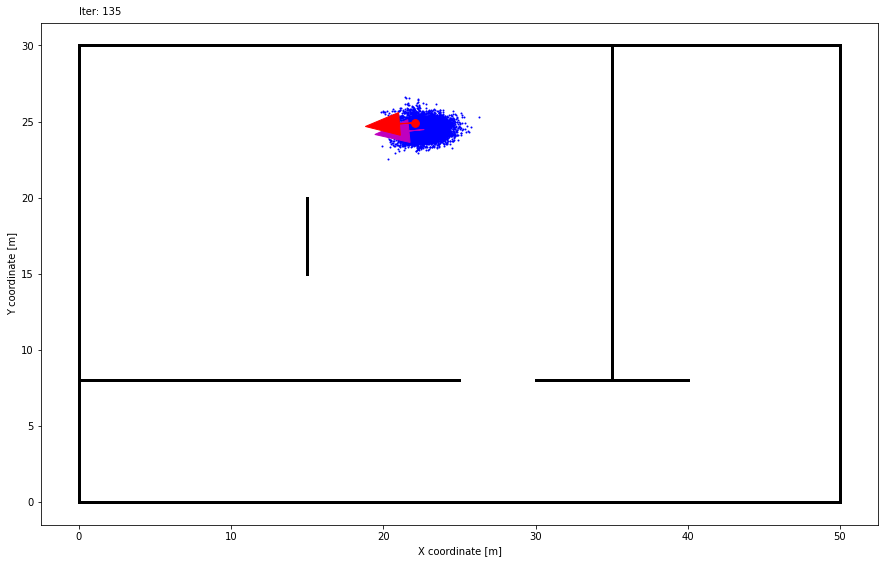

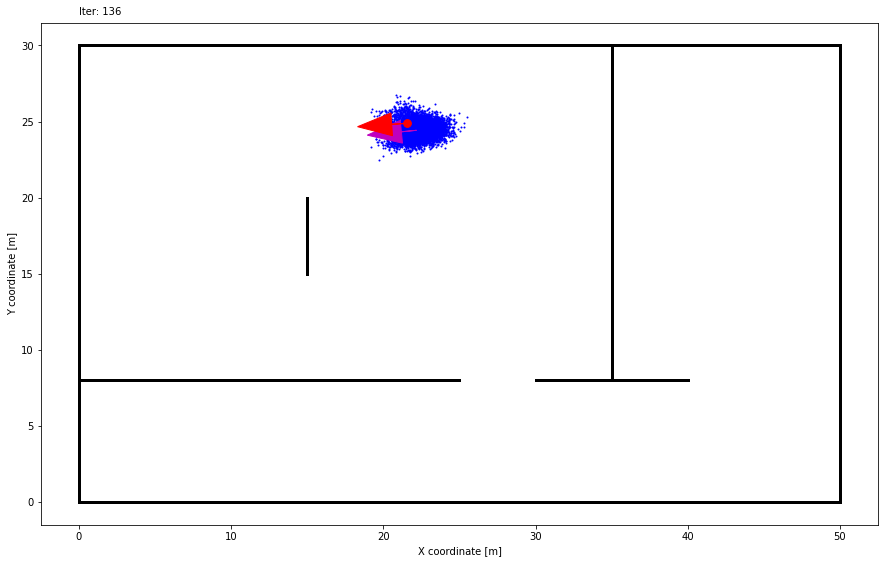

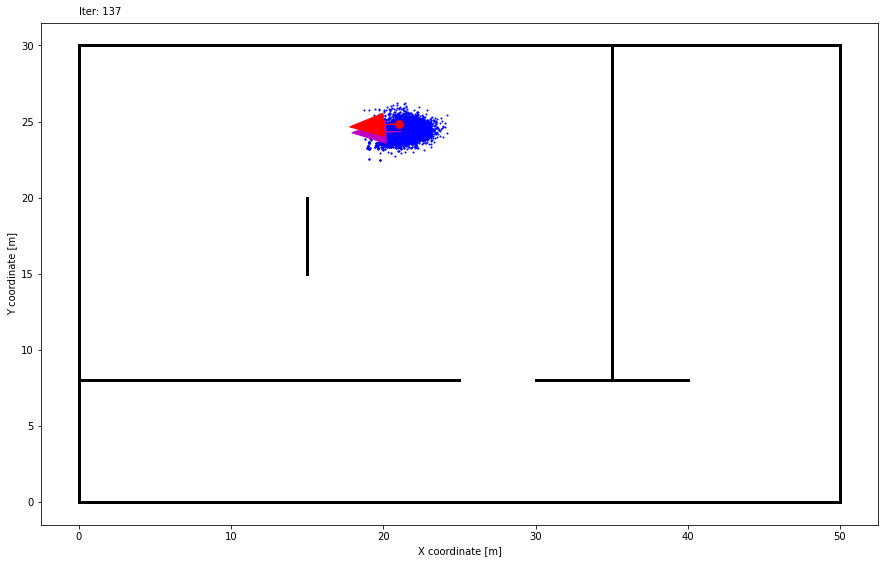

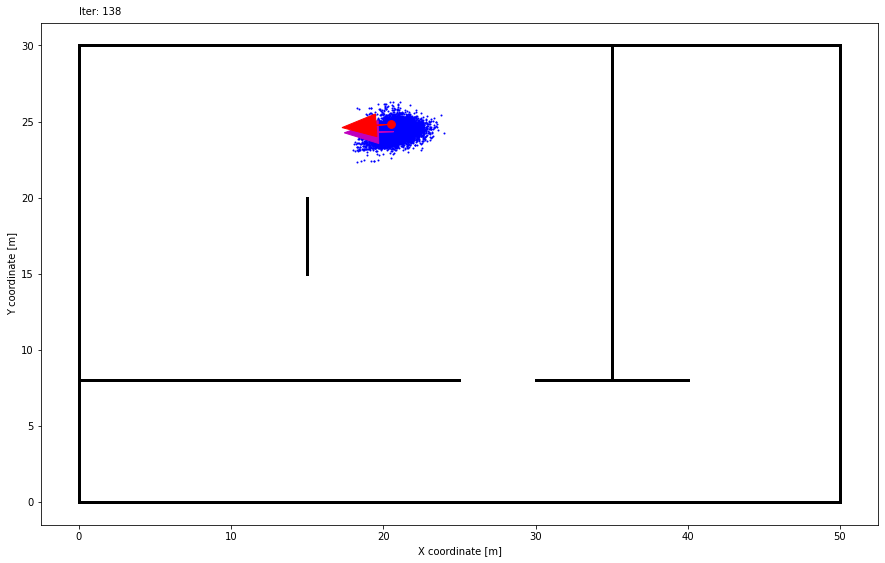

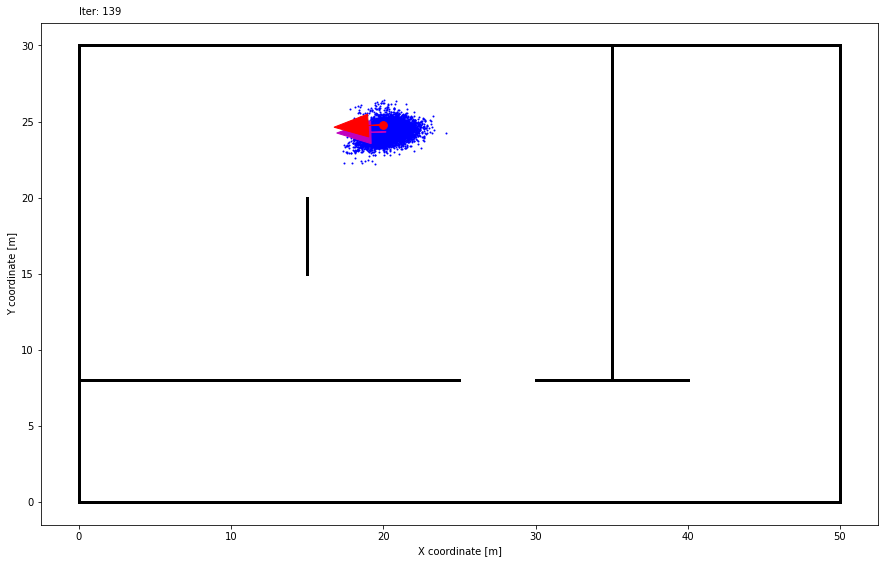

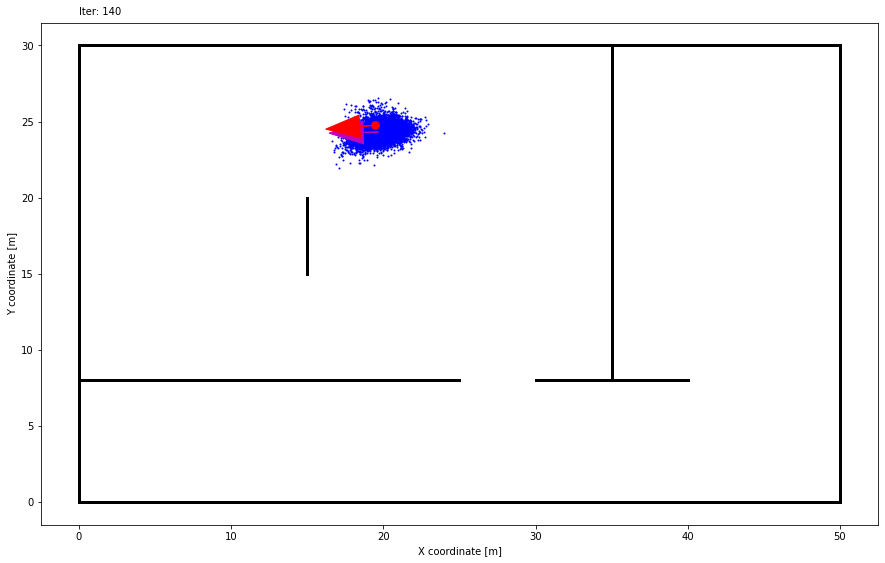

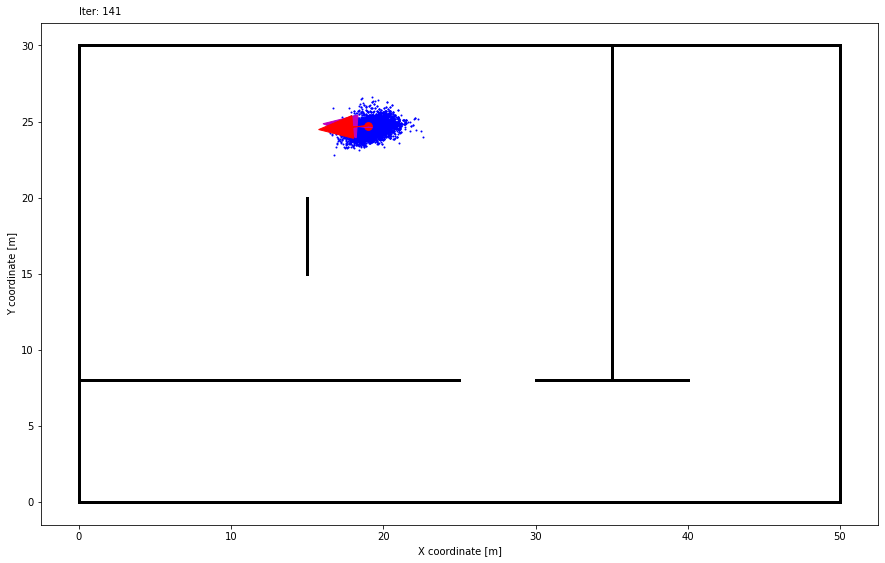

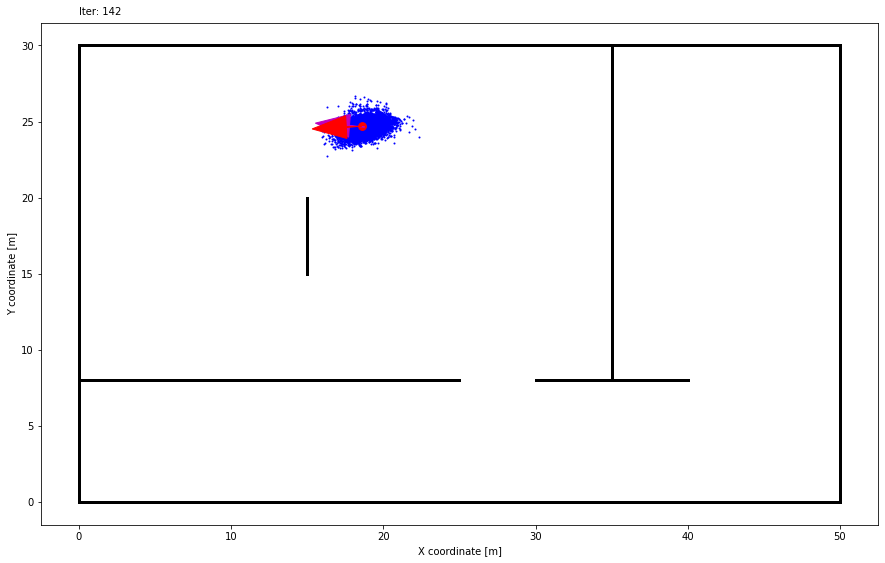

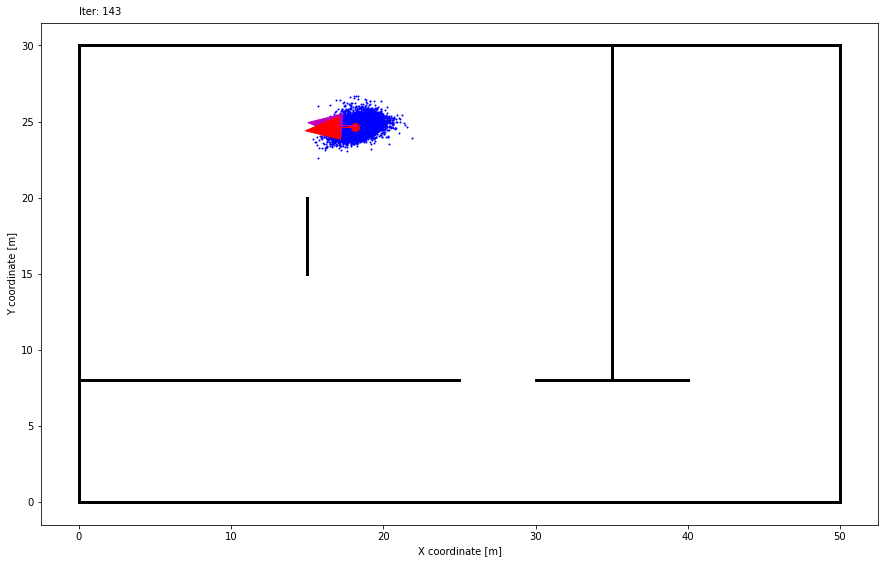

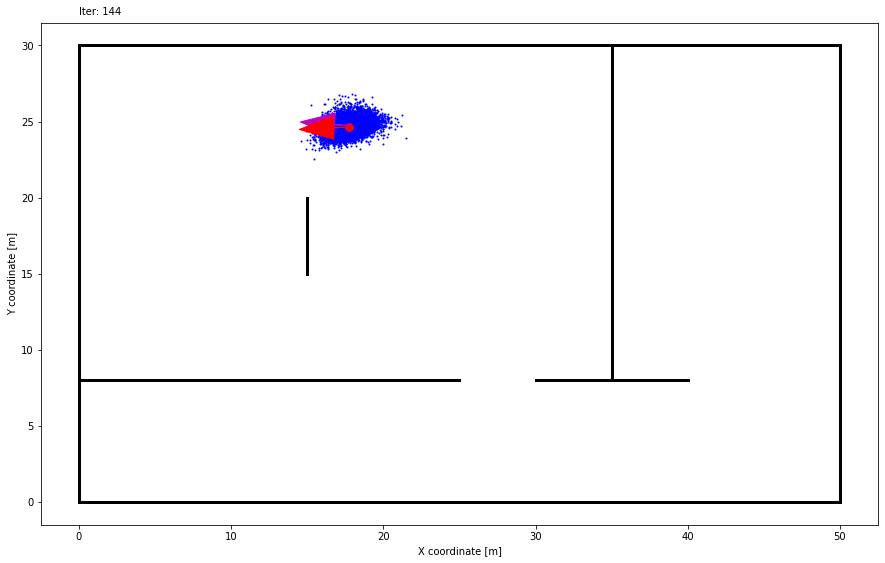

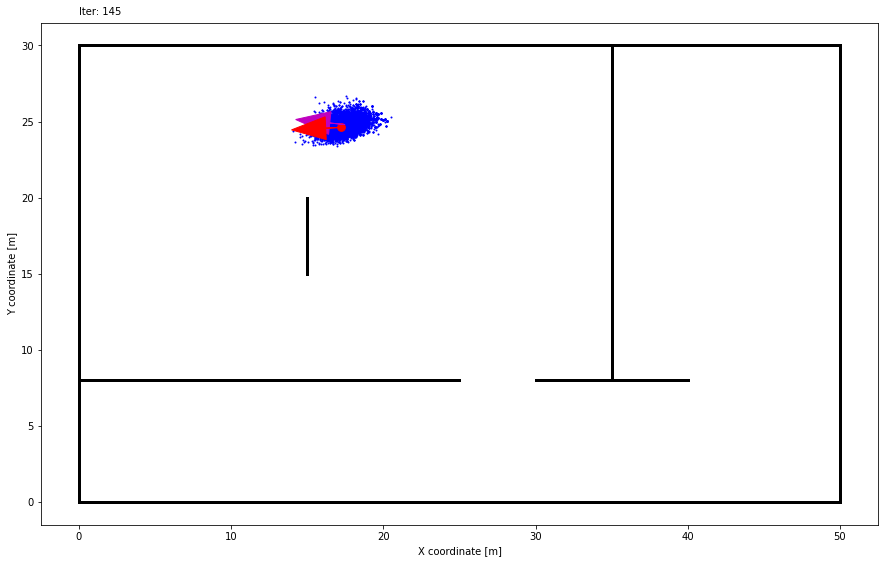

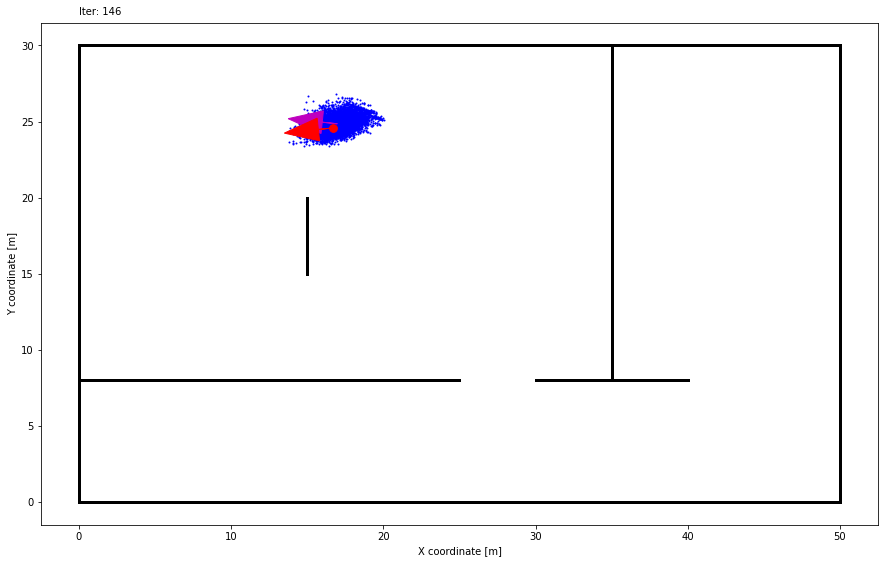

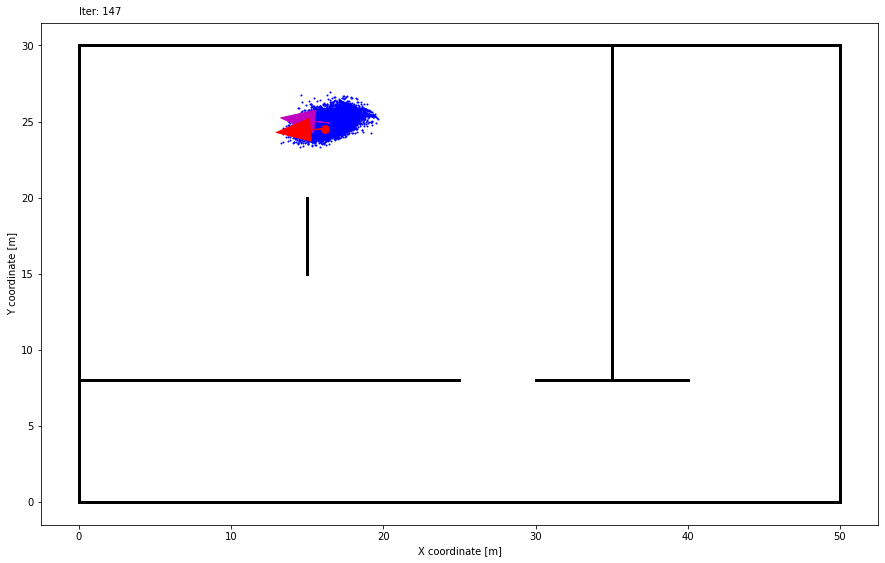

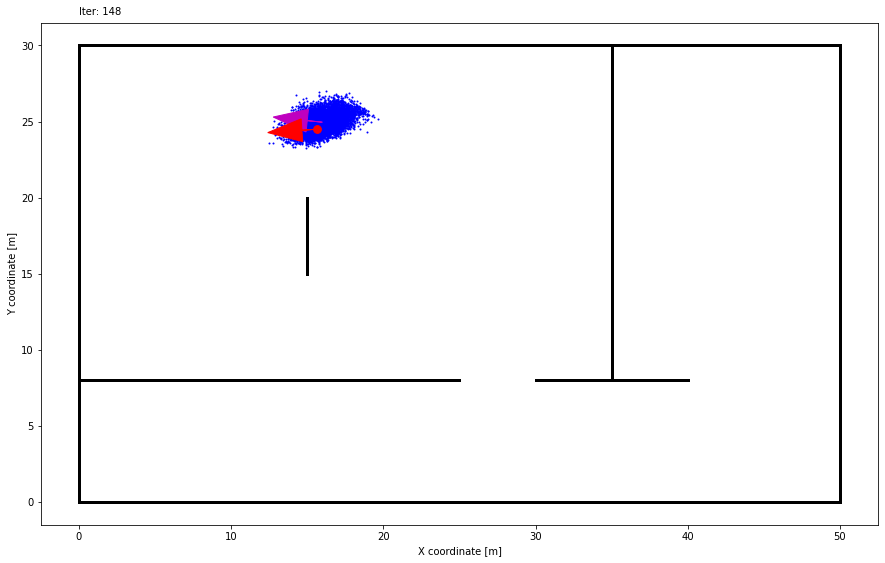

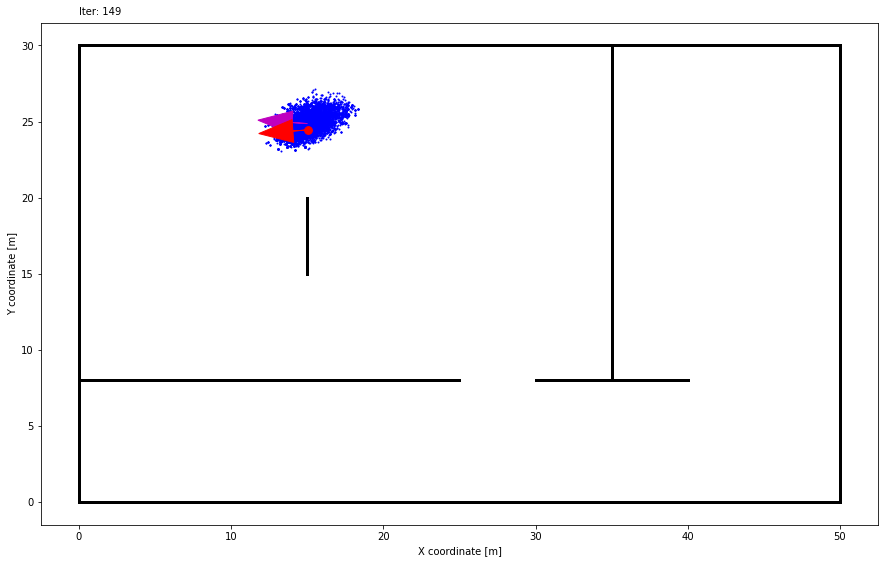

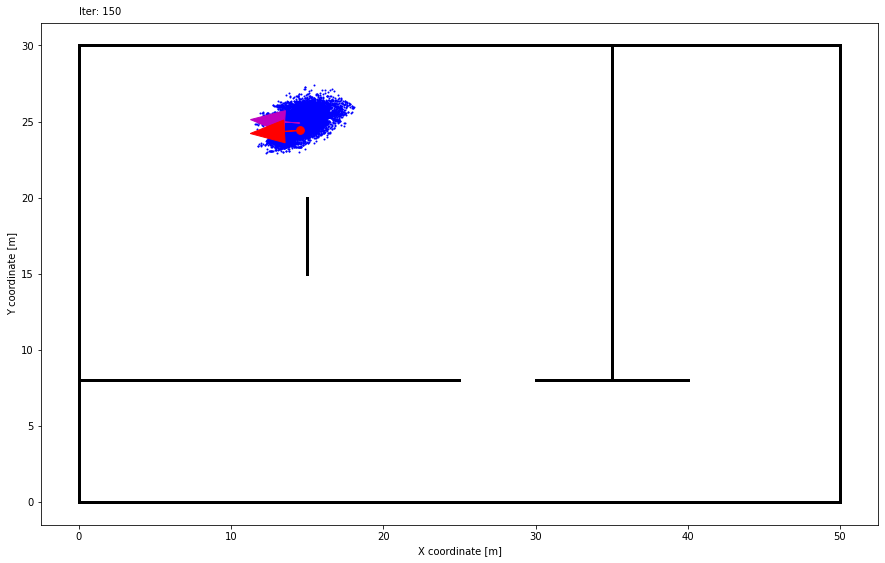

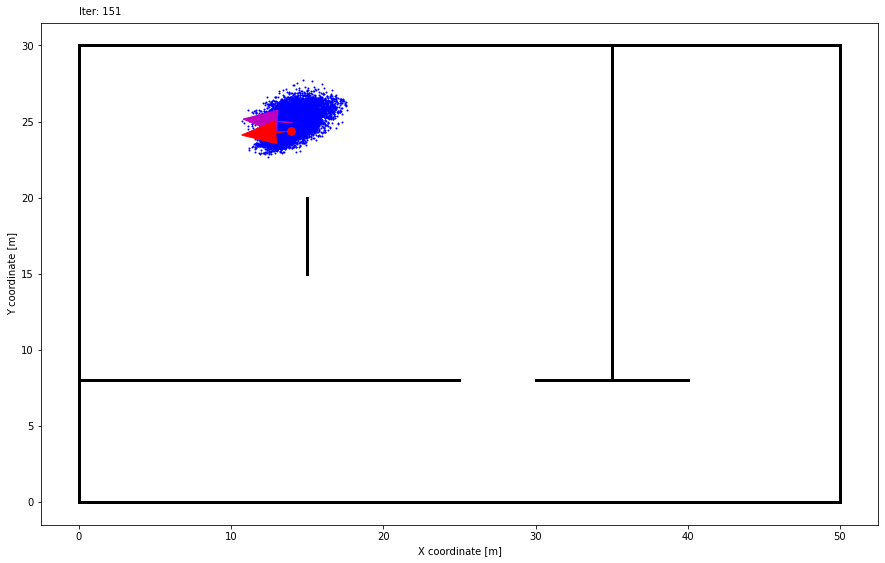

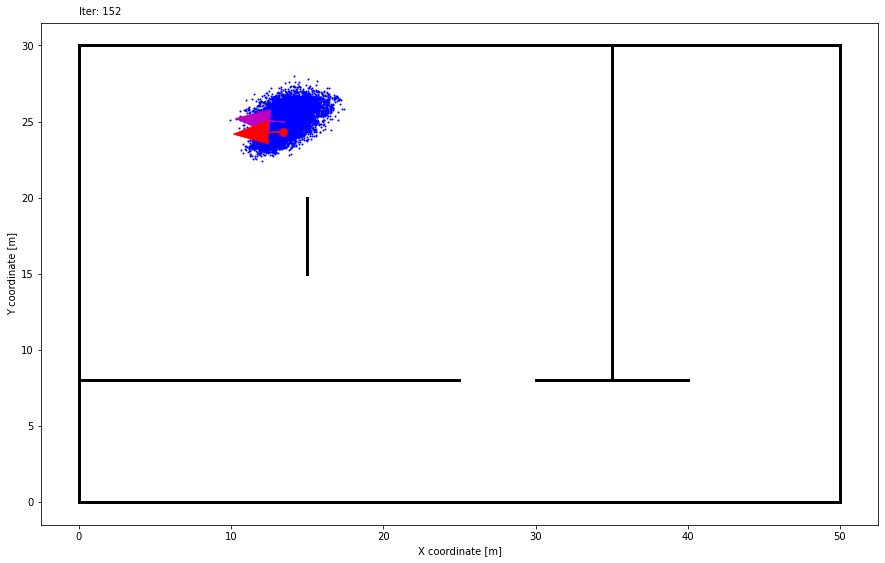

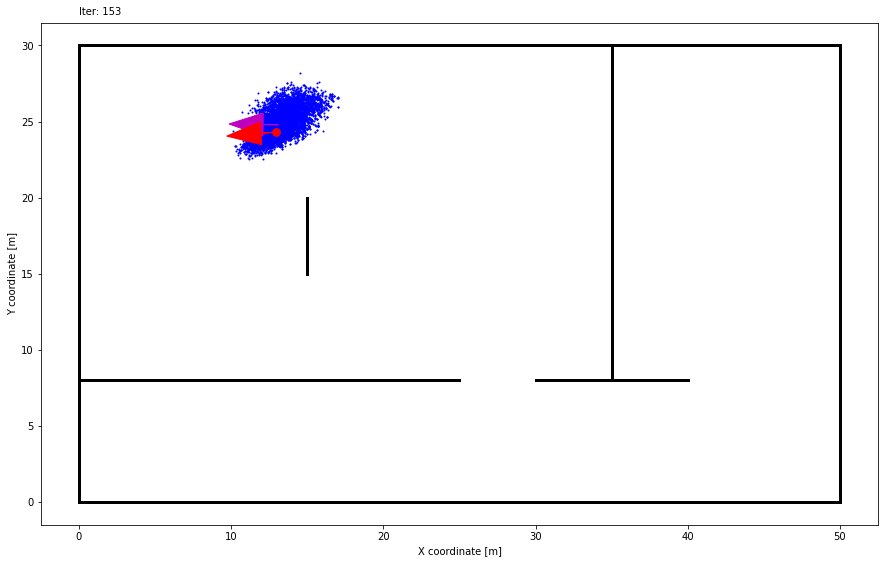

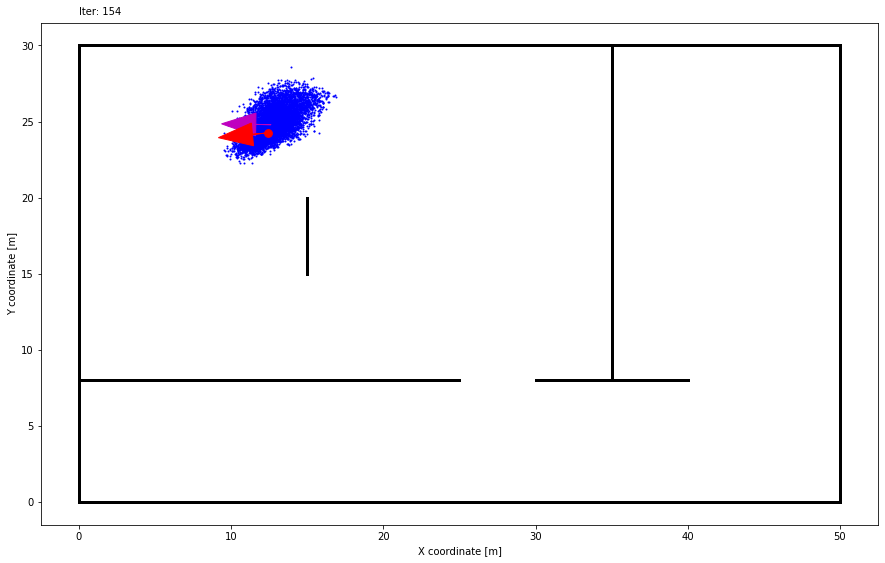

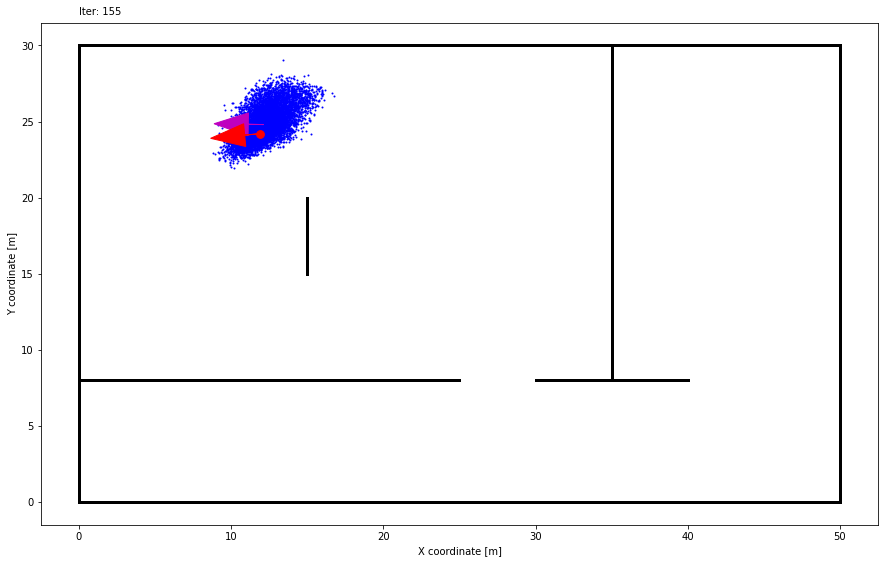

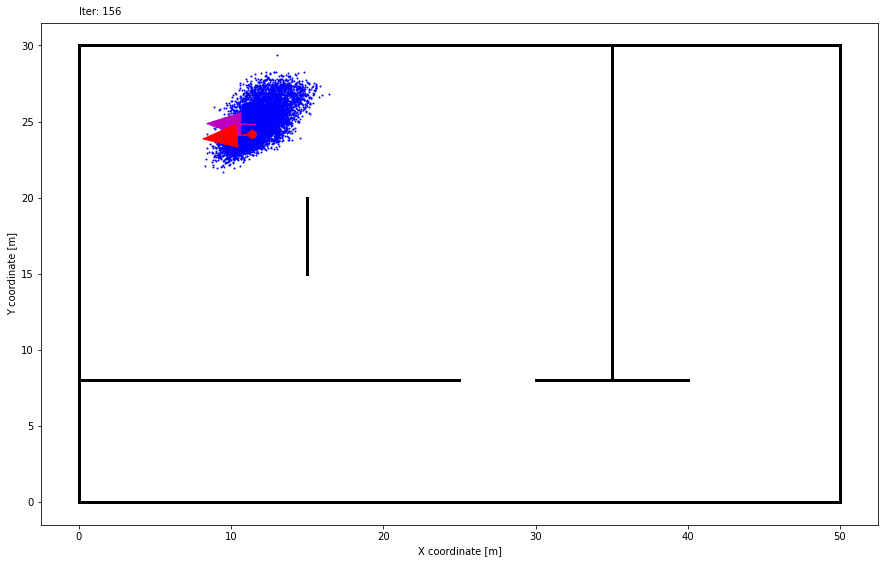

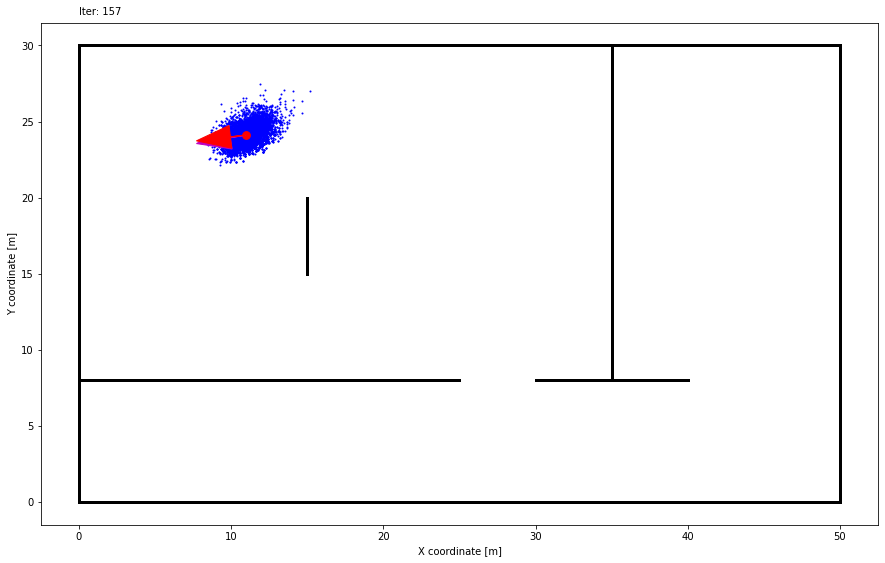

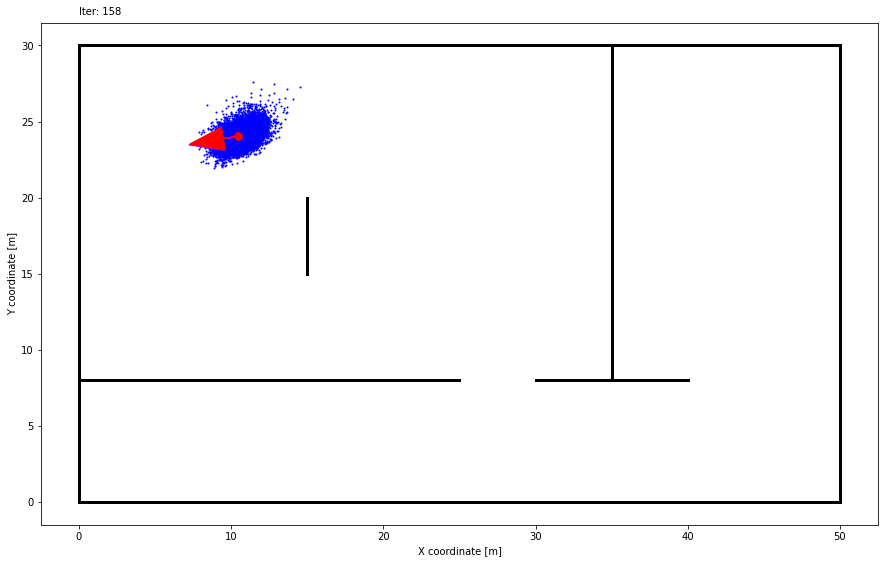

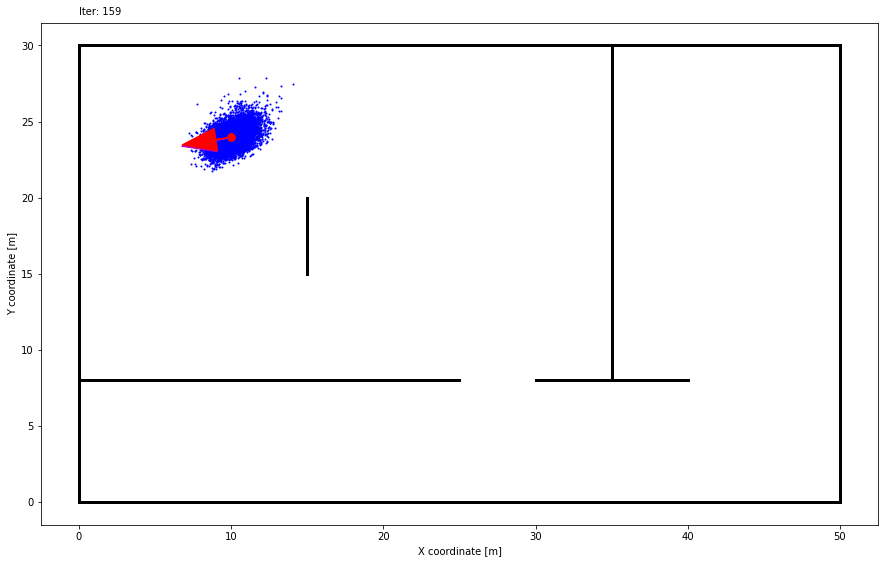

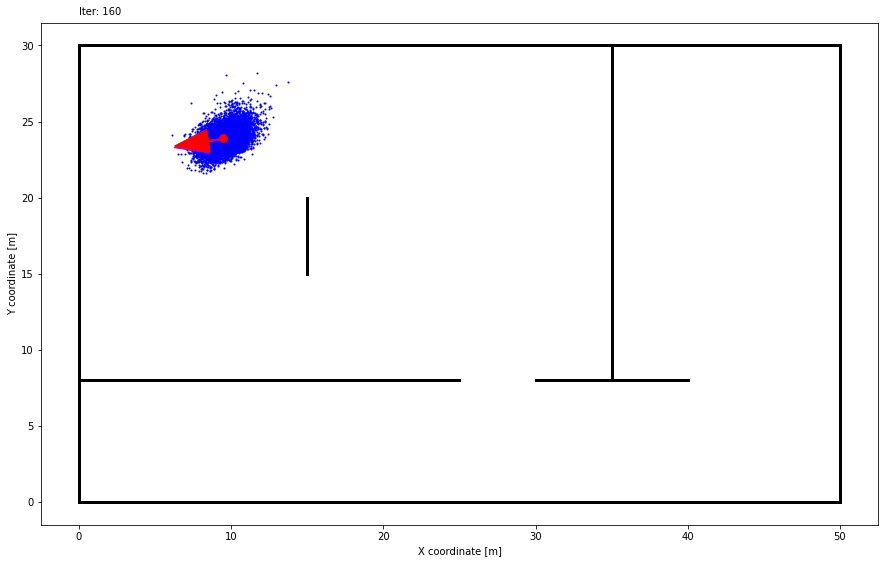

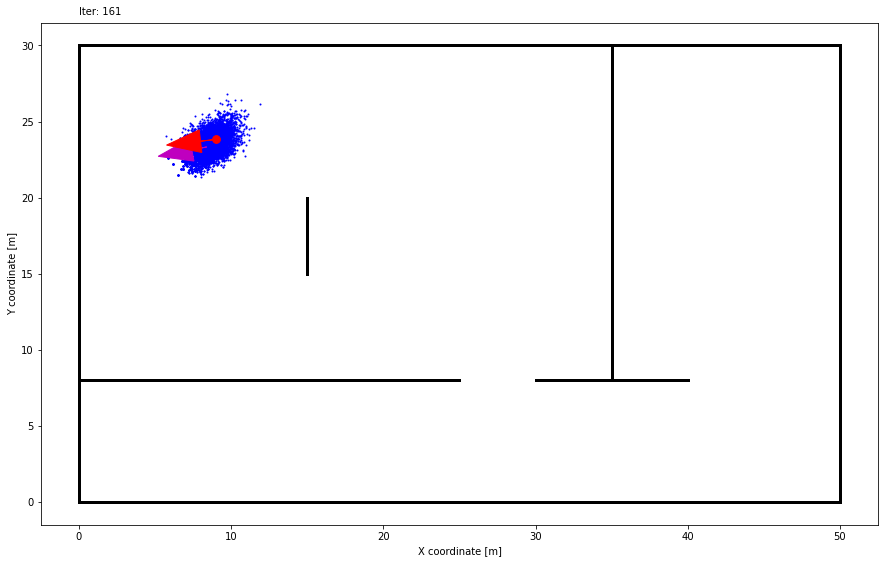

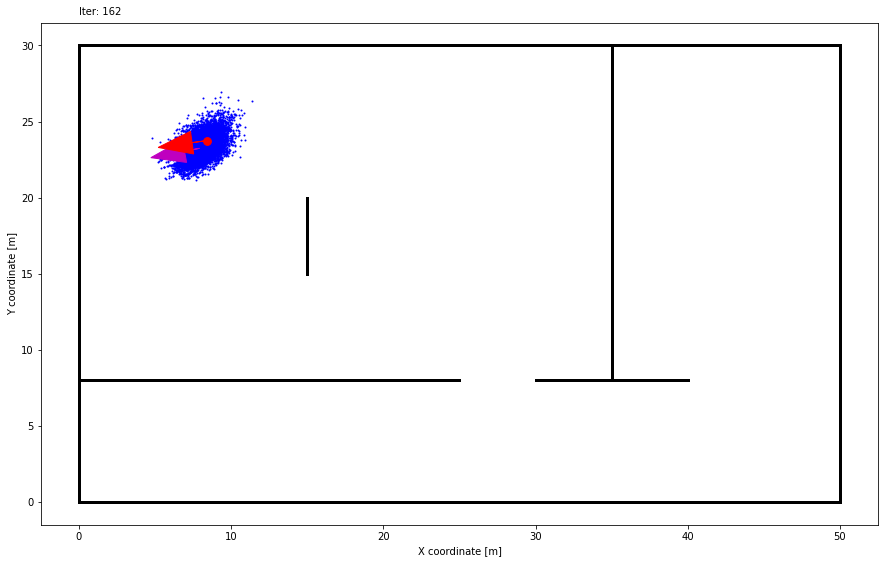

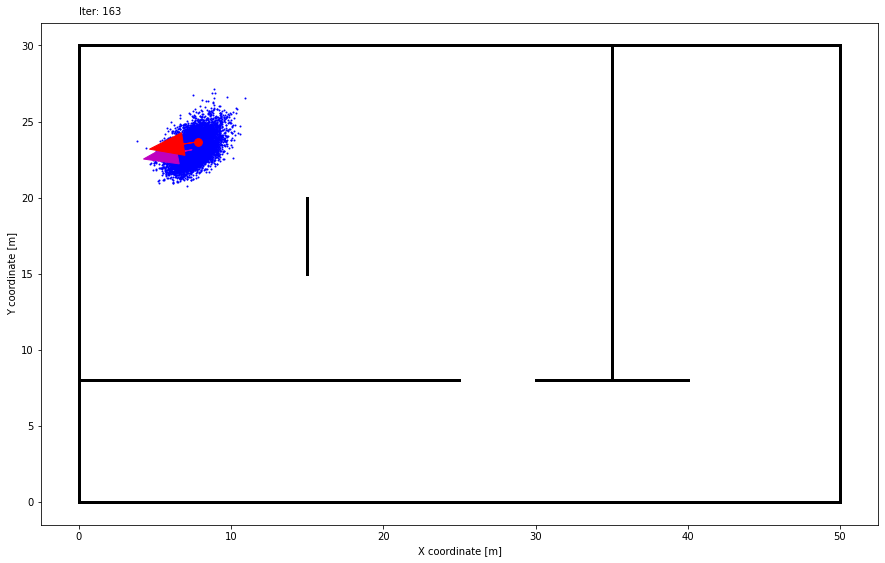

In [129]:
straight = [1, 0]
left = [0, 0.2]

errors_distance = []
errors_angle = []
stddev_x = []
stddev_y = []

savedir = 'animation10/'
n_particles = 10000


particles = np.array([np.random.uniform(0, 50, n_particles),
                      np.random.uniform(0, 30, n_particles),
                      np.random.uniform(0, 2*np.pi, n_particles)])
particles = particles.T

real_robot_pose = [4, 4, 0]

it = 0

plt.figure(figsize=(15,15))
plot_map()
plt.text(0, 32, "Iter: " + str(it))
plt.axis("scaled")
plt.xlabel("X coordinate [m]")
plt.ylabel("Y coordinate [m]")
plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), np.sin(real_robot_pose[2]), color='r', head_width=1.5)
plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.jpg')


while real_robot_pose[0] < 27:
    # predict
    real_robot_pose = precise_transition(real_robot_pose, straight)
    for i in range(len(particles)):
        particles[i] = transition(particles[i], straight)
    #update
    if it % 4 == 0:
        likelihoods = np.zeros(len(particles))
        real_scan = get_lidar_measurements(real_robot_pose, noisy=True)
        for i in range(len(particles)):
            measurement = get_lidar_measurements(particles[i])
            likelihoods[i] = calculate_likelihood(real_scan, measurement)
        particles = resampling(particles, likelihoods)

    estimated_pose[0] = np.sum(particles[:, 0]*likelihoods) / np.sum(likelihoods)
    estimated_pose[1] = np.sum(particles[:, 1]*likelihoods) / np.sum(likelihoods)
    estimated_pose[2] = np.arctan2(np.sum(np.sin(particles[:, 2])*likelihoods) / np.sum(likelihoods), np.sum(np.cos(particles[:, 2])*likelihoods) / np.sum(likelihoods))
    
    errors_distance.append(((estimated_pose[0]-real_robot_pose[0])**2 + (estimated_pose[1]-real_robot_pose[1])**2)**0.5)
    errors_angle.append(np.pi - abs(abs(estimated_pose[2] - real_robot_pose[2]) - np.pi))
    stddev_x.append(np.std(particles[:, 0]))
    stddev_y.append(np.std(particles[:, 1]))

    it += 1
    
    plt.figure(figsize=(15,15))
    plot_map()
    plt.text(0, 32, "Iter: " + str(it))
    plt.axis("scaled")
    plt.xlabel("X coordinate [m]")
    plt.ylabel("Y coordinate [m]")
    plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
    plt.arrow(estimated_pose[0], estimated_pose[1], np.cos(estimated_pose[2]), np.sin(estimated_pose[2]), color='m', head_width=1.5)
    plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
    plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), np.sin(real_robot_pose[2]), color='r', head_width=1.5)
    plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.jpg')
    

while real_robot_pose[2] < np.pi/2 or real_robot_pose[2] > 2*np.pi-0.2:
    # predict
    real_robot_pose = precise_transition(real_robot_pose, left)
    for i in range(len(particles)):
        particles[i] = transition(particles[i], left)
    #update
    if it % 4 == 0:
        likelihoods = np.zeros(len(particles))
        real_scan = get_lidar_measurements(real_robot_pose, noisy=True)
        for i in range(len(particles)):
            measurement = get_lidar_measurements(particles[i])
            likelihoods[i] = calculate_likelihood(real_scan, measurement)
        particles = resampling(particles, likelihoods)

    estimated_pose[0] = np.sum(particles[:, 0]*likelihoods) / np.sum(likelihoods)
    estimated_pose[1] = np.sum(particles[:, 1]*likelihoods) / np.sum(likelihoods)
    estimated_pose[2] = np.arctan2(np.sum(np.sin(particles[:, 2])*likelihoods) / np.sum(likelihoods), np.sum(np.cos(particles[:, 2])*likelihoods) / np.sum(likelihoods))
    
    errors_distance.append(((estimated_pose[0]-real_robot_pose[0])**2 + (estimated_pose[1]-real_robot_pose[1])**2)**0.5)
    errors_angle.append(np.pi - abs(abs(estimated_pose[2] - real_robot_pose[2]) - np.pi))
    stddev_x.append(np.std(particles[:, 0]))
    stddev_y.append(np.std(particles[:, 1]))

    it += 1
    
    plt.figure(figsize=(15,15))
    plot_map()
    plt.text(0, 32, "Iter: " + str(it))
    plt.axis("scaled")
    plt.xlabel("X coordinate [m]")
    plt.ylabel("Y coordinate [m]")
    plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
    plt.arrow(estimated_pose[0], estimated_pose[1], np.cos(estimated_pose[2]), np.sin(estimated_pose[2]), color='m', head_width=1.5)
    plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
    plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), np.sin(real_robot_pose[2]), color='r', head_width=1.5)
    plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.jpg')
    
    
while real_robot_pose[1] < 25:
    # predict
    real_robot_pose = precise_transition(real_robot_pose, straight)
    for i in range(len(particles)):
        particles[i] = transition(particles[i], straight)
    #update
    if it % 4 == 0:
        likelihoods = np.zeros(len(particles))
        real_scan = get_lidar_measurements(real_robot_pose, noisy=True)
        for i in range(len(particles)):
            measurement = get_lidar_measurements(particles[i])
            likelihoods[i] = calculate_likelihood(real_scan, measurement)
        particles = resampling(particles, likelihoods)

    estimated_pose[0] = np.sum(particles[:, 0]*likelihoods) / np.sum(likelihoods)
    estimated_pose[1] = np.sum(particles[:, 1]*likelihoods) / np.sum(likelihoods)
    estimated_pose[2] = np.arctan2(np.sum(np.sin(particles[:, 2])*likelihoods) / np.sum(likelihoods), np.sum(np.cos(particles[:, 2])*likelihoods) / np.sum(likelihoods))
    
    errors_distance.append(((estimated_pose[0]-real_robot_pose[0])**2 + (estimated_pose[1]-real_robot_pose[1])**2)**0.5)
    errors_angle.append(np.pi - abs(abs(estimated_pose[2] - real_robot_pose[2]) - np.pi))
    stddev_x.append(np.std(particles[:, 0]))
    stddev_y.append(np.std(particles[:, 1]))

    it += 1
    
    plt.figure(figsize=(15,15))
    plot_map()
    plt.text(0, 32, "Iter: " + str(it))
    plt.axis("scaled")
    plt.xlabel("X coordinate [m]")
    plt.ylabel("Y coordinate [m]")
    plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
    plt.arrow(estimated_pose[0], estimated_pose[1], np.cos(estimated_pose[2]), np.sin(estimated_pose[2]), color='m', head_width=1.5)
    plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
    plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), np.sin(real_robot_pose[2]), color='r', head_width=1.5)
    plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.jpg')
    
    
while real_robot_pose[2] < np.pi:
    # predict
    real_robot_pose = precise_transition(real_robot_pose, left)
    for i in range(len(particles)):
        particles[i] = transition(particles[i], left)
    #update
    if it % 4 == 0:
        likelihoods = np.zeros(len(particles))
        real_scan = get_lidar_measurements(real_robot_pose, noisy=True)
        for i in range(len(particles)):
            measurement = get_lidar_measurements(particles[i])
            likelihoods[i] = calculate_likelihood(real_scan, measurement)
        particles = resampling(particles, likelihoods)

    estimated_pose[0] = np.sum(particles[:, 0]*likelihoods) / np.sum(likelihoods)
    estimated_pose[1] = np.sum(particles[:, 1]*likelihoods) / np.sum(likelihoods)
    estimated_pose[2] = np.arctan2(np.sum(np.sin(particles[:, 2])*likelihoods) / np.sum(likelihoods), np.sum(np.cos(particles[:, 2])*likelihoods) / np.sum(likelihoods))
    
    errors_distance.append(((estimated_pose[0]-real_robot_pose[0])**2 + (estimated_pose[1]-real_robot_pose[1])**2)**0.5)
    errors_angle.append(np.pi - abs(abs(estimated_pose[2] - real_robot_pose[2]) - np.pi))
    stddev_x.append(np.std(particles[:, 0]))
    stddev_y.append(np.std(particles[:, 1]))

    it += 1
    
    plt.figure(figsize=(15,15))
    plot_map()
    plt.text(0, 32, "Iter: " + str(it))
    plt.axis("scaled")
    plt.xlabel("X coordinate [m]")
    plt.ylabel("Y coordinate [m]")
    plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
    plt.arrow(estimated_pose[0], estimated_pose[1], np.cos(estimated_pose[2]), np.sin(estimated_pose[2]), color='m', head_width=1.5)
    plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
    plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), np.sin(real_robot_pose[2]), color='r', head_width=1.5)

    plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.jpg')
    

while real_robot_pose[0] > 8:
    # predict
    real_robot_pose = precise_transition(real_robot_pose, straight)
    for i in range(len(particles)):
        particles[i] = transition(particles[i], straight)
    #update
    if it % 4 == 0:
        likelihoods = np.zeros(len(particles))
        real_scan = get_lidar_measurements(real_robot_pose, noisy=True)
        for i in range(len(particles)):
            measurement = get_lidar_measurements(particles[i])
            likelihoods[i] = calculate_likelihood(real_scan, measurement)
        particles = resampling(particles, likelihoods)

    estimated_pose[0] = np.sum(particles[:, 0]*likelihoods) / np.sum(likelihoods)
    estimated_pose[1] = np.sum(particles[:, 1]*likelihoods) / np.sum(likelihoods)
    estimated_pose[2] = np.arctan2(np.sum(np.sin(particles[:, 2])*likelihoods) / np.sum(likelihoods), np.sum(np.cos(particles[:, 2])*likelihoods) / np.sum(likelihoods))
    
    errors_distance.append(((estimated_pose[0]-real_robot_pose[0])**2 + (estimated_pose[1]-real_robot_pose[1])**2)**0.5)
    errors_angle.append(np.pi - abs(abs(estimated_pose[2] - real_robot_pose[2]) - np.pi))
    stddev_x.append(np.std(particles[:, 0]))
    stddev_y.append(np.std(particles[:, 1]))

    it += 1
    
    plt.figure(figsize=(15,15))
    plot_map()
    plt.text(0, 32, "Iter: " + str(it))
    plt.axis("scaled")
    plt.xlabel("X coordinate [m]")
    plt.ylabel("Y coordinate [m]")
    plt.scatter(particles[:, 0], particles[:, 1], color='b', s=1)
    plt.arrow(estimated_pose[0], estimated_pose[1], np.cos(estimated_pose[2]), np.sin(estimated_pose[2]), color='m', head_width=1.5)
    plt.scatter(real_robot_pose[0], real_robot_pose[1], color='r', s=60)
    plt.arrow(real_robot_pose[0], real_robot_pose[1], np.cos(real_robot_pose[2]), np.sin(real_robot_pose[2]), color='r', head_width=1.5)

    plt.savefig('C:/Users/almam/Documents/EDP/' + savedir + str(it) + '.jpg')

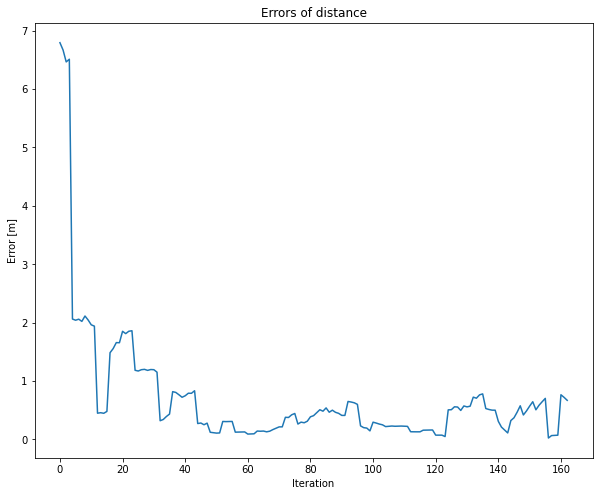

In [130]:
plt.figure(figsize=(10,8))
plt.plot(errors_distance)
plt.title("Errors of distance")
plt.xlabel("Iteration")
plt.ylabel("Error [m]")
plt.show()

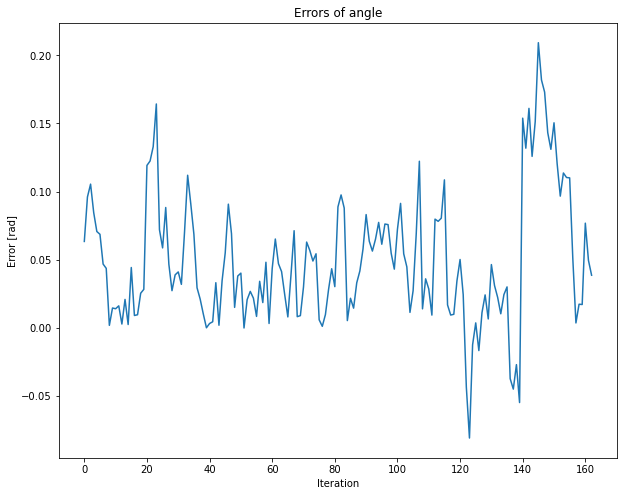

In [131]:
plt.figure(figsize=(10,8))
plt.plot(errors_angle)
plt.title("Errors of angle")
plt.xlabel("Iteration")
plt.ylabel("Error [rad]")
plt.show()

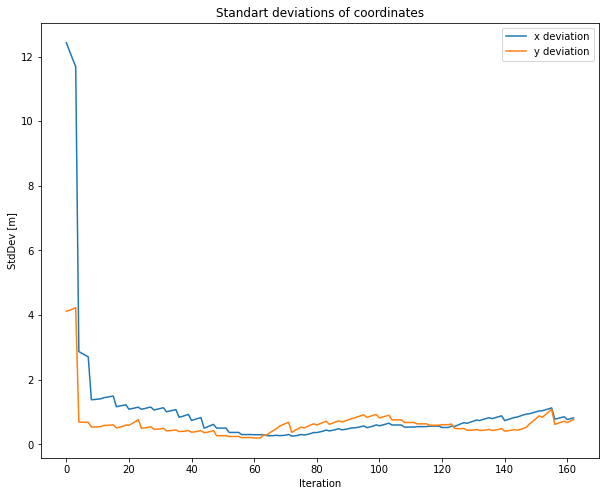

In [132]:
plt.figure(figsize=(10,8))
plt.plot(stddev_x, label="x deviation")
plt.plot(stddev_y, label="y deviation")
plt.title("Standart deviations of coordinates")
plt.xlabel("Iteration")
plt.ylabel("StdDev [m]")
plt.legend()
plt.show()